In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import sys
sys.path.insert(0, "C:\\Users\\KonuTech\\DataSpellProjects\\kaggle-tabular-playground-series-nov-2021\\scripts")
import json
import numpy as np
import pandas as pd
import math
from itertools import product, chain
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from datetime import datetime

In [4]:
pd.options.display.float_format = "{:.2f}".format

In [5]:
from catboost import CatBoostClassifier, Pool, EShapCalcType, EFeaturesSelectionAlgorithm

In [6]:
from scripts.paramsearch import paramsearch

In [7]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

In [8]:
! python scripts\unzip.py inputs\tabular-playground-series-nov-2021.zip

In [9]:
CURRENT_WORKING_DIRECTORY = os.getcwd()

In [10]:
INPUTS = CURRENT_WORKING_DIRECTORY + "\\INPUTS"
SCRIPTS = CURRENT_WORKING_DIRECTORY + "\\SCRIPTS"

In [14]:
CONFIG_FILE = "config.json"
with open(CURRENT_WORKING_DIRECTORY + "\\" + CONFIG_FILE, encoding='utf-8') as f:
    CONFIG = json.load(f)

In [15]:
TRAIN_PATH = CONFIG["INPUTS"]["TRAIN_PATH"][0]
TEST_PATH = CONFIG["INPUTS"]["TEST_PATH"][0]
TARGET = CONFIG["INPUTS"]["TARGET"]
INDEX_COL = CONFIG["INPUTS"]["INDEX_COLUMNS"]
SEP = CONFIG["INPUTS"]["SEPARATOR"]
DECIMAL = CONFIG["INPUTS"]["DECIMAL"]
ENCODING = CONFIG["INPUTS"]["ENCODING"]
DATE_COLUMNS = CONFIG["INPUTS"]["DATE_COLUMNS"]
FLOAT_PRECISION = CONFIG["INPUTS"]["FLOAT_PRECISION"]
DTYPE = CONFIG["INPUTS"]["DTYPE"]
COLUMNS_WITH_NAN_VALUES = CONFIG["INPUTS"]["COLUMNS_WITH_NAN_VALUES"]

In [16]:
TARGET

'target'

# TRAIN OVERVIEW

In [17]:
train = pd.read_csv(
    INPUTS + "\\" + TRAIN_PATH,
    index_col=INDEX_COL,
    sep=SEP,
    encoding=ENCODING,
    infer_datetime_format=True,
    engine="c",
    low_memory=False,
    # dtype=DTYPE
)

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 600000 entries, 0 to 599999
Columns: 101 entries, f0 to target
dtypes: float64(100), int64(1)
memory usage: 466.9 MB


In [19]:
train[TARGET].value_counts()

1    303606
0    296394
Name: target, dtype: int64

In [20]:
TRAIN_NUMERIC_COLUMNS = train.select_dtypes(include=["float64", "int64"]).columns
TRAIN_NUMERIC_COLUMNS = TRAIN_NUMERIC_COLUMNS.drop(TARGET)
TRAIN_NUMERIC_COLUMNS

Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20',
       'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30',
       'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40',
       'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50',
       'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60',
       'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70',
       'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80',
       'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90',
       'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99'],
      dtype='object')

In [21]:
TRAIN_OBJECT_COLUMNS = train.select_dtypes(include=["object"]).columns
TRAIN_OBJECT_COLUMNS

Index([], dtype='object')

# TEST OVERVIEW

In [22]:
test = pd.read_csv(
    INPUTS + "\\" + TEST_PATH,
    index_col=INDEX_COL,
    sep=SEP,
    encoding=ENCODING,
    infer_datetime_format=True,
    engine="c",
    low_memory=False,
    # dtype=DTYPE
)

In [23]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 540000 entries, 600000 to 1139999
Data columns (total 100 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   f0      540000 non-null  float64
 1   f1      540000 non-null  float64
 2   f2      540000 non-null  float64
 3   f3      540000 non-null  float64
 4   f4      540000 non-null  float64
 5   f5      540000 non-null  float64
 6   f6      540000 non-null  float64
 7   f7      540000 non-null  float64
 8   f8      540000 non-null  float64
 9   f9      540000 non-null  float64
 10  f10     540000 non-null  float64
 11  f11     540000 non-null  float64
 12  f12     540000 non-null  float64
 13  f13     540000 non-null  float64
 14  f14     540000 non-null  float64
 15  f15     540000 non-null  float64
 16  f16     540000 non-null  float64
 17  f17     540000 non-null  float64
 18  f18     540000 non-null  float64
 19  f19     540000 non-null  float64
 20  f20     540000 non-null  float64
 21  f21

In [24]:
TEST_NUMERIC_COLUMNS = test.select_dtypes(include=["float64", "int64"]).columns
TEST_NUMERIC_COLUMNS

Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20',
       'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30',
       'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40',
       'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50',
       'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60',
       'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70',
       'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80',
       'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90',
       'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99'],
      dtype='object')

In [25]:
TEST_OBJECT_COLUMNS = test.select_dtypes(include=["object"]).columns
TEST_OBJECT_COLUMNS

Index([], dtype='object')

In [26]:
test.sample(5)

f0   f1     f2   f3    f4   f5   f6   f7   f8    f9  ...   f90  f91  \
id                                                             ...              
628114  0.17 0.85 112.34 4.39 -0.03 2.05 2.75 5.09 1.06  0.13  ... -0.02 2.10   
1081079 0.04 4.24 145.93 1.94  0.10 4.52 1.32 0.65 3.37  0.05  ...  0.04 2.33   
639570  0.03 3.93 825.62 3.63  0.12 3.57 2.65 4.05 5.02  0.11  ...  0.05 2.06   
1129902 0.00 4.22 -61.93 1.82 -0.03 2.89 4.59 0.01 3.77  0.05  ... -0.02 0.52   
747351  0.85 0.79 101.17 2.25  0.12 0.77 3.66 0.70 0.83 -0.00  ...  0.06 2.46   

         f92  f93  f94  f95  f96  f97   f98   f99  
id                                                 
628114  0.08 0.02 0.05 0.07 3.54 3.81  0.12  0.12  
1081079 1.96 0.07 0.01 0.05 3.79 4.41  0.08 -0.01  
639570  0.03 0.14 0.08 0.07 2.39 3.48  0.07  0.01  
1129902 0.09 0.06 0.13 0.10 4.17 4.66 -0.04  0.08  
747351  0.00 0.06 0.05 0.20 0.85 5.23  0.05  0.03  

[5 rows x 100 columns]

# FEATURES AND TARGET

In [27]:
features = [col for col in train.columns if col not in [TARGET]]

In [28]:
X_train = train[features]

In [29]:
X_train.sample(2)

f0   f1     f2   f3   f4   f5   f6   f7   f8   f9  ...   f90  f91  \
id                                                           ...              
210423 -0.07 3.24 294.42 5.21 0.14 4.76 4.39 2.93 1.61 0.06  ... -0.01 3.18   
104193  0.04 4.10 606.86 2.31 0.08 0.68 5.99 5.07 2.46 2.70  ...  0.09 3.58   

        f92  f93  f94  f95  f96  f97  f98  f99  
id                                              
210423 0.15 0.07 0.04 0.11 0.54 2.48 0.02 0.08  
104193 0.08 0.04 0.96 0.08 5.01 1.06 0.48 0.07  

[2 rows x 100 columns]

In [30]:
y_train = train[TARGET]

In [31]:
y_train.value_counts()

1    303606
0    296394
Name: target, dtype: int64

In [32]:
X_test = test[features]

In [33]:
X_test.sample(2)

f0   f1     f2   f3   f4   f5   f6   f7   f8   f9  ...  f90  f91  \
id                                                          ...             
722658 0.08 4.85 187.76 3.12 0.13 1.73 2.47 2.57 1.02 0.02  ... 0.01 0.51   
804038 0.10 4.40 295.13 5.53 0.08 0.64 4.44 5.93 2.89 0.13  ... 0.11 3.15   

        f92  f93   f94  f95  f96  f97   f98   f99  
id                                                 
722658 0.04 0.00  0.09 0.11 3.30 3.29  0.11  0.04  
804038 0.14 0.00 -0.01 0.11 2.95 1.90 -0.05 -0.04  

[2 rows x 100 columns]

In [34]:
print(" X_train shape: ", X_train.shape, "\n", "y_train shape: ", y_train.shape, "\n", "X_test  shape: ", X_test.shape, "\n", "y_test  shape: ", None)

 X_train shape:  (600000, 100) 
 y_train shape:  (600000,) 
 X_test  shape:  (540000, 100) 
 y_test  shape:  None


### Categorical Features

In [35]:
categorical_features = TEST_OBJECT_COLUMNS

In [36]:
categorical_features_index = []
for column in categorical_features:
    categorical_features_index.append(X_train.columns.get_loc(column))

In [37]:
categorical_features_index

[]

### Class Weights

In [38]:
# labels_dict : {ind_label: count_label}
# mu : parameter to tune

def create_class_weight(labels_dict, mu=0.15):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()

    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0

    return class_weight

In [42]:
y_train.value_counts()[1]

303606

In [49]:
labels_dict = {0: y_train.value_counts()[0], 1: y_train.value_counts()[1]}

In [52]:
labels_dict

{0: 296394, 1: 303606}

In [55]:
class_weights = create_class_weight(labels_dict)

In [56]:
class_weights

{0: 1.0, 1: 1.0}

### FEATURE SELECTOR

In [143]:
selector = CatBoostClassifier(
    #     loss_function="CrossEntropy", # class weights takes effect only with Logloss, MultiClass, MultiClassOneVsAll
    loss_function="CrossEntropy",
    eval_metric="AUC",
    custom_metric=['AUC:hints=skip_train~false'],
#     custom_metric=['AUC:type=OneVsAll;hints=skip_train~false', 'Accuracy'], # for many classes
#     class_weights=class_weights,
#     one_hot_max_size=31,
    depth=6,
    iterations= 2500,
    l2_leaf_reg= 3,
    learning_rate= 0.03,
    nan_mode="Max",
    cat_features=categorical_features_index
)

In [144]:
feature_names= X_train.columns.to_list()

In [145]:
train_pool = Pool(X_train, y_train, cat_features=categorical_features_index, feature_names=feature_names)
#test_pool = Pool(X_test, y_test, cat_features=categorical_features_index, feature_names=feature_names)

In [146]:
X_test.sample(2)

f0   f1     f2   f3   f4   f5   f6   f7   f8   f9  ...  f90  f91  \
id                                                           ...             
1064905 0.60 4.05 384.28 4.49 0.09 1.48 1.59 1.66 0.05 0.12  ... 0.04 3.32   
809185  0.15 4.95 -37.66 1.07 0.03 1.99 2.73 2.28 2.47 0.02  ... 0.08 2.21   

         f92  f93  f94  f95  f96  f97  f98  f99  
id                                               
1064905 0.13 0.08 1.06 0.01 0.92 3.25 0.80 0.05  
809185  0.02 0.04 0.01 0.06 3.87 2.17 0.28 1.55  

[2 rows x 100 columns]

In [147]:
# X_test.shape[1]-1
X_test.shape[1]

100

In [148]:
'0-' + str(X_test.shape[1])

'0-100'

In [149]:
summary = selector.select_features(
    train_pool, # X_train, y_train
    #eval_set=test_pool, # The validation dataset or datasets used for the following processes: overfitting detector, best iteration selection, monitoring metrics changes
    features_for_select='0-' + str(X_test.shape[1]-1), # Features which participate in the selection.
    num_features_to_select=40, # The number of features to select from features_for_select.
    steps=3, # The number of times for training the model. Use more steps for more accurate selection
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, # the most accurate method
    shap_calc_type=EShapCalcType.Exact, # The method of the SHAP values calculations ordered by accuracy: Approximate, Regular, Exact
    train_final_model=True, # If specified, then the model with selected features will be trained after features selection.
    #logging_level='Silent', # optimized metric, elapsed time of training, remaining time of training
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Step #1 out of 3
0:	learn: 0.6303997	total: 136ms	remaining: 5m 40s
1:	learn: 0.6403562	total: 286ms	remaining: 5m 57s
2:	learn: 0.6467595	total: 435ms	remaining: 6m 1s
3:	learn: 0.6493844	total: 587ms	remaining: 6m 6s
4:	learn: 0.6511690	total: 731ms	remaining: 6m 5s
5:	learn: 0.6540572	total: 857ms	remaining: 5m 56s
6:	learn: 0.6549545	total: 987ms	remaining: 5m 51s
7:	learn: 0.6565429	total: 1.14s	remaining: 5m 54s
8:	learn: 0.6570909	total: 1.28s	remaining: 5m 53s
9:	learn: 0.6571722	total: 1.42s	remaining: 5m 54s
10:	learn: 0.6577886	total: 1.56s	remaining: 5m 54s
11:	learn: 0.6583873	total: 1.69s	remaining: 5m 50s
12:	learn: 0.6594073	total: 1.81s	remaining: 5m 45s
13:	learn: 0.6603205	total: 1.94s	remaining: 5m 44s
14:	learn: 0.6604178	total: 2.09s	remaining: 5m 45s
15:	learn: 0.6623252	total: 2.21s	remaining: 5m 42s
16:	learn: 0.6640061	total: 2.35s	remaining: 5m 42s
17:	learn: 0.6645922	total: 2.49s	remaining: 5m 43s
18:	learn: 0.6651655	total: 2.62s	remaining: 5m 41s
19:	lear

159:	learn: 0.7204024	total: 20.4s	remaining: 4m 58s
160:	learn: 0.7206312	total: 20.6s	remaining: 4m 58s
161:	learn: 0.7207610	total: 20.7s	remaining: 4m 58s
162:	learn: 0.7208279	total: 20.8s	remaining: 4m 58s
163:	learn: 0.7209055	total: 20.9s	remaining: 4m 58s
164:	learn: 0.7210118	total: 21.1s	remaining: 4m 57s
165:	learn: 0.7210691	total: 21.2s	remaining: 4m 57s
166:	learn: 0.7212631	total: 21.3s	remaining: 4m 57s
167:	learn: 0.7213923	total: 21.4s	remaining: 4m 57s
168:	learn: 0.7215751	total: 21.6s	remaining: 4m 57s
169:	learn: 0.7216738	total: 21.7s	remaining: 4m 57s
170:	learn: 0.7218276	total: 21.8s	remaining: 4m 57s
171:	learn: 0.7219951	total: 22s	remaining: 4m 57s
172:	learn: 0.7220298	total: 22.1s	remaining: 4m 57s
173:	learn: 0.7222118	total: 22.2s	remaining: 4m 57s
174:	learn: 0.7223115	total: 22.3s	remaining: 4m 56s
175:	learn: 0.7224618	total: 22.5s	remaining: 4m 56s
176:	learn: 0.7225481	total: 22.6s	remaining: 4m 56s
177:	learn: 0.7226737	total: 22.8s	remaining: 4m

315:	learn: 0.7341584	total: 39.5s	remaining: 4m 32s
316:	learn: 0.7342270	total: 39.6s	remaining: 4m 32s
317:	learn: 0.7343085	total: 39.7s	remaining: 4m 32s
318:	learn: 0.7343907	total: 39.9s	remaining: 4m 32s
319:	learn: 0.7344418	total: 40s	remaining: 4m 32s
320:	learn: 0.7345043	total: 40.1s	remaining: 4m 32s
321:	learn: 0.7345297	total: 40.2s	remaining: 4m 32s
322:	learn: 0.7345718	total: 40.3s	remaining: 4m 31s
323:	learn: 0.7346443	total: 40.5s	remaining: 4m 31s
324:	learn: 0.7346725	total: 40.6s	remaining: 4m 31s
325:	learn: 0.7347419	total: 40.7s	remaining: 4m 31s
326:	learn: 0.7348055	total: 40.8s	remaining: 4m 31s
327:	learn: 0.7348674	total: 41s	remaining: 4m 31s
328:	learn: 0.7349059	total: 41.1s	remaining: 4m 31s
329:	learn: 0.7349743	total: 41.2s	remaining: 4m 30s
330:	learn: 0.7350225	total: 41.3s	remaining: 4m 30s
331:	learn: 0.7350657	total: 41.5s	remaining: 4m 30s
332:	learn: 0.7351073	total: 41.6s	remaining: 4m 30s
333:	learn: 0.7351609	total: 41.7s	remaining: 4m 3

471:	learn: 0.7408233	total: 59.4s	remaining: 4m 15s
472:	learn: 0.7408621	total: 59.5s	remaining: 4m 14s
473:	learn: 0.7409035	total: 59.6s	remaining: 4m 14s
474:	learn: 0.7409086	total: 59.7s	remaining: 4m 14s
475:	learn: 0.7409449	total: 59.9s	remaining: 4m 14s
476:	learn: 0.7409803	total: 60s	remaining: 4m 14s
477:	learn: 0.7410050	total: 1m	remaining: 4m 14s
478:	learn: 0.7410434	total: 1m	remaining: 4m 14s
479:	learn: 0.7410777	total: 1m	remaining: 4m 13s
480:	learn: 0.7410931	total: 1m	remaining: 4m 13s
481:	learn: 0.7411355	total: 1m	remaining: 4m 13s
482:	learn: 0.7411691	total: 1m	remaining: 4m 13s
483:	learn: 0.7412080	total: 1m	remaining: 4m 13s
484:	learn: 0.7412540	total: 1m 1s	remaining: 4m 13s
485:	learn: 0.7412970	total: 1m 1s	remaining: 4m 13s
486:	learn: 0.7413189	total: 1m 1s	remaining: 4m 13s
487:	learn: 0.7413510	total: 1m 1s	remaining: 4m 13s
488:	learn: 0.7413797	total: 1m 1s	remaining: 4m 13s
489:	learn: 0.7414105	total: 1m 1s	remaining: 4m 12s
490:	learn: 0.74

627:	learn: 0.7452727	total: 1m 18s	remaining: 3m 53s
628:	learn: 0.7452999	total: 1m 18s	remaining: 3m 53s
629:	learn: 0.7453250	total: 1m 18s	remaining: 3m 53s
630:	learn: 0.7453497	total: 1m 18s	remaining: 3m 53s
631:	learn: 0.7453774	total: 1m 18s	remaining: 3m 53s
632:	learn: 0.7453852	total: 1m 19s	remaining: 3m 53s
633:	learn: 0.7454193	total: 1m 19s	remaining: 3m 53s
634:	learn: 0.7454484	total: 1m 19s	remaining: 3m 52s
635:	learn: 0.7454592	total: 1m 19s	remaining: 3m 52s
636:	learn: 0.7454886	total: 1m 19s	remaining: 3m 52s
637:	learn: 0.7455211	total: 1m 19s	remaining: 3m 52s
638:	learn: 0.7455225	total: 1m 19s	remaining: 3m 52s
639:	learn: 0.7455489	total: 1m 19s	remaining: 3m 52s
640:	learn: 0.7455761	total: 1m 20s	remaining: 3m 52s
641:	learn: 0.7455951	total: 1m 20s	remaining: 3m 52s
642:	learn: 0.7456268	total: 1m 20s	remaining: 3m 51s
643:	learn: 0.7456558	total: 1m 20s	remaining: 3m 51s
644:	learn: 0.7456717	total: 1m 20s	remaining: 3m 51s
645:	learn: 0.7456980	total:

779:	learn: 0.7485084	total: 1m 37s	remaining: 3m 35s
780:	learn: 0.7485173	total: 1m 37s	remaining: 3m 35s
781:	learn: 0.7485371	total: 1m 37s	remaining: 3m 35s
782:	learn: 0.7485586	total: 1m 38s	remaining: 3m 34s
783:	learn: 0.7485776	total: 1m 38s	remaining: 3m 34s
784:	learn: 0.7486004	total: 1m 38s	remaining: 3m 34s
785:	learn: 0.7486226	total: 1m 38s	remaining: 3m 34s
786:	learn: 0.7486428	total: 1m 38s	remaining: 3m 34s
787:	learn: 0.7486555	total: 1m 38s	remaining: 3m 34s
788:	learn: 0.7486708	total: 1m 38s	remaining: 3m 34s
789:	learn: 0.7486945	total: 1m 38s	remaining: 3m 34s
790:	learn: 0.7487142	total: 1m 39s	remaining: 3m 33s
791:	learn: 0.7487359	total: 1m 39s	remaining: 3m 33s
792:	learn: 0.7487590	total: 1m 39s	remaining: 3m 33s
793:	learn: 0.7487804	total: 1m 39s	remaining: 3m 33s
794:	learn: 0.7487955	total: 1m 39s	remaining: 3m 33s
795:	learn: 0.7488141	total: 1m 39s	remaining: 3m 33s
796:	learn: 0.7488351	total: 1m 39s	remaining: 3m 33s
797:	learn: 0.7488579	total:

931:	learn: 0.7510791	total: 1m 56s	remaining: 3m 16s
932:	learn: 0.7510924	total: 1m 56s	remaining: 3m 16s
933:	learn: 0.7511108	total: 1m 56s	remaining: 3m 15s
934:	learn: 0.7511284	total: 1m 56s	remaining: 3m 15s
935:	learn: 0.7511442	total: 1m 57s	remaining: 3m 15s
936:	learn: 0.7511610	total: 1m 57s	remaining: 3m 15s
937:	learn: 0.7511696	total: 1m 57s	remaining: 3m 15s
938:	learn: 0.7511832	total: 1m 57s	remaining: 3m 15s
939:	learn: 0.7511985	total: 1m 57s	remaining: 3m 15s
940:	learn: 0.7512142	total: 1m 57s	remaining: 3m 15s
941:	learn: 0.7512296	total: 1m 57s	remaining: 3m 14s
942:	learn: 0.7512355	total: 1m 58s	remaining: 3m 14s
943:	learn: 0.7512522	total: 1m 58s	remaining: 3m 14s
944:	learn: 0.7512662	total: 1m 58s	remaining: 3m 14s
945:	learn: 0.7512828	total: 1m 58s	remaining: 3m 14s
946:	learn: 0.7512971	total: 1m 58s	remaining: 3m 14s
947:	learn: 0.7513099	total: 1m 58s	remaining: 3m 14s
948:	learn: 0.7513265	total: 1m 58s	remaining: 3m 13s
949:	learn: 0.7513408	total:

1087:	learn: 0.7532382	total: 2m 15s	remaining: 2m 55s
1088:	learn: 0.7532536	total: 2m 15s	remaining: 2m 55s
1089:	learn: 0.7532698	total: 2m 15s	remaining: 2m 55s
1090:	learn: 0.7532827	total: 2m 15s	remaining: 2m 55s
1091:	learn: 0.7532962	total: 2m 15s	remaining: 2m 55s
1092:	learn: 0.7533045	total: 2m 15s	remaining: 2m 54s
1093:	learn: 0.7533105	total: 2m 16s	remaining: 2m 54s
1094:	learn: 0.7533256	total: 2m 16s	remaining: 2m 54s
1095:	learn: 0.7533378	total: 2m 16s	remaining: 2m 54s
1096:	learn: 0.7533487	total: 2m 16s	remaining: 2m 54s
1097:	learn: 0.7533571	total: 2m 16s	remaining: 2m 54s
1098:	learn: 0.7533704	total: 2m 16s	remaining: 2m 54s
1099:	learn: 0.7533829	total: 2m 16s	remaining: 2m 54s
1100:	learn: 0.7533932	total: 2m 16s	remaining: 2m 53s
1101:	learn: 0.7534071	total: 2m 17s	remaining: 2m 53s
1102:	learn: 0.7534197	total: 2m 17s	remaining: 2m 53s
1103:	learn: 0.7534330	total: 2m 17s	remaining: 2m 53s
1104:	learn: 0.7534451	total: 2m 17s	remaining: 2m 53s
1105:	lear

1237:	learn: 0.7550579	total: 2m 34s	remaining: 2m 37s
1238:	learn: 0.7550658	total: 2m 34s	remaining: 2m 36s
1239:	learn: 0.7550799	total: 2m 34s	remaining: 2m 36s
1240:	learn: 0.7550925	total: 2m 34s	remaining: 2m 36s
1241:	learn: 0.7551058	total: 2m 34s	remaining: 2m 36s
1242:	learn: 0.7551175	total: 2m 34s	remaining: 2m 36s
1243:	learn: 0.7551314	total: 2m 34s	remaining: 2m 36s
1244:	learn: 0.7551441	total: 2m 35s	remaining: 2m 36s
1245:	learn: 0.7551490	total: 2m 35s	remaining: 2m 36s
1246:	learn: 0.7551587	total: 2m 35s	remaining: 2m 36s
1247:	learn: 0.7551714	total: 2m 35s	remaining: 2m 35s
1248:	learn: 0.7551822	total: 2m 35s	remaining: 2m 35s
1249:	learn: 0.7551939	total: 2m 35s	remaining: 2m 35s
1250:	learn: 0.7552056	total: 2m 35s	remaining: 2m 35s
1251:	learn: 0.7552185	total: 2m 35s	remaining: 2m 35s
1252:	learn: 0.7552300	total: 2m 35s	remaining: 2m 35s
1253:	learn: 0.7552427	total: 2m 36s	remaining: 2m 35s
1254:	learn: 0.7552552	total: 2m 36s	remaining: 2m 35s
1255:	lear

1386:	learn: 0.7566723	total: 2m 53s	remaining: 2m 18s
1387:	learn: 0.7566816	total: 2m 53s	remaining: 2m 18s
1388:	learn: 0.7566919	total: 2m 53s	remaining: 2m 18s
1389:	learn: 0.7567025	total: 2m 53s	remaining: 2m 18s
1390:	learn: 0.7567103	total: 2m 53s	remaining: 2m 18s
1391:	learn: 0.7567217	total: 2m 53s	remaining: 2m 18s
1392:	learn: 0.7567305	total: 2m 53s	remaining: 2m 18s
1393:	learn: 0.7567409	total: 2m 54s	remaining: 2m 18s
1394:	learn: 0.7567504	total: 2m 54s	remaining: 2m 17s
1395:	learn: 0.7567631	total: 2m 54s	remaining: 2m 17s
1396:	learn: 0.7567741	total: 2m 54s	remaining: 2m 17s
1397:	learn: 0.7567850	total: 2m 54s	remaining: 2m 17s
1398:	learn: 0.7567970	total: 2m 54s	remaining: 2m 17s
1399:	learn: 0.7568073	total: 2m 54s	remaining: 2m 17s
1400:	learn: 0.7568210	total: 2m 55s	remaining: 2m 17s
1401:	learn: 0.7568304	total: 2m 55s	remaining: 2m 17s
1402:	learn: 0.7568377	total: 2m 55s	remaining: 2m 17s
1403:	learn: 0.7568491	total: 2m 55s	remaining: 2m 16s
1404:	lear

1540:	learn: 0.7582295	total: 3m 12s	remaining: 1m 59s
1541:	learn: 0.7582416	total: 3m 12s	remaining: 1m 59s
1542:	learn: 0.7582522	total: 3m 12s	remaining: 1m 59s
1543:	learn: 0.7582591	total: 3m 13s	remaining: 1m 59s
1544:	learn: 0.7582674	total: 3m 13s	remaining: 1m 59s
1545:	learn: 0.7582776	total: 3m 13s	remaining: 1m 59s
1546:	learn: 0.7582883	total: 3m 13s	remaining: 1m 59s
1547:	learn: 0.7582987	total: 3m 13s	remaining: 1m 59s
1548:	learn: 0.7583101	total: 3m 13s	remaining: 1m 58s
1549:	learn: 0.7583205	total: 3m 13s	remaining: 1m 58s
1550:	learn: 0.7583278	total: 3m 13s	remaining: 1m 58s
1551:	learn: 0.7583391	total: 3m 14s	remaining: 1m 58s
1552:	learn: 0.7583503	total: 3m 14s	remaining: 1m 58s
1553:	learn: 0.7583593	total: 3m 14s	remaining: 1m 58s
1554:	learn: 0.7583676	total: 3m 14s	remaining: 1m 58s
1555:	learn: 0.7583781	total: 3m 14s	remaining: 1m 58s
1556:	learn: 0.7583894	total: 3m 14s	remaining: 1m 57s
1557:	learn: 0.7583990	total: 3m 14s	remaining: 1m 57s
1558:	lear

1690:	learn: 0.7597075	total: 3m 31s	remaining: 1m 41s
1691:	learn: 0.7597184	total: 3m 31s	remaining: 1m 40s
1692:	learn: 0.7597287	total: 3m 31s	remaining: 1m 40s
1693:	learn: 0.7597369	total: 3m 31s	remaining: 1m 40s
1694:	learn: 0.7597442	total: 3m 31s	remaining: 1m 40s
1695:	learn: 0.7597535	total: 3m 31s	remaining: 1m 40s
1696:	learn: 0.7597645	total: 3m 32s	remaining: 1m 40s
1697:	learn: 0.7597734	total: 3m 32s	remaining: 1m 40s
1698:	learn: 0.7597829	total: 3m 32s	remaining: 1m 40s
1699:	learn: 0.7597940	total: 3m 32s	remaining: 1m 39s
1700:	learn: 0.7598043	total: 3m 32s	remaining: 1m 39s
1701:	learn: 0.7598152	total: 3m 32s	remaining: 1m 39s
1702:	learn: 0.7598257	total: 3m 32s	remaining: 1m 39s
1703:	learn: 0.7598285	total: 3m 32s	remaining: 1m 39s
1704:	learn: 0.7598374	total: 3m 33s	remaining: 1m 39s
1705:	learn: 0.7598491	total: 3m 33s	remaining: 1m 39s
1706:	learn: 0.7598602	total: 3m 33s	remaining: 1m 39s
1707:	learn: 0.7598695	total: 3m 33s	remaining: 1m 39s
1708:	lear

1840:	learn: 0.7610795	total: 3m 50s	remaining: 1m 22s
1841:	learn: 0.7610893	total: 3m 50s	remaining: 1m 22s
1842:	learn: 0.7611000	total: 3m 50s	remaining: 1m 22s
1843:	learn: 0.7611084	total: 3m 50s	remaining: 1m 22s
1844:	learn: 0.7611191	total: 3m 50s	remaining: 1m 21s
1845:	learn: 0.7611253	total: 3m 50s	remaining: 1m 21s
1846:	learn: 0.7611352	total: 3m 50s	remaining: 1m 21s
1847:	learn: 0.7611437	total: 3m 51s	remaining: 1m 21s
1848:	learn: 0.7611533	total: 3m 51s	remaining: 1m 21s
1849:	learn: 0.7611538	total: 3m 51s	remaining: 1m 21s
1850:	learn: 0.7611622	total: 3m 51s	remaining: 1m 21s
1851:	learn: 0.7611704	total: 3m 51s	remaining: 1m 21s
1852:	learn: 0.7611793	total: 3m 51s	remaining: 1m 20s
1853:	learn: 0.7611887	total: 3m 51s	remaining: 1m 20s
1854:	learn: 0.7611988	total: 3m 51s	remaining: 1m 20s
1855:	learn: 0.7612066	total: 3m 52s	remaining: 1m 20s
1856:	learn: 0.7612163	total: 3m 52s	remaining: 1m 20s
1857:	learn: 0.7612257	total: 3m 52s	remaining: 1m 20s
1858:	lear

1993:	learn: 0.7624248	total: 4m 9s	remaining: 1m 3s
1994:	learn: 0.7624314	total: 4m 9s	remaining: 1m 3s
1995:	learn: 0.7624392	total: 4m 9s	remaining: 1m 3s
1996:	learn: 0.7624480	total: 4m 9s	remaining: 1m 2s
1997:	learn: 0.7624566	total: 4m 9s	remaining: 1m 2s
1998:	learn: 0.7624642	total: 4m 9s	remaining: 1m 2s
1999:	learn: 0.7624726	total: 4m 10s	remaining: 1m 2s
2000:	learn: 0.7624821	total: 4m 10s	remaining: 1m 2s
2001:	learn: 0.7624909	total: 4m 10s	remaining: 1m 2s
2002:	learn: 0.7625002	total: 4m 10s	remaining: 1m 2s
2003:	learn: 0.7625093	total: 4m 10s	remaining: 1m 2s
2004:	learn: 0.7625165	total: 4m 10s	remaining: 1m 1s
2005:	learn: 0.7625239	total: 4m 10s	remaining: 1m 1s
2006:	learn: 0.7625337	total: 4m 11s	remaining: 1m 1s
2007:	learn: 0.7625445	total: 4m 11s	remaining: 1m 1s
2008:	learn: 0.7625523	total: 4m 11s	remaining: 1m 1s
2009:	learn: 0.7625632	total: 4m 11s	remaining: 1m 1s
2010:	learn: 0.7625719	total: 4m 11s	remaining: 1m 1s
2011:	learn: 0.7625813	total: 4m 1

2146:	learn: 0.7637494	total: 4m 29s	remaining: 44.3s
2147:	learn: 0.7637563	total: 4m 29s	remaining: 44.2s
2148:	learn: 0.7637631	total: 4m 29s	remaining: 44s
2149:	learn: 0.7637715	total: 4m 29s	remaining: 43.9s
2150:	learn: 0.7637789	total: 4m 29s	remaining: 43.8s
2151:	learn: 0.7637882	total: 4m 29s	remaining: 43.7s
2152:	learn: 0.7637970	total: 4m 30s	remaining: 43.5s
2153:	learn: 0.7638051	total: 4m 30s	remaining: 43.4s
2154:	learn: 0.7638139	total: 4m 30s	remaining: 43.3s
2155:	learn: 0.7638242	total: 4m 30s	remaining: 43.2s
2156:	learn: 0.7638338	total: 4m 30s	remaining: 43s
2157:	learn: 0.7638403	total: 4m 30s	remaining: 42.9s
2158:	learn: 0.7638478	total: 4m 30s	remaining: 42.8s
2159:	learn: 0.7638568	total: 4m 31s	remaining: 42.7s
2160:	learn: 0.7638644	total: 4m 31s	remaining: 42.6s
2161:	learn: 0.7638740	total: 4m 31s	remaining: 42.4s
2162:	learn: 0.7638838	total: 4m 31s	remaining: 42.3s
2163:	learn: 0.7638925	total: 4m 31s	remaining: 42.2s
2164:	learn: 0.7639019	total: 4m

2300:	learn: 0.7650266	total: 4m 49s	remaining: 25s
2301:	learn: 0.7650318	total: 4m 49s	remaining: 24.9s
2302:	learn: 0.7650417	total: 4m 49s	remaining: 24.8s
2303:	learn: 0.7650493	total: 4m 49s	remaining: 24.6s
2304:	learn: 0.7650585	total: 4m 49s	remaining: 24.5s
2305:	learn: 0.7650658	total: 4m 49s	remaining: 24.4s
2306:	learn: 0.7650746	total: 4m 50s	remaining: 24.3s
2307:	learn: 0.7650824	total: 4m 50s	remaining: 24.1s
2308:	learn: 0.7650919	total: 4m 50s	remaining: 24s
2309:	learn: 0.7651015	total: 4m 50s	remaining: 23.9s
2310:	learn: 0.7651119	total: 4m 50s	remaining: 23.8s
2311:	learn: 0.7651200	total: 4m 50s	remaining: 23.6s
2312:	learn: 0.7651275	total: 4m 50s	remaining: 23.5s
2313:	learn: 0.7651362	total: 4m 50s	remaining: 23.4s
2314:	learn: 0.7651439	total: 4m 51s	remaining: 23.3s
2315:	learn: 0.7651528	total: 4m 51s	remaining: 23.1s
2316:	learn: 0.7651622	total: 4m 51s	remaining: 23s
2317:	learn: 0.7651670	total: 4m 51s	remaining: 22.9s
2318:	learn: 0.7651758	total: 4m 5

2456:	learn: 0.7663443	total: 5m 9s	remaining: 5.42s
2457:	learn: 0.7663539	total: 5m 9s	remaining: 5.29s
2458:	learn: 0.7663636	total: 5m 10s	remaining: 5.17s
2459:	learn: 0.7663711	total: 5m 10s	remaining: 5.04s
2460:	learn: 0.7663773	total: 5m 10s	remaining: 4.92s
2461:	learn: 0.7663855	total: 5m 10s	remaining: 4.79s
2462:	learn: 0.7663959	total: 5m 10s	remaining: 4.66s
2463:	learn: 0.7664054	total: 5m 10s	remaining: 4.54s
2464:	learn: 0.7664121	total: 5m 10s	remaining: 4.41s
2465:	learn: 0.7664217	total: 5m 10s	remaining: 4.29s
2466:	learn: 0.7664292	total: 5m 11s	remaining: 4.16s
2467:	learn: 0.7664367	total: 5m 11s	remaining: 4.03s
2468:	learn: 0.7664449	total: 5m 11s	remaining: 3.91s
2469:	learn: 0.7664521	total: 5m 11s	remaining: 3.78s
2470:	learn: 0.7664616	total: 5m 11s	remaining: 3.66s
2471:	learn: 0.7664691	total: 5m 11s	remaining: 3.53s
2472:	learn: 0.7664786	total: 5m 11s	remaining: 3.4s
2473:	learn: 0.7664882	total: 5m 11s	remaining: 3.28s
2474:	learn: 0.7664970	total: 5

103:	learn: 0.7098861	total: 12.9s	remaining: 4m 56s
104:	learn: 0.7101926	total: 13s	remaining: 4m 56s
105:	learn: 0.7104417	total: 13.1s	remaining: 4m 55s
106:	learn: 0.7107621	total: 13.2s	remaining: 4m 55s
107:	learn: 0.7110445	total: 13.3s	remaining: 4m 55s
108:	learn: 0.7113844	total: 13.4s	remaining: 4m 54s
109:	learn: 0.7116956	total: 13.6s	remaining: 4m 54s
110:	learn: 0.7119567	total: 13.7s	remaining: 4m 54s
111:	learn: 0.7121971	total: 13.8s	remaining: 4m 53s
112:	learn: 0.7124522	total: 13.9s	remaining: 4m 53s
113:	learn: 0.7126059	total: 14s	remaining: 4m 52s
114:	learn: 0.7127630	total: 14.1s	remaining: 4m 52s
115:	learn: 0.7130880	total: 14.2s	remaining: 4m 51s
116:	learn: 0.7132916	total: 14.3s	remaining: 4m 51s
117:	learn: 0.7136479	total: 14.4s	remaining: 4m 50s
118:	learn: 0.7138045	total: 14.5s	remaining: 4m 50s
119:	learn: 0.7140569	total: 14.6s	remaining: 4m 50s
120:	learn: 0.7142662	total: 14.7s	remaining: 4m 49s
121:	learn: 0.7145643	total: 14.9s	remaining: 4m 4

259:	learn: 0.7308023	total: 30s	remaining: 4m 18s
260:	learn: 0.7308717	total: 30.2s	remaining: 4m 18s
261:	learn: 0.7309209	total: 30.3s	remaining: 4m 18s
262:	learn: 0.7310228	total: 30.4s	remaining: 4m 18s
263:	learn: 0.7311007	total: 30.5s	remaining: 4m 17s
264:	learn: 0.7311633	total: 30.7s	remaining: 4m 18s
265:	learn: 0.7312368	total: 30.8s	remaining: 4m 18s
266:	learn: 0.7312823	total: 30.9s	remaining: 4m 18s
267:	learn: 0.7313235	total: 31s	remaining: 4m 18s
268:	learn: 0.7314090	total: 31.1s	remaining: 4m 18s
269:	learn: 0.7315029	total: 31.2s	remaining: 4m 18s
270:	learn: 0.7315640	total: 31.4s	remaining: 4m 17s
271:	learn: 0.7316235	total: 31.5s	remaining: 4m 17s
272:	learn: 0.7316965	total: 31.6s	remaining: 4m 17s
273:	learn: 0.7317863	total: 31.8s	remaining: 4m 18s
274:	learn: 0.7318482	total: 31.9s	remaining: 4m 18s
275:	learn: 0.7319207	total: 32s	remaining: 4m 18s
276:	learn: 0.7319966	total: 32.1s	remaining: 4m 17s
277:	learn: 0.7320364	total: 32.3s	remaining: 4m 17s

415:	learn: 0.7387266	total: 50.7s	remaining: 4m 13s
416:	learn: 0.7387733	total: 50.8s	remaining: 4m 13s
417:	learn: 0.7388132	total: 50.9s	remaining: 4m 13s
418:	learn: 0.7388479	total: 51.1s	remaining: 4m 13s
419:	learn: 0.7389000	total: 51.2s	remaining: 4m 13s
420:	learn: 0.7389382	total: 51.4s	remaining: 4m 13s
421:	learn: 0.7389830	total: 51.5s	remaining: 4m 13s
422:	learn: 0.7390075	total: 51.6s	remaining: 4m 13s
423:	learn: 0.7390504	total: 51.7s	remaining: 4m 13s
424:	learn: 0.7390629	total: 51.8s	remaining: 4m 13s
425:	learn: 0.7391045	total: 51.9s	remaining: 4m 12s
426:	learn: 0.7391457	total: 52.1s	remaining: 4m 12s
427:	learn: 0.7391926	total: 52.2s	remaining: 4m 12s
428:	learn: 0.7392411	total: 52.3s	remaining: 4m 12s
429:	learn: 0.7392920	total: 52.4s	remaining: 4m 12s
430:	learn: 0.7393420	total: 52.5s	remaining: 4m 12s
431:	learn: 0.7393747	total: 52.7s	remaining: 4m 12s
432:	learn: 0.7394148	total: 52.8s	remaining: 4m 11s
433:	learn: 0.7394561	total: 52.9s	remaining: 

574:	learn: 0.7439606	total: 1m 10s	remaining: 3m 55s
575:	learn: 0.7439876	total: 1m 10s	remaining: 3m 55s
576:	learn: 0.7440228	total: 1m 10s	remaining: 3m 55s
577:	learn: 0.7440526	total: 1m 10s	remaining: 3m 55s
578:	learn: 0.7440677	total: 1m 10s	remaining: 3m 55s
579:	learn: 0.7440878	total: 1m 10s	remaining: 3m 54s
580:	learn: 0.7441099	total: 1m 11s	remaining: 3m 54s
581:	learn: 0.7441441	total: 1m 11s	remaining: 3m 54s
582:	learn: 0.7441720	total: 1m 11s	remaining: 3m 54s
583:	learn: 0.7441874	total: 1m 11s	remaining: 3m 54s
584:	learn: 0.7442109	total: 1m 11s	remaining: 3m 54s
585:	learn: 0.7442366	total: 1m 11s	remaining: 3m 54s
586:	learn: 0.7442605	total: 1m 11s	remaining: 3m 54s
587:	learn: 0.7442865	total: 1m 11s	remaining: 3m 53s
588:	learn: 0.7443077	total: 1m 12s	remaining: 3m 53s
589:	learn: 0.7443428	total: 1m 12s	remaining: 3m 53s
590:	learn: 0.7443676	total: 1m 12s	remaining: 3m 53s
591:	learn: 0.7443922	total: 1m 12s	remaining: 3m 53s
592:	learn: 0.7444224	total:

726:	learn: 0.7474749	total: 1m 28s	remaining: 3m 34s
727:	learn: 0.7474983	total: 1m 28s	remaining: 3m 34s
728:	learn: 0.7475182	total: 1m 28s	remaining: 3m 34s
729:	learn: 0.7475288	total: 1m 28s	remaining: 3m 34s
730:	learn: 0.7475525	total: 1m 28s	remaining: 3m 34s
731:	learn: 0.7475679	total: 1m 28s	remaining: 3m 34s
732:	learn: 0.7475893	total: 1m 28s	remaining: 3m 33s
733:	learn: 0.7476049	total: 1m 28s	remaining: 3m 33s
734:	learn: 0.7476211	total: 1m 28s	remaining: 3m 33s
735:	learn: 0.7476453	total: 1m 29s	remaining: 3m 33s
736:	learn: 0.7476626	total: 1m 29s	remaining: 3m 33s
737:	learn: 0.7476872	total: 1m 29s	remaining: 3m 33s
738:	learn: 0.7477089	total: 1m 29s	remaining: 3m 32s
739:	learn: 0.7477267	total: 1m 29s	remaining: 3m 32s
740:	learn: 0.7477468	total: 1m 29s	remaining: 3m 32s
741:	learn: 0.7477678	total: 1m 29s	remaining: 3m 32s
742:	learn: 0.7477874	total: 1m 29s	remaining: 3m 32s
743:	learn: 0.7478086	total: 1m 29s	remaining: 3m 32s
744:	learn: 0.7478126	total:

879:	learn: 0.7500106	total: 1m 46s	remaining: 3m 15s
880:	learn: 0.7500296	total: 1m 46s	remaining: 3m 15s
881:	learn: 0.7500487	total: 1m 46s	remaining: 3m 15s
882:	learn: 0.7500596	total: 1m 46s	remaining: 3m 15s
883:	learn: 0.7500792	total: 1m 46s	remaining: 3m 14s
884:	learn: 0.7500910	total: 1m 46s	remaining: 3m 14s
885:	learn: 0.7501061	total: 1m 46s	remaining: 3m 14s
886:	learn: 0.7501245	total: 1m 46s	remaining: 3m 14s
887:	learn: 0.7501367	total: 1m 47s	remaining: 3m 14s
888:	learn: 0.7501563	total: 1m 47s	remaining: 3m 14s
889:	learn: 0.7501704	total: 1m 47s	remaining: 3m 14s
890:	learn: 0.7501873	total: 1m 47s	remaining: 3m 14s
891:	learn: 0.7502046	total: 1m 47s	remaining: 3m 13s
892:	learn: 0.7502237	total: 1m 47s	remaining: 3m 13s
893:	learn: 0.7502450	total: 1m 47s	remaining: 3m 13s
894:	learn: 0.7502524	total: 1m 47s	remaining: 3m 13s
895:	learn: 0.7502696	total: 1m 48s	remaining: 3m 13s
896:	learn: 0.7502871	total: 1m 48s	remaining: 3m 13s
897:	learn: 0.7503065	total:

1035:	learn: 0.7521379	total: 2m 5s	remaining: 2m 56s
1036:	learn: 0.7521450	total: 2m 5s	remaining: 2m 56s
1037:	learn: 0.7521535	total: 2m 5s	remaining: 2m 56s
1038:	learn: 0.7521618	total: 2m 5s	remaining: 2m 56s
1039:	learn: 0.7521772	total: 2m 5s	remaining: 2m 56s
1040:	learn: 0.7521913	total: 2m 5s	remaining: 2m 56s
1041:	learn: 0.7522059	total: 2m 5s	remaining: 2m 56s
1042:	learn: 0.7522202	total: 2m 5s	remaining: 2m 56s
1043:	learn: 0.7522360	total: 2m 6s	remaining: 2m 55s
1044:	learn: 0.7522515	total: 2m 6s	remaining: 2m 55s
1045:	learn: 0.7522640	total: 2m 6s	remaining: 2m 55s
1046:	learn: 0.7522768	total: 2m 6s	remaining: 2m 55s
1047:	learn: 0.7522900	total: 2m 6s	remaining: 2m 55s
1048:	learn: 0.7523015	total: 2m 6s	remaining: 2m 55s
1049:	learn: 0.7523150	total: 2m 6s	remaining: 2m 55s
1050:	learn: 0.7523264	total: 2m 6s	remaining: 2m 55s
1051:	learn: 0.7523389	total: 2m 7s	remaining: 2m 54s
1052:	learn: 0.7523483	total: 2m 7s	remaining: 2m 54s
1053:	learn: 0.7523578	total

1186:	learn: 0.7538532	total: 2m 22s	remaining: 2m 37s
1187:	learn: 0.7538658	total: 2m 22s	remaining: 2m 37s
1188:	learn: 0.7538742	total: 2m 22s	remaining: 2m 37s
1189:	learn: 0.7538832	total: 2m 22s	remaining: 2m 36s
1190:	learn: 0.7538954	total: 2m 22s	remaining: 2m 36s
1191:	learn: 0.7539073	total: 2m 22s	remaining: 2m 36s
1192:	learn: 0.7539182	total: 2m 22s	remaining: 2m 36s
1193:	learn: 0.7539285	total: 2m 23s	remaining: 2m 36s
1194:	learn: 0.7539386	total: 2m 23s	remaining: 2m 36s
1195:	learn: 0.7539515	total: 2m 23s	remaining: 2m 36s
1196:	learn: 0.7539633	total: 2m 23s	remaining: 2m 36s
1197:	learn: 0.7539722	total: 2m 23s	remaining: 2m 35s
1198:	learn: 0.7539869	total: 2m 23s	remaining: 2m 35s
1199:	learn: 0.7539990	total: 2m 23s	remaining: 2m 35s
1200:	learn: 0.7540107	total: 2m 23s	remaining: 2m 35s
1201:	learn: 0.7540235	total: 2m 23s	remaining: 2m 35s
1202:	learn: 0.7540354	total: 2m 24s	remaining: 2m 35s
1203:	learn: 0.7540413	total: 2m 24s	remaining: 2m 35s
1204:	lear

1336:	learn: 0.7553906	total: 2m 39s	remaining: 2m 18s
1337:	learn: 0.7553978	total: 2m 39s	remaining: 2m 18s
1338:	learn: 0.7554064	total: 2m 39s	remaining: 2m 18s
1339:	learn: 0.7554192	total: 2m 39s	remaining: 2m 18s
1340:	learn: 0.7554288	total: 2m 39s	remaining: 2m 18s
1341:	learn: 0.7554387	total: 2m 39s	remaining: 2m 18s
1342:	learn: 0.7554476	total: 2m 40s	remaining: 2m 17s
1343:	learn: 0.7554568	total: 2m 40s	remaining: 2m 17s
1344:	learn: 0.7554680	total: 2m 40s	remaining: 2m 17s
1345:	learn: 0.7554782	total: 2m 40s	remaining: 2m 17s
1346:	learn: 0.7554912	total: 2m 40s	remaining: 2m 17s
1347:	learn: 0.7554965	total: 2m 40s	remaining: 2m 17s
1348:	learn: 0.7555024	total: 2m 40s	remaining: 2m 17s
1349:	learn: 0.7555145	total: 2m 40s	remaining: 2m 17s
1350:	learn: 0.7555194	total: 2m 40s	remaining: 2m 16s
1351:	learn: 0.7555306	total: 2m 41s	remaining: 2m 16s
1352:	learn: 0.7555386	total: 2m 41s	remaining: 2m 16s
1353:	learn: 0.7555463	total: 2m 41s	remaining: 2m 16s
1354:	lear

1487:	learn: 0.7568067	total: 2m 57s	remaining: 2m
1488:	learn: 0.7568151	total: 2m 57s	remaining: 2m
1489:	learn: 0.7568240	total: 2m 57s	remaining: 2m
1490:	learn: 0.7568354	total: 2m 57s	remaining: 2m
1491:	learn: 0.7568426	total: 2m 57s	remaining: 2m
1492:	learn: 0.7568536	total: 2m 57s	remaining: 2m
1493:	learn: 0.7568628	total: 2m 58s	remaining: 1m 59s
1494:	learn: 0.7568735	total: 2m 58s	remaining: 1m 59s
1495:	learn: 0.7568797	total: 2m 58s	remaining: 1m 59s
1496:	learn: 0.7568879	total: 2m 58s	remaining: 1m 59s
1497:	learn: 0.7568967	total: 2m 58s	remaining: 1m 59s
1498:	learn: 0.7569063	total: 2m 58s	remaining: 1m 59s
1499:	learn: 0.7569159	total: 2m 58s	remaining: 1m 59s
1500:	learn: 0.7569245	total: 2m 58s	remaining: 1m 59s
1501:	learn: 0.7569349	total: 2m 59s	remaining: 1m 58s
1502:	learn: 0.7569436	total: 2m 59s	remaining: 1m 58s
1503:	learn: 0.7569538	total: 2m 59s	remaining: 1m 58s
1504:	learn: 0.7569637	total: 2m 59s	remaining: 1m 58s
1505:	learn: 0.7569723	total: 2m 5

1640:	learn: 0.7581467	total: 3m 15s	remaining: 1m 42s
1641:	learn: 0.7581576	total: 3m 15s	remaining: 1m 42s
1642:	learn: 0.7581669	total: 3m 15s	remaining: 1m 42s
1643:	learn: 0.7581768	total: 3m 15s	remaining: 1m 41s
1644:	learn: 0.7581845	total: 3m 15s	remaining: 1m 41s
1645:	learn: 0.7581933	total: 3m 16s	remaining: 1m 41s
1646:	learn: 0.7582024	total: 3m 16s	remaining: 1m 41s
1647:	learn: 0.7582106	total: 3m 16s	remaining: 1m 41s
1648:	learn: 0.7582197	total: 3m 16s	remaining: 1m 41s
1649:	learn: 0.7582284	total: 3m 16s	remaining: 1m 41s
1650:	learn: 0.7582385	total: 3m 16s	remaining: 1m 41s
1651:	learn: 0.7582474	total: 3m 16s	remaining: 1m 40s
1652:	learn: 0.7582540	total: 3m 16s	remaining: 1m 40s
1653:	learn: 0.7582642	total: 3m 17s	remaining: 1m 40s
1654:	learn: 0.7582729	total: 3m 17s	remaining: 1m 40s
1655:	learn: 0.7582824	total: 3m 17s	remaining: 1m 40s
1656:	learn: 0.7582910	total: 3m 17s	remaining: 1m 40s
1657:	learn: 0.7582997	total: 3m 17s	remaining: 1m 40s
1658:	lear

1790:	learn: 0.7594082	total: 3m 36s	remaining: 1m 25s
1791:	learn: 0.7594175	total: 3m 36s	remaining: 1m 25s
1792:	learn: 0.7594274	total: 3m 36s	remaining: 1m 25s
1793:	learn: 0.7594356	total: 3m 36s	remaining: 1m 25s
1794:	learn: 0.7594446	total: 3m 36s	remaining: 1m 25s
1795:	learn: 0.7594516	total: 3m 36s	remaining: 1m 24s
1796:	learn: 0.7594590	total: 3m 36s	remaining: 1m 24s
1797:	learn: 0.7594651	total: 3m 36s	remaining: 1m 24s
1798:	learn: 0.7594724	total: 3m 37s	remaining: 1m 24s
1799:	learn: 0.7594791	total: 3m 37s	remaining: 1m 24s
1800:	learn: 0.7594841	total: 3m 37s	remaining: 1m 24s
1801:	learn: 0.7594934	total: 3m 37s	remaining: 1m 24s
1802:	learn: 0.7595030	total: 3m 37s	remaining: 1m 24s
1803:	learn: 0.7595121	total: 3m 37s	remaining: 1m 24s
1804:	learn: 0.7595188	total: 3m 37s	remaining: 1m 23s
1805:	learn: 0.7595259	total: 3m 38s	remaining: 1m 23s
1806:	learn: 0.7595336	total: 3m 38s	remaining: 1m 23s
1807:	learn: 0.7595419	total: 3m 38s	remaining: 1m 23s
1808:	lear

1940:	learn: 0.7606399	total: 3m 57s	remaining: 1m 8s
1941:	learn: 0.7606489	total: 3m 57s	remaining: 1m 8s
1942:	learn: 0.7606576	total: 3m 57s	remaining: 1m 8s
1943:	learn: 0.7606661	total: 3m 57s	remaining: 1m 7s
1944:	learn: 0.7606727	total: 3m 57s	remaining: 1m 7s
1945:	learn: 0.7606795	total: 3m 57s	remaining: 1m 7s
1946:	learn: 0.7606885	total: 3m 57s	remaining: 1m 7s
1947:	learn: 0.7606975	total: 3m 57s	remaining: 1m 7s
1948:	learn: 0.7607059	total: 3m 58s	remaining: 1m 7s
1949:	learn: 0.7607141	total: 3m 58s	remaining: 1m 7s
1950:	learn: 0.7607204	total: 3m 58s	remaining: 1m 7s
1951:	learn: 0.7607281	total: 3m 58s	remaining: 1m 6s
1952:	learn: 0.7607343	total: 3m 58s	remaining: 1m 6s
1953:	learn: 0.7607424	total: 3m 58s	remaining: 1m 6s
1954:	learn: 0.7607521	total: 3m 58s	remaining: 1m 6s
1955:	learn: 0.7607597	total: 3m 59s	remaining: 1m 6s
1956:	learn: 0.7607669	total: 3m 59s	remaining: 1m 6s
1957:	learn: 0.7607756	total: 3m 59s	remaining: 1m 6s
1958:	learn: 0.7607851	total

2096:	learn: 0.7618699	total: 4m 17s	remaining: 49.5s
2097:	learn: 0.7618789	total: 4m 17s	remaining: 49.3s
2098:	learn: 0.7618872	total: 4m 17s	remaining: 49.2s
2099:	learn: 0.7618972	total: 4m 17s	remaining: 49.1s
2100:	learn: 0.7619027	total: 4m 17s	remaining: 49s
2101:	learn: 0.7619082	total: 4m 18s	remaining: 48.9s
2102:	learn: 0.7619170	total: 4m 18s	remaining: 48.7s
2103:	learn: 0.7619250	total: 4m 18s	remaining: 48.6s
2104:	learn: 0.7619324	total: 4m 18s	remaining: 48.5s
2105:	learn: 0.7619424	total: 4m 18s	remaining: 48.4s
2106:	learn: 0.7619501	total: 4m 18s	remaining: 48.3s
2107:	learn: 0.7619571	total: 4m 18s	remaining: 48.2s
2108:	learn: 0.7619637	total: 4m 19s	remaining: 48s
2109:	learn: 0.7619708	total: 4m 19s	remaining: 47.9s
2110:	learn: 0.7619784	total: 4m 19s	remaining: 47.8s
2111:	learn: 0.7619881	total: 4m 19s	remaining: 47.7s
2112:	learn: 0.7619957	total: 4m 19s	remaining: 47.5s
2113:	learn: 0.7620029	total: 4m 19s	remaining: 47.4s
2114:	learn: 0.7620108	total: 4m

2249:	learn: 0.7630830	total: 4m 36s	remaining: 30.8s
2250:	learn: 0.7630910	total: 4m 36s	remaining: 30.6s
2251:	learn: 0.7630954	total: 4m 37s	remaining: 30.5s
2252:	learn: 0.7631026	total: 4m 37s	remaining: 30.4s
2253:	learn: 0.7631094	total: 4m 37s	remaining: 30.3s
2254:	learn: 0.7631174	total: 4m 37s	remaining: 30.2s
2255:	learn: 0.7631251	total: 4m 37s	remaining: 30s
2256:	learn: 0.7631333	total: 4m 37s	remaining: 29.9s
2257:	learn: 0.7631397	total: 4m 37s	remaining: 29.8s
2258:	learn: 0.7631469	total: 4m 38s	remaining: 29.7s
2259:	learn: 0.7631536	total: 4m 38s	remaining: 29.5s
2260:	learn: 0.7631624	total: 4m 38s	remaining: 29.4s
2261:	learn: 0.7631695	total: 4m 38s	remaining: 29.3s
2262:	learn: 0.7631768	total: 4m 38s	remaining: 29.2s
2263:	learn: 0.7631837	total: 4m 38s	remaining: 29.1s
2264:	learn: 0.7631897	total: 4m 38s	remaining: 28.9s
2265:	learn: 0.7631984	total: 4m 38s	remaining: 28.8s
2266:	learn: 0.7632072	total: 4m 39s	remaining: 28.7s
2267:	learn: 0.7632160	total: 

2402:	learn: 0.7642847	total: 4m 57s	remaining: 12s
2403:	learn: 0.7642914	total: 4m 57s	remaining: 11.9s
2404:	learn: 0.7643000	total: 4m 57s	remaining: 11.7s
2405:	learn: 0.7643075	total: 4m 57s	remaining: 11.6s
2406:	learn: 0.7643151	total: 4m 57s	remaining: 11.5s
2407:	learn: 0.7643211	total: 4m 57s	remaining: 11.4s
2408:	learn: 0.7643302	total: 4m 57s	remaining: 11.3s
2409:	learn: 0.7643378	total: 4m 58s	remaining: 11.1s
2410:	learn: 0.7643436	total: 4m 58s	remaining: 11s
2411:	learn: 0.7643521	total: 4m 58s	remaining: 10.9s
2412:	learn: 0.7643585	total: 4m 58s	remaining: 10.8s
2413:	learn: 0.7643673	total: 4m 58s	remaining: 10.6s
2414:	learn: 0.7643743	total: 4m 58s	remaining: 10.5s
2415:	learn: 0.7643818	total: 4m 58s	remaining: 10.4s
2416:	learn: 0.7643900	total: 4m 58s	remaining: 10.3s
2417:	learn: 0.7643962	total: 4m 59s	remaining: 10.1s
2418:	learn: 0.7644042	total: 4m 59s	remaining: 10s
2419:	learn: 0.7644124	total: 4m 59s	remaining: 9.89s
2420:	learn: 0.7644213	total: 4m 5

51:	learn: 0.6911581	total: 5.68s	remaining: 4m 27s
52:	learn: 0.6915817	total: 5.8s	remaining: 4m 28s
53:	learn: 0.6920471	total: 5.91s	remaining: 4m 27s
54:	learn: 0.6928567	total: 6s	remaining: 4m 26s
55:	learn: 0.6932914	total: 6.09s	remaining: 4m 25s
56:	learn: 0.6938818	total: 6.18s	remaining: 4m 24s
57:	learn: 0.6939940	total: 6.27s	remaining: 4m 23s
58:	learn: 0.6943681	total: 6.37s	remaining: 4m 23s
59:	learn: 0.6949399	total: 6.46s	remaining: 4m 22s
60:	learn: 0.6954859	total: 6.54s	remaining: 4m 21s
61:	learn: 0.6959643	total: 6.63s	remaining: 4m 20s
62:	learn: 0.6965283	total: 6.87s	remaining: 4m 25s
63:	learn: 0.6971106	total: 6.96s	remaining: 4m 25s
64:	learn: 0.6974556	total: 7.05s	remaining: 4m 24s
65:	learn: 0.6978198	total: 7.14s	remaining: 4m 23s
66:	learn: 0.6982940	total: 7.22s	remaining: 4m 22s
67:	learn: 0.6985189	total: 7.32s	remaining: 4m 21s
68:	learn: 0.6991398	total: 7.42s	remaining: 4m 21s
69:	learn: 0.6995405	total: 7.51s	remaining: 4m 20s
70:	learn: 0.699

211:	learn: 0.7267784	total: 22.2s	remaining: 3m 59s
212:	learn: 0.7269111	total: 22.3s	remaining: 3m 59s
213:	learn: 0.7269986	total: 22.4s	remaining: 3m 59s
214:	learn: 0.7270468	total: 22.5s	remaining: 3m 59s
215:	learn: 0.7271154	total: 22.6s	remaining: 3m 59s
216:	learn: 0.7272340	total: 22.7s	remaining: 3m 59s
217:	learn: 0.7273181	total: 22.8s	remaining: 3m 58s
218:	learn: 0.7274217	total: 22.9s	remaining: 3m 58s
219:	learn: 0.7275183	total: 23s	remaining: 3m 58s
220:	learn: 0.7276088	total: 23.1s	remaining: 3m 58s
221:	learn: 0.7276619	total: 23.2s	remaining: 3m 58s
222:	learn: 0.7277389	total: 23.3s	remaining: 3m 58s
223:	learn: 0.7278056	total: 23.5s	remaining: 3m 58s
224:	learn: 0.7278516	total: 23.6s	remaining: 3m 58s
225:	learn: 0.7279369	total: 23.7s	remaining: 3m 58s
226:	learn: 0.7280137	total: 23.8s	remaining: 3m 58s
227:	learn: 0.7281057	total: 23.9s	remaining: 3m 58s
228:	learn: 0.7281624	total: 24s	remaining: 3m 58s
229:	learn: 0.7282742	total: 24.1s	remaining: 3m 5

368:	learn: 0.7367431	total: 38.5s	remaining: 3m 42s
369:	learn: 0.7368187	total: 38.6s	remaining: 3m 42s
370:	learn: 0.7368517	total: 38.7s	remaining: 3m 41s
371:	learn: 0.7368966	total: 38.8s	remaining: 3m 42s
372:	learn: 0.7369332	total: 38.9s	remaining: 3m 42s
373:	learn: 0.7369802	total: 39.1s	remaining: 3m 41s
374:	learn: 0.7370103	total: 39.1s	remaining: 3m 41s
375:	learn: 0.7370724	total: 39.2s	remaining: 3m 41s
376:	learn: 0.7371098	total: 39.3s	remaining: 3m 41s
377:	learn: 0.7371589	total: 39.4s	remaining: 3m 41s
378:	learn: 0.7371887	total: 39.5s	remaining: 3m 41s
379:	learn: 0.7372358	total: 39.6s	remaining: 3m 41s
380:	learn: 0.7372710	total: 39.7s	remaining: 3m 40s
381:	learn: 0.7373224	total: 39.8s	remaining: 3m 40s
382:	learn: 0.7373736	total: 40s	remaining: 3m 41s
383:	learn: 0.7374101	total: 40.1s	remaining: 3m 40s
384:	learn: 0.7374510	total: 40.2s	remaining: 3m 40s
385:	learn: 0.7374970	total: 40.3s	remaining: 3m 40s
386:	learn: 0.7375417	total: 40.4s	remaining: 3m

526:	learn: 0.7420084	total: 55.1s	remaining: 3m 26s
527:	learn: 0.7420310	total: 55.2s	remaining: 3m 26s
528:	learn: 0.7420464	total: 55.4s	remaining: 3m 26s
529:	learn: 0.7420785	total: 55.5s	remaining: 3m 26s
530:	learn: 0.7421123	total: 55.6s	remaining: 3m 26s
531:	learn: 0.7421476	total: 55.7s	remaining: 3m 26s
532:	learn: 0.7421776	total: 55.8s	remaining: 3m 25s
533:	learn: 0.7422091	total: 55.9s	remaining: 3m 25s
534:	learn: 0.7422491	total: 56s	remaining: 3m 25s
535:	learn: 0.7422723	total: 56.1s	remaining: 3m 25s
536:	learn: 0.7423033	total: 56.2s	remaining: 3m 25s
537:	learn: 0.7423344	total: 56.3s	remaining: 3m 25s
538:	learn: 0.7423486	total: 56.5s	remaining: 3m 25s
539:	learn: 0.7423670	total: 56.6s	remaining: 3m 25s
540:	learn: 0.7423954	total: 56.7s	remaining: 3m 25s
541:	learn: 0.7424059	total: 56.9s	remaining: 3m 25s
542:	learn: 0.7424150	total: 57s	remaining: 3m 25s
543:	learn: 0.7424331	total: 57.1s	remaining: 3m 25s
544:	learn: 0.7424585	total: 57.2s	remaining: 3m 2

683:	learn: 0.7454338	total: 1m 12s	remaining: 3m 11s
684:	learn: 0.7454427	total: 1m 12s	remaining: 3m 11s
685:	learn: 0.7454618	total: 1m 12s	remaining: 3m 10s
686:	learn: 0.7454692	total: 1m 12s	remaining: 3m 10s
687:	learn: 0.7454761	total: 1m 12s	remaining: 3m 10s
688:	learn: 0.7454971	total: 1m 12s	remaining: 3m 10s
689:	learn: 0.7455207	total: 1m 12s	remaining: 3m 10s
690:	learn: 0.7455316	total: 1m 12s	remaining: 3m 10s
691:	learn: 0.7455472	total: 1m 12s	remaining: 3m 10s
692:	learn: 0.7455674	total: 1m 12s	remaining: 3m 10s
693:	learn: 0.7455887	total: 1m 13s	remaining: 3m 10s
694:	learn: 0.7456063	total: 1m 13s	remaining: 3m 9s
695:	learn: 0.7456242	total: 1m 13s	remaining: 3m 9s
696:	learn: 0.7456460	total: 1m 13s	remaining: 3m 9s
697:	learn: 0.7456654	total: 1m 13s	remaining: 3m 9s
698:	learn: 0.7456839	total: 1m 13s	remaining: 3m 9s
699:	learn: 0.7456944	total: 1m 13s	remaining: 3m 9s
700:	learn: 0.7457058	total: 1m 13s	remaining: 3m 9s
701:	learn: 0.7457249	total: 1m 13s

837:	learn: 0.7477438	total: 1m 28s	remaining: 2m 55s
838:	learn: 0.7477591	total: 1m 28s	remaining: 2m 55s
839:	learn: 0.7477722	total: 1m 28s	remaining: 2m 54s
840:	learn: 0.7477857	total: 1m 28s	remaining: 2m 54s
841:	learn: 0.7477945	total: 1m 28s	remaining: 2m 55s
842:	learn: 0.7478076	total: 1m 28s	remaining: 2m 54s
843:	learn: 0.7478194	total: 1m 29s	remaining: 2m 54s
844:	learn: 0.7478333	total: 1m 29s	remaining: 2m 54s
845:	learn: 0.7478462	total: 1m 29s	remaining: 2m 54s
846:	learn: 0.7478562	total: 1m 29s	remaining: 2m 54s
847:	learn: 0.7478744	total: 1m 29s	remaining: 2m 54s
848:	learn: 0.7478842	total: 1m 29s	remaining: 2m 54s
849:	learn: 0.7478924	total: 1m 29s	remaining: 2m 54s
850:	learn: 0.7479033	total: 1m 29s	remaining: 2m 53s
851:	learn: 0.7479178	total: 1m 29s	remaining: 2m 53s
852:	learn: 0.7479334	total: 1m 29s	remaining: 2m 53s
853:	learn: 0.7479444	total: 1m 30s	remaining: 2m 53s
854:	learn: 0.7479566	total: 1m 30s	remaining: 2m 53s
855:	learn: 0.7479732	total:

989:	learn: 0.7495618	total: 1m 44s	remaining: 2m 39s
990:	learn: 0.7495736	total: 1m 44s	remaining: 2m 39s
991:	learn: 0.7495848	total: 1m 44s	remaining: 2m 39s
992:	learn: 0.7495924	total: 1m 44s	remaining: 2m 39s
993:	learn: 0.7496026	total: 1m 45s	remaining: 2m 39s
994:	learn: 0.7496144	total: 1m 45s	remaining: 2m 39s
995:	learn: 0.7496248	total: 1m 45s	remaining: 2m 38s
996:	learn: 0.7496329	total: 1m 45s	remaining: 2m 38s
997:	learn: 0.7496448	total: 1m 45s	remaining: 2m 38s
998:	learn: 0.7496556	total: 1m 45s	remaining: 2m 38s
999:	learn: 0.7496670	total: 1m 45s	remaining: 2m 38s
1000:	learn: 0.7496800	total: 1m 45s	remaining: 2m 38s
1001:	learn: 0.7496903	total: 1m 45s	remaining: 2m 38s
1002:	learn: 0.7497020	total: 1m 46s	remaining: 2m 38s
1003:	learn: 0.7497147	total: 1m 46s	remaining: 2m 38s
1004:	learn: 0.7497232	total: 1m 46s	remaining: 2m 38s
1005:	learn: 0.7497368	total: 1m 46s	remaining: 2m 38s
1006:	learn: 0.7497491	total: 1m 46s	remaining: 2m 37s
1007:	learn: 0.749760

1139:	learn: 0.7510286	total: 2m 1s	remaining: 2m 25s
1140:	learn: 0.7510374	total: 2m 1s	remaining: 2m 25s
1141:	learn: 0.7510469	total: 2m 2s	remaining: 2m 25s
1142:	learn: 0.7510570	total: 2m 2s	remaining: 2m 25s
1143:	learn: 0.7510667	total: 2m 2s	remaining: 2m 25s
1144:	learn: 0.7510730	total: 2m 2s	remaining: 2m 25s
1145:	learn: 0.7510815	total: 2m 2s	remaining: 2m 25s
1146:	learn: 0.7510920	total: 2m 2s	remaining: 2m 24s
1147:	learn: 0.7511033	total: 2m 2s	remaining: 2m 24s
1148:	learn: 0.7511147	total: 2m 3s	remaining: 2m 24s
1149:	learn: 0.7511262	total: 2m 3s	remaining: 2m 24s
1150:	learn: 0.7511371	total: 2m 3s	remaining: 2m 24s
1151:	learn: 0.7511483	total: 2m 3s	remaining: 2m 24s
1152:	learn: 0.7511592	total: 2m 3s	remaining: 2m 24s
1153:	learn: 0.7511682	total: 2m 3s	remaining: 2m 24s
1154:	learn: 0.7511790	total: 2m 3s	remaining: 2m 24s
1155:	learn: 0.7511890	total: 2m 4s	remaining: 2m 24s
1156:	learn: 0.7512008	total: 2m 4s	remaining: 2m 24s
1157:	learn: 0.7512112	total

1292:	learn: 0.7524073	total: 2m 20s	remaining: 2m 11s
1293:	learn: 0.7524176	total: 2m 20s	remaining: 2m 11s
1294:	learn: 0.7524244	total: 2m 20s	remaining: 2m 11s
1295:	learn: 0.7524365	total: 2m 20s	remaining: 2m 10s
1296:	learn: 0.7524464	total: 2m 21s	remaining: 2m 10s
1297:	learn: 0.7524551	total: 2m 21s	remaining: 2m 10s
1298:	learn: 0.7524639	total: 2m 21s	remaining: 2m 10s
1299:	learn: 0.7524720	total: 2m 21s	remaining: 2m 10s
1300:	learn: 0.7524821	total: 2m 21s	remaining: 2m 10s
1301:	learn: 0.7524929	total: 2m 21s	remaining: 2m 10s
1302:	learn: 0.7525009	total: 2m 21s	remaining: 2m 10s
1303:	learn: 0.7525104	total: 2m 21s	remaining: 2m 10s
1304:	learn: 0.7525191	total: 2m 22s	remaining: 2m 10s
1305:	learn: 0.7525247	total: 2m 22s	remaining: 2m 10s
1306:	learn: 0.7525355	total: 2m 22s	remaining: 2m 9s
1307:	learn: 0.7525449	total: 2m 22s	remaining: 2m 9s
1308:	learn: 0.7525540	total: 2m 22s	remaining: 2m 9s
1309:	learn: 0.7525591	total: 2m 22s	remaining: 2m 9s
1310:	learn: 0

1445:	learn: 0.7536859	total: 2m 39s	remaining: 1m 56s
1446:	learn: 0.7536947	total: 2m 39s	remaining: 1m 56s
1447:	learn: 0.7537027	total: 2m 39s	remaining: 1m 55s
1448:	learn: 0.7537090	total: 2m 39s	remaining: 1m 55s
1449:	learn: 0.7537153	total: 2m 39s	remaining: 1m 55s
1450:	learn: 0.7537227	total: 2m 39s	remaining: 1m 55s
1451:	learn: 0.7537339	total: 2m 40s	remaining: 1m 55s
1452:	learn: 0.7537412	total: 2m 40s	remaining: 1m 55s
1453:	learn: 0.7537475	total: 2m 40s	remaining: 1m 55s
1454:	learn: 0.7537541	total: 2m 40s	remaining: 1m 55s
1455:	learn: 0.7537612	total: 2m 40s	remaining: 1m 55s
1456:	learn: 0.7537670	total: 2m 40s	remaining: 1m 54s
1457:	learn: 0.7537763	total: 2m 40s	remaining: 1m 54s
1458:	learn: 0.7537859	total: 2m 40s	remaining: 1m 54s
1459:	learn: 0.7537948	total: 2m 40s	remaining: 1m 54s
1460:	learn: 0.7537996	total: 2m 41s	remaining: 1m 54s
1461:	learn: 0.7538072	total: 2m 41s	remaining: 1m 54s
1462:	learn: 0.7538144	total: 2m 41s	remaining: 1m 54s
1463:	lear

1595:	learn: 0.7548775	total: 2m 56s	remaining: 1m 39s
1596:	learn: 0.7548879	total: 2m 56s	remaining: 1m 39s
1597:	learn: 0.7548969	total: 2m 56s	remaining: 1m 39s
1598:	learn: 0.7549048	total: 2m 56s	remaining: 1m 39s
1599:	learn: 0.7549123	total: 2m 56s	remaining: 1m 39s
1600:	learn: 0.7549219	total: 2m 56s	remaining: 1m 39s
1601:	learn: 0.7549279	total: 2m 56s	remaining: 1m 39s
1602:	learn: 0.7549370	total: 2m 56s	remaining: 1m 39s
1603:	learn: 0.7549431	total: 2m 57s	remaining: 1m 38s
1604:	learn: 0.7549510	total: 2m 57s	remaining: 1m 38s
1605:	learn: 0.7549600	total: 2m 57s	remaining: 1m 38s
1606:	learn: 0.7549653	total: 2m 57s	remaining: 1m 38s
1607:	learn: 0.7549728	total: 2m 57s	remaining: 1m 38s
1608:	learn: 0.7549805	total: 2m 57s	remaining: 1m 38s
1609:	learn: 0.7549866	total: 2m 57s	remaining: 1m 38s
1610:	learn: 0.7549937	total: 2m 57s	remaining: 1m 38s
1611:	learn: 0.7550004	total: 2m 58s	remaining: 1m 38s
1612:	learn: 0.7550096	total: 2m 58s	remaining: 1m 37s
1613:	lear

1748:	learn: 0.7560558	total: 3m 13s	remaining: 1m 23s
1749:	learn: 0.7560649	total: 3m 14s	remaining: 1m 23s
1750:	learn: 0.7560722	total: 3m 14s	remaining: 1m 23s
1751:	learn: 0.7560792	total: 3m 14s	remaining: 1m 22s
1752:	learn: 0.7560889	total: 3m 14s	remaining: 1m 22s
1753:	learn: 0.7560971	total: 3m 14s	remaining: 1m 22s
1754:	learn: 0.7561039	total: 3m 14s	remaining: 1m 22s
1755:	learn: 0.7561095	total: 3m 14s	remaining: 1m 22s
1756:	learn: 0.7561167	total: 3m 14s	remaining: 1m 22s
1757:	learn: 0.7561261	total: 3m 14s	remaining: 1m 22s
1758:	learn: 0.7561348	total: 3m 15s	remaining: 1m 22s
1759:	learn: 0.7561418	total: 3m 15s	remaining: 1m 22s
1760:	learn: 0.7561499	total: 3m 15s	remaining: 1m 21s
1761:	learn: 0.7561577	total: 3m 15s	remaining: 1m 21s
1762:	learn: 0.7561658	total: 3m 15s	remaining: 1m 21s
1763:	learn: 0.7561738	total: 3m 15s	remaining: 1m 21s
1764:	learn: 0.7561827	total: 3m 15s	remaining: 1m 21s
1765:	learn: 0.7561907	total: 3m 15s	remaining: 1m 21s
1766:	lear

1898:	learn: 0.7572030	total: 3m 31s	remaining: 1m 6s
1899:	learn: 0.7572095	total: 3m 31s	remaining: 1m 6s
1900:	learn: 0.7572177	total: 3m 31s	remaining: 1m 6s
1901:	learn: 0.7572245	total: 3m 31s	remaining: 1m 6s
1902:	learn: 0.7572322	total: 3m 31s	remaining: 1m 6s
1903:	learn: 0.7572401	total: 3m 31s	remaining: 1m 6s
1904:	learn: 0.7572476	total: 3m 31s	remaining: 1m 6s
1905:	learn: 0.7572549	total: 3m 31s	remaining: 1m 6s
1906:	learn: 0.7572638	total: 3m 31s	remaining: 1m 5s
1907:	learn: 0.7572721	total: 3m 32s	remaining: 1m 5s
1908:	learn: 0.7572797	total: 3m 32s	remaining: 1m 5s
1909:	learn: 0.7572852	total: 3m 32s	remaining: 1m 5s
1910:	learn: 0.7572926	total: 3m 32s	remaining: 1m 5s
1911:	learn: 0.7572998	total: 3m 32s	remaining: 1m 5s
1912:	learn: 0.7573084	total: 3m 32s	remaining: 1m 5s
1913:	learn: 0.7573165	total: 3m 32s	remaining: 1m 5s
1914:	learn: 0.7573228	total: 3m 32s	remaining: 1m 5s
1915:	learn: 0.7573302	total: 3m 32s	remaining: 1m 4s
1916:	learn: 0.7573396	total

2051:	learn: 0.7583570	total: 3m 47s	remaining: 49.7s
2052:	learn: 0.7583647	total: 3m 47s	remaining: 49.6s
2053:	learn: 0.7583720	total: 3m 47s	remaining: 49.5s
2054:	learn: 0.7583798	total: 3m 48s	remaining: 49.4s
2055:	learn: 0.7583866	total: 3m 48s	remaining: 49.3s
2056:	learn: 0.7583938	total: 3m 48s	remaining: 49.2s
2057:	learn: 0.7584024	total: 3m 48s	remaining: 49s
2058:	learn: 0.7584090	total: 3m 48s	remaining: 49s
2059:	learn: 0.7584167	total: 3m 48s	remaining: 48.9s
2060:	learn: 0.7584243	total: 3m 48s	remaining: 48.7s
2061:	learn: 0.7584331	total: 3m 48s	remaining: 48.6s
2062:	learn: 0.7584389	total: 3m 48s	remaining: 48.5s
2063:	learn: 0.7584450	total: 3m 49s	remaining: 48.4s
2064:	learn: 0.7584527	total: 3m 49s	remaining: 48.3s
2065:	learn: 0.7584586	total: 3m 49s	remaining: 48.2s
2066:	learn: 0.7584653	total: 3m 49s	remaining: 48.1s
2067:	learn: 0.7584735	total: 3m 49s	remaining: 47.9s
2068:	learn: 0.7584796	total: 3m 49s	remaining: 47.8s
2069:	learn: 0.7584858	total: 3m

2205:	learn: 0.7594688	total: 4m 4s	remaining: 32.6s
2206:	learn: 0.7594740	total: 4m 4s	remaining: 32.5s
2207:	learn: 0.7594815	total: 4m 4s	remaining: 32.4s
2208:	learn: 0.7594892	total: 4m 5s	remaining: 32.3s
2209:	learn: 0.7594963	total: 4m 5s	remaining: 32.2s
2210:	learn: 0.7595047	total: 4m 5s	remaining: 32.1s
2211:	learn: 0.7595120	total: 4m 5s	remaining: 31.9s
2212:	learn: 0.7595195	total: 4m 5s	remaining: 31.8s
2213:	learn: 0.7595274	total: 4m 5s	remaining: 31.7s
2214:	learn: 0.7595340	total: 4m 5s	remaining: 31.6s
2215:	learn: 0.7595412	total: 4m 5s	remaining: 31.5s
2216:	learn: 0.7595496	total: 4m 6s	remaining: 31.4s
2217:	learn: 0.7595568	total: 4m 6s	remaining: 31.3s
2218:	learn: 0.7595646	total: 4m 6s	remaining: 31.2s
2219:	learn: 0.7595715	total: 4m 6s	remaining: 31.1s
2220:	learn: 0.7595785	total: 4m 6s	remaining: 31s
2221:	learn: 0.7595862	total: 4m 6s	remaining: 30.8s
2222:	learn: 0.7595946	total: 4m 6s	remaining: 30.7s
2223:	learn: 0.7596032	total: 4m 6s	remaining: 3

2361:	learn: 0.7606200	total: 4m 22s	remaining: 15.3s
2362:	learn: 0.7606294	total: 4m 22s	remaining: 15.2s
2363:	learn: 0.7606374	total: 4m 22s	remaining: 15.1s
2364:	learn: 0.7606449	total: 4m 22s	remaining: 15s
2365:	learn: 0.7606533	total: 4m 22s	remaining: 14.9s
2366:	learn: 0.7606597	total: 4m 22s	remaining: 14.8s
2367:	learn: 0.7606668	total: 4m 23s	remaining: 14.7s
2368:	learn: 0.7606740	total: 4m 23s	remaining: 14.6s
2369:	learn: 0.7606805	total: 4m 23s	remaining: 14.4s
2370:	learn: 0.7606879	total: 4m 23s	remaining: 14.3s
2371:	learn: 0.7606943	total: 4m 23s	remaining: 14.2s
2372:	learn: 0.7607018	total: 4m 23s	remaining: 14.1s
2373:	learn: 0.7607096	total: 4m 23s	remaining: 14s
2374:	learn: 0.7607169	total: 4m 23s	remaining: 13.9s
2375:	learn: 0.7607241	total: 4m 23s	remaining: 13.8s
2376:	learn: 0.7607309	total: 4m 24s	remaining: 13.7s
2377:	learn: 0.7607382	total: 4m 24s	remaining: 13.6s
2378:	learn: 0.7607467	total: 4m 24s	remaining: 13.4s
2379:	learn: 0.7607541	total: 4m

8:	learn: 0.6576329	total: 1.01s	remaining: 4m 39s
9:	learn: 0.6585005	total: 1.12s	remaining: 4m 38s
10:	learn: 0.6593042	total: 1.23s	remaining: 4m 37s
11:	learn: 0.6595998	total: 1.33s	remaining: 4m 35s
12:	learn: 0.6604184	total: 1.43s	remaining: 4m 33s
13:	learn: 0.6609112	total: 1.54s	remaining: 4m 33s
14:	learn: 0.6620235	total: 1.65s	remaining: 4m 33s
15:	learn: 0.6625565	total: 1.76s	remaining: 4m 34s
16:	learn: 0.6635081	total: 1.89s	remaining: 4m 35s
17:	learn: 0.6637082	total: 2.03s	remaining: 4m 40s
18:	learn: 0.6651633	total: 2.16s	remaining: 4m 42s
19:	learn: 0.6662392	total: 2.27s	remaining: 4m 41s
20:	learn: 0.6668675	total: 2.38s	remaining: 4m 41s
21:	learn: 0.6683229	total: 2.51s	remaining: 4m 42s
22:	learn: 0.6691263	total: 2.61s	remaining: 4m 41s
23:	learn: 0.6699077	total: 2.72s	remaining: 4m 40s
24:	learn: 0.6708556	total: 2.83s	remaining: 4m 39s
25:	learn: 0.6718720	total: 2.93s	remaining: 4m 39s
26:	learn: 0.6725224	total: 3.23s	remaining: 4m 55s
27:	learn: 0.6

166:	learn: 0.7213964	total: 19.2s	remaining: 4m 28s
167:	learn: 0.7215963	total: 19.3s	remaining: 4m 28s
168:	learn: 0.7218154	total: 19.5s	remaining: 4m 28s
169:	learn: 0.7219953	total: 19.6s	remaining: 4m 28s
170:	learn: 0.7221611	total: 19.7s	remaining: 4m 28s
171:	learn: 0.7222848	total: 19.8s	remaining: 4m 27s
172:	learn: 0.7224399	total: 19.9s	remaining: 4m 27s
173:	learn: 0.7226046	total: 20s	remaining: 4m 27s
174:	learn: 0.7227365	total: 20.1s	remaining: 4m 26s
175:	learn: 0.7228143	total: 20.2s	remaining: 4m 26s
176:	learn: 0.7229696	total: 20.4s	remaining: 4m 27s
177:	learn: 0.7230585	total: 20.5s	remaining: 4m 27s
178:	learn: 0.7232069	total: 20.6s	remaining: 4m 26s
179:	learn: 0.7233619	total: 20.7s	remaining: 4m 26s
180:	learn: 0.7234516	total: 20.8s	remaining: 4m 26s
181:	learn: 0.7234800	total: 20.9s	remaining: 4m 26s
182:	learn: 0.7235637	total: 21s	remaining: 4m 26s
183:	learn: 0.7236803	total: 21.1s	remaining: 4m 25s
184:	learn: 0.7237736	total: 21.2s	remaining: 4m 2

322:	learn: 0.7339538	total: 37.2s	remaining: 4m 10s
323:	learn: 0.7340132	total: 37.3s	remaining: 4m 10s
324:	learn: 0.7340771	total: 37.4s	remaining: 4m 9s
325:	learn: 0.7341194	total: 37.5s	remaining: 4m 9s
326:	learn: 0.7341468	total: 37.6s	remaining: 4m 9s
327:	learn: 0.7341797	total: 37.7s	remaining: 4m 9s
328:	learn: 0.7342171	total: 37.8s	remaining: 4m 9s
329:	learn: 0.7342486	total: 37.9s	remaining: 4m 9s
330:	learn: 0.7342919	total: 38.1s	remaining: 4m 9s
331:	learn: 0.7343603	total: 38.2s	remaining: 4m 9s
332:	learn: 0.7344118	total: 38.3s	remaining: 4m 8s
333:	learn: 0.7344550	total: 38.4s	remaining: 4m 8s
334:	learn: 0.7345076	total: 38.5s	remaining: 4m 8s
335:	learn: 0.7345410	total: 38.8s	remaining: 4m 9s
336:	learn: 0.7345828	total: 38.9s	remaining: 4m 9s
337:	learn: 0.7346025	total: 39s	remaining: 4m 9s
338:	learn: 0.7346628	total: 39.1s	remaining: 4m 9s
339:	learn: 0.7347085	total: 39.2s	remaining: 4m 9s
340:	learn: 0.7347455	total: 39.3s	remaining: 4m 8s
341:	learn: 

481:	learn: 0.7390789	total: 56.9s	remaining: 3m 58s
482:	learn: 0.7391063	total: 57s	remaining: 3m 57s
483:	learn: 0.7391292	total: 57.2s	remaining: 3m 58s
484:	learn: 0.7391592	total: 57.3s	remaining: 3m 58s
485:	learn: 0.7391917	total: 57.4s	remaining: 3m 57s
486:	learn: 0.7392066	total: 57.6s	remaining: 3m 57s
487:	learn: 0.7392335	total: 57.7s	remaining: 3m 57s
488:	learn: 0.7392608	total: 57.8s	remaining: 3m 57s
489:	learn: 0.7392862	total: 58s	remaining: 3m 57s
490:	learn: 0.7392983	total: 58.1s	remaining: 3m 57s
491:	learn: 0.7393270	total: 58.2s	remaining: 3m 57s
492:	learn: 0.7393412	total: 58.4s	remaining: 3m 57s
493:	learn: 0.7393664	total: 58.5s	remaining: 3m 57s
494:	learn: 0.7393784	total: 58.6s	remaining: 3m 57s
495:	learn: 0.7394006	total: 58.8s	remaining: 3m 57s
496:	learn: 0.7394198	total: 58.9s	remaining: 3m 57s
497:	learn: 0.7394477	total: 59s	remaining: 3m 57s
498:	learn: 0.7394709	total: 59.1s	remaining: 3m 57s
499:	learn: 0.7394930	total: 59.2s	remaining: 3m 56s

637:	learn: 0.7420609	total: 1m 15s	remaining: 3m 40s
638:	learn: 0.7420803	total: 1m 15s	remaining: 3m 40s
639:	learn: 0.7420942	total: 1m 15s	remaining: 3m 39s
640:	learn: 0.7421075	total: 1m 15s	remaining: 3m 39s
641:	learn: 0.7421187	total: 1m 15s	remaining: 3m 39s
642:	learn: 0.7421364	total: 1m 15s	remaining: 3m 39s
643:	learn: 0.7421509	total: 1m 16s	remaining: 3m 39s
644:	learn: 0.7421678	total: 1m 16s	remaining: 3m 39s
645:	learn: 0.7421868	total: 1m 16s	remaining: 3m 39s
646:	learn: 0.7422030	total: 1m 16s	remaining: 3m 38s
647:	learn: 0.7422105	total: 1m 16s	remaining: 3m 38s
648:	learn: 0.7422188	total: 1m 16s	remaining: 3m 38s
649:	learn: 0.7422317	total: 1m 16s	remaining: 3m 38s
650:	learn: 0.7422452	total: 1m 16s	remaining: 3m 38s
651:	learn: 0.7422614	total: 1m 17s	remaining: 3m 38s
652:	learn: 0.7422798	total: 1m 17s	remaining: 3m 38s
653:	learn: 0.7422931	total: 1m 17s	remaining: 3m 38s
654:	learn: 0.7423088	total: 1m 17s	remaining: 3m 38s
655:	learn: 0.7423144	total:

790:	learn: 0.7440457	total: 1m 34s	remaining: 3m 23s
791:	learn: 0.7440569	total: 1m 34s	remaining: 3m 23s
792:	learn: 0.7440690	total: 1m 34s	remaining: 3m 23s
793:	learn: 0.7440829	total: 1m 34s	remaining: 3m 22s
794:	learn: 0.7440956	total: 1m 34s	remaining: 3m 22s
795:	learn: 0.7441103	total: 1m 34s	remaining: 3m 22s
796:	learn: 0.7441204	total: 1m 34s	remaining: 3m 22s
797:	learn: 0.7441332	total: 1m 34s	remaining: 3m 22s
798:	learn: 0.7441401	total: 1m 35s	remaining: 3m 22s
799:	learn: 0.7441516	total: 1m 35s	remaining: 3m 22s
800:	learn: 0.7441591	total: 1m 35s	remaining: 3m 22s
801:	learn: 0.7441718	total: 1m 35s	remaining: 3m 22s
802:	learn: 0.7441803	total: 1m 35s	remaining: 3m 22s
803:	learn: 0.7441917	total: 1m 35s	remaining: 3m 22s
804:	learn: 0.7442033	total: 1m 36s	remaining: 3m 22s
805:	learn: 0.7442146	total: 1m 36s	remaining: 3m 22s
806:	learn: 0.7442266	total: 1m 36s	remaining: 3m 21s
807:	learn: 0.7442399	total: 1m 36s	remaining: 3m 21s
808:	learn: 0.7442480	total:

943:	learn: 0.7455750	total: 1m 53s	remaining: 3m 7s
944:	learn: 0.7455843	total: 1m 53s	remaining: 3m 6s
945:	learn: 0.7455943	total: 1m 53s	remaining: 3m 6s
946:	learn: 0.7456053	total: 1m 53s	remaining: 3m 6s
947:	learn: 0.7456138	total: 1m 53s	remaining: 3m 6s
948:	learn: 0.7456216	total: 1m 54s	remaining: 3m 6s
949:	learn: 0.7456330	total: 1m 54s	remaining: 3m 6s
950:	learn: 0.7456445	total: 1m 54s	remaining: 3m 6s
951:	learn: 0.7456542	total: 1m 54s	remaining: 3m 6s
952:	learn: 0.7456658	total: 1m 54s	remaining: 3m 6s
953:	learn: 0.7456744	total: 1m 54s	remaining: 3m 5s
954:	learn: 0.7456818	total: 1m 54s	remaining: 3m 5s
955:	learn: 0.7456923	total: 1m 55s	remaining: 3m 5s
956:	learn: 0.7457024	total: 1m 55s	remaining: 3m 5s
957:	learn: 0.7457095	total: 1m 55s	remaining: 3m 5s
958:	learn: 0.7457165	total: 1m 55s	remaining: 3m 5s
959:	learn: 0.7457231	total: 1m 55s	remaining: 3m 5s
960:	learn: 0.7457333	total: 1m 55s	remaining: 3m 5s
961:	learn: 0.7457431	total: 1m 55s	remaining:

1098:	learn: 0.7469360	total: 2m 12s	remaining: 2m 48s
1099:	learn: 0.7469431	total: 2m 12s	remaining: 2m 48s
1100:	learn: 0.7469518	total: 2m 12s	remaining: 2m 48s
1101:	learn: 0.7469593	total: 2m 12s	remaining: 2m 47s
1102:	learn: 0.7469666	total: 2m 12s	remaining: 2m 47s
1103:	learn: 0.7469753	total: 2m 12s	remaining: 2m 47s
1104:	learn: 0.7469839	total: 2m 12s	remaining: 2m 47s
1105:	learn: 0.7469949	total: 2m 12s	remaining: 2m 47s
1106:	learn: 0.7470020	total: 2m 12s	remaining: 2m 47s
1107:	learn: 0.7470101	total: 2m 13s	remaining: 2m 47s
1108:	learn: 0.7470184	total: 2m 13s	remaining: 2m 47s
1109:	learn: 0.7470274	total: 2m 13s	remaining: 2m 46s
1110:	learn: 0.7470363	total: 2m 13s	remaining: 2m 46s
1111:	learn: 0.7470431	total: 2m 13s	remaining: 2m 46s
1112:	learn: 0.7470510	total: 2m 13s	remaining: 2m 46s
1113:	learn: 0.7470574	total: 2m 13s	remaining: 2m 46s
1114:	learn: 0.7470659	total: 2m 13s	remaining: 2m 46s
1115:	learn: 0.7470732	total: 2m 13s	remaining: 2m 46s
1116:	lear

1249:	learn: 0.7481206	total: 2m 29s	remaining: 2m 29s
1250:	learn: 0.7481287	total: 2m 29s	remaining: 2m 29s
1251:	learn: 0.7481371	total: 2m 29s	remaining: 2m 29s
1252:	learn: 0.7481457	total: 2m 29s	remaining: 2m 28s
1253:	learn: 0.7481544	total: 2m 29s	remaining: 2m 28s
1254:	learn: 0.7481620	total: 2m 29s	remaining: 2m 28s
1255:	learn: 0.7481700	total: 2m 29s	remaining: 2m 28s
1256:	learn: 0.7481782	total: 2m 30s	remaining: 2m 28s
1257:	learn: 0.7481872	total: 2m 30s	remaining: 2m 28s
1258:	learn: 0.7481942	total: 2m 30s	remaining: 2m 28s
1259:	learn: 0.7482009	total: 2m 30s	remaining: 2m 28s
1260:	learn: 0.7482097	total: 2m 30s	remaining: 2m 28s
1261:	learn: 0.7482154	total: 2m 30s	remaining: 2m 27s
1262:	learn: 0.7482219	total: 2m 30s	remaining: 2m 27s
1263:	learn: 0.7482283	total: 2m 30s	remaining: 2m 27s
1264:	learn: 0.7482355	total: 2m 31s	remaining: 2m 27s
1265:	learn: 0.7482427	total: 2m 31s	remaining: 2m 27s
1266:	learn: 0.7482500	total: 2m 31s	remaining: 2m 27s
1267:	lear

1398:	learn: 0.7492458	total: 2m 46s	remaining: 2m 10s
1399:	learn: 0.7492530	total: 2m 46s	remaining: 2m 10s
1400:	learn: 0.7492598	total: 2m 46s	remaining: 2m 10s
1401:	learn: 0.7492660	total: 2m 46s	remaining: 2m 10s
1402:	learn: 0.7492707	total: 2m 46s	remaining: 2m 10s
1403:	learn: 0.7492758	total: 2m 46s	remaining: 2m 10s
1404:	learn: 0.7492820	total: 2m 46s	remaining: 2m 10s
1405:	learn: 0.7492905	total: 2m 46s	remaining: 2m 9s
1406:	learn: 0.7492980	total: 2m 47s	remaining: 2m 9s
1407:	learn: 0.7493058	total: 2m 47s	remaining: 2m 9s
1408:	learn: 0.7493125	total: 2m 47s	remaining: 2m 9s
1409:	learn: 0.7493186	total: 2m 47s	remaining: 2m 9s
1410:	learn: 0.7493265	total: 2m 47s	remaining: 2m 9s
1411:	learn: 0.7493337	total: 2m 47s	remaining: 2m 9s
1412:	learn: 0.7493412	total: 2m 47s	remaining: 2m 9s
1413:	learn: 0.7493484	total: 2m 47s	remaining: 2m 8s
1414:	learn: 0.7493565	total: 2m 47s	remaining: 2m 8s
1415:	learn: 0.7493635	total: 2m 48s	remaining: 2m 8s
1416:	learn: 0.749371

1550:	learn: 0.7503502	total: 3m 3s	remaining: 1m 52s
1551:	learn: 0.7503560	total: 3m 3s	remaining: 1m 52s
1552:	learn: 0.7503644	total: 3m 3s	remaining: 1m 51s
1553:	learn: 0.7503706	total: 3m 3s	remaining: 1m 51s
1554:	learn: 0.7503780	total: 3m 4s	remaining: 1m 51s
1555:	learn: 0.7503854	total: 3m 4s	remaining: 1m 51s
1556:	learn: 0.7503919	total: 3m 4s	remaining: 1m 51s
1557:	learn: 0.7503985	total: 3m 4s	remaining: 1m 51s
1558:	learn: 0.7504062	total: 3m 4s	remaining: 1m 51s
1559:	learn: 0.7504133	total: 3m 4s	remaining: 1m 51s
1560:	learn: 0.7504216	total: 3m 4s	remaining: 1m 51s
1561:	learn: 0.7504305	total: 3m 4s	remaining: 1m 51s
1562:	learn: 0.7504388	total: 3m 4s	remaining: 1m 50s
1563:	learn: 0.7504453	total: 3m 5s	remaining: 1m 50s
1564:	learn: 0.7504535	total: 3m 5s	remaining: 1m 50s
1565:	learn: 0.7504607	total: 3m 5s	remaining: 1m 50s
1566:	learn: 0.7504686	total: 3m 5s	remaining: 1m 50s
1567:	learn: 0.7504752	total: 3m 5s	remaining: 1m 50s
1568:	learn: 0.7504833	total

1700:	learn: 0.7514237	total: 3m 20s	remaining: 1m 34s
1701:	learn: 0.7514311	total: 3m 20s	remaining: 1m 34s
1702:	learn: 0.7514396	total: 3m 21s	remaining: 1m 34s
1703:	learn: 0.7514468	total: 3m 21s	remaining: 1m 33s
1704:	learn: 0.7514550	total: 3m 21s	remaining: 1m 33s
1705:	learn: 0.7514633	total: 3m 21s	remaining: 1m 33s
1706:	learn: 0.7514707	total: 3m 21s	remaining: 1m 33s
1707:	learn: 0.7514759	total: 3m 21s	remaining: 1m 33s
1708:	learn: 0.7514841	total: 3m 21s	remaining: 1m 33s
1709:	learn: 0.7514894	total: 3m 21s	remaining: 1m 33s
1710:	learn: 0.7514977	total: 3m 22s	remaining: 1m 33s
1711:	learn: 0.7515046	total: 3m 22s	remaining: 1m 33s
1712:	learn: 0.7515114	total: 3m 22s	remaining: 1m 32s
1713:	learn: 0.7515172	total: 3m 22s	remaining: 1m 32s
1714:	learn: 0.7515246	total: 3m 22s	remaining: 1m 32s
1715:	learn: 0.7515312	total: 3m 22s	remaining: 1m 32s
1716:	learn: 0.7515396	total: 3m 22s	remaining: 1m 32s
1717:	learn: 0.7515469	total: 3m 22s	remaining: 1m 32s
1718:	lear

1850:	learn: 0.7525096	total: 3m 38s	remaining: 1m 16s
1851:	learn: 0.7525163	total: 3m 38s	remaining: 1m 16s
1852:	learn: 0.7525236	total: 3m 39s	remaining: 1m 16s
1853:	learn: 0.7525321	total: 3m 39s	remaining: 1m 16s
1854:	learn: 0.7525399	total: 3m 39s	remaining: 1m 16s
1855:	learn: 0.7525459	total: 3m 39s	remaining: 1m 16s
1856:	learn: 0.7525540	total: 3m 39s	remaining: 1m 16s
1857:	learn: 0.7525600	total: 3m 39s	remaining: 1m 15s
1858:	learn: 0.7525684	total: 3m 39s	remaining: 1m 15s
1859:	learn: 0.7525751	total: 3m 40s	remaining: 1m 15s
1860:	learn: 0.7525818	total: 3m 40s	remaining: 1m 15s
1861:	learn: 0.7525873	total: 3m 40s	remaining: 1m 15s
1862:	learn: 0.7525942	total: 3m 40s	remaining: 1m 15s
1863:	learn: 0.7526034	total: 3m 40s	remaining: 1m 15s
1864:	learn: 0.7526103	total: 3m 40s	remaining: 1m 15s
1865:	learn: 0.7526176	total: 3m 40s	remaining: 1m 15s
1866:	learn: 0.7526244	total: 3m 40s	remaining: 1m 14s
1867:	learn: 0.7526312	total: 3m 41s	remaining: 1m 14s
1868:	lear

2003:	learn: 0.7535906	total: 3m 58s	remaining: 58.9s
2004:	learn: 0.7535971	total: 3m 58s	remaining: 58.8s
2005:	learn: 0.7536043	total: 3m 58s	remaining: 58.7s
2006:	learn: 0.7536110	total: 3m 58s	remaining: 58.6s
2007:	learn: 0.7536161	total: 3m 58s	remaining: 58.5s
2008:	learn: 0.7536239	total: 3m 58s	remaining: 58.4s
2009:	learn: 0.7536314	total: 3m 58s	remaining: 58.3s
2010:	learn: 0.7536384	total: 3m 59s	remaining: 58.1s
2011:	learn: 0.7536437	total: 3m 59s	remaining: 58s
2012:	learn: 0.7536486	total: 3m 59s	remaining: 57.9s
2013:	learn: 0.7536535	total: 3m 59s	remaining: 57.8s
2014:	learn: 0.7536609	total: 3m 59s	remaining: 57.6s
2015:	learn: 0.7536695	total: 3m 59s	remaining: 57.5s
2016:	learn: 0.7536776	total: 3m 59s	remaining: 57.4s
2017:	learn: 0.7536842	total: 3m 59s	remaining: 57.3s
2018:	learn: 0.7536926	total: 3m 59s	remaining: 57.2s
2019:	learn: 0.7537018	total: 4m	remaining: 57.1s
2020:	learn: 0.7537081	total: 4m	remaining: 56.9s
2021:	learn: 0.7537158	total: 4m	remai

2158:	learn: 0.7546949	total: 4m 17s	remaining: 40.7s
2159:	learn: 0.7547006	total: 4m 17s	remaining: 40.6s
2160:	learn: 0.7547086	total: 4m 17s	remaining: 40.5s
2161:	learn: 0.7547149	total: 4m 18s	remaining: 40.4s
2162:	learn: 0.7547222	total: 4m 18s	remaining: 40.2s
2163:	learn: 0.7547284	total: 4m 18s	remaining: 40.1s
2164:	learn: 0.7547346	total: 4m 18s	remaining: 40s
2165:	learn: 0.7547424	total: 4m 18s	remaining: 39.9s
2166:	learn: 0.7547474	total: 4m 18s	remaining: 39.7s
2167:	learn: 0.7547558	total: 4m 18s	remaining: 39.6s
2168:	learn: 0.7547631	total: 4m 18s	remaining: 39.5s
2169:	learn: 0.7547688	total: 4m 19s	remaining: 39.4s
2170:	learn: 0.7547764	total: 4m 19s	remaining: 39.3s
2171:	learn: 0.7547841	total: 4m 19s	remaining: 39.2s
2172:	learn: 0.7547911	total: 4m 19s	remaining: 39s
2173:	learn: 0.7547957	total: 4m 19s	remaining: 38.9s
2174:	learn: 0.7548027	total: 4m 19s	remaining: 38.8s
2175:	learn: 0.7548092	total: 4m 19s	remaining: 38.7s
2176:	learn: 0.7548161	total: 4m

2312:	learn: 0.7557758	total: 4m 36s	remaining: 22.4s
2313:	learn: 0.7557798	total: 4m 37s	remaining: 22.3s
2314:	learn: 0.7557855	total: 4m 37s	remaining: 22.1s
2315:	learn: 0.7557925	total: 4m 37s	remaining: 22s
2316:	learn: 0.7557998	total: 4m 37s	remaining: 21.9s
2317:	learn: 0.7558054	total: 4m 37s	remaining: 21.8s
2318:	learn: 0.7558108	total: 4m 37s	remaining: 21.7s
2319:	learn: 0.7558190	total: 4m 37s	remaining: 21.5s
2320:	learn: 0.7558273	total: 4m 37s	remaining: 21.4s
2321:	learn: 0.7558336	total: 4m 38s	remaining: 21.3s
2322:	learn: 0.7558387	total: 4m 38s	remaining: 21.2s
2323:	learn: 0.7558463	total: 4m 38s	remaining: 21.1s
2324:	learn: 0.7558547	total: 4m 38s	remaining: 21s
2325:	learn: 0.7558629	total: 4m 38s	remaining: 20.8s
2326:	learn: 0.7558702	total: 4m 38s	remaining: 20.7s
2327:	learn: 0.7558772	total: 4m 38s	remaining: 20.6s
2328:	learn: 0.7558823	total: 4m 38s	remaining: 20.5s
2329:	learn: 0.7558870	total: 4m 38s	remaining: 20.3s
2330:	learn: 0.7558941	total: 4m

2466:	learn: 0.7568543	total: 4m 56s	remaining: 3.96s
2467:	learn: 0.7568616	total: 4m 56s	remaining: 3.84s
2468:	learn: 0.7568683	total: 4m 56s	remaining: 3.72s
2469:	learn: 0.7568757	total: 4m 56s	remaining: 3.6s
2470:	learn: 0.7568825	total: 4m 56s	remaining: 3.48s
2471:	learn: 0.7568897	total: 4m 56s	remaining: 3.36s
2472:	learn: 0.7568971	total: 4m 56s	remaining: 3.24s
2473:	learn: 0.7569033	total: 4m 57s	remaining: 3.12s
2474:	learn: 0.7569084	total: 4m 57s	remaining: 3s
2475:	learn: 0.7569157	total: 4m 57s	remaining: 2.88s
2476:	learn: 0.7569222	total: 4m 57s	remaining: 2.76s
2477:	learn: 0.7569311	total: 4m 57s	remaining: 2.64s
2478:	learn: 0.7569379	total: 4m 57s	remaining: 2.52s
2479:	learn: 0.7569440	total: 4m 57s	remaining: 2.4s
2480:	learn: 0.7569514	total: 4m 57s	remaining: 2.28s
2481:	learn: 0.7569583	total: 4m 57s	remaining: 2.16s
2482:	learn: 0.7569658	total: 4m 58s	remaining: 2.04s
2483:	learn: 0.7569725	total: 4m 58s	remaining: 1.92s
2484:	learn: 0.7569791	total: 4m 

In [150]:
summary['loss_graph']['loss_values'][-1]

0.5950125550696009

In [151]:
summary["selected_features_names"]

['f1',
 'f3',
 'f5',
 'f8',
 'f9',
 'f10',
 'f17',
 'f20',
 'f21',
 'f22',
 'f24',
 'f25',
 'f26',
 'f27',
 'f30',
 'f31',
 'f34',
 'f40',
 'f41',
 'f43',
 'f44',
 'f47',
 'f49',
 'f50',
 'f53',
 'f54',
 'f55',
 'f57',
 'f60',
 'f66',
 'f71',
 'f80',
 'f81',
 'f82',
 'f91',
 'f94',
 'f95',
 'f96',
 'f97',
 'f98']

### FEATURE IMPORTANCE

In [152]:
feature_importance = selector.get_feature_importance(
    prettified=True,
    thread_count=-1,
    verbose=True
)

In [153]:
feature_importance.to_csv('outputs\\feature_importance.csv')

In [154]:
feature_importance

Feature Id  Importances
0         f34         8.25
1         f55         6.02
2         f43         5.57
3          f8         5.35
4         f91         5.31
..        ...          ...
95        f89         0.00
96        f90         0.00
97        f92         0.00
98        f93         0.00
99        f99         0.00

[100 rows x 2 columns]

### TRAIN CLASSIFIER

In [155]:
X_train[summary["selected_features_names"]].head()

f1   f3   f5   f8   f9  f10  f17   f20  f21  f22  ...  f71  f80   f81  \
id                                                     ...                   
0  3.59 3.18 1.19 2.10 0.01 1.61 0.68  0.04 0.23 3.33  ... 4.02 5.40  0.24   
1  1.67 3.38 5.09 4.55 0.04 0.33 3.38 -0.05 0.01 2.60  ... 3.10 3.66 -0.12   
2  1.50 2.19 3.13 1.80 0.06 0.33 1.38 -0.01 0.11 1.68  ... 0.83 3.85 -0.12   
3  0.25 1.89 1.53 4.50 0.12 1.00 1.61  0.01 0.08 1.65  ... 3.29 4.07 -0.01   
4  3.72 2.15 2.10 3.37 0.03 0.71 2.62 -0.01 0.11 2.28  ... 2.26 0.61  1.41   

    f82  f91  f94   f95   f96  f97   f98  
id                                        
0  3.49 1.10 0.05  0.07  4.21 1.98  0.09  
1  2.36 3.46 0.15  0.61 -0.27 2.58 -0.02  
2  3.74 4.88 0.12 -0.00 -0.52 2.14  0.12  
3  3.90 3.47 0.06  0.04  0.51 1.97  0.04  
4  2.06 1.91 0.13  0.04  1.04 1.07 -0.01  

[5 rows x 40 columns]

In [156]:
X_train[summary["selected_features_names"]].describe()

f1        f3        f5        f8        f9       f10       f17  \
count 600000.00 600000.00 600000.00 600000.00 600000.00 600000.00 600000.00   
mean       2.50      2.65      2.56      2.54      0.13      2.58      2.48   
std        1.55      1.54      1.56      1.53      0.42      1.60      1.58   
min       -1.22     -1.37     -1.17     -1.24     -2.58     -1.31     -1.39   
25%        1.19      1.44      1.26      1.29      0.02      1.21      1.13   
50%        2.52      2.63      2.59      2.48      0.06      2.53      2.50   
75%        3.79      3.91      3.81      3.80      0.10      3.96      3.78   
max        6.23      6.52      6.52      6.39      7.08      6.51      6.38   

            f20       f21       f22  ...       f71       f80       f81  \
count 600000.00 600000.00 600000.00  ... 600000.00 600000.00 600000.00   
mean       0.09      0.06      2.56  ...      2.63      2.55      0.90   
std        0.31      0.05      1.56  ...      1.54      1.58      1.34   
min       -2.86     -0.15     -1.20  ...     -1.24     -1.14     -8.52   
25%        0.02      0.03      1.29  ...      1.39      1.24      0.04   
50%        0.06      0.06      2.52  ...      2.68      2.54      0.33   
75%        0.09      0.09      3.85  ...      3.85      3.86      1.37   
max        8.75      0.53      6.31  ...      6.52      6.39     17.20   

            f82       f91       f94       f95       f96       f97       f98  
count 600000.00 600000.00 600000.00 600000.00 600000.00 600000.00 600000.00  
mean       2.60      2.44      0.14      0.11      2.55      2.59      0.16  
std        1.54      1.54      0.46      0.21      1.56      1.53      0.44  
min       -1.14     -1.22     -3.10     -1.28     -1.58     -1.25     -3.99  
25%        1.33      1.21      0.02      0.03      1.25      1.35      0.01  
50%        2.65      2.39      0.06      0.06      2.60      2.68      0.06  
75%        3.85      3.69      0.11      0.10      3.82      3.84      0.11  
max        6.80      6.57      8.62      3.66      6.25      6.15     10.77  

[8 rows x 40 columns]

In [157]:
# this function does 3-fold crossvalidation with catboostclassifier          
def crossvaltest(params, train_set, train_label, cat_dims, n_splits=3):
    kf = KFold(n_splits=n_splits,shuffle=True) 
    res = []
    for train_index, test_index in kf.split(train_set):
        train = train_set.iloc[train_index,:]
        test = train_set.iloc[test_index,:]

        labels = train_label.iloc[train_index]
        test_labels = train_label.iloc[test_index]

        clf = CatBoostClassifier(**params)
        clf.fit(train, np.ravel(labels), cat_features=cat_dims)

        res.append(np.mean(clf.predict(test)==np.ravel(test_labels)))
    return np.mean(res)

In [158]:
# this function runs grid search on several parameters
def catboost_param_tune(params, train_set, train_label, cat_dims=None, n_splits=3):
    ps = paramsearch(params)
    # search 'border_count', 'l2_leaf_reg' etc. individually 
    #   but 'iterations','learning_rate' together
    for prms in chain(
#         ps.grid_search(['border_count']),
#         ps.grid_search(['ctr_border_count']),
        ps.grid_search(['l2_leaf_reg']),
        ps.grid_search(['iterations','learning_rate']),
        ps.grid_search(['depth'])):
        res = crossvaltest(prms, train_set, train_label, cat_dims, n_splits)
        # save the crossvalidation result so that future iterations can reuse the best parameters
        ps.register_result(res, prms)
        print(res, prms, ps, 'best:', ps.bestscore(), ps.bestparam())
    return ps.bestparam()

In [162]:
params = {
    "loss_function": "CrossEntropy",
    "eval_metric": "AUC",
    "custom_metric": ['AUC:hints=skip_train~false'],
#     "class_weights": class_weights,
#     "one_hot_max_size": 31,
#     "depth": [3, 1, 2, 6, 4, 5, 7, 8, 9, 10],
    "depth": [3, 5, 7],
    "iterations": [3500],
#     "learning_rate": [0.03, 0.001, 0.01],
    "learning_rate": [0.03, 0.01],
#     "l2_leaf_reg": [3, 1, 5, 10, 100],
    "l2_leaf_reg": [3, 5, 10],
#     "border_count": [32, 5, 10, 20, 50, 100, 200],
#     "ctr_border_count": [50, 5, 10, 20, 100, 200],
    "nan_mode": "Max",
    "thread_count": -1
}

In [163]:
categorical_features_index = None

In [164]:
%timeit
bestparams = catboost_param_tune(
    params=params,
#     train_set=X_train,
    train_set=X_train[summary["selected_features_names"]],
    train_label=y_train,
#     cat_dims=[1],
    n_splits=3
)

0:	learn: 0.5974886	total: 46.9ms	remaining: 2m 44s
1:	learn: 0.6072493	total: 88.8ms	remaining: 2m 35s
2:	learn: 0.6137557	total: 134ms	remaining: 2m 36s
3:	learn: 0.6196039	total: 179ms	remaining: 2m 36s
4:	learn: 0.6221909	total: 238ms	remaining: 2m 46s
5:	learn: 0.6259593	total: 293ms	remaining: 2m 50s
6:	learn: 0.6235810	total: 354ms	remaining: 2m 56s
7:	learn: 0.6265219	total: 402ms	remaining: 2m 55s
8:	learn: 0.6289877	total: 453ms	remaining: 2m 55s
9:	learn: 0.6293914	total: 505ms	remaining: 2m 56s
10:	learn: 0.6295840	total: 557ms	remaining: 2m 56s
11:	learn: 0.6313763	total: 606ms	remaining: 2m 56s
12:	learn: 0.6334210	total: 656ms	remaining: 2m 55s
13:	learn: 0.6348429	total: 705ms	remaining: 2m 55s
14:	learn: 0.6387603	total: 755ms	remaining: 2m 55s
15:	learn: 0.6419936	total: 810ms	remaining: 2m 56s
16:	learn: 0.6428892	total: 900ms	remaining: 3m 4s
17:	learn: 0.6440727	total: 959ms	remaining: 3m 5s
18:	learn: 0.6438803	total: 1.03s	remaining: 3m 9s
19:	learn: 0.6461598	to

160:	learn: 0.7032067	total: 7.69s	remaining: 2m 39s
161:	learn: 0.7032297	total: 7.74s	remaining: 2m 39s
162:	learn: 0.7034576	total: 7.79s	remaining: 2m 39s
163:	learn: 0.7036715	total: 7.85s	remaining: 2m 39s
164:	learn: 0.7038090	total: 7.92s	remaining: 2m 40s
165:	learn: 0.7039474	total: 7.99s	remaining: 2m 40s
166:	learn: 0.7039476	total: 8.05s	remaining: 2m 40s
167:	learn: 0.7039918	total: 8.11s	remaining: 2m 40s
168:	learn: 0.7040954	total: 8.17s	remaining: 2m 41s
169:	learn: 0.7040815	total: 8.23s	remaining: 2m 41s
170:	learn: 0.7042961	total: 8.29s	remaining: 2m 41s
171:	learn: 0.7043736	total: 8.36s	remaining: 2m 41s
172:	learn: 0.7046794	total: 8.42s	remaining: 2m 41s
173:	learn: 0.7048420	total: 8.47s	remaining: 2m 41s
174:	learn: 0.7049993	total: 8.53s	remaining: 2m 42s
175:	learn: 0.7051531	total: 8.59s	remaining: 2m 42s
176:	learn: 0.7053491	total: 8.65s	remaining: 2m 42s
177:	learn: 0.7054996	total: 8.71s	remaining: 2m 42s
178:	learn: 0.7056746	total: 8.77s	remaining: 

320:	learn: 0.7203029	total: 15.5s	remaining: 2m 33s
321:	learn: 0.7203749	total: 15.5s	remaining: 2m 33s
322:	learn: 0.7204263	total: 15.6s	remaining: 2m 33s
323:	learn: 0.7205122	total: 15.6s	remaining: 2m 33s
324:	learn: 0.7205902	total: 15.7s	remaining: 2m 33s
325:	learn: 0.7206408	total: 15.7s	remaining: 2m 33s
326:	learn: 0.7206614	total: 15.8s	remaining: 2m 33s
327:	learn: 0.7207680	total: 15.8s	remaining: 2m 32s
328:	learn: 0.7208812	total: 15.9s	remaining: 2m 32s
329:	learn: 0.7208925	total: 15.9s	remaining: 2m 32s
330:	learn: 0.7208898	total: 16s	remaining: 2m 32s
331:	learn: 0.7209380	total: 16s	remaining: 2m 32s
332:	learn: 0.7210236	total: 16s	remaining: 2m 32s
333:	learn: 0.7210891	total: 16.1s	remaining: 2m 32s
334:	learn: 0.7211672	total: 16.1s	remaining: 2m 32s
335:	learn: 0.7212557	total: 16.2s	remaining: 2m 32s
336:	learn: 0.7213181	total: 16.2s	remaining: 2m 32s
337:	learn: 0.7213562	total: 16.3s	remaining: 2m 32s
338:	learn: 0.7214201	total: 16.3s	remaining: 2m 32s

476:	learn: 0.7284222	total: 22.7s	remaining: 2m 23s
477:	learn: 0.7284872	total: 22.8s	remaining: 2m 23s
478:	learn: 0.7285397	total: 22.8s	remaining: 2m 23s
479:	learn: 0.7285627	total: 22.9s	remaining: 2m 23s
480:	learn: 0.7285992	total: 22.9s	remaining: 2m 23s
481:	learn: 0.7286545	total: 23s	remaining: 2m 23s
482:	learn: 0.7287072	total: 23s	remaining: 2m 23s
483:	learn: 0.7287529	total: 23.1s	remaining: 2m 23s
484:	learn: 0.7287983	total: 23.1s	remaining: 2m 23s
485:	learn: 0.7288427	total: 23.2s	remaining: 2m 23s
486:	learn: 0.7288880	total: 23.2s	remaining: 2m 23s
487:	learn: 0.7289102	total: 23.3s	remaining: 2m 23s
488:	learn: 0.7289530	total: 23.3s	remaining: 2m 23s
489:	learn: 0.7289823	total: 23.3s	remaining: 2m 23s
490:	learn: 0.7290050	total: 23.4s	remaining: 2m 23s
491:	learn: 0.7290425	total: 23.4s	remaining: 2m 23s
492:	learn: 0.7290897	total: 23.5s	remaining: 2m 23s
493:	learn: 0.7291003	total: 23.5s	remaining: 2m 23s
494:	learn: 0.7291312	total: 23.5s	remaining: 2m 2

634:	learn: 0.7336199	total: 30.2s	remaining: 2m 16s
635:	learn: 0.7336414	total: 30.3s	remaining: 2m 16s
636:	learn: 0.7336068	total: 30.3s	remaining: 2m 16s
637:	learn: 0.7336410	total: 30.4s	remaining: 2m 16s
638:	learn: 0.7336601	total: 30.4s	remaining: 2m 16s
639:	learn: 0.7336872	total: 30.4s	remaining: 2m 16s
640:	learn: 0.7337254	total: 30.5s	remaining: 2m 15s
641:	learn: 0.7337554	total: 30.5s	remaining: 2m 15s
642:	learn: 0.7337678	total: 30.6s	remaining: 2m 15s
643:	learn: 0.7337873	total: 30.6s	remaining: 2m 15s
644:	learn: 0.7337917	total: 30.7s	remaining: 2m 15s
645:	learn: 0.7338217	total: 30.7s	remaining: 2m 15s
646:	learn: 0.7338453	total: 30.8s	remaining: 2m 15s
647:	learn: 0.7338696	total: 30.8s	remaining: 2m 15s
648:	learn: 0.7338804	total: 30.8s	remaining: 2m 15s
649:	learn: 0.7339091	total: 30.9s	remaining: 2m 15s
650:	learn: 0.7339291	total: 30.9s	remaining: 2m 15s
651:	learn: 0.7339553	total: 31s	remaining: 2m 15s
652:	learn: 0.7339798	total: 31s	remaining: 2m 1

793:	learn: 0.7364647	total: 37.8s	remaining: 2m 8s
794:	learn: 0.7364853	total: 37.8s	remaining: 2m 8s
795:	learn: 0.7365026	total: 37.9s	remaining: 2m 8s
796:	learn: 0.7365152	total: 37.9s	remaining: 2m 8s
797:	learn: 0.7365190	total: 38s	remaining: 2m 8s
798:	learn: 0.7365381	total: 38s	remaining: 2m 8s
799:	learn: 0.7365550	total: 38.1s	remaining: 2m 8s
800:	learn: 0.7365736	total: 38.1s	remaining: 2m 8s
801:	learn: 0.7365830	total: 38.2s	remaining: 2m 8s
802:	learn: 0.7365990	total: 38.2s	remaining: 2m 8s
803:	learn: 0.7366047	total: 38.2s	remaining: 2m 8s
804:	learn: 0.7366301	total: 38.3s	remaining: 2m 8s
805:	learn: 0.7366458	total: 38.3s	remaining: 2m 8s
806:	learn: 0.7366658	total: 38.4s	remaining: 2m 8s
807:	learn: 0.7366892	total: 38.4s	remaining: 2m 8s
808:	learn: 0.7367041	total: 38.5s	remaining: 2m 7s
809:	learn: 0.7367210	total: 38.5s	remaining: 2m 7s
810:	learn: 0.7367261	total: 38.6s	remaining: 2m 7s
811:	learn: 0.7367395	total: 38.6s	remaining: 2m 7s
812:	learn: 0.73

952:	learn: 0.7384215	total: 45.5s	remaining: 2m 1s
953:	learn: 0.7384249	total: 45.5s	remaining: 2m 1s
954:	learn: 0.7384287	total: 45.6s	remaining: 2m 1s
955:	learn: 0.7384399	total: 45.6s	remaining: 2m 1s
956:	learn: 0.7384504	total: 45.7s	remaining: 2m 1s
957:	learn: 0.7384610	total: 45.7s	remaining: 2m 1s
958:	learn: 0.7384772	total: 45.8s	remaining: 2m 1s
959:	learn: 0.7384876	total: 45.8s	remaining: 2m 1s
960:	learn: 0.7385024	total: 45.8s	remaining: 2m 1s
961:	learn: 0.7385166	total: 45.9s	remaining: 2m 1s
962:	learn: 0.7385327	total: 45.9s	remaining: 2m 1s
963:	learn: 0.7385424	total: 46s	remaining: 2m 1s
964:	learn: 0.7385559	total: 46s	remaining: 2m
965:	learn: 0.7385483	total: 46.1s	remaining: 2m
966:	learn: 0.7385551	total: 46.1s	remaining: 2m
967:	learn: 0.7385652	total: 46.2s	remaining: 2m
968:	learn: 0.7385808	total: 46.2s	remaining: 2m
969:	learn: 0.7385895	total: 46.3s	remaining: 2m
970:	learn: 0.7386027	total: 46.4s	remaining: 2m
971:	learn: 0.7386082	total: 46.4s	re

1107:	learn: 0.7397382	total: 52.9s	remaining: 1m 54s
1108:	learn: 0.7397409	total: 53s	remaining: 1m 54s
1109:	learn: 0.7397526	total: 53s	remaining: 1m 54s
1110:	learn: 0.7397608	total: 53.1s	remaining: 1m 54s
1111:	learn: 0.7397726	total: 53.1s	remaining: 1m 54s
1112:	learn: 0.7397844	total: 53.2s	remaining: 1m 54s
1113:	learn: 0.7397913	total: 53.2s	remaining: 1m 53s
1114:	learn: 0.7397969	total: 53.3s	remaining: 1m 53s
1115:	learn: 0.7398066	total: 53.3s	remaining: 1m 53s
1116:	learn: 0.7398139	total: 53.4s	remaining: 1m 53s
1117:	learn: 0.7398214	total: 53.4s	remaining: 1m 53s
1118:	learn: 0.7398304	total: 53.5s	remaining: 1m 53s
1119:	learn: 0.7398341	total: 53.5s	remaining: 1m 53s
1120:	learn: 0.7398462	total: 53.6s	remaining: 1m 53s
1121:	learn: 0.7398496	total: 53.6s	remaining: 1m 53s
1122:	learn: 0.7398516	total: 53.7s	remaining: 1m 53s
1123:	learn: 0.7398584	total: 53.7s	remaining: 1m 53s
1124:	learn: 0.7398647	total: 53.8s	remaining: 1m 53s
1125:	learn: 0.7398694	total: 53

1261:	learn: 0.7407839	total: 1m	remaining: 1m 46s
1262:	learn: 0.7407919	total: 1m	remaining: 1m 46s
1263:	learn: 0.7407985	total: 1m	remaining: 1m 46s
1264:	learn: 0.7408039	total: 1m	remaining: 1m 46s
1265:	learn: 0.7408097	total: 1m	remaining: 1m 46s
1266:	learn: 0.7408175	total: 1m	remaining: 1m 46s
1267:	learn: 0.7408216	total: 1m	remaining: 1m 46s
1268:	learn: 0.7408252	total: 1m	remaining: 1m 46s
1269:	learn: 0.7408299	total: 1m	remaining: 1m 46s
1270:	learn: 0.7408353	total: 1m	remaining: 1m 46s
1271:	learn: 0.7408433	total: 1m	remaining: 1m 46s
1272:	learn: 0.7408481	total: 1m	remaining: 1m 46s
1273:	learn: 0.7408539	total: 1m	remaining: 1m 45s
1274:	learn: 0.7408587	total: 1m	remaining: 1m 45s
1275:	learn: 0.7408622	total: 1m	remaining: 1m 45s
1276:	learn: 0.7408670	total: 1m	remaining: 1m 45s
1277:	learn: 0.7408747	total: 1m	remaining: 1m 45s
1278:	learn: 0.7408768	total: 1m	remaining: 1m 45s
1279:	learn: 0.7408756	total: 1m	remaining: 1m 45s
1280:	learn: 0.7408830	total: 1

1417:	learn: 0.7416063	total: 1m 7s	remaining: 1m 38s
1418:	learn: 0.7416135	total: 1m 7s	remaining: 1m 38s
1419:	learn: 0.7416154	total: 1m 7s	remaining: 1m 38s
1420:	learn: 0.7416191	total: 1m 7s	remaining: 1m 38s
1421:	learn: 0.7416237	total: 1m 7s	remaining: 1m 38s
1422:	learn: 0.7416266	total: 1m 7s	remaining: 1m 38s
1423:	learn: 0.7416321	total: 1m 7s	remaining: 1m 38s
1424:	learn: 0.7416363	total: 1m 7s	remaining: 1m 38s
1425:	learn: 0.7416366	total: 1m 7s	remaining: 1m 37s
1426:	learn: 0.7416418	total: 1m 7s	remaining: 1m 37s
1427:	learn: 0.7416443	total: 1m 7s	remaining: 1m 37s
1428:	learn: 0.7416489	total: 1m 7s	remaining: 1m 37s
1429:	learn: 0.7416529	total: 1m 7s	remaining: 1m 37s
1430:	learn: 0.7416556	total: 1m 7s	remaining: 1m 37s
1431:	learn: 0.7416614	total: 1m 7s	remaining: 1m 37s
1432:	learn: 0.7416644	total: 1m 7s	remaining: 1m 37s
1433:	learn: 0.7416678	total: 1m 7s	remaining: 1m 37s
1434:	learn: 0.7416740	total: 1m 7s	remaining: 1m 37s
1435:	learn: 0.7416778	total

1571:	learn: 0.7423002	total: 1m 14s	remaining: 1m 30s
1572:	learn: 0.7423014	total: 1m 14s	remaining: 1m 30s
1573:	learn: 0.7423073	total: 1m 14s	remaining: 1m 30s
1574:	learn: 0.7423101	total: 1m 14s	remaining: 1m 30s
1575:	learn: 0.7423119	total: 1m 14s	remaining: 1m 30s
1576:	learn: 0.7423150	total: 1m 14s	remaining: 1m 30s
1577:	learn: 0.7423206	total: 1m 14s	remaining: 1m 30s
1578:	learn: 0.7423240	total: 1m 14s	remaining: 1m 30s
1579:	learn: 0.7423259	total: 1m 14s	remaining: 1m 30s
1580:	learn: 0.7423319	total: 1m 14s	remaining: 1m 30s
1581:	learn: 0.7423351	total: 1m 14s	remaining: 1m 30s
1582:	learn: 0.7423394	total: 1m 14s	remaining: 1m 30s
1583:	learn: 0.7423434	total: 1m 14s	remaining: 1m 30s
1584:	learn: 0.7423489	total: 1m 14s	remaining: 1m 30s
1585:	learn: 0.7423544	total: 1m 14s	remaining: 1m 30s
1586:	learn: 0.7423602	total: 1m 14s	remaining: 1m 30s
1587:	learn: 0.7423657	total: 1m 15s	remaining: 1m 30s
1588:	learn: 0.7423695	total: 1m 15s	remaining: 1m 30s
1589:	lear

1720:	learn: 0.7428602	total: 1m 21s	remaining: 1m 23s
1721:	learn: 0.7428640	total: 1m 21s	remaining: 1m 23s
1722:	learn: 0.7428686	total: 1m 21s	remaining: 1m 23s
1723:	learn: 0.7428735	total: 1m 21s	remaining: 1m 23s
1724:	learn: 0.7428782	total: 1m 21s	remaining: 1m 23s
1725:	learn: 0.7428829	total: 1m 21s	remaining: 1m 23s
1726:	learn: 0.7428849	total: 1m 21s	remaining: 1m 23s
1727:	learn: 0.7428869	total: 1m 21s	remaining: 1m 23s
1728:	learn: 0.7428921	total: 1m 21s	remaining: 1m 23s
1729:	learn: 0.7428964	total: 1m 21s	remaining: 1m 23s
1730:	learn: 0.7428998	total: 1m 21s	remaining: 1m 23s
1731:	learn: 0.7429027	total: 1m 21s	remaining: 1m 23s
1732:	learn: 0.7429055	total: 1m 21s	remaining: 1m 23s
1733:	learn: 0.7429089	total: 1m 21s	remaining: 1m 23s
1734:	learn: 0.7429132	total: 1m 21s	remaining: 1m 23s
1735:	learn: 0.7429168	total: 1m 21s	remaining: 1m 23s
1736:	learn: 0.7429203	total: 1m 21s	remaining: 1m 23s
1737:	learn: 0.7429251	total: 1m 21s	remaining: 1m 23s
1738:	lear

1872:	learn: 0.7433696	total: 1m 28s	remaining: 1m 16s
1873:	learn: 0.7433722	total: 1m 28s	remaining: 1m 16s
1874:	learn: 0.7433747	total: 1m 28s	remaining: 1m 16s
1875:	learn: 0.7433786	total: 1m 28s	remaining: 1m 16s
1876:	learn: 0.7433809	total: 1m 28s	remaining: 1m 16s
1877:	learn: 0.7433840	total: 1m 28s	remaining: 1m 16s
1878:	learn: 0.7433876	total: 1m 28s	remaining: 1m 16s
1879:	learn: 0.7433908	total: 1m 28s	remaining: 1m 16s
1880:	learn: 0.7433943	total: 1m 28s	remaining: 1m 16s
1881:	learn: 0.7433981	total: 1m 28s	remaining: 1m 16s
1882:	learn: 0.7434020	total: 1m 28s	remaining: 1m 15s
1883:	learn: 0.7434064	total: 1m 28s	remaining: 1m 15s
1884:	learn: 0.7434085	total: 1m 28s	remaining: 1m 15s
1885:	learn: 0.7434114	total: 1m 28s	remaining: 1m 15s
1886:	learn: 0.7434151	total: 1m 28s	remaining: 1m 15s
1887:	learn: 0.7434185	total: 1m 28s	remaining: 1m 15s
1888:	learn: 0.7434209	total: 1m 28s	remaining: 1m 15s
1889:	learn: 0.7434250	total: 1m 28s	remaining: 1m 15s
1890:	lear

2024:	learn: 0.7438236	total: 1m 35s	remaining: 1m 9s
2025:	learn: 0.7438266	total: 1m 35s	remaining: 1m 9s
2026:	learn: 0.7438309	total: 1m 35s	remaining: 1m 9s
2027:	learn: 0.7438351	total: 1m 36s	remaining: 1m 9s
2028:	learn: 0.7438388	total: 1m 36s	remaining: 1m 9s
2029:	learn: 0.7438419	total: 1m 36s	remaining: 1m 9s
2030:	learn: 0.7438461	total: 1m 36s	remaining: 1m 9s
2031:	learn: 0.7438496	total: 1m 36s	remaining: 1m 9s
2032:	learn: 0.7438529	total: 1m 36s	remaining: 1m 9s
2033:	learn: 0.7438561	total: 1m 36s	remaining: 1m 9s
2034:	learn: 0.7438586	total: 1m 36s	remaining: 1m 9s
2035:	learn: 0.7438611	total: 1m 36s	remaining: 1m 9s
2036:	learn: 0.7438636	total: 1m 36s	remaining: 1m 9s
2037:	learn: 0.7438671	total: 1m 36s	remaining: 1m 9s
2038:	learn: 0.7438693	total: 1m 36s	remaining: 1m 9s
2039:	learn: 0.7438721	total: 1m 36s	remaining: 1m 9s
2040:	learn: 0.7438751	total: 1m 36s	remaining: 1m 9s
2041:	learn: 0.7438778	total: 1m 36s	remaining: 1m 9s
2042:	learn: 0.7438815	total

2177:	learn: 0.7442450	total: 1m 42s	remaining: 1m 2s
2178:	learn: 0.7442477	total: 1m 42s	remaining: 1m 2s
2179:	learn: 0.7442498	total: 1m 42s	remaining: 1m 2s
2180:	learn: 0.7442515	total: 1m 42s	remaining: 1m 2s
2181:	learn: 0.7442536	total: 1m 42s	remaining: 1m 2s
2182:	learn: 0.7442567	total: 1m 43s	remaining: 1m 2s
2183:	learn: 0.7442595	total: 1m 43s	remaining: 1m 2s
2184:	learn: 0.7442625	total: 1m 43s	remaining: 1m 2s
2185:	learn: 0.7442662	total: 1m 43s	remaining: 1m 2s
2186:	learn: 0.7442697	total: 1m 43s	remaining: 1m 1s
2187:	learn: 0.7442713	total: 1m 43s	remaining: 1m 1s
2188:	learn: 0.7442737	total: 1m 43s	remaining: 1m 1s
2189:	learn: 0.7442755	total: 1m 43s	remaining: 1m 1s
2190:	learn: 0.7442785	total: 1m 43s	remaining: 1m 1s
2191:	learn: 0.7442805	total: 1m 43s	remaining: 1m 1s
2192:	learn: 0.7442837	total: 1m 43s	remaining: 1m 1s
2193:	learn: 0.7442855	total: 1m 43s	remaining: 1m 1s
2194:	learn: 0.7442878	total: 1m 43s	remaining: 1m 1s
2195:	learn: 0.7442904	total

2333:	learn: 0.7446438	total: 1m 49s	remaining: 54.9s
2334:	learn: 0.7446465	total: 1m 50s	remaining: 54.9s
2335:	learn: 0.7446467	total: 1m 50s	remaining: 54.8s
2336:	learn: 0.7446490	total: 1m 50s	remaining: 54.8s
2337:	learn: 0.7446506	total: 1m 50s	remaining: 54.8s
2338:	learn: 0.7446527	total: 1m 50s	remaining: 54.7s
2339:	learn: 0.7446550	total: 1m 50s	remaining: 54.7s
2340:	learn: 0.7446574	total: 1m 50s	remaining: 54.6s
2341:	learn: 0.7446608	total: 1m 50s	remaining: 54.6s
2342:	learn: 0.7446636	total: 1m 50s	remaining: 54.5s
2343:	learn: 0.7446655	total: 1m 50s	remaining: 54.5s
2344:	learn: 0.7446677	total: 1m 50s	remaining: 54.4s
2345:	learn: 0.7446717	total: 1m 50s	remaining: 54.4s
2346:	learn: 0.7446735	total: 1m 50s	remaining: 54.3s
2347:	learn: 0.7446765	total: 1m 50s	remaining: 54.3s
2348:	learn: 0.7446788	total: 1m 50s	remaining: 54.2s
2349:	learn: 0.7446813	total: 1m 50s	remaining: 54.2s
2350:	learn: 0.7446839	total: 1m 50s	remaining: 54.1s
2351:	learn: 0.7446875	total

2490:	learn: 0.7450269	total: 1m 57s	remaining: 47.4s
2491:	learn: 0.7450290	total: 1m 57s	remaining: 47.4s
2492:	learn: 0.7450312	total: 1m 57s	remaining: 47.3s
2493:	learn: 0.7450345	total: 1m 57s	remaining: 47.3s
2494:	learn: 0.7450366	total: 1m 57s	remaining: 47.2s
2495:	learn: 0.7450384	total: 1m 57s	remaining: 47.2s
2496:	learn: 0.7450409	total: 1m 57s	remaining: 47.1s
2497:	learn: 0.7450437	total: 1m 57s	remaining: 47.1s
2498:	learn: 0.7450462	total: 1m 57s	remaining: 47s
2499:	learn: 0.7450490	total: 1m 57s	remaining: 47s
2500:	learn: 0.7450512	total: 1m 57s	remaining: 46.9s
2501:	learn: 0.7450540	total: 1m 57s	remaining: 46.9s
2502:	learn: 0.7450559	total: 1m 57s	remaining: 46.8s
2503:	learn: 0.7450577	total: 1m 57s	remaining: 46.8s
2504:	learn: 0.7450599	total: 1m 57s	remaining: 46.8s
2505:	learn: 0.7450630	total: 1m 57s	remaining: 46.7s
2506:	learn: 0.7450659	total: 1m 57s	remaining: 46.7s
2507:	learn: 0.7450683	total: 1m 57s	remaining: 46.6s
2508:	learn: 0.7450705	total: 1m

2648:	learn: 0.7453887	total: 2m 4s	remaining: 40s
2649:	learn: 0.7453918	total: 2m 4s	remaining: 39.9s
2650:	learn: 0.7453942	total: 2m 4s	remaining: 39.9s
2651:	learn: 0.7453970	total: 2m 4s	remaining: 39.8s
2652:	learn: 0.7453993	total: 2m 4s	remaining: 39.8s
2653:	learn: 0.7454017	total: 2m 4s	remaining: 39.7s
2654:	learn: 0.7454039	total: 2m 4s	remaining: 39.7s
2655:	learn: 0.7454050	total: 2m 4s	remaining: 39.6s
2656:	learn: 0.7454068	total: 2m 4s	remaining: 39.6s
2657:	learn: 0.7454089	total: 2m 4s	remaining: 39.5s
2658:	learn: 0.7454111	total: 2m 4s	remaining: 39.5s
2659:	learn: 0.7454139	total: 2m 4s	remaining: 39.5s
2660:	learn: 0.7454164	total: 2m 4s	remaining: 39.4s
2661:	learn: 0.7454187	total: 2m 5s	remaining: 39.4s
2662:	learn: 0.7454204	total: 2m 5s	remaining: 39.3s
2663:	learn: 0.7454231	total: 2m 5s	remaining: 39.3s
2664:	learn: 0.7454251	total: 2m 5s	remaining: 39.2s
2665:	learn: 0.7454274	total: 2m 5s	remaining: 39.2s
2666:	learn: 0.7454299	total: 2m 5s	remaining: 3

2804:	learn: 0.7457398	total: 2m 11s	remaining: 32.6s
2805:	learn: 0.7457418	total: 2m 11s	remaining: 32.6s
2806:	learn: 0.7457435	total: 2m 11s	remaining: 32.5s
2807:	learn: 0.7457455	total: 2m 11s	remaining: 32.5s
2808:	learn: 0.7457475	total: 2m 11s	remaining: 32.4s
2809:	learn: 0.7457496	total: 2m 11s	remaining: 32.4s
2810:	learn: 0.7457515	total: 2m 11s	remaining: 32.3s
2811:	learn: 0.7457534	total: 2m 11s	remaining: 32.3s
2812:	learn: 0.7457563	total: 2m 12s	remaining: 32.2s
2813:	learn: 0.7457586	total: 2m 12s	remaining: 32.2s
2814:	learn: 0.7457615	total: 2m 12s	remaining: 32.1s
2815:	learn: 0.7457631	total: 2m 12s	remaining: 32.1s
2816:	learn: 0.7457664	total: 2m 12s	remaining: 32.1s
2817:	learn: 0.7457689	total: 2m 12s	remaining: 32s
2818:	learn: 0.7457712	total: 2m 12s	remaining: 32s
2819:	learn: 0.7457730	total: 2m 12s	remaining: 31.9s
2820:	learn: 0.7457755	total: 2m 12s	remaining: 31.9s
2821:	learn: 0.7457783	total: 2m 12s	remaining: 31.8s
2822:	learn: 0.7457810	total: 2m

2959:	learn: 0.7460840	total: 2m 19s	remaining: 25.4s
2960:	learn: 0.7460870	total: 2m 19s	remaining: 25.3s
2961:	learn: 0.7460888	total: 2m 19s	remaining: 25.3s
2962:	learn: 0.7460910	total: 2m 19s	remaining: 25.2s
2963:	learn: 0.7460933	total: 2m 19s	remaining: 25.2s
2964:	learn: 0.7460959	total: 2m 19s	remaining: 25.1s
2965:	learn: 0.7460986	total: 2m 19s	remaining: 25.1s
2966:	learn: 0.7461008	total: 2m 19s	remaining: 25s
2967:	learn: 0.7461034	total: 2m 19s	remaining: 25s
2968:	learn: 0.7461047	total: 2m 19s	remaining: 25s
2969:	learn: 0.7461068	total: 2m 19s	remaining: 24.9s
2970:	learn: 0.7461080	total: 2m 19s	remaining: 24.9s
2971:	learn: 0.7461104	total: 2m 19s	remaining: 24.8s
2972:	learn: 0.7461119	total: 2m 19s	remaining: 24.8s
2973:	learn: 0.7461140	total: 2m 19s	remaining: 24.7s
2974:	learn: 0.7461167	total: 2m 19s	remaining: 24.7s
2975:	learn: 0.7461189	total: 2m 19s	remaining: 24.6s
2976:	learn: 0.7461215	total: 2m 19s	remaining: 24.6s
2977:	learn: 0.7461235	total: 2m 1

3112:	learn: 0.7464134	total: 2m 26s	remaining: 18.2s
3113:	learn: 0.7464145	total: 2m 26s	remaining: 18.1s
3114:	learn: 0.7464170	total: 2m 26s	remaining: 18.1s
3115:	learn: 0.7464184	total: 2m 26s	remaining: 18.1s
3116:	learn: 0.7464200	total: 2m 26s	remaining: 18s
3117:	learn: 0.7464219	total: 2m 26s	remaining: 18s
3118:	learn: 0.7464235	total: 2m 26s	remaining: 17.9s
3119:	learn: 0.7464254	total: 2m 26s	remaining: 17.9s
3120:	learn: 0.7464277	total: 2m 26s	remaining: 17.8s
3121:	learn: 0.7464299	total: 2m 26s	remaining: 17.8s
3122:	learn: 0.7464330	total: 2m 26s	remaining: 17.7s
3123:	learn: 0.7464354	total: 2m 26s	remaining: 17.7s
3124:	learn: 0.7464377	total: 2m 26s	remaining: 17.6s
3125:	learn: 0.7464402	total: 2m 26s	remaining: 17.6s
3126:	learn: 0.7464429	total: 2m 27s	remaining: 17.5s
3127:	learn: 0.7464456	total: 2m 27s	remaining: 17.5s
3128:	learn: 0.7464480	total: 2m 27s	remaining: 17.4s
3129:	learn: 0.7464498	total: 2m 27s	remaining: 17.4s
3130:	learn: 0.7464515	total: 2m

3266:	learn: 0.7467360	total: 2m 34s	remaining: 11s
3267:	learn: 0.7467377	total: 2m 34s	remaining: 10.9s
3268:	learn: 0.7467406	total: 2m 34s	remaining: 10.9s
3269:	learn: 0.7467423	total: 2m 34s	remaining: 10.8s
3270:	learn: 0.7467445	total: 2m 34s	remaining: 10.8s
3271:	learn: 0.7467459	total: 2m 34s	remaining: 10.8s
3272:	learn: 0.7467478	total: 2m 34s	remaining: 10.7s
3273:	learn: 0.7467502	total: 2m 34s	remaining: 10.7s
3274:	learn: 0.7467531	total: 2m 34s	remaining: 10.6s
3275:	learn: 0.7467551	total: 2m 34s	remaining: 10.6s
3276:	learn: 0.7467565	total: 2m 34s	remaining: 10.5s
3277:	learn: 0.7467582	total: 2m 34s	remaining: 10.5s
3278:	learn: 0.7467605	total: 2m 34s	remaining: 10.4s
3279:	learn: 0.7467629	total: 2m 34s	remaining: 10.4s
3280:	learn: 0.7467649	total: 2m 34s	remaining: 10.3s
3281:	learn: 0.7467684	total: 2m 34s	remaining: 10.3s
3282:	learn: 0.7467705	total: 2m 34s	remaining: 10.2s
3283:	learn: 0.7467733	total: 2m 34s	remaining: 10.2s
3284:	learn: 0.7467756	total: 

3419:	learn: 0.7470537	total: 2m 41s	remaining: 3.77s
3420:	learn: 0.7470559	total: 2m 41s	remaining: 3.73s
3421:	learn: 0.7470584	total: 2m 41s	remaining: 3.68s
3422:	learn: 0.7470605	total: 2m 41s	remaining: 3.63s
3423:	learn: 0.7470626	total: 2m 41s	remaining: 3.59s
3424:	learn: 0.7470645	total: 2m 41s	remaining: 3.54s
3425:	learn: 0.7470665	total: 2m 41s	remaining: 3.49s
3426:	learn: 0.7470682	total: 2m 41s	remaining: 3.44s
3427:	learn: 0.7470700	total: 2m 41s	remaining: 3.4s
3428:	learn: 0.7470725	total: 2m 41s	remaining: 3.35s
3429:	learn: 0.7470746	total: 2m 41s	remaining: 3.3s
3430:	learn: 0.7470761	total: 2m 41s	remaining: 3.26s
3431:	learn: 0.7470783	total: 2m 41s	remaining: 3.21s
3432:	learn: 0.7470810	total: 2m 42s	remaining: 3.16s
3433:	learn: 0.7470829	total: 2m 42s	remaining: 3.12s
3434:	learn: 0.7470840	total: 2m 42s	remaining: 3.07s
3435:	learn: 0.7470865	total: 2m 42s	remaining: 3.02s
3436:	learn: 0.7470892	total: 2m 42s	remaining: 2.97s
3437:	learn: 0.7470916	total: 

75:	learn: 0.6832101	total: 3.76s	remaining: 2m 49s
76:	learn: 0.6835610	total: 3.81s	remaining: 2m 49s
77:	learn: 0.6837190	total: 3.86s	remaining: 2m 49s
78:	learn: 0.6837307	total: 3.9s	remaining: 2m 48s
79:	learn: 0.6844075	total: 3.95s	remaining: 2m 48s
80:	learn: 0.6847692	total: 4s	remaining: 2m 48s
81:	learn: 0.6850213	total: 4.05s	remaining: 2m 48s
82:	learn: 0.6853090	total: 4.1s	remaining: 2m 48s
83:	learn: 0.6852491	total: 4.14s	remaining: 2m 48s
84:	learn: 0.6855815	total: 4.19s	remaining: 2m 48s
85:	learn: 0.6861120	total: 4.24s	remaining: 2m 48s
86:	learn: 0.6862504	total: 4.28s	remaining: 2m 47s
87:	learn: 0.6867329	total: 4.32s	remaining: 2m 47s
88:	learn: 0.6871912	total: 4.37s	remaining: 2m 47s
89:	learn: 0.6874835	total: 4.42s	remaining: 2m 47s
90:	learn: 0.6877556	total: 4.47s	remaining: 2m 47s
91:	learn: 0.6881982	total: 4.52s	remaining: 2m 47s
92:	learn: 0.6885839	total: 4.57s	remaining: 2m 47s
93:	learn: 0.6890465	total: 4.61s	remaining: 2m 47s
94:	learn: 0.6893

232:	learn: 0.7133118	total: 11.6s	remaining: 2m 42s
233:	learn: 0.7134267	total: 11.6s	remaining: 2m 42s
234:	learn: 0.7135278	total: 11.7s	remaining: 2m 42s
235:	learn: 0.7136143	total: 11.7s	remaining: 2m 42s
236:	learn: 0.7138163	total: 11.8s	remaining: 2m 42s
237:	learn: 0.7139085	total: 11.8s	remaining: 2m 42s
238:	learn: 0.7139518	total: 11.9s	remaining: 2m 42s
239:	learn: 0.7139857	total: 11.9s	remaining: 2m 42s
240:	learn: 0.7141248	total: 12s	remaining: 2m 42s
241:	learn: 0.7141821	total: 12s	remaining: 2m 42s
242:	learn: 0.7141943	total: 12.1s	remaining: 2m 42s
243:	learn: 0.7143888	total: 12.1s	remaining: 2m 42s
244:	learn: 0.7145847	total: 12.2s	remaining: 2m 42s
245:	learn: 0.7146440	total: 12.3s	remaining: 2m 42s
246:	learn: 0.7146990	total: 12.3s	remaining: 2m 42s
247:	learn: 0.7148590	total: 12.4s	remaining: 2m 42s
248:	learn: 0.7149112	total: 12.4s	remaining: 2m 42s
249:	learn: 0.7150246	total: 12.5s	remaining: 2m 42s
250:	learn: 0.7150522	total: 12.5s	remaining: 2m 4

388:	learn: 0.7246396	total: 18.8s	remaining: 2m 30s
389:	learn: 0.7246869	total: 18.9s	remaining: 2m 30s
390:	learn: 0.7247257	total: 18.9s	remaining: 2m 30s
391:	learn: 0.7247701	total: 19s	remaining: 2m 30s
392:	learn: 0.7247951	total: 19s	remaining: 2m 30s
393:	learn: 0.7248577	total: 19.1s	remaining: 2m 30s
394:	learn: 0.7248857	total: 19.1s	remaining: 2m 30s
395:	learn: 0.7249421	total: 19.2s	remaining: 2m 30s
396:	learn: 0.7249668	total: 19.2s	remaining: 2m 30s
397:	learn: 0.7250506	total: 19.3s	remaining: 2m 30s
398:	learn: 0.7251442	total: 19.4s	remaining: 2m 30s
399:	learn: 0.7252072	total: 19.4s	remaining: 2m 30s
400:	learn: 0.7252785	total: 19.4s	remaining: 2m 30s
401:	learn: 0.7253687	total: 19.5s	remaining: 2m 30s
402:	learn: 0.7254129	total: 19.5s	remaining: 2m 30s
403:	learn: 0.7254552	total: 19.6s	remaining: 2m 30s
404:	learn: 0.7255025	total: 19.6s	remaining: 2m 30s
405:	learn: 0.7255726	total: 19.7s	remaining: 2m 30s
406:	learn: 0.7255974	total: 19.7s	remaining: 2m 2

548:	learn: 0.7313514	total: 27.3s	remaining: 2m 26s
549:	learn: 0.7314035	total: 27.4s	remaining: 2m 26s
550:	learn: 0.7314356	total: 27.4s	remaining: 2m 26s
551:	learn: 0.7314529	total: 27.5s	remaining: 2m 26s
552:	learn: 0.7315030	total: 27.5s	remaining: 2m 26s
553:	learn: 0.7315413	total: 27.6s	remaining: 2m 26s
554:	learn: 0.7315862	total: 27.6s	remaining: 2m 26s
555:	learn: 0.7316342	total: 27.6s	remaining: 2m 26s
556:	learn: 0.7316703	total: 27.7s	remaining: 2m 26s
557:	learn: 0.7317184	total: 27.7s	remaining: 2m 26s
558:	learn: 0.7317536	total: 27.8s	remaining: 2m 26s
559:	learn: 0.7317783	total: 27.8s	remaining: 2m 26s
560:	learn: 0.7318018	total: 27.9s	remaining: 2m 26s
561:	learn: 0.7317989	total: 27.9s	remaining: 2m 26s
562:	learn: 0.7318205	total: 28s	remaining: 2m 26s
563:	learn: 0.7318496	total: 28s	remaining: 2m 25s
564:	learn: 0.7318922	total: 28.1s	remaining: 2m 25s
565:	learn: 0.7319385	total: 28.2s	remaining: 2m 25s
566:	learn: 0.7319822	total: 28.2s	remaining: 2m 2

707:	learn: 0.7352743	total: 35.2s	remaining: 2m 18s
708:	learn: 0.7352853	total: 35.3s	remaining: 2m 18s
709:	learn: 0.7353010	total: 35.3s	remaining: 2m 18s
710:	learn: 0.7353207	total: 35.4s	remaining: 2m 18s
711:	learn: 0.7353441	total: 35.4s	remaining: 2m 18s
712:	learn: 0.7353654	total: 35.5s	remaining: 2m 18s
713:	learn: 0.7353783	total: 35.5s	remaining: 2m 18s
714:	learn: 0.7354028	total: 35.6s	remaining: 2m 18s
715:	learn: 0.7354173	total: 35.6s	remaining: 2m 18s
716:	learn: 0.7354480	total: 35.7s	remaining: 2m 18s
717:	learn: 0.7354761	total: 35.7s	remaining: 2m 18s
718:	learn: 0.7354916	total: 35.8s	remaining: 2m 18s
719:	learn: 0.7355020	total: 35.8s	remaining: 2m 18s
720:	learn: 0.7355207	total: 35.9s	remaining: 2m 18s
721:	learn: 0.7355412	total: 35.9s	remaining: 2m 18s
722:	learn: 0.7355570	total: 36s	remaining: 2m 18s
723:	learn: 0.7355725	total: 36s	remaining: 2m 18s
724:	learn: 0.7356018	total: 36.1s	remaining: 2m 18s
725:	learn: 0.7356079	total: 36.1s	remaining: 2m 1

863:	learn: 0.7377065	total: 42.8s	remaining: 2m 10s
864:	learn: 0.7377249	total: 42.8s	remaining: 2m 10s
865:	learn: 0.7377384	total: 42.9s	remaining: 2m 10s
866:	learn: 0.7377551	total: 42.9s	remaining: 2m 10s
867:	learn: 0.7377694	total: 43s	remaining: 2m 10s
868:	learn: 0.7377851	total: 43s	remaining: 2m 10s
869:	learn: 0.7377806	total: 43.1s	remaining: 2m 10s
870:	learn: 0.7377882	total: 43.1s	remaining: 2m 10s
871:	learn: 0.7378093	total: 43.2s	remaining: 2m 10s
872:	learn: 0.7378262	total: 43.2s	remaining: 2m 10s
873:	learn: 0.7378333	total: 43.3s	remaining: 2m 10s
874:	learn: 0.7378355	total: 43.3s	remaining: 2m 9s
875:	learn: 0.7378543	total: 43.4s	remaining: 2m 9s
876:	learn: 0.7378739	total: 43.4s	remaining: 2m 9s
877:	learn: 0.7378742	total: 43.5s	remaining: 2m 9s
878:	learn: 0.7378956	total: 43.5s	remaining: 2m 9s
879:	learn: 0.7378969	total: 43.6s	remaining: 2m 9s
880:	learn: 0.7379163	total: 43.6s	remaining: 2m 9s
881:	learn: 0.7379258	total: 43.7s	remaining: 2m 9s
882:	

1023:	learn: 0.7394556	total: 50.6s	remaining: 2m 2s
1024:	learn: 0.7394657	total: 50.6s	remaining: 2m 2s
1025:	learn: 0.7394790	total: 50.7s	remaining: 2m 2s
1026:	learn: 0.7394878	total: 50.7s	remaining: 2m 2s
1027:	learn: 0.7394901	total: 50.8s	remaining: 2m 2s
1028:	learn: 0.7395005	total: 50.8s	remaining: 2m 2s
1029:	learn: 0.7395086	total: 50.9s	remaining: 2m 1s
1030:	learn: 0.7395106	total: 50.9s	remaining: 2m 1s
1031:	learn: 0.7395135	total: 50.9s	remaining: 2m 1s
1032:	learn: 0.7395176	total: 51s	remaining: 2m 1s
1033:	learn: 0.7395169	total: 51s	remaining: 2m 1s
1034:	learn: 0.7395282	total: 51.1s	remaining: 2m 1s
1035:	learn: 0.7395357	total: 51.1s	remaining: 2m 1s
1036:	learn: 0.7395434	total: 51.1s	remaining: 2m 1s
1037:	learn: 0.7395473	total: 51.2s	remaining: 2m 1s
1038:	learn: 0.7395564	total: 51.2s	remaining: 2m 1s
1039:	learn: 0.7395692	total: 51.3s	remaining: 2m 1s
1040:	learn: 0.7395755	total: 51.3s	remaining: 2m 1s
1041:	learn: 0.7395852	total: 51.4s	remaining: 2m 

1181:	learn: 0.7407178	total: 57.6s	remaining: 1m 52s
1182:	learn: 0.7407282	total: 57.7s	remaining: 1m 52s
1183:	learn: 0.7407339	total: 57.7s	remaining: 1m 52s
1184:	learn: 0.7407399	total: 57.7s	remaining: 1m 52s
1185:	learn: 0.7407493	total: 57.8s	remaining: 1m 52s
1186:	learn: 0.7407573	total: 57.8s	remaining: 1m 52s
1187:	learn: 0.7407664	total: 57.9s	remaining: 1m 52s
1188:	learn: 0.7407712	total: 57.9s	remaining: 1m 52s
1189:	learn: 0.7407783	total: 58s	remaining: 1m 52s
1190:	learn: 0.7407862	total: 58s	remaining: 1m 52s
1191:	learn: 0.7407909	total: 58.1s	remaining: 1m 52s
1192:	learn: 0.7407987	total: 58.1s	remaining: 1m 52s
1193:	learn: 0.7408064	total: 58.1s	remaining: 1m 52s
1194:	learn: 0.7408172	total: 58.2s	remaining: 1m 52s
1195:	learn: 0.7408204	total: 58.2s	remaining: 1m 52s
1196:	learn: 0.7408273	total: 58.3s	remaining: 1m 52s
1197:	learn: 0.7408364	total: 58.3s	remaining: 1m 52s
1198:	learn: 0.7408433	total: 58.4s	remaining: 1m 51s
1199:	learn: 0.7408484	total: 58

1338:	learn: 0.7416593	total: 1m 4s	remaining: 1m 44s
1339:	learn: 0.7416636	total: 1m 4s	remaining: 1m 44s
1340:	learn: 0.7416670	total: 1m 4s	remaining: 1m 44s
1341:	learn: 0.7416680	total: 1m 4s	remaining: 1m 44s
1342:	learn: 0.7416722	total: 1m 4s	remaining: 1m 44s
1343:	learn: 0.7416754	total: 1m 4s	remaining: 1m 44s
1344:	learn: 0.7416826	total: 1m 5s	remaining: 1m 44s
1345:	learn: 0.7416901	total: 1m 5s	remaining: 1m 44s
1346:	learn: 0.7416970	total: 1m 5s	remaining: 1m 44s
1347:	learn: 0.7417043	total: 1m 5s	remaining: 1m 43s
1348:	learn: 0.7417114	total: 1m 5s	remaining: 1m 43s
1349:	learn: 0.7417134	total: 1m 5s	remaining: 1m 43s
1350:	learn: 0.7417163	total: 1m 5s	remaining: 1m 43s
1351:	learn: 0.7417242	total: 1m 5s	remaining: 1m 43s
1352:	learn: 0.7417276	total: 1m 5s	remaining: 1m 43s
1353:	learn: 0.7417345	total: 1m 5s	remaining: 1m 43s
1354:	learn: 0.7417432	total: 1m 5s	remaining: 1m 43s
1355:	learn: 0.7417473	total: 1m 5s	remaining: 1m 43s
1356:	learn: 0.7417557	total

1493:	learn: 0.7424142	total: 1m 11s	remaining: 1m 36s
1494:	learn: 0.7424173	total: 1m 11s	remaining: 1m 36s
1495:	learn: 0.7424205	total: 1m 11s	remaining: 1m 36s
1496:	learn: 0.7424264	total: 1m 12s	remaining: 1m 36s
1497:	learn: 0.7424279	total: 1m 12s	remaining: 1m 36s
1498:	learn: 0.7424326	total: 1m 12s	remaining: 1m 36s
1499:	learn: 0.7424371	total: 1m 12s	remaining: 1m 36s
1500:	learn: 0.7424413	total: 1m 12s	remaining: 1m 36s
1501:	learn: 0.7424468	total: 1m 12s	remaining: 1m 36s
1502:	learn: 0.7424509	total: 1m 12s	remaining: 1m 36s
1503:	learn: 0.7424526	total: 1m 12s	remaining: 1m 35s
1504:	learn: 0.7424581	total: 1m 12s	remaining: 1m 35s
1505:	learn: 0.7424626	total: 1m 12s	remaining: 1m 35s
1506:	learn: 0.7424699	total: 1m 12s	remaining: 1m 35s
1507:	learn: 0.7424735	total: 1m 12s	remaining: 1m 35s
1508:	learn: 0.7424738	total: 1m 12s	remaining: 1m 35s
1509:	learn: 0.7424785	total: 1m 12s	remaining: 1m 35s
1510:	learn: 0.7424833	total: 1m 12s	remaining: 1m 35s
1511:	lear

1642:	learn: 0.7430196	total: 1m 18s	remaining: 1m 28s
1643:	learn: 0.7430226	total: 1m 18s	remaining: 1m 28s
1644:	learn: 0.7430249	total: 1m 18s	remaining: 1m 28s
1645:	learn: 0.7430310	total: 1m 18s	remaining: 1m 28s
1646:	learn: 0.7430329	total: 1m 18s	remaining: 1m 28s
1647:	learn: 0.7430368	total: 1m 18s	remaining: 1m 28s
1648:	learn: 0.7430433	total: 1m 18s	remaining: 1m 28s
1649:	learn: 0.7430465	total: 1m 18s	remaining: 1m 28s
1650:	learn: 0.7430498	total: 1m 18s	remaining: 1m 28s
1651:	learn: 0.7430539	total: 1m 18s	remaining: 1m 28s
1652:	learn: 0.7430567	total: 1m 19s	remaining: 1m 28s
1653:	learn: 0.7430600	total: 1m 19s	remaining: 1m 28s
1654:	learn: 0.7430643	total: 1m 19s	remaining: 1m 28s
1655:	learn: 0.7430690	total: 1m 19s	remaining: 1m 28s
1656:	learn: 0.7430738	total: 1m 19s	remaining: 1m 28s
1657:	learn: 0.7430790	total: 1m 19s	remaining: 1m 28s
1658:	learn: 0.7430823	total: 1m 19s	remaining: 1m 27s
1659:	learn: 0.7430864	total: 1m 19s	remaining: 1m 27s
1660:	lear

1792:	learn: 0.7435746	total: 1m 25s	remaining: 1m 21s
1793:	learn: 0.7435771	total: 1m 25s	remaining: 1m 21s
1794:	learn: 0.7435813	total: 1m 25s	remaining: 1m 21s
1795:	learn: 0.7435856	total: 1m 25s	remaining: 1m 21s
1796:	learn: 0.7435885	total: 1m 25s	remaining: 1m 21s
1797:	learn: 0.7435925	total: 1m 25s	remaining: 1m 21s
1798:	learn: 0.7435959	total: 1m 25s	remaining: 1m 21s
1799:	learn: 0.7435977	total: 1m 25s	remaining: 1m 21s
1800:	learn: 0.7436016	total: 1m 25s	remaining: 1m 20s
1801:	learn: 0.7436056	total: 1m 25s	remaining: 1m 20s
1802:	learn: 0.7436087	total: 1m 25s	remaining: 1m 20s
1803:	learn: 0.7436122	total: 1m 25s	remaining: 1m 20s
1804:	learn: 0.7436157	total: 1m 26s	remaining: 1m 20s
1805:	learn: 0.7436202	total: 1m 26s	remaining: 1m 20s
1806:	learn: 0.7436236	total: 1m 26s	remaining: 1m 20s
1807:	learn: 0.7436273	total: 1m 26s	remaining: 1m 20s
1808:	learn: 0.7436293	total: 1m 26s	remaining: 1m 20s
1809:	learn: 0.7436327	total: 1m 26s	remaining: 1m 20s
1810:	lear

1945:	learn: 0.7440541	total: 1m 32s	remaining: 1m 14s
1946:	learn: 0.7440572	total: 1m 32s	remaining: 1m 13s
1947:	learn: 0.7440592	total: 1m 32s	remaining: 1m 13s
1948:	learn: 0.7440613	total: 1m 32s	remaining: 1m 13s
1949:	learn: 0.7440643	total: 1m 32s	remaining: 1m 13s
1950:	learn: 0.7440678	total: 1m 32s	remaining: 1m 13s
1951:	learn: 0.7440695	total: 1m 32s	remaining: 1m 13s
1952:	learn: 0.7440729	total: 1m 32s	remaining: 1m 13s
1953:	learn: 0.7440756	total: 1m 33s	remaining: 1m 13s
1954:	learn: 0.7440791	total: 1m 33s	remaining: 1m 13s
1955:	learn: 0.7440824	total: 1m 33s	remaining: 1m 13s
1956:	learn: 0.7440854	total: 1m 33s	remaining: 1m 13s
1957:	learn: 0.7440903	total: 1m 33s	remaining: 1m 13s
1958:	learn: 0.7440938	total: 1m 33s	remaining: 1m 13s
1959:	learn: 0.7440979	total: 1m 33s	remaining: 1m 13s
1960:	learn: 0.7441011	total: 1m 33s	remaining: 1m 13s
1961:	learn: 0.7441037	total: 1m 33s	remaining: 1m 13s
1962:	learn: 0.7441061	total: 1m 33s	remaining: 1m 13s
1963:	lear

2099:	learn: 0.7444937	total: 1m 40s	remaining: 1m 6s
2100:	learn: 0.7444967	total: 1m 40s	remaining: 1m 6s
2101:	learn: 0.7445004	total: 1m 40s	remaining: 1m 6s
2102:	learn: 0.7445014	total: 1m 40s	remaining: 1m 6s
2103:	learn: 0.7445039	total: 1m 40s	remaining: 1m 6s
2104:	learn: 0.7445063	total: 1m 40s	remaining: 1m 6s
2105:	learn: 0.7445092	total: 1m 40s	remaining: 1m 6s
2106:	learn: 0.7445123	total: 1m 40s	remaining: 1m 6s
2107:	learn: 0.7445143	total: 1m 40s	remaining: 1m 6s
2108:	learn: 0.7445172	total: 1m 40s	remaining: 1m 6s
2109:	learn: 0.7445197	total: 1m 40s	remaining: 1m 6s
2110:	learn: 0.7445226	total: 1m 40s	remaining: 1m 6s
2111:	learn: 0.7445253	total: 1m 40s	remaining: 1m 6s
2112:	learn: 0.7445283	total: 1m 40s	remaining: 1m 6s
2113:	learn: 0.7445322	total: 1m 40s	remaining: 1m 6s
2114:	learn: 0.7445348	total: 1m 40s	remaining: 1m 5s
2115:	learn: 0.7445376	total: 1m 40s	remaining: 1m 5s
2116:	learn: 0.7445402	total: 1m 40s	remaining: 1m 5s
2117:	learn: 0.7445424	total

2252:	learn: 0.7449060	total: 1m 47s	remaining: 59.4s
2253:	learn: 0.7449058	total: 1m 47s	remaining: 59.3s
2254:	learn: 0.7449089	total: 1m 47s	remaining: 59.3s
2255:	learn: 0.7449114	total: 1m 47s	remaining: 59.2s
2256:	learn: 0.7449135	total: 1m 47s	remaining: 59.2s
2257:	learn: 0.7449158	total: 1m 47s	remaining: 59.1s
2258:	learn: 0.7449179	total: 1m 47s	remaining: 59.1s
2259:	learn: 0.7449201	total: 1m 47s	remaining: 59s
2260:	learn: 0.7449228	total: 1m 47s	remaining: 59s
2261:	learn: 0.7449232	total: 1m 47s	remaining: 58.9s
2262:	learn: 0.7449268	total: 1m 47s	remaining: 58.9s
2263:	learn: 0.7449296	total: 1m 47s	remaining: 58.9s
2264:	learn: 0.7449308	total: 1m 47s	remaining: 58.8s
2265:	learn: 0.7449325	total: 1m 47s	remaining: 58.8s
2266:	learn: 0.7449352	total: 1m 47s	remaining: 58.7s
2267:	learn: 0.7449374	total: 1m 48s	remaining: 58.7s
2268:	learn: 0.7449402	total: 1m 48s	remaining: 58.6s
2269:	learn: 0.7449423	total: 1m 48s	remaining: 58.6s
2270:	learn: 0.7449450	total: 1m

2405:	learn: 0.7452902	total: 1m 54s	remaining: 52.1s
2406:	learn: 0.7452918	total: 1m 54s	remaining: 52s
2407:	learn: 0.7452933	total: 1m 54s	remaining: 52s
2408:	learn: 0.7452950	total: 1m 54s	remaining: 51.9s
2409:	learn: 0.7452977	total: 1m 54s	remaining: 51.9s
2410:	learn: 0.7453011	total: 1m 54s	remaining: 51.8s
2411:	learn: 0.7453033	total: 1m 54s	remaining: 51.8s
2412:	learn: 0.7453054	total: 1m 54s	remaining: 51.7s
2413:	learn: 0.7453073	total: 1m 54s	remaining: 51.7s
2414:	learn: 0.7453099	total: 1m 54s	remaining: 51.6s
2415:	learn: 0.7453132	total: 1m 54s	remaining: 51.6s
2416:	learn: 0.7453149	total: 1m 55s	remaining: 51.5s
2417:	learn: 0.7453180	total: 1m 55s	remaining: 51.5s
2418:	learn: 0.7453206	total: 1m 55s	remaining: 51.4s
2419:	learn: 0.7453224	total: 1m 55s	remaining: 51.4s
2420:	learn: 0.7453244	total: 1m 55s	remaining: 51.4s
2421:	learn: 0.7453263	total: 1m 55s	remaining: 51.3s
2422:	learn: 0.7453284	total: 1m 55s	remaining: 51.3s
2423:	learn: 0.7453314	total: 1m

2560:	learn: 0.7456539	total: 2m 1s	remaining: 44.6s
2561:	learn: 0.7456558	total: 2m 1s	remaining: 44.6s
2562:	learn: 0.7456586	total: 2m 1s	remaining: 44.5s
2563:	learn: 0.7456611	total: 2m 1s	remaining: 44.5s
2564:	learn: 0.7456633	total: 2m 1s	remaining: 44.4s
2565:	learn: 0.7456659	total: 2m 1s	remaining: 44.4s
2566:	learn: 0.7456667	total: 2m 1s	remaining: 44.3s
2567:	learn: 0.7456681	total: 2m 1s	remaining: 44.3s
2568:	learn: 0.7456702	total: 2m 2s	remaining: 44.2s
2569:	learn: 0.7456735	total: 2m 2s	remaining: 44.2s
2570:	learn: 0.7456755	total: 2m 2s	remaining: 44.1s
2571:	learn: 0.7456789	total: 2m 2s	remaining: 44.1s
2572:	learn: 0.7456821	total: 2m 2s	remaining: 44s
2573:	learn: 0.7456849	total: 2m 2s	remaining: 44s
2574:	learn: 0.7456870	total: 2m 2s	remaining: 43.9s
2575:	learn: 0.7456896	total: 2m 2s	remaining: 43.9s
2576:	learn: 0.7456927	total: 2m 2s	remaining: 43.8s
2577:	learn: 0.7456945	total: 2m 2s	remaining: 43.8s
2578:	learn: 0.7456978	total: 2m 2s	remaining: 43.

2717:	learn: 0.7460120	total: 2m 8s	remaining: 37s
2718:	learn: 0.7460138	total: 2m 8s	remaining: 37s
2719:	learn: 0.7460159	total: 2m 8s	remaining: 37s
2720:	learn: 0.7460174	total: 2m 8s	remaining: 36.9s
2721:	learn: 0.7460195	total: 2m 8s	remaining: 36.9s
2722:	learn: 0.7460222	total: 2m 9s	remaining: 36.8s
2723:	learn: 0.7460242	total: 2m 9s	remaining: 36.8s
2724:	learn: 0.7460264	total: 2m 9s	remaining: 36.7s
2725:	learn: 0.7460282	total: 2m 9s	remaining: 36.7s
2726:	learn: 0.7460304	total: 2m 9s	remaining: 36.6s
2727:	learn: 0.7460324	total: 2m 9s	remaining: 36.6s
2728:	learn: 0.7460343	total: 2m 9s	remaining: 36.5s
2729:	learn: 0.7460363	total: 2m 9s	remaining: 36.5s
2730:	learn: 0.7460383	total: 2m 9s	remaining: 36.4s
2731:	learn: 0.7460400	total: 2m 9s	remaining: 36.4s
2732:	learn: 0.7460422	total: 2m 9s	remaining: 36.3s
2733:	learn: 0.7460445	total: 2m 9s	remaining: 36.3s
2734:	learn: 0.7460463	total: 2m 9s	remaining: 36.2s
2735:	learn: 0.7460488	total: 2m 9s	remaining: 36.2s

2874:	learn: 0.7463606	total: 2m 16s	remaining: 29.6s
2875:	learn: 0.7463629	total: 2m 16s	remaining: 29.6s
2876:	learn: 0.7463645	total: 2m 16s	remaining: 29.5s
2877:	learn: 0.7463667	total: 2m 16s	remaining: 29.5s
2878:	learn: 0.7463689	total: 2m 16s	remaining: 29.4s
2879:	learn: 0.7463705	total: 2m 16s	remaining: 29.4s
2880:	learn: 0.7463722	total: 2m 16s	remaining: 29.3s
2881:	learn: 0.7463743	total: 2m 16s	remaining: 29.3s
2882:	learn: 0.7463765	total: 2m 16s	remaining: 29.2s
2883:	learn: 0.7463788	total: 2m 16s	remaining: 29.2s
2884:	learn: 0.7463815	total: 2m 16s	remaining: 29.1s
2885:	learn: 0.7463834	total: 2m 16s	remaining: 29.1s
2886:	learn: 0.7463851	total: 2m 16s	remaining: 29s
2887:	learn: 0.7463880	total: 2m 16s	remaining: 29s
2888:	learn: 0.7463905	total: 2m 16s	remaining: 28.9s
2889:	learn: 0.7463928	total: 2m 16s	remaining: 28.9s
2890:	learn: 0.7463956	total: 2m 16s	remaining: 28.9s
2891:	learn: 0.7463988	total: 2m 17s	remaining: 28.8s
2892:	learn: 0.7464007	total: 2m

3030:	learn: 0.7466957	total: 2m 23s	remaining: 22.2s
3031:	learn: 0.7466980	total: 2m 23s	remaining: 22.1s
3032:	learn: 0.7467003	total: 2m 23s	remaining: 22.1s
3033:	learn: 0.7467031	total: 2m 23s	remaining: 22s
3034:	learn: 0.7467061	total: 2m 23s	remaining: 22s
3035:	learn: 0.7467078	total: 2m 23s	remaining: 21.9s
3036:	learn: 0.7467099	total: 2m 23s	remaining: 21.9s
3037:	learn: 0.7467120	total: 2m 23s	remaining: 21.9s
3038:	learn: 0.7467147	total: 2m 23s	remaining: 21.8s
3039:	learn: 0.7467167	total: 2m 23s	remaining: 21.8s
3040:	learn: 0.7467191	total: 2m 23s	remaining: 21.7s
3041:	learn: 0.7467213	total: 2m 23s	remaining: 21.7s
3042:	learn: 0.7467228	total: 2m 23s	remaining: 21.6s
3043:	learn: 0.7467250	total: 2m 23s	remaining: 21.6s
3044:	learn: 0.7467276	total: 2m 24s	remaining: 21.5s
3045:	learn: 0.7467296	total: 2m 24s	remaining: 21.5s
3046:	learn: 0.7467318	total: 2m 24s	remaining: 21.4s
3047:	learn: 0.7467344	total: 2m 24s	remaining: 21.4s
3048:	learn: 0.7467366	total: 2m

3188:	learn: 0.7470230	total: 2m 30s	remaining: 14.7s
3189:	learn: 0.7470245	total: 2m 30s	remaining: 14.7s
3190:	learn: 0.7470266	total: 2m 30s	remaining: 14.6s
3191:	learn: 0.7470292	total: 2m 30s	remaining: 14.6s
3192:	learn: 0.7470322	total: 2m 30s	remaining: 14.5s
3193:	learn: 0.7470348	total: 2m 30s	remaining: 14.5s
3194:	learn: 0.7470375	total: 2m 31s	remaining: 14.4s
3195:	learn: 0.7470393	total: 2m 31s	remaining: 14.4s
3196:	learn: 0.7470413	total: 2m 31s	remaining: 14.3s
3197:	learn: 0.7470433	total: 2m 31s	remaining: 14.3s
3198:	learn: 0.7470449	total: 2m 31s	remaining: 14.2s
3199:	learn: 0.7470468	total: 2m 31s	remaining: 14.2s
3200:	learn: 0.7470496	total: 2m 31s	remaining: 14.1s
3201:	learn: 0.7470516	total: 2m 31s	remaining: 14.1s
3202:	learn: 0.7470537	total: 2m 31s	remaining: 14s
3203:	learn: 0.7470558	total: 2m 31s	remaining: 14s
3204:	learn: 0.7470577	total: 2m 31s	remaining: 13.9s
3205:	learn: 0.7470596	total: 2m 31s	remaining: 13.9s
3206:	learn: 0.7470614	total: 2m

3344:	learn: 0.7473543	total: 2m 38s	remaining: 7.33s
3345:	learn: 0.7473558	total: 2m 38s	remaining: 7.28s
3346:	learn: 0.7473577	total: 2m 38s	remaining: 7.23s
3347:	learn: 0.7473598	total: 2m 38s	remaining: 7.18s
3348:	learn: 0.7473621	total: 2m 38s	remaining: 7.14s
3349:	learn: 0.7473636	total: 2m 38s	remaining: 7.09s
3350:	learn: 0.7473655	total: 2m 38s	remaining: 7.04s
3351:	learn: 0.7473671	total: 2m 38s	remaining: 7s
3352:	learn: 0.7473685	total: 2m 38s	remaining: 6.95s
3353:	learn: 0.7473710	total: 2m 38s	remaining: 6.9s
3354:	learn: 0.7473734	total: 2m 38s	remaining: 6.85s
3355:	learn: 0.7473755	total: 2m 38s	remaining: 6.81s
3356:	learn: 0.7473774	total: 2m 38s	remaining: 6.76s
3357:	learn: 0.7473792	total: 2m 38s	remaining: 6.71s
3358:	learn: 0.7473810	total: 2m 38s	remaining: 6.67s
3359:	learn: 0.7473825	total: 2m 38s	remaining: 6.62s
3360:	learn: 0.7473840	total: 2m 38s	remaining: 6.57s
3361:	learn: 0.7473861	total: 2m 38s	remaining: 6.53s
3362:	learn: 0.7473892	total: 2m

3497:	learn: 0.7476511	total: 2m 45s	remaining: 94.6ms
3498:	learn: 0.7476538	total: 2m 45s	remaining: 47.3ms
3499:	learn: 0.7476545	total: 2m 45s	remaining: 0us
0:	learn: 0.5941007	total: 66.2ms	remaining: 3m 51s
1:	learn: 0.6070534	total: 112ms	remaining: 3m 15s
2:	learn: 0.6192739	total: 157ms	remaining: 3m 2s
3:	learn: 0.6225893	total: 200ms	remaining: 2m 55s
4:	learn: 0.6235253	total: 243ms	remaining: 2m 49s
5:	learn: 0.6237502	total: 287ms	remaining: 2m 47s
6:	learn: 0.6263530	total: 333ms	remaining: 2m 46s
7:	learn: 0.6250770	total: 380ms	remaining: 2m 45s
8:	learn: 0.6271932	total: 429ms	remaining: 2m 46s
9:	learn: 0.6316751	total: 476ms	remaining: 2m 46s
10:	learn: 0.6332021	total: 521ms	remaining: 2m 45s
11:	learn: 0.6344763	total: 564ms	remaining: 2m 44s
12:	learn: 0.6398204	total: 609ms	remaining: 2m 43s
13:	learn: 0.6436759	total: 655ms	remaining: 2m 43s
14:	learn: 0.6440812	total: 698ms	remaining: 2m 42s
15:	learn: 0.6438526	total: 745ms	remaining: 2m 42s
16:	learn: 0.645

155:	learn: 0.7026658	total: 7.19s	remaining: 2m 34s
156:	learn: 0.7028343	total: 7.23s	remaining: 2m 33s
157:	learn: 0.7029756	total: 7.28s	remaining: 2m 33s
158:	learn: 0.7029811	total: 7.32s	remaining: 2m 33s
159:	learn: 0.7030418	total: 7.37s	remaining: 2m 33s
160:	learn: 0.7031427	total: 7.41s	remaining: 2m 33s
161:	learn: 0.7034125	total: 7.45s	remaining: 2m 33s
162:	learn: 0.7035820	total: 7.49s	remaining: 2m 33s
163:	learn: 0.7037765	total: 7.54s	remaining: 2m 33s
164:	learn: 0.7039510	total: 7.58s	remaining: 2m 33s
165:	learn: 0.7041348	total: 7.63s	remaining: 2m 33s
166:	learn: 0.7041603	total: 7.67s	remaining: 2m 33s
167:	learn: 0.7043295	total: 7.71s	remaining: 2m 33s
168:	learn: 0.7046146	total: 7.76s	remaining: 2m 32s
169:	learn: 0.7048327	total: 7.81s	remaining: 2m 32s
170:	learn: 0.7048853	total: 7.85s	remaining: 2m 32s
171:	learn: 0.7051357	total: 7.89s	remaining: 2m 32s
172:	learn: 0.7053236	total: 7.95s	remaining: 2m 32s
173:	learn: 0.7053751	total: 7.99s	remaining: 

315:	learn: 0.7200054	total: 14.5s	remaining: 2m 26s
316:	learn: 0.7200793	total: 14.5s	remaining: 2m 26s
317:	learn: 0.7201647	total: 14.6s	remaining: 2m 25s
318:	learn: 0.7202441	total: 14.6s	remaining: 2m 25s
319:	learn: 0.7203356	total: 14.7s	remaining: 2m 25s
320:	learn: 0.7203617	total: 14.7s	remaining: 2m 25s
321:	learn: 0.7204500	total: 14.8s	remaining: 2m 25s
322:	learn: 0.7205731	total: 14.8s	remaining: 2m 25s
323:	learn: 0.7206896	total: 14.8s	remaining: 2m 25s
324:	learn: 0.7207543	total: 14.9s	remaining: 2m 25s
325:	learn: 0.7208072	total: 14.9s	remaining: 2m 25s
326:	learn: 0.7208114	total: 15s	remaining: 2m 25s
327:	learn: 0.7208379	total: 15s	remaining: 2m 25s
328:	learn: 0.7209208	total: 15.1s	remaining: 2m 25s
329:	learn: 0.7210297	total: 15.1s	remaining: 2m 25s
330:	learn: 0.7211141	total: 15.2s	remaining: 2m 25s
331:	learn: 0.7211777	total: 15.2s	remaining: 2m 25s
332:	learn: 0.7212144	total: 15.3s	remaining: 2m 25s
333:	learn: 0.7212855	total: 15.3s	remaining: 2m 2

471:	learn: 0.7285714	total: 21.5s	remaining: 2m 18s
472:	learn: 0.7286083	total: 21.6s	remaining: 2m 18s
473:	learn: 0.7286562	total: 21.6s	remaining: 2m 18s
474:	learn: 0.7286476	total: 21.7s	remaining: 2m 17s
475:	learn: 0.7287088	total: 21.7s	remaining: 2m 17s
476:	learn: 0.7287354	total: 21.8s	remaining: 2m 17s
477:	learn: 0.7287592	total: 21.8s	remaining: 2m 17s
478:	learn: 0.7287721	total: 21.8s	remaining: 2m 17s
479:	learn: 0.7287762	total: 21.9s	remaining: 2m 17s
480:	learn: 0.7287829	total: 21.9s	remaining: 2m 17s
481:	learn: 0.7288531	total: 22s	remaining: 2m 17s
482:	learn: 0.7288898	total: 22s	remaining: 2m 17s
483:	learn: 0.7289178	total: 22.1s	remaining: 2m 17s
484:	learn: 0.7289869	total: 22.1s	remaining: 2m 17s
485:	learn: 0.7290068	total: 22.2s	remaining: 2m 17s
486:	learn: 0.7290209	total: 22.2s	remaining: 2m 17s
487:	learn: 0.7290807	total: 22.3s	remaining: 2m 17s
488:	learn: 0.7291461	total: 22.3s	remaining: 2m 17s
489:	learn: 0.7292198	total: 22.3s	remaining: 2m 1

629:	learn: 0.7336757	total: 28.6s	remaining: 2m 10s
630:	learn: 0.7337006	total: 28.6s	remaining: 2m 10s
631:	learn: 0.7337262	total: 28.7s	remaining: 2m 10s
632:	learn: 0.7337463	total: 28.7s	remaining: 2m 9s
633:	learn: 0.7337774	total: 28.7s	remaining: 2m 9s
634:	learn: 0.7338005	total: 28.8s	remaining: 2m 9s
635:	learn: 0.7338039	total: 28.8s	remaining: 2m 9s
636:	learn: 0.7338142	total: 28.9s	remaining: 2m 9s
637:	learn: 0.7338197	total: 28.9s	remaining: 2m 9s
638:	learn: 0.7338427	total: 29s	remaining: 2m 9s
639:	learn: 0.7338761	total: 29s	remaining: 2m 9s
640:	learn: 0.7338871	total: 29s	remaining: 2m 9s
641:	learn: 0.7339061	total: 29.1s	remaining: 2m 9s
642:	learn: 0.7339390	total: 29.2s	remaining: 2m 9s
643:	learn: 0.7339661	total: 29.2s	remaining: 2m 9s
644:	learn: 0.7339609	total: 29.2s	remaining: 2m 9s
645:	learn: 0.7339767	total: 29.3s	remaining: 2m 9s
646:	learn: 0.7340007	total: 29.3s	remaining: 2m 9s
647:	learn: 0.7340266	total: 29.4s	remaining: 2m 9s
648:	learn: 0.7

792:	learn: 0.7367696	total: 35.9s	remaining: 2m 2s
793:	learn: 0.7367737	total: 35.9s	remaining: 2m 2s
794:	learn: 0.7367983	total: 35.9s	remaining: 2m 2s
795:	learn: 0.7368216	total: 36s	remaining: 2m 2s
796:	learn: 0.7368481	total: 36s	remaining: 2m 2s
797:	learn: 0.7368675	total: 36.1s	remaining: 2m 2s
798:	learn: 0.7368846	total: 36.1s	remaining: 2m 2s
799:	learn: 0.7369055	total: 36.2s	remaining: 2m 2s
800:	learn: 0.7369099	total: 36.2s	remaining: 2m 1s
801:	learn: 0.7369204	total: 36.3s	remaining: 2m 1s
802:	learn: 0.7369420	total: 36.3s	remaining: 2m 1s
803:	learn: 0.7369623	total: 36.3s	remaining: 2m 1s
804:	learn: 0.7369734	total: 36.4s	remaining: 2m 1s
805:	learn: 0.7369716	total: 36.4s	remaining: 2m 1s
806:	learn: 0.7369930	total: 36.5s	remaining: 2m 1s
807:	learn: 0.7370121	total: 36.5s	remaining: 2m 1s
808:	learn: 0.7370229	total: 36.6s	remaining: 2m 1s
809:	learn: 0.7370391	total: 36.6s	remaining: 2m 1s
810:	learn: 0.7370510	total: 36.7s	remaining: 2m 1s
811:	learn: 0.73

951:	learn: 0.7387958	total: 42.9s	remaining: 1m 54s
952:	learn: 0.7387975	total: 42.9s	remaining: 1m 54s
953:	learn: 0.7388059	total: 42.9s	remaining: 1m 54s
954:	learn: 0.7388104	total: 43s	remaining: 1m 54s
955:	learn: 0.7388240	total: 43s	remaining: 1m 54s
956:	learn: 0.7388387	total: 43.1s	remaining: 1m 54s
957:	learn: 0.7388426	total: 43.1s	remaining: 1m 54s
958:	learn: 0.7388523	total: 43.2s	remaining: 1m 54s
959:	learn: 0.7388669	total: 43.2s	remaining: 1m 54s
960:	learn: 0.7388798	total: 43.3s	remaining: 1m 54s
961:	learn: 0.7388923	total: 43.3s	remaining: 1m 54s
962:	learn: 0.7389062	total: 43.4s	remaining: 1m 54s
963:	learn: 0.7389192	total: 43.4s	remaining: 1m 54s
964:	learn: 0.7389357	total: 43.5s	remaining: 1m 54s
965:	learn: 0.7389453	total: 43.5s	remaining: 1m 54s
966:	learn: 0.7389586	total: 43.6s	remaining: 1m 54s
967:	learn: 0.7389603	total: 43.6s	remaining: 1m 54s
968:	learn: 0.7389757	total: 43.7s	remaining: 1m 54s
969:	learn: 0.7389870	total: 43.7s	remaining: 1m 5

1108:	learn: 0.7402367	total: 49.9s	remaining: 1m 47s
1109:	learn: 0.7402472	total: 49.9s	remaining: 1m 47s
1110:	learn: 0.7402517	total: 50s	remaining: 1m 47s
1111:	learn: 0.7402596	total: 50s	remaining: 1m 47s
1112:	learn: 0.7402702	total: 50.1s	remaining: 1m 47s
1113:	learn: 0.7402747	total: 50.1s	remaining: 1m 47s
1114:	learn: 0.7402843	total: 50.2s	remaining: 1m 47s
1115:	learn: 0.7402922	total: 50.2s	remaining: 1m 47s
1116:	learn: 0.7403028	total: 50.3s	remaining: 1m 47s
1117:	learn: 0.7403160	total: 50.3s	remaining: 1m 47s
1118:	learn: 0.7403217	total: 50.3s	remaining: 1m 47s
1119:	learn: 0.7403325	total: 50.4s	remaining: 1m 47s
1120:	learn: 0.7403359	total: 50.4s	remaining: 1m 47s
1121:	learn: 0.7403385	total: 50.5s	remaining: 1m 47s
1122:	learn: 0.7403453	total: 50.5s	remaining: 1m 46s
1123:	learn: 0.7403544	total: 50.6s	remaining: 1m 46s
1124:	learn: 0.7403604	total: 50.6s	remaining: 1m 46s
1125:	learn: 0.7403661	total: 50.7s	remaining: 1m 46s
1126:	learn: 0.7403764	total: 50

1265:	learn: 0.7412968	total: 56.9s	remaining: 1m 40s
1266:	learn: 0.7413050	total: 56.9s	remaining: 1m 40s
1267:	learn: 0.7413123	total: 57s	remaining: 1m 40s
1268:	learn: 0.7413197	total: 57s	remaining: 1m 40s
1269:	learn: 0.7413247	total: 57.1s	remaining: 1m 40s
1270:	learn: 0.7413320	total: 57.1s	remaining: 1m 40s
1271:	learn: 0.7413396	total: 57.2s	remaining: 1m 40s
1272:	learn: 0.7413445	total: 57.2s	remaining: 1m 40s
1273:	learn: 0.7413475	total: 57.3s	remaining: 1m 40s
1274:	learn: 0.7413566	total: 57.3s	remaining: 1m 40s
1275:	learn: 0.7413630	total: 57.4s	remaining: 1m 39s
1276:	learn: 0.7413728	total: 57.4s	remaining: 1m 39s
1277:	learn: 0.7413796	total: 57.4s	remaining: 1m 39s
1278:	learn: 0.7413796	total: 57.5s	remaining: 1m 39s
1279:	learn: 0.7413845	total: 57.5s	remaining: 1m 39s
1280:	learn: 0.7413909	total: 57.6s	remaining: 1m 39s
1281:	learn: 0.7413952	total: 57.6s	remaining: 1m 39s
1282:	learn: 0.7413994	total: 57.7s	remaining: 1m 39s
1283:	learn: 0.7414052	total: 57

1421:	learn: 0.7421259	total: 1m 3s	remaining: 1m 33s
1422:	learn: 0.7421310	total: 1m 3s	remaining: 1m 33s
1423:	learn: 0.7421377	total: 1m 4s	remaining: 1m 33s
1424:	learn: 0.7421397	total: 1m 4s	remaining: 1m 33s
1425:	learn: 0.7421434	total: 1m 4s	remaining: 1m 33s
1426:	learn: 0.7421480	total: 1m 4s	remaining: 1m 33s
1427:	learn: 0.7421530	total: 1m 4s	remaining: 1m 33s
1428:	learn: 0.7421580	total: 1m 4s	remaining: 1m 33s
1429:	learn: 0.7421624	total: 1m 4s	remaining: 1m 33s
1430:	learn: 0.7421690	total: 1m 4s	remaining: 1m 33s
1431:	learn: 0.7421731	total: 1m 4s	remaining: 1m 32s
1432:	learn: 0.7421780	total: 1m 4s	remaining: 1m 32s
1433:	learn: 0.7421837	total: 1m 4s	remaining: 1m 32s
1434:	learn: 0.7421863	total: 1m 4s	remaining: 1m 32s
1435:	learn: 0.7421932	total: 1m 4s	remaining: 1m 32s
1436:	learn: 0.7422001	total: 1m 4s	remaining: 1m 32s
1437:	learn: 0.7421964	total: 1m 4s	remaining: 1m 32s
1438:	learn: 0.7422013	total: 1m 4s	remaining: 1m 32s
1439:	learn: 0.7422064	total

1576:	learn: 0.7427996	total: 1m 10s	remaining: 1m 26s
1577:	learn: 0.7428045	total: 1m 10s	remaining: 1m 26s
1578:	learn: 0.7428064	total: 1m 10s	remaining: 1m 26s
1579:	learn: 0.7428115	total: 1m 10s	remaining: 1m 26s
1580:	learn: 0.7428145	total: 1m 10s	remaining: 1m 26s
1581:	learn: 0.7428173	total: 1m 11s	remaining: 1m 26s
1582:	learn: 0.7428224	total: 1m 11s	remaining: 1m 26s
1583:	learn: 0.7428270	total: 1m 11s	remaining: 1m 26s
1584:	learn: 0.7428317	total: 1m 11s	remaining: 1m 25s
1585:	learn: 0.7428360	total: 1m 11s	remaining: 1m 25s
1586:	learn: 0.7428405	total: 1m 11s	remaining: 1m 25s
1587:	learn: 0.7428458	total: 1m 11s	remaining: 1m 25s
1588:	learn: 0.7428486	total: 1m 11s	remaining: 1m 25s
1589:	learn: 0.7428524	total: 1m 11s	remaining: 1m 25s
1590:	learn: 0.7428543	total: 1m 11s	remaining: 1m 25s
1591:	learn: 0.7428603	total: 1m 11s	remaining: 1m 25s
1592:	learn: 0.7428650	total: 1m 11s	remaining: 1m 25s
1593:	learn: 0.7428706	total: 1m 11s	remaining: 1m 25s
1594:	lear

1726:	learn: 0.7433825	total: 1m 17s	remaining: 1m 19s
1727:	learn: 0.7433852	total: 1m 17s	remaining: 1m 19s
1728:	learn: 0.7433893	total: 1m 17s	remaining: 1m 19s
1729:	learn: 0.7433918	total: 1m 17s	remaining: 1m 19s
1730:	learn: 0.7433943	total: 1m 17s	remaining: 1m 19s
1731:	learn: 0.7433971	total: 1m 17s	remaining: 1m 19s
1732:	learn: 0.7433991	total: 1m 17s	remaining: 1m 19s
1733:	learn: 0.7434021	total: 1m 17s	remaining: 1m 19s
1734:	learn: 0.7434064	total: 1m 17s	remaining: 1m 19s
1735:	learn: 0.7434104	total: 1m 17s	remaining: 1m 19s
1736:	learn: 0.7434150	total: 1m 17s	remaining: 1m 19s
1737:	learn: 0.7434194	total: 1m 18s	remaining: 1m 19s
1738:	learn: 0.7434225	total: 1m 18s	remaining: 1m 19s
1739:	learn: 0.7434238	total: 1m 18s	remaining: 1m 19s
1740:	learn: 0.7434274	total: 1m 18s	remaining: 1m 18s
1741:	learn: 0.7434299	total: 1m 18s	remaining: 1m 18s
1742:	learn: 0.7434336	total: 1m 18s	remaining: 1m 18s
1743:	learn: 0.7434378	total: 1m 18s	remaining: 1m 18s
1744:	lear

1877:	learn: 0.7438905	total: 1m 24s	remaining: 1m 12s
1878:	learn: 0.7438933	total: 1m 24s	remaining: 1m 12s
1879:	learn: 0.7438976	total: 1m 24s	remaining: 1m 12s
1880:	learn: 0.7439005	total: 1m 24s	remaining: 1m 12s
1881:	learn: 0.7439031	total: 1m 24s	remaining: 1m 12s
1882:	learn: 0.7439063	total: 1m 24s	remaining: 1m 12s
1883:	learn: 0.7439101	total: 1m 24s	remaining: 1m 12s
1884:	learn: 0.7439136	total: 1m 24s	remaining: 1m 12s
1885:	learn: 0.7439176	total: 1m 24s	remaining: 1m 12s
1886:	learn: 0.7439204	total: 1m 24s	remaining: 1m 12s
1887:	learn: 0.7439215	total: 1m 24s	remaining: 1m 12s
1888:	learn: 0.7439239	total: 1m 24s	remaining: 1m 12s
1889:	learn: 0.7439266	total: 1m 24s	remaining: 1m 12s
1890:	learn: 0.7439296	total: 1m 24s	remaining: 1m 12s
1891:	learn: 0.7439329	total: 1m 24s	remaining: 1m 12s
1892:	learn: 0.7439366	total: 1m 24s	remaining: 1m 12s
1893:	learn: 0.7439404	total: 1m 24s	remaining: 1m 12s
1894:	learn: 0.7439419	total: 1m 25s	remaining: 1m 12s
1895:	lear

2031:	learn: 0.7443485	total: 1m 31s	remaining: 1m 5s
2032:	learn: 0.7443513	total: 1m 31s	remaining: 1m 5s
2033:	learn: 0.7443545	total: 1m 31s	remaining: 1m 5s
2034:	learn: 0.7443582	total: 1m 31s	remaining: 1m 5s
2035:	learn: 0.7443610	total: 1m 31s	remaining: 1m 5s
2036:	learn: 0.7443654	total: 1m 31s	remaining: 1m 5s
2037:	learn: 0.7443683	total: 1m 31s	remaining: 1m 5s
2038:	learn: 0.7443716	total: 1m 31s	remaining: 1m 5s
2039:	learn: 0.7443744	total: 1m 31s	remaining: 1m 5s
2040:	learn: 0.7443774	total: 1m 31s	remaining: 1m 5s
2041:	learn: 0.7443811	total: 1m 31s	remaining: 1m 5s
2042:	learn: 0.7443840	total: 1m 31s	remaining: 1m 5s
2043:	learn: 0.7443870	total: 1m 31s	remaining: 1m 5s
2044:	learn: 0.7443890	total: 1m 31s	remaining: 1m 5s
2045:	learn: 0.7443930	total: 1m 31s	remaining: 1m 5s
2046:	learn: 0.7443960	total: 1m 31s	remaining: 1m 5s
2047:	learn: 0.7443986	total: 1m 31s	remaining: 1m 5s
2048:	learn: 0.7444019	total: 1m 31s	remaining: 1m 5s
2049:	learn: 0.7444046	total

2186:	learn: 0.7447766	total: 1m 38s	remaining: 59s
2187:	learn: 0.7447797	total: 1m 38s	remaining: 58.9s
2188:	learn: 0.7447816	total: 1m 38s	remaining: 58.9s
2189:	learn: 0.7447850	total: 1m 38s	remaining: 58.8s
2190:	learn: 0.7447872	total: 1m 38s	remaining: 58.8s
2191:	learn: 0.7447909	total: 1m 38s	remaining: 58.7s
2192:	learn: 0.7447933	total: 1m 38s	remaining: 58.7s
2193:	learn: 0.7447960	total: 1m 38s	remaining: 58.7s
2194:	learn: 0.7447988	total: 1m 38s	remaining: 58.6s
2195:	learn: 0.7448012	total: 1m 38s	remaining: 58.6s
2196:	learn: 0.7448039	total: 1m 38s	remaining: 58.5s
2197:	learn: 0.7448066	total: 1m 38s	remaining: 58.5s
2198:	learn: 0.7448086	total: 1m 38s	remaining: 58.4s
2199:	learn: 0.7448111	total: 1m 38s	remaining: 58.4s
2200:	learn: 0.7448143	total: 1m 38s	remaining: 58.3s
2201:	learn: 0.7448158	total: 1m 38s	remaining: 58.3s
2202:	learn: 0.7448186	total: 1m 38s	remaining: 58.2s
2203:	learn: 0.7448216	total: 1m 38s	remaining: 58.2s
2204:	learn: 0.7448232	total: 

2343:	learn: 0.7451792	total: 1m 45s	remaining: 51.9s
2344:	learn: 0.7451811	total: 1m 45s	remaining: 51.9s
2345:	learn: 0.7451841	total: 1m 45s	remaining: 51.9s
2346:	learn: 0.7451871	total: 1m 45s	remaining: 51.8s
2347:	learn: 0.7451896	total: 1m 45s	remaining: 51.8s
2348:	learn: 0.7451923	total: 1m 45s	remaining: 51.7s
2349:	learn: 0.7451946	total: 1m 45s	remaining: 51.7s
2350:	learn: 0.7451970	total: 1m 45s	remaining: 51.6s
2351:	learn: 0.7452000	total: 1m 45s	remaining: 51.6s
2352:	learn: 0.7452030	total: 1m 45s	remaining: 51.6s
2353:	learn: 0.7452055	total: 1m 45s	remaining: 51.5s
2354:	learn: 0.7452078	total: 1m 45s	remaining: 51.5s
2355:	learn: 0.7452110	total: 1m 45s	remaining: 51.4s
2356:	learn: 0.7452144	total: 1m 45s	remaining: 51.4s
2357:	learn: 0.7452170	total: 1m 45s	remaining: 51.3s
2358:	learn: 0.7452204	total: 1m 46s	remaining: 51.3s
2359:	learn: 0.7452235	total: 1m 46s	remaining: 51.2s
2360:	learn: 0.7452252	total: 1m 46s	remaining: 51.2s
2361:	learn: 0.7452271	total

2496:	learn: 0.7455585	total: 1m 52s	remaining: 45.1s
2497:	learn: 0.7455609	total: 1m 52s	remaining: 45.1s
2498:	learn: 0.7455632	total: 1m 52s	remaining: 45s
2499:	learn: 0.7455667	total: 1m 52s	remaining: 45s
2500:	learn: 0.7455685	total: 1m 52s	remaining: 45s
2501:	learn: 0.7455697	total: 1m 52s	remaining: 44.9s
2502:	learn: 0.7455738	total: 1m 52s	remaining: 44.9s
2503:	learn: 0.7455762	total: 1m 52s	remaining: 44.8s
2504:	learn: 0.7455798	total: 1m 52s	remaining: 44.8s
2505:	learn: 0.7455811	total: 1m 52s	remaining: 44.7s
2506:	learn: 0.7455839	total: 1m 52s	remaining: 44.7s
2507:	learn: 0.7455859	total: 1m 52s	remaining: 44.6s
2508:	learn: 0.7455887	total: 1m 52s	remaining: 44.6s
2509:	learn: 0.7455907	total: 1m 52s	remaining: 44.5s
2510:	learn: 0.7455926	total: 1m 52s	remaining: 44.5s
2511:	learn: 0.7455946	total: 1m 53s	remaining: 44.5s
2512:	learn: 0.7455969	total: 1m 53s	remaining: 44.4s
2513:	learn: 0.7456006	total: 1m 53s	remaining: 44.4s
2514:	learn: 0.7456036	total: 1m 5

2651:	learn: 0.7459378	total: 1m 59s	remaining: 38.2s
2652:	learn: 0.7459400	total: 1m 59s	remaining: 38.2s
2653:	learn: 0.7459412	total: 1m 59s	remaining: 38.1s
2654:	learn: 0.7459427	total: 1m 59s	remaining: 38.1s
2655:	learn: 0.7459454	total: 1m 59s	remaining: 38s
2656:	learn: 0.7459485	total: 1m 59s	remaining: 38s
2657:	learn: 0.7459516	total: 1m 59s	remaining: 37.9s
2658:	learn: 0.7459534	total: 1m 59s	remaining: 37.9s
2659:	learn: 0.7459559	total: 1m 59s	remaining: 37.8s
2660:	learn: 0.7459586	total: 1m 59s	remaining: 37.8s
2661:	learn: 0.7459605	total: 1m 59s	remaining: 37.8s
2662:	learn: 0.7459624	total: 1m 59s	remaining: 37.7s
2663:	learn: 0.7459659	total: 2m	remaining: 37.7s
2664:	learn: 0.7459691	total: 2m	remaining: 37.6s
2665:	learn: 0.7459713	total: 2m	remaining: 37.6s
2666:	learn: 0.7459735	total: 2m	remaining: 37.5s
2667:	learn: 0.7459765	total: 2m	remaining: 37.5s
2668:	learn: 0.7459784	total: 2m	remaining: 37.4s
2669:	learn: 0.7459807	total: 2m	remaining: 37.4s
2670:	

2811:	learn: 0.7463009	total: 2m 6s	remaining: 31s
2812:	learn: 0.7463034	total: 2m 6s	remaining: 31s
2813:	learn: 0.7463060	total: 2m 6s	remaining: 30.9s
2814:	learn: 0.7463084	total: 2m 6s	remaining: 30.9s
2815:	learn: 0.7463098	total: 2m 6s	remaining: 30.8s
2816:	learn: 0.7463112	total: 2m 7s	remaining: 30.8s
2817:	learn: 0.7463129	total: 2m 7s	remaining: 30.8s
2818:	learn: 0.7463145	total: 2m 7s	remaining: 30.7s
2819:	learn: 0.7463172	total: 2m 7s	remaining: 30.7s
2820:	learn: 0.7463196	total: 2m 7s	remaining: 30.6s
2821:	learn: 0.7463218	total: 2m 7s	remaining: 30.6s
2822:	learn: 0.7463240	total: 2m 7s	remaining: 30.5s
2823:	learn: 0.7463261	total: 2m 7s	remaining: 30.5s
2824:	learn: 0.7463281	total: 2m 7s	remaining: 30.4s
2825:	learn: 0.7463307	total: 2m 7s	remaining: 30.4s
2826:	learn: 0.7463324	total: 2m 7s	remaining: 30.4s
2827:	learn: 0.7463341	total: 2m 7s	remaining: 30.3s
2828:	learn: 0.7463363	total: 2m 7s	remaining: 30.3s
2829:	learn: 0.7463384	total: 2m 7s	remaining: 30.

2966:	learn: 0.7466335	total: 2m 13s	remaining: 24s
2967:	learn: 0.7466359	total: 2m 13s	remaining: 24s
2968:	learn: 0.7466387	total: 2m 13s	remaining: 24s
2969:	learn: 0.7466411	total: 2m 13s	remaining: 23.9s
2970:	learn: 0.7466437	total: 2m 14s	remaining: 23.9s
2971:	learn: 0.7466460	total: 2m 14s	remaining: 23.8s
2972:	learn: 0.7466480	total: 2m 14s	remaining: 23.8s
2973:	learn: 0.7466508	total: 2m 14s	remaining: 23.7s
2974:	learn: 0.7466528	total: 2m 14s	remaining: 23.7s
2975:	learn: 0.7466544	total: 2m 14s	remaining: 23.6s
2976:	learn: 0.7466579	total: 2m 14s	remaining: 23.6s
2977:	learn: 0.7466609	total: 2m 14s	remaining: 23.5s
2978:	learn: 0.7466632	total: 2m 14s	remaining: 23.5s
2979:	learn: 0.7466646	total: 2m 14s	remaining: 23.5s
2980:	learn: 0.7466665	total: 2m 14s	remaining: 23.4s
2981:	learn: 0.7466694	total: 2m 14s	remaining: 23.4s
2982:	learn: 0.7466720	total: 2m 14s	remaining: 23.3s
2983:	learn: 0.7466742	total: 2m 14s	remaining: 23.3s
2984:	learn: 0.7466758	total: 2m 1

3121:	learn: 0.7469605	total: 2m 20s	remaining: 17.1s
3122:	learn: 0.7469626	total: 2m 20s	remaining: 17s
3123:	learn: 0.7469649	total: 2m 20s	remaining: 17s
3124:	learn: 0.7469671	total: 2m 21s	remaining: 16.9s
3125:	learn: 0.7469697	total: 2m 21s	remaining: 16.9s
3126:	learn: 0.7469722	total: 2m 21s	remaining: 16.8s
3127:	learn: 0.7469745	total: 2m 21s	remaining: 16.8s
3128:	learn: 0.7469765	total: 2m 21s	remaining: 16.7s
3129:	learn: 0.7469790	total: 2m 21s	remaining: 16.7s
3130:	learn: 0.7469813	total: 2m 21s	remaining: 16.7s
3131:	learn: 0.7469827	total: 2m 21s	remaining: 16.6s
3132:	learn: 0.7469844	total: 2m 21s	remaining: 16.6s
3133:	learn: 0.7469863	total: 2m 21s	remaining: 16.5s
3134:	learn: 0.7469887	total: 2m 21s	remaining: 16.5s
3135:	learn: 0.7469903	total: 2m 21s	remaining: 16.4s
3136:	learn: 0.7469926	total: 2m 21s	remaining: 16.4s
3137:	learn: 0.7469944	total: 2m 21s	remaining: 16.3s
3138:	learn: 0.7469967	total: 2m 21s	remaining: 16.3s
3139:	learn: 0.7469989	total: 2m

3275:	learn: 0.7472715	total: 2m 27s	remaining: 10.1s
3276:	learn: 0.7472733	total: 2m 28s	remaining: 10.1s
3277:	learn: 0.7472761	total: 2m 28s	remaining: 10s
3278:	learn: 0.7472770	total: 2m 28s	remaining: 9.98s
3279:	learn: 0.7472791	total: 2m 28s	remaining: 9.94s
3280:	learn: 0.7472817	total: 2m 28s	remaining: 9.89s
3281:	learn: 0.7472834	total: 2m 28s	remaining: 9.85s
3282:	learn: 0.7472850	total: 2m 28s	remaining: 9.8s
3283:	learn: 0.7472866	total: 2m 28s	remaining: 9.76s
3284:	learn: 0.7472883	total: 2m 28s	remaining: 9.71s
3285:	learn: 0.7472901	total: 2m 28s	remaining: 9.66s
3286:	learn: 0.7472920	total: 2m 28s	remaining: 9.62s
3287:	learn: 0.7472941	total: 2m 28s	remaining: 9.57s
3288:	learn: 0.7472958	total: 2m 28s	remaining: 9.53s
3289:	learn: 0.7472968	total: 2m 28s	remaining: 9.48s
3290:	learn: 0.7472989	total: 2m 28s	remaining: 9.44s
3291:	learn: 0.7473016	total: 2m 28s	remaining: 9.39s
3292:	learn: 0.7473034	total: 2m 28s	remaining: 9.35s
3293:	learn: 0.7473055	total: 2

3431:	learn: 0.7475843	total: 2m 35s	remaining: 3.07s
3432:	learn: 0.7475868	total: 2m 35s	remaining: 3.03s
3433:	learn: 0.7475889	total: 2m 35s	remaining: 2.98s
3434:	learn: 0.7475913	total: 2m 35s	remaining: 2.94s
3435:	learn: 0.7475928	total: 2m 35s	remaining: 2.89s
3436:	learn: 0.7475955	total: 2m 35s	remaining: 2.85s
3437:	learn: 0.7475974	total: 2m 35s	remaining: 2.8s
3438:	learn: 0.7475987	total: 2m 35s	remaining: 2.76s
3439:	learn: 0.7476013	total: 2m 35s	remaining: 2.71s
3440:	learn: 0.7476032	total: 2m 35s	remaining: 2.67s
3441:	learn: 0.7476054	total: 2m 35s	remaining: 2.62s
3442:	learn: 0.7476073	total: 2m 35s	remaining: 2.58s
3443:	learn: 0.7476091	total: 2m 35s	remaining: 2.53s
3444:	learn: 0.7476107	total: 2m 35s	remaining: 2.49s
3445:	learn: 0.7476123	total: 2m 35s	remaining: 2.44s
3446:	learn: 0.7476139	total: 2m 35s	remaining: 2.4s
3447:	learn: 0.7476152	total: 2m 35s	remaining: 2.35s
3448:	learn: 0.7476178	total: 2m 35s	remaining: 2.31s
3449:	learn: 0.7476198	total: 

79:	learn: 0.6839686	total: 3.69s	remaining: 2m 37s
80:	learn: 0.6843951	total: 3.73s	remaining: 2m 37s
81:	learn: 0.6845075	total: 3.78s	remaining: 2m 37s
82:	learn: 0.6852024	total: 3.83s	remaining: 2m 37s
83:	learn: 0.6857305	total: 3.87s	remaining: 2m 37s
84:	learn: 0.6861730	total: 3.92s	remaining: 2m 37s
85:	learn: 0.6862260	total: 3.96s	remaining: 2m 37s
86:	learn: 0.6864913	total: 4.01s	remaining: 2m 37s
87:	learn: 0.6868903	total: 4.05s	remaining: 2m 37s
88:	learn: 0.6870263	total: 4.09s	remaining: 2m 36s
89:	learn: 0.6871013	total: 4.14s	remaining: 2m 37s
90:	learn: 0.6872601	total: 4.19s	remaining: 2m 37s
91:	learn: 0.6877925	total: 4.25s	remaining: 2m 37s
92:	learn: 0.6882760	total: 4.29s	remaining: 2m 37s
93:	learn: 0.6884255	total: 4.34s	remaining: 2m 37s
94:	learn: 0.6889060	total: 4.39s	remaining: 2m 37s
95:	learn: 0.6892264	total: 4.43s	remaining: 2m 37s
96:	learn: 0.6892288	total: 4.48s	remaining: 2m 37s
97:	learn: 0.6894830	total: 4.53s	remaining: 2m 37s
98:	learn: 0

239:	learn: 0.7134045	total: 11s	remaining: 2m 29s
240:	learn: 0.7135210	total: 11.1s	remaining: 2m 29s
241:	learn: 0.7136802	total: 11.1s	remaining: 2m 29s
242:	learn: 0.7138728	total: 11.1s	remaining: 2m 29s
243:	learn: 0.7140213	total: 11.2s	remaining: 2m 29s
244:	learn: 0.7141263	total: 11.2s	remaining: 2m 29s
245:	learn: 0.7142891	total: 11.3s	remaining: 2m 29s
246:	learn: 0.7143409	total: 11.3s	remaining: 2m 29s
247:	learn: 0.7143942	total: 11.4s	remaining: 2m 29s
248:	learn: 0.7144121	total: 11.4s	remaining: 2m 29s
249:	learn: 0.7145161	total: 11.5s	remaining: 2m 29s
250:	learn: 0.7145139	total: 11.5s	remaining: 2m 29s
251:	learn: 0.7146736	total: 11.6s	remaining: 2m 29s
252:	learn: 0.7146903	total: 11.6s	remaining: 2m 29s
253:	learn: 0.7148093	total: 11.7s	remaining: 2m 29s
254:	learn: 0.7149220	total: 11.7s	remaining: 2m 28s
255:	learn: 0.7150061	total: 11.8s	remaining: 2m 28s
256:	learn: 0.7151357	total: 11.8s	remaining: 2m 28s
257:	learn: 0.7152777	total: 11.8s	remaining: 2m

395:	learn: 0.7250312	total: 18s	remaining: 2m 21s
396:	learn: 0.7251357	total: 18.1s	remaining: 2m 21s
397:	learn: 0.7251956	total: 18.1s	remaining: 2m 21s
398:	learn: 0.7252447	total: 18.2s	remaining: 2m 21s
399:	learn: 0.7253116	total: 18.2s	remaining: 2m 21s
400:	learn: 0.7253736	total: 18.3s	remaining: 2m 21s
401:	learn: 0.7253985	total: 18.3s	remaining: 2m 21s
402:	learn: 0.7254340	total: 18.4s	remaining: 2m 21s
403:	learn: 0.7254851	total: 18.4s	remaining: 2m 21s
404:	learn: 0.7254901	total: 18.5s	remaining: 2m 21s
405:	learn: 0.7255430	total: 18.5s	remaining: 2m 21s
406:	learn: 0.7255990	total: 18.6s	remaining: 2m 21s
407:	learn: 0.7256752	total: 18.6s	remaining: 2m 21s
408:	learn: 0.7257447	total: 18.7s	remaining: 2m 21s
409:	learn: 0.7257861	total: 18.7s	remaining: 2m 21s
410:	learn: 0.7258470	total: 18.8s	remaining: 2m 21s
411:	learn: 0.7258552	total: 18.8s	remaining: 2m 21s
412:	learn: 0.7258816	total: 18.9s	remaining: 2m 21s
413:	learn: 0.7259601	total: 18.9s	remaining: 2m

551:	learn: 0.7315490	total: 25.1s	remaining: 2m 14s
552:	learn: 0.7315896	total: 25.2s	remaining: 2m 14s
553:	learn: 0.7316108	total: 25.2s	remaining: 2m 14s
554:	learn: 0.7316356	total: 25.3s	remaining: 2m 13s
555:	learn: 0.7316507	total: 25.3s	remaining: 2m 13s
556:	learn: 0.7316975	total: 25.3s	remaining: 2m 13s
557:	learn: 0.7317161	total: 25.4s	remaining: 2m 13s
558:	learn: 0.7317636	total: 25.4s	remaining: 2m 13s
559:	learn: 0.7317455	total: 25.5s	remaining: 2m 13s
560:	learn: 0.7317700	total: 25.5s	remaining: 2m 13s
561:	learn: 0.7317618	total: 25.6s	remaining: 2m 13s
562:	learn: 0.7318032	total: 25.6s	remaining: 2m 13s
563:	learn: 0.7318489	total: 25.7s	remaining: 2m 13s
564:	learn: 0.7318709	total: 25.7s	remaining: 2m 13s
565:	learn: 0.7319166	total: 25.8s	remaining: 2m 13s
566:	learn: 0.7319552	total: 25.8s	remaining: 2m 13s
567:	learn: 0.7319828	total: 25.9s	remaining: 2m 13s
568:	learn: 0.7320126	total: 25.9s	remaining: 2m 13s
569:	learn: 0.7320147	total: 25.9s	remaining: 

711:	learn: 0.7354340	total: 32.2s	remaining: 2m 6s
712:	learn: 0.7354570	total: 32.3s	remaining: 2m 6s
713:	learn: 0.7354717	total: 32.3s	remaining: 2m 6s
714:	learn: 0.7354864	total: 32.4s	remaining: 2m 6s
715:	learn: 0.7355112	total: 32.4s	remaining: 2m 6s
716:	learn: 0.7355244	total: 32.5s	remaining: 2m 6s
717:	learn: 0.7355445	total: 32.5s	remaining: 2m 6s
718:	learn: 0.7355669	total: 32.6s	remaining: 2m 5s
719:	learn: 0.7355707	total: 32.6s	remaining: 2m 5s
720:	learn: 0.7355857	total: 32.7s	remaining: 2m 5s
721:	learn: 0.7356080	total: 32.7s	remaining: 2m 5s
722:	learn: 0.7356264	total: 32.8s	remaining: 2m 5s
723:	learn: 0.7356606	total: 32.8s	remaining: 2m 5s
724:	learn: 0.7356886	total: 32.9s	remaining: 2m 5s
725:	learn: 0.7357044	total: 32.9s	remaining: 2m 5s
726:	learn: 0.7357162	total: 32.9s	remaining: 2m 5s
727:	learn: 0.7357369	total: 33s	remaining: 2m 5s
728:	learn: 0.7357299	total: 33s	remaining: 2m 5s
729:	learn: 0.7357543	total: 33.1s	remaining: 2m 5s
730:	learn: 0.73

872:	learn: 0.7378821	total: 39.6s	remaining: 1m 59s
873:	learn: 0.7378945	total: 39.7s	remaining: 1m 59s
874:	learn: 0.7379128	total: 39.7s	remaining: 1m 59s
875:	learn: 0.7379282	total: 39.8s	remaining: 1m 59s
876:	learn: 0.7379445	total: 39.8s	remaining: 1m 59s
877:	learn: 0.7379658	total: 39.9s	remaining: 1m 59s
878:	learn: 0.7379757	total: 39.9s	remaining: 1m 58s
879:	learn: 0.7379799	total: 40s	remaining: 1m 58s
880:	learn: 0.7379925	total: 40s	remaining: 1m 58s
881:	learn: 0.7380043	total: 40s	remaining: 1m 58s
882:	learn: 0.7380190	total: 40.1s	remaining: 1m 58s
883:	learn: 0.7380350	total: 40.1s	remaining: 1m 58s
884:	learn: 0.7380516	total: 40.2s	remaining: 1m 58s
885:	learn: 0.7380465	total: 40.2s	remaining: 1m 58s
886:	learn: 0.7380603	total: 40.3s	remaining: 1m 58s
887:	learn: 0.7380717	total: 40.3s	remaining: 1m 58s
888:	learn: 0.7380857	total: 40.3s	remaining: 1m 58s
889:	learn: 0.7380973	total: 40.4s	remaining: 1m 58s
890:	learn: 0.7381145	total: 40.4s	remaining: 1m 58s

1027:	learn: 0.7395090	total: 46.6s	remaining: 1m 52s
1028:	learn: 0.7395210	total: 46.7s	remaining: 1m 52s
1029:	learn: 0.7395307	total: 46.7s	remaining: 1m 52s
1030:	learn: 0.7395401	total: 46.8s	remaining: 1m 52s
1031:	learn: 0.7395507	total: 46.8s	remaining: 1m 51s
1032:	learn: 0.7395648	total: 46.9s	remaining: 1m 51s
1033:	learn: 0.7395713	total: 46.9s	remaining: 1m 51s
1034:	learn: 0.7395763	total: 47s	remaining: 1m 51s
1035:	learn: 0.7395843	total: 47s	remaining: 1m 51s
1036:	learn: 0.7395958	total: 47s	remaining: 1m 51s
1037:	learn: 0.7396060	total: 47.1s	remaining: 1m 51s
1038:	learn: 0.7396155	total: 47.1s	remaining: 1m 51s
1039:	learn: 0.7396229	total: 47.2s	remaining: 1m 51s
1040:	learn: 0.7396340	total: 47.2s	remaining: 1m 51s
1041:	learn: 0.7396406	total: 47.3s	remaining: 1m 51s
1042:	learn: 0.7396542	total: 47.3s	remaining: 1m 51s
1043:	learn: 0.7396685	total: 47.3s	remaining: 1m 51s
1044:	learn: 0.7396676	total: 47.4s	remaining: 1m 51s
1045:	learn: 0.7396761	total: 47.4

1181:	learn: 0.7407063	total: 53.5s	remaining: 1m 44s
1182:	learn: 0.7407151	total: 53.6s	remaining: 1m 44s
1183:	learn: 0.7407251	total: 53.6s	remaining: 1m 44s
1184:	learn: 0.7407328	total: 53.7s	remaining: 1m 44s
1185:	learn: 0.7407382	total: 53.7s	remaining: 1m 44s
1186:	learn: 0.7407459	total: 53.7s	remaining: 1m 44s
1187:	learn: 0.7407545	total: 53.8s	remaining: 1m 44s
1188:	learn: 0.7407645	total: 53.8s	remaining: 1m 44s
1189:	learn: 0.7407718	total: 53.9s	remaining: 1m 44s
1190:	learn: 0.7407810	total: 53.9s	remaining: 1m 44s
1191:	learn: 0.7407907	total: 54s	remaining: 1m 44s
1192:	learn: 0.7407990	total: 54s	remaining: 1m 44s
1193:	learn: 0.7408087	total: 54.1s	remaining: 1m 44s
1194:	learn: 0.7408138	total: 54.1s	remaining: 1m 44s
1195:	learn: 0.7408231	total: 54.1s	remaining: 1m 44s
1196:	learn: 0.7408274	total: 54.2s	remaining: 1m 44s
1197:	learn: 0.7408346	total: 54.2s	remaining: 1m 44s
1198:	learn: 0.7408409	total: 54.3s	remaining: 1m 44s
1199:	learn: 0.7408504	total: 54

1337:	learn: 0.7417022	total: 1m	remaining: 1m 37s
1338:	learn: 0.7417105	total: 1m	remaining: 1m 37s
1339:	learn: 0.7417146	total: 1m	remaining: 1m 37s
1340:	learn: 0.7417233	total: 1m	remaining: 1m 37s
1341:	learn: 0.7417283	total: 1m	remaining: 1m 37s
1342:	learn: 0.7417316	total: 1m	remaining: 1m 37s
1343:	learn: 0.7417364	total: 1m	remaining: 1m 37s
1344:	learn: 0.7417440	total: 1m	remaining: 1m 37s
1345:	learn: 0.7417504	total: 1m	remaining: 1m 37s
1346:	learn: 0.7417592	total: 1m	remaining: 1m 37s
1347:	learn: 0.7417584	total: 1m 1s	remaining: 1m 37s
1348:	learn: 0.7417660	total: 1m 1s	remaining: 1m 37s
1349:	learn: 0.7417715	total: 1m 1s	remaining: 1m 37s
1350:	learn: 0.7417753	total: 1m 1s	remaining: 1m 37s
1351:	learn: 0.7417818	total: 1m 1s	remaining: 1m 37s
1352:	learn: 0.7417852	total: 1m 1s	remaining: 1m 37s
1353:	learn: 0.7417921	total: 1m 1s	remaining: 1m 37s
1354:	learn: 0.7417967	total: 1m 1s	remaining: 1m 37s
1355:	learn: 0.7417993	total: 1m 1s	remaining: 1m 37s
1356

1493:	learn: 0.7424837	total: 1m 7s	remaining: 1m 30s
1494:	learn: 0.7424902	total: 1m 7s	remaining: 1m 30s
1495:	learn: 0.7424935	total: 1m 7s	remaining: 1m 30s
1496:	learn: 0.7424984	total: 1m 7s	remaining: 1m 30s
1497:	learn: 0.7425037	total: 1m 7s	remaining: 1m 30s
1498:	learn: 0.7425078	total: 1m 7s	remaining: 1m 30s
1499:	learn: 0.7425102	total: 1m 7s	remaining: 1m 30s
1500:	learn: 0.7425137	total: 1m 7s	remaining: 1m 30s
1501:	learn: 0.7425146	total: 1m 7s	remaining: 1m 30s
1502:	learn: 0.7425182	total: 1m 8s	remaining: 1m 30s
1503:	learn: 0.7425237	total: 1m 8s	remaining: 1m 30s
1504:	learn: 0.7425240	total: 1m 8s	remaining: 1m 30s
1505:	learn: 0.7425294	total: 1m 8s	remaining: 1m 30s
1506:	learn: 0.7425333	total: 1m 8s	remaining: 1m 30s
1507:	learn: 0.7425387	total: 1m 8s	remaining: 1m 30s
1508:	learn: 0.7425440	total: 1m 8s	remaining: 1m 30s
1509:	learn: 0.7425473	total: 1m 8s	remaining: 1m 30s
1510:	learn: 0.7425515	total: 1m 8s	remaining: 1m 29s
1511:	learn: 0.7425570	total

1647:	learn: 0.7431163	total: 1m 14s	remaining: 1m 23s
1648:	learn: 0.7431203	total: 1m 14s	remaining: 1m 23s
1649:	learn: 0.7431245	total: 1m 14s	remaining: 1m 23s
1650:	learn: 0.7431285	total: 1m 14s	remaining: 1m 23s
1651:	learn: 0.7431324	total: 1m 14s	remaining: 1m 23s
1652:	learn: 0.7431333	total: 1m 14s	remaining: 1m 23s
1653:	learn: 0.7431385	total: 1m 14s	remaining: 1m 23s
1654:	learn: 0.7431406	total: 1m 14s	remaining: 1m 23s
1655:	learn: 0.7431451	total: 1m 14s	remaining: 1m 23s
1656:	learn: 0.7431487	total: 1m 14s	remaining: 1m 23s
1657:	learn: 0.7431526	total: 1m 15s	remaining: 1m 23s
1658:	learn: 0.7431571	total: 1m 15s	remaining: 1m 23s
1659:	learn: 0.7431597	total: 1m 15s	remaining: 1m 23s
1660:	learn: 0.7431642	total: 1m 15s	remaining: 1m 23s
1661:	learn: 0.7431667	total: 1m 15s	remaining: 1m 23s
1662:	learn: 0.7431702	total: 1m 15s	remaining: 1m 23s
1663:	learn: 0.7431752	total: 1m 15s	remaining: 1m 23s
1664:	learn: 0.7431768	total: 1m 15s	remaining: 1m 23s
1665:	lear

1797:	learn: 0.7436517	total: 1m 21s	remaining: 1m 17s
1798:	learn: 0.7436534	total: 1m 21s	remaining: 1m 16s
1799:	learn: 0.7436573	total: 1m 21s	remaining: 1m 16s
1800:	learn: 0.7436603	total: 1m 21s	remaining: 1m 16s
1801:	learn: 0.7436637	total: 1m 21s	remaining: 1m 16s
1802:	learn: 0.7436670	total: 1m 21s	remaining: 1m 16s
1803:	learn: 0.7436711	total: 1m 21s	remaining: 1m 16s
1804:	learn: 0.7436758	total: 1m 21s	remaining: 1m 16s
1805:	learn: 0.7436776	total: 1m 21s	remaining: 1m 16s
1806:	learn: 0.7436818	total: 1m 21s	remaining: 1m 16s
1807:	learn: 0.7436848	total: 1m 21s	remaining: 1m 16s
1808:	learn: 0.7436895	total: 1m 21s	remaining: 1m 16s
1809:	learn: 0.7436925	total: 1m 21s	remaining: 1m 16s
1810:	learn: 0.7436969	total: 1m 21s	remaining: 1m 16s
1811:	learn: 0.7437007	total: 1m 21s	remaining: 1m 16s
1812:	learn: 0.7437018	total: 1m 22s	remaining: 1m 16s
1813:	learn: 0.7437040	total: 1m 22s	remaining: 1m 16s
1814:	learn: 0.7437069	total: 1m 22s	remaining: 1m 16s
1815:	lear

1948:	learn: 0.7441146	total: 1m 28s	remaining: 1m 10s
1949:	learn: 0.7441189	total: 1m 28s	remaining: 1m 10s
1950:	learn: 0.7441225	total: 1m 28s	remaining: 1m 10s
1951:	learn: 0.7441262	total: 1m 28s	remaining: 1m 10s
1952:	learn: 0.7441290	total: 1m 28s	remaining: 1m 10s
1953:	learn: 0.7441332	total: 1m 28s	remaining: 1m 9s
1954:	learn: 0.7441377	total: 1m 28s	remaining: 1m 9s
1955:	learn: 0.7441401	total: 1m 28s	remaining: 1m 9s
1956:	learn: 0.7441442	total: 1m 28s	remaining: 1m 9s
1957:	learn: 0.7441467	total: 1m 28s	remaining: 1m 9s
1958:	learn: 0.7441499	total: 1m 28s	remaining: 1m 9s
1959:	learn: 0.7441525	total: 1m 28s	remaining: 1m 9s
1960:	learn: 0.7441545	total: 1m 28s	remaining: 1m 9s
1961:	learn: 0.7441579	total: 1m 28s	remaining: 1m 9s
1962:	learn: 0.7441600	total: 1m 28s	remaining: 1m 9s
1963:	learn: 0.7441611	total: 1m 28s	remaining: 1m 9s
1964:	learn: 0.7441640	total: 1m 28s	remaining: 1m 9s
1965:	learn: 0.7441685	total: 1m 28s	remaining: 1m 9s
1966:	learn: 0.7441720	

2104:	learn: 0.7445741	total: 1m 35s	remaining: 1m 3s
2105:	learn: 0.7445764	total: 1m 35s	remaining: 1m 3s
2106:	learn: 0.7445801	total: 1m 35s	remaining: 1m 3s
2107:	learn: 0.7445819	total: 1m 35s	remaining: 1m 3s
2108:	learn: 0.7445846	total: 1m 35s	remaining: 1m 2s
2109:	learn: 0.7445872	total: 1m 35s	remaining: 1m 2s
2110:	learn: 0.7445910	total: 1m 35s	remaining: 1m 2s
2111:	learn: 0.7445925	total: 1m 35s	remaining: 1m 2s
2112:	learn: 0.7445952	total: 1m 35s	remaining: 1m 2s
2113:	learn: 0.7445971	total: 1m 35s	remaining: 1m 2s
2114:	learn: 0.7445989	total: 1m 35s	remaining: 1m 2s
2115:	learn: 0.7446019	total: 1m 35s	remaining: 1m 2s
2116:	learn: 0.7446056	total: 1m 35s	remaining: 1m 2s
2117:	learn: 0.7446093	total: 1m 35s	remaining: 1m 2s
2118:	learn: 0.7446112	total: 1m 35s	remaining: 1m 2s
2119:	learn: 0.7446141	total: 1m 36s	remaining: 1m 2s
2120:	learn: 0.7446158	total: 1m 36s	remaining: 1m 2s
2121:	learn: 0.7446179	total: 1m 36s	remaining: 1m 2s
2122:	learn: 0.7446215	total

2262:	learn: 0.7449949	total: 1m 42s	remaining: 56s
2263:	learn: 0.7449979	total: 1m 42s	remaining: 56s
2264:	learn: 0.7450020	total: 1m 42s	remaining: 56s
2265:	learn: 0.7450034	total: 1m 42s	remaining: 55.9s
2266:	learn: 0.7450049	total: 1m 42s	remaining: 55.9s
2267:	learn: 0.7450079	total: 1m 42s	remaining: 55.8s
2268:	learn: 0.7450094	total: 1m 42s	remaining: 55.8s
2269:	learn: 0.7450120	total: 1m 42s	remaining: 55.7s
2270:	learn: 0.7450149	total: 1m 42s	remaining: 55.7s
2271:	learn: 0.7450178	total: 1m 42s	remaining: 55.6s
2272:	learn: 0.7450215	total: 1m 42s	remaining: 55.6s
2273:	learn: 0.7450254	total: 1m 43s	remaining: 55.5s
2274:	learn: 0.7450279	total: 1m 43s	remaining: 55.5s
2275:	learn: 0.7450311	total: 1m 43s	remaining: 55.4s
2276:	learn: 0.7450325	total: 1m 43s	remaining: 55.4s
2277:	learn: 0.7450359	total: 1m 43s	remaining: 55.4s
2278:	learn: 0.7450387	total: 1m 43s	remaining: 55.3s
2279:	learn: 0.7450413	total: 1m 43s	remaining: 55.3s
2280:	learn: 0.7450440	total: 1m 4

2418:	learn: 0.7453985	total: 1m 49s	remaining: 49s
2419:	learn: 0.7454010	total: 1m 49s	remaining: 49s
2420:	learn: 0.7454030	total: 1m 49s	remaining: 48.9s
2421:	learn: 0.7454052	total: 1m 49s	remaining: 48.9s
2422:	learn: 0.7454071	total: 1m 49s	remaining: 48.8s
2423:	learn: 0.7454096	total: 1m 49s	remaining: 48.8s
2424:	learn: 0.7454138	total: 1m 49s	remaining: 48.8s
2425:	learn: 0.7454167	total: 1m 50s	remaining: 48.7s
2426:	learn: 0.7454199	total: 1m 50s	remaining: 48.7s
2427:	learn: 0.7454218	total: 1m 50s	remaining: 48.6s
2428:	learn: 0.7454238	total: 1m 50s	remaining: 48.6s
2429:	learn: 0.7454259	total: 1m 50s	remaining: 48.5s
2430:	learn: 0.7454279	total: 1m 50s	remaining: 48.5s
2431:	learn: 0.7454313	total: 1m 50s	remaining: 48.4s
2432:	learn: 0.7454338	total: 1m 50s	remaining: 48.4s
2433:	learn: 0.7454360	total: 1m 50s	remaining: 48.3s
2434:	learn: 0.7454392	total: 1m 50s	remaining: 48.3s
2435:	learn: 0.7454417	total: 1m 50s	remaining: 48.2s
2436:	learn: 0.7454449	total: 1m

2571:	learn: 0.7457656	total: 1m 56s	remaining: 42.2s
2572:	learn: 0.7457678	total: 1m 56s	remaining: 42.1s
2573:	learn: 0.7457699	total: 1m 56s	remaining: 42.1s
2574:	learn: 0.7457725	total: 1m 57s	remaining: 42s
2575:	learn: 0.7457749	total: 1m 57s	remaining: 42s
2576:	learn: 0.7457769	total: 1m 57s	remaining: 41.9s
2577:	learn: 0.7457793	total: 1m 57s	remaining: 41.9s
2578:	learn: 0.7457812	total: 1m 57s	remaining: 41.9s
2579:	learn: 0.7457840	total: 1m 57s	remaining: 41.8s
2580:	learn: 0.7457862	total: 1m 57s	remaining: 41.8s
2581:	learn: 0.7457888	total: 1m 57s	remaining: 41.7s
2582:	learn: 0.7457907	total: 1m 57s	remaining: 41.7s
2583:	learn: 0.7457932	total: 1m 57s	remaining: 41.6s
2584:	learn: 0.7457957	total: 1m 57s	remaining: 41.6s
2585:	learn: 0.7457979	total: 1m 57s	remaining: 41.5s
2586:	learn: 0.7457994	total: 1m 57s	remaining: 41.5s
2587:	learn: 0.7458018	total: 1m 57s	remaining: 41.5s
2588:	learn: 0.7458037	total: 1m 57s	remaining: 41.4s
2589:	learn: 0.7458059	total: 1m

2728:	learn: 0.7461129	total: 2m 4s	remaining: 35.1s
2729:	learn: 0.7461149	total: 2m 4s	remaining: 35.1s
2730:	learn: 0.7461165	total: 2m 4s	remaining: 35.1s
2731:	learn: 0.7461182	total: 2m 4s	remaining: 35s
2732:	learn: 0.7461198	total: 2m 4s	remaining: 35s
2733:	learn: 0.7461218	total: 2m 4s	remaining: 34.9s
2734:	learn: 0.7461246	total: 2m 4s	remaining: 34.9s
2735:	learn: 0.7461268	total: 2m 4s	remaining: 34.8s
2736:	learn: 0.7461286	total: 2m 4s	remaining: 34.8s
2737:	learn: 0.7461309	total: 2m 4s	remaining: 34.7s
2738:	learn: 0.7461329	total: 2m 4s	remaining: 34.7s
2739:	learn: 0.7461347	total: 2m 4s	remaining: 34.6s
2740:	learn: 0.7461379	total: 2m 4s	remaining: 34.6s
2741:	learn: 0.7461394	total: 2m 5s	remaining: 34.6s
2742:	learn: 0.7461417	total: 2m 5s	remaining: 34.5s
2743:	learn: 0.7461438	total: 2m 5s	remaining: 34.5s
2744:	learn: 0.7461460	total: 2m 5s	remaining: 34.4s
2745:	learn: 0.7461482	total: 2m 5s	remaining: 34.4s
2746:	learn: 0.7461497	total: 2m 5s	remaining: 34.

2885:	learn: 0.7464524	total: 2m 11s	remaining: 28s
2886:	learn: 0.7464542	total: 2m 11s	remaining: 28s
2887:	learn: 0.7464567	total: 2m 11s	remaining: 27.9s
2888:	learn: 0.7464589	total: 2m 11s	remaining: 27.9s
2889:	learn: 0.7464620	total: 2m 11s	remaining: 27.8s
2890:	learn: 0.7464644	total: 2m 11s	remaining: 27.8s
2891:	learn: 0.7464666	total: 2m 12s	remaining: 27.8s
2892:	learn: 0.7464687	total: 2m 12s	remaining: 27.7s
2893:	learn: 0.7464711	total: 2m 12s	remaining: 27.7s
2894:	learn: 0.7464734	total: 2m 12s	remaining: 27.6s
2895:	learn: 0.7464754	total: 2m 12s	remaining: 27.6s
2896:	learn: 0.7464776	total: 2m 12s	remaining: 27.5s
2897:	learn: 0.7464795	total: 2m 12s	remaining: 27.5s
2898:	learn: 0.7464826	total: 2m 12s	remaining: 27.4s
2899:	learn: 0.7464844	total: 2m 12s	remaining: 27.4s
2900:	learn: 0.7464869	total: 2m 12s	remaining: 27.3s
2901:	learn: 0.7464885	total: 2m 12s	remaining: 27.3s
2902:	learn: 0.7464907	total: 2m 12s	remaining: 27.3s
2903:	learn: 0.7464923	total: 2m

3038:	learn: 0.7467829	total: 2m 18s	remaining: 21.1s
3039:	learn: 0.7467850	total: 2m 18s	remaining: 21s
3040:	learn: 0.7467875	total: 2m 18s	remaining: 21s
3041:	learn: 0.7467897	total: 2m 19s	remaining: 20.9s
3042:	learn: 0.7467914	total: 2m 19s	remaining: 20.9s
3043:	learn: 0.7467942	total: 2m 19s	remaining: 20.8s
3044:	learn: 0.7467967	total: 2m 19s	remaining: 20.8s
3045:	learn: 0.7467986	total: 2m 19s	remaining: 20.7s
3046:	learn: 0.7468009	total: 2m 19s	remaining: 20.7s
3047:	learn: 0.7468026	total: 2m 19s	remaining: 20.7s
3048:	learn: 0.7468050	total: 2m 19s	remaining: 20.6s
3049:	learn: 0.7468071	total: 2m 19s	remaining: 20.6s
3050:	learn: 0.7468099	total: 2m 19s	remaining: 20.5s
3051:	learn: 0.7468119	total: 2m 19s	remaining: 20.5s
3052:	learn: 0.7468135	total: 2m 19s	remaining: 20.4s
3053:	learn: 0.7468156	total: 2m 19s	remaining: 20.4s
3054:	learn: 0.7468168	total: 2m 19s	remaining: 20.3s
3055:	learn: 0.7468191	total: 2m 19s	remaining: 20.3s
3056:	learn: 0.7468209	total: 2m

3191:	learn: 0.7470968	total: 2m 26s	remaining: 14.1s
3192:	learn: 0.7470996	total: 2m 26s	remaining: 14s
3193:	learn: 0.7471019	total: 2m 26s	remaining: 14s
3194:	learn: 0.7471036	total: 2m 26s	remaining: 14s
3195:	learn: 0.7471058	total: 2m 26s	remaining: 13.9s
3196:	learn: 0.7471081	total: 2m 26s	remaining: 13.9s
3197:	learn: 0.7471104	total: 2m 26s	remaining: 13.8s
3198:	learn: 0.7471124	total: 2m 26s	remaining: 13.8s
3199:	learn: 0.7471147	total: 2m 26s	remaining: 13.7s
3200:	learn: 0.7471167	total: 2m 26s	remaining: 13.7s
3201:	learn: 0.7471190	total: 2m 26s	remaining: 13.6s
3202:	learn: 0.7471209	total: 2m 26s	remaining: 13.6s
3203:	learn: 0.7471229	total: 2m 26s	remaining: 13.6s
3204:	learn: 0.7471255	total: 2m 26s	remaining: 13.5s
3205:	learn: 0.7471272	total: 2m 26s	remaining: 13.5s
3206:	learn: 0.7471284	total: 2m 26s	remaining: 13.4s
3207:	learn: 0.7471299	total: 2m 26s	remaining: 13.4s
3208:	learn: 0.7471316	total: 2m 26s	remaining: 13.3s
3209:	learn: 0.7471339	total: 2m 2

3345:	learn: 0.7474118	total: 2m 33s	remaining: 7.08s
3346:	learn: 0.7474139	total: 2m 33s	remaining: 7.03s
3347:	learn: 0.7474152	total: 2m 33s	remaining: 6.98s
3348:	learn: 0.7474174	total: 2m 33s	remaining: 6.94s
3349:	learn: 0.7474199	total: 2m 33s	remaining: 6.89s
3350:	learn: 0.7474226	total: 2m 33s	remaining: 6.85s
3351:	learn: 0.7474245	total: 2m 34s	remaining: 6.8s
3352:	learn: 0.7474272	total: 2m 34s	remaining: 6.75s
3353:	learn: 0.7474292	total: 2m 34s	remaining: 6.71s
3354:	learn: 0.7474314	total: 2m 34s	remaining: 6.66s
3355:	learn: 0.7474339	total: 2m 34s	remaining: 6.62s
3356:	learn: 0.7474356	total: 2m 34s	remaining: 6.57s
3357:	learn: 0.7474373	total: 2m 34s	remaining: 6.53s
3358:	learn: 0.7474392	total: 2m 34s	remaining: 6.48s
3359:	learn: 0.7474408	total: 2m 34s	remaining: 6.43s
3360:	learn: 0.7474436	total: 2m 34s	remaining: 6.39s
3361:	learn: 0.7474453	total: 2m 34s	remaining: 6.34s
3362:	learn: 0.7474470	total: 2m 34s	remaining: 6.29s
3363:	learn: 0.7474485	total:

0:	learn: 0.5931090	total: 51.8ms	remaining: 3m 1s
1:	learn: 0.6125571	total: 101ms	remaining: 2m 56s
2:	learn: 0.6198529	total: 150ms	remaining: 2m 54s
3:	learn: 0.6242488	total: 203ms	remaining: 2m 57s
4:	learn: 0.6239041	total: 254ms	remaining: 2m 57s
5:	learn: 0.6255618	total: 303ms	remaining: 2m 56s
6:	learn: 0.6259636	total: 349ms	remaining: 2m 54s
7:	learn: 0.6328445	total: 396ms	remaining: 2m 52s
8:	learn: 0.6326570	total: 445ms	remaining: 2m 52s
9:	learn: 0.6329417	total: 497ms	remaining: 2m 53s
10:	learn: 0.6367422	total: 550ms	remaining: 2m 54s
11:	learn: 0.6379367	total: 600ms	remaining: 2m 54s
12:	learn: 0.6384725	total: 648ms	remaining: 2m 53s
13:	learn: 0.6401864	total: 695ms	remaining: 2m 53s
14:	learn: 0.6441264	total: 743ms	remaining: 2m 52s
15:	learn: 0.6462984	total: 793ms	remaining: 2m 52s
16:	learn: 0.6462945	total: 840ms	remaining: 2m 52s
17:	learn: 0.6477881	total: 887ms	remaining: 2m 51s
18:	learn: 0.6497976	total: 934ms	remaining: 2m 51s
19:	learn: 0.6517283	t

157:	learn: 0.7024983	total: 7.92s	remaining: 2m 47s
158:	learn: 0.7026827	total: 7.96s	remaining: 2m 47s
159:	learn: 0.7028496	total: 8.03s	remaining: 2m 47s
160:	learn: 0.7030356	total: 8.07s	remaining: 2m 47s
161:	learn: 0.7032750	total: 8.12s	remaining: 2m 47s
162:	learn: 0.7036279	total: 8.17s	remaining: 2m 47s
163:	learn: 0.7038003	total: 8.22s	remaining: 2m 47s
164:	learn: 0.7039924	total: 8.27s	remaining: 2m 47s
165:	learn: 0.7042780	total: 8.31s	remaining: 2m 47s
166:	learn: 0.7045545	total: 8.36s	remaining: 2m 46s
167:	learn: 0.7047465	total: 8.41s	remaining: 2m 46s
168:	learn: 0.7049660	total: 8.46s	remaining: 2m 46s
169:	learn: 0.7049213	total: 8.5s	remaining: 2m 46s
170:	learn: 0.7050855	total: 8.55s	remaining: 2m 46s
171:	learn: 0.7053411	total: 8.59s	remaining: 2m 46s
172:	learn: 0.7054679	total: 8.64s	remaining: 2m 46s
173:	learn: 0.7058075	total: 8.69s	remaining: 2m 46s
174:	learn: 0.7059057	total: 8.73s	remaining: 2m 45s
175:	learn: 0.7061187	total: 8.78s	remaining: 2

314:	learn: 0.7202612	total: 15.6s	remaining: 2m 38s
315:	learn: 0.7203061	total: 15.7s	remaining: 2m 38s
316:	learn: 0.7203920	total: 15.7s	remaining: 2m 38s
317:	learn: 0.7204925	total: 15.8s	remaining: 2m 37s
318:	learn: 0.7206177	total: 15.8s	remaining: 2m 37s
319:	learn: 0.7206850	total: 15.9s	remaining: 2m 37s
320:	learn: 0.7207277	total: 15.9s	remaining: 2m 37s
321:	learn: 0.7207953	total: 16s	remaining: 2m 37s
322:	learn: 0.7208114	total: 16s	remaining: 2m 37s
323:	learn: 0.7208061	total: 16.1s	remaining: 2m 37s
324:	learn: 0.7209259	total: 16.1s	remaining: 2m 37s
325:	learn: 0.7209762	total: 16.2s	remaining: 2m 37s
326:	learn: 0.7209921	total: 16.2s	remaining: 2m 37s
327:	learn: 0.7211125	total: 16.2s	remaining: 2m 37s
328:	learn: 0.7211685	total: 16.3s	remaining: 2m 36s
329:	learn: 0.7211561	total: 16.3s	remaining: 2m 36s
330:	learn: 0.7211673	total: 16.4s	remaining: 2m 36s
331:	learn: 0.7212663	total: 16.4s	remaining: 2m 36s
332:	learn: 0.7213476	total: 16.5s	remaining: 2m 3

474:	learn: 0.7287167	total: 23.3s	remaining: 2m 28s
475:	learn: 0.7287425	total: 23.4s	remaining: 2m 28s
476:	learn: 0.7287911	total: 23.5s	remaining: 2m 28s
477:	learn: 0.7288229	total: 23.5s	remaining: 2m 28s
478:	learn: 0.7288653	total: 23.6s	remaining: 2m 28s
479:	learn: 0.7288867	total: 23.6s	remaining: 2m 28s
480:	learn: 0.7289285	total: 23.7s	remaining: 2m 28s
481:	learn: 0.7289750	total: 23.7s	remaining: 2m 28s
482:	learn: 0.7290405	total: 23.8s	remaining: 2m 28s
483:	learn: 0.7290549	total: 23.8s	remaining: 2m 28s
484:	learn: 0.7290946	total: 23.9s	remaining: 2m 28s
485:	learn: 0.7291466	total: 23.9s	remaining: 2m 28s
486:	learn: 0.7291939	total: 24s	remaining: 2m 28s
487:	learn: 0.7292642	total: 24s	remaining: 2m 28s
488:	learn: 0.7293097	total: 24.1s	remaining: 2m 28s
489:	learn: 0.7293417	total: 24.1s	remaining: 2m 28s
490:	learn: 0.7293567	total: 24.2s	remaining: 2m 28s
491:	learn: 0.7293803	total: 24.2s	remaining: 2m 28s
492:	learn: 0.7294356	total: 24.3s	remaining: 2m 2

632:	learn: 0.7336615	total: 31s	remaining: 2m 20s
633:	learn: 0.7336595	total: 31s	remaining: 2m 20s
634:	learn: 0.7336837	total: 31.1s	remaining: 2m 20s
635:	learn: 0.7337129	total: 31.1s	remaining: 2m 20s
636:	learn: 0.7337182	total: 31.2s	remaining: 2m 20s
637:	learn: 0.7337547	total: 31.2s	remaining: 2m 19s
638:	learn: 0.7337751	total: 31.3s	remaining: 2m 19s
639:	learn: 0.7338032	total: 31.3s	remaining: 2m 19s
640:	learn: 0.7338177	total: 31.4s	remaining: 2m 19s
641:	learn: 0.7338383	total: 31.4s	remaining: 2m 19s
642:	learn: 0.7338772	total: 31.4s	remaining: 2m 19s
643:	learn: 0.7339007	total: 31.5s	remaining: 2m 19s
644:	learn: 0.7339390	total: 31.6s	remaining: 2m 19s
645:	learn: 0.7339579	total: 31.6s	remaining: 2m 19s
646:	learn: 0.7339801	total: 31.7s	remaining: 2m 19s
647:	learn: 0.7340152	total: 31.7s	remaining: 2m 19s
648:	learn: 0.7340212	total: 31.8s	remaining: 2m 19s
649:	learn: 0.7340358	total: 31.8s	remaining: 2m 19s
650:	learn: 0.7340645	total: 31.9s	remaining: 2m 1

790:	learn: 0.7366905	total: 39.2s	remaining: 2m 14s
791:	learn: 0.7367068	total: 39.2s	remaining: 2m 14s
792:	learn: 0.7367223	total: 39.3s	remaining: 2m 14s
793:	learn: 0.7367295	total: 39.4s	remaining: 2m 14s
794:	learn: 0.7367478	total: 39.4s	remaining: 2m 14s
795:	learn: 0.7367695	total: 39.5s	remaining: 2m 14s
796:	learn: 0.7367867	total: 39.5s	remaining: 2m 14s
797:	learn: 0.7368058	total: 39.6s	remaining: 2m 14s
798:	learn: 0.7368326	total: 39.6s	remaining: 2m 13s
799:	learn: 0.7368514	total: 39.7s	remaining: 2m 13s
800:	learn: 0.7368682	total: 39.7s	remaining: 2m 13s
801:	learn: 0.7368880	total: 39.8s	remaining: 2m 13s
802:	learn: 0.7368973	total: 39.8s	remaining: 2m 13s
803:	learn: 0.7369204	total: 39.9s	remaining: 2m 13s
804:	learn: 0.7369205	total: 39.9s	remaining: 2m 13s
805:	learn: 0.7369286	total: 40s	remaining: 2m 13s
806:	learn: 0.7369456	total: 40.1s	remaining: 2m 13s
807:	learn: 0.7369548	total: 40.1s	remaining: 2m 13s
808:	learn: 0.7369715	total: 40.2s	remaining: 2m

950:	learn: 0.7387107	total: 47.2s	remaining: 2m 6s
951:	learn: 0.7387255	total: 47.3s	remaining: 2m 6s
952:	learn: 0.7387401	total: 47.3s	remaining: 2m 6s
953:	learn: 0.7387408	total: 47.4s	remaining: 2m 6s
954:	learn: 0.7387552	total: 47.4s	remaining: 2m 6s
955:	learn: 0.7387675	total: 47.5s	remaining: 2m 6s
956:	learn: 0.7387850	total: 47.5s	remaining: 2m 6s
957:	learn: 0.7388001	total: 47.6s	remaining: 2m 6s
958:	learn: 0.7388060	total: 47.6s	remaining: 2m 6s
959:	learn: 0.7388203	total: 47.7s	remaining: 2m 6s
960:	learn: 0.7388275	total: 47.7s	remaining: 2m 6s
961:	learn: 0.7388302	total: 47.7s	remaining: 2m 5s
962:	learn: 0.7388449	total: 47.8s	remaining: 2m 5s
963:	learn: 0.7388485	total: 47.8s	remaining: 2m 5s
964:	learn: 0.7388565	total: 47.9s	remaining: 2m 5s
965:	learn: 0.7388739	total: 47.9s	remaining: 2m 5s
966:	learn: 0.7388914	total: 48s	remaining: 2m 5s
967:	learn: 0.7389075	total: 48s	remaining: 2m 5s
968:	learn: 0.7389154	total: 48.1s	remaining: 2m 5s
969:	learn: 0.73

1108:	learn: 0.7401192	total: 54.8s	remaining: 1m 58s
1109:	learn: 0.7401253	total: 54.8s	remaining: 1m 58s
1110:	learn: 0.7401371	total: 54.9s	remaining: 1m 58s
1111:	learn: 0.7401442	total: 54.9s	remaining: 1m 57s
1112:	learn: 0.7401502	total: 55s	remaining: 1m 57s
1113:	learn: 0.7401589	total: 55s	remaining: 1m 57s
1114:	learn: 0.7401672	total: 55.1s	remaining: 1m 57s
1115:	learn: 0.7401667	total: 55.1s	remaining: 1m 57s
1116:	learn: 0.7401765	total: 55.2s	remaining: 1m 57s
1117:	learn: 0.7401829	total: 55.2s	remaining: 1m 57s
1118:	learn: 0.7401867	total: 55.3s	remaining: 1m 57s
1119:	learn: 0.7401895	total: 55.3s	remaining: 1m 57s
1120:	learn: 0.7401968	total: 55.4s	remaining: 1m 57s
1121:	learn: 0.7402019	total: 55.4s	remaining: 1m 57s
1122:	learn: 0.7402092	total: 55.5s	remaining: 1m 57s
1123:	learn: 0.7402197	total: 55.5s	remaining: 1m 57s
1124:	learn: 0.7402298	total: 55.5s	remaining: 1m 57s
1125:	learn: 0.7402393	total: 55.6s	remaining: 1m 57s
1126:	learn: 0.7402432	total: 55

1262:	learn: 0.7411250	total: 1m 2s	remaining: 1m 50s
1263:	learn: 0.7411316	total: 1m 2s	remaining: 1m 50s
1264:	learn: 0.7411388	total: 1m 2s	remaining: 1m 50s
1265:	learn: 0.7411424	total: 1m 2s	remaining: 1m 50s
1266:	learn: 0.7411512	total: 1m 2s	remaining: 1m 50s
1267:	learn: 0.7411557	total: 1m 2s	remaining: 1m 50s
1268:	learn: 0.7411647	total: 1m 2s	remaining: 1m 50s
1269:	learn: 0.7411701	total: 1m 2s	remaining: 1m 49s
1270:	learn: 0.7411745	total: 1m 2s	remaining: 1m 49s
1271:	learn: 0.7411816	total: 1m 2s	remaining: 1m 49s
1272:	learn: 0.7411909	total: 1m 2s	remaining: 1m 49s
1273:	learn: 0.7411947	total: 1m 2s	remaining: 1m 49s
1274:	learn: 0.7411983	total: 1m 2s	remaining: 1m 49s
1275:	learn: 0.7412065	total: 1m 2s	remaining: 1m 49s
1276:	learn: 0.7412126	total: 1m 2s	remaining: 1m 49s
1277:	learn: 0.7412209	total: 1m 3s	remaining: 1m 49s
1278:	learn: 0.7412261	total: 1m 3s	remaining: 1m 49s
1279:	learn: 0.7412338	total: 1m 3s	remaining: 1m 49s
1280:	learn: 0.7412344	total

1415:	learn: 0.7419353	total: 1m 10s	remaining: 1m 43s
1416:	learn: 0.7419393	total: 1m 10s	remaining: 1m 43s
1417:	learn: 0.7419438	total: 1m 10s	remaining: 1m 43s
1418:	learn: 0.7419471	total: 1m 10s	remaining: 1m 43s
1419:	learn: 0.7419511	total: 1m 10s	remaining: 1m 43s
1420:	learn: 0.7419557	total: 1m 10s	remaining: 1m 43s
1421:	learn: 0.7419583	total: 1m 10s	remaining: 1m 43s
1422:	learn: 0.7419654	total: 1m 10s	remaining: 1m 42s
1423:	learn: 0.7419707	total: 1m 10s	remaining: 1m 42s
1424:	learn: 0.7419748	total: 1m 10s	remaining: 1m 42s
1425:	learn: 0.7419800	total: 1m 10s	remaining: 1m 42s
1426:	learn: 0.7419832	total: 1m 10s	remaining: 1m 42s
1427:	learn: 0.7419876	total: 1m 10s	remaining: 1m 42s
1428:	learn: 0.7419913	total: 1m 10s	remaining: 1m 42s
1429:	learn: 0.7419949	total: 1m 10s	remaining: 1m 42s
1430:	learn: 0.7420009	total: 1m 10s	remaining: 1m 42s
1431:	learn: 0.7420031	total: 1m 10s	remaining: 1m 42s
1432:	learn: 0.7420029	total: 1m 10s	remaining: 1m 42s
1433:	lear

1568:	learn: 0.7426085	total: 1m 17s	remaining: 1m 35s
1569:	learn: 0.7426129	total: 1m 17s	remaining: 1m 35s
1570:	learn: 0.7426172	total: 1m 17s	remaining: 1m 35s
1571:	learn: 0.7426219	total: 1m 17s	remaining: 1m 35s
1572:	learn: 0.7426257	total: 1m 17s	remaining: 1m 35s
1573:	learn: 0.7426303	total: 1m 17s	remaining: 1m 35s
1574:	learn: 0.7426319	total: 1m 17s	remaining: 1m 35s
1575:	learn: 0.7426370	total: 1m 17s	remaining: 1m 35s
1576:	learn: 0.7426405	total: 1m 17s	remaining: 1m 35s
1577:	learn: 0.7426444	total: 1m 17s	remaining: 1m 34s
1578:	learn: 0.7426469	total: 1m 18s	remaining: 1m 34s
1579:	learn: 0.7426527	total: 1m 18s	remaining: 1m 34s
1580:	learn: 0.7426546	total: 1m 18s	remaining: 1m 34s
1581:	learn: 0.7426534	total: 1m 18s	remaining: 1m 34s
1582:	learn: 0.7426593	total: 1m 18s	remaining: 1m 34s
1583:	learn: 0.7426629	total: 1m 18s	remaining: 1m 34s
1584:	learn: 0.7426671	total: 1m 18s	remaining: 1m 34s
1585:	learn: 0.7426734	total: 1m 18s	remaining: 1m 34s
1586:	lear

1718:	learn: 0.7431536	total: 1m 24s	remaining: 1m 27s
1719:	learn: 0.7431569	total: 1m 24s	remaining: 1m 27s
1720:	learn: 0.7431615	total: 1m 24s	remaining: 1m 27s
1721:	learn: 0.7431658	total: 1m 24s	remaining: 1m 27s
1722:	learn: 0.7431697	total: 1m 24s	remaining: 1m 27s
1723:	learn: 0.7431729	total: 1m 24s	remaining: 1m 27s
1724:	learn: 0.7431758	total: 1m 24s	remaining: 1m 27s
1725:	learn: 0.7431786	total: 1m 24s	remaining: 1m 27s
1726:	learn: 0.7431814	total: 1m 25s	remaining: 1m 27s
1727:	learn: 0.7431823	total: 1m 25s	remaining: 1m 27s
1728:	learn: 0.7431867	total: 1m 25s	remaining: 1m 27s
1729:	learn: 0.7431906	total: 1m 25s	remaining: 1m 27s
1730:	learn: 0.7431902	total: 1m 25s	remaining: 1m 27s
1731:	learn: 0.7431929	total: 1m 25s	remaining: 1m 27s
1732:	learn: 0.7431981	total: 1m 25s	remaining: 1m 27s
1733:	learn: 0.7431997	total: 1m 25s	remaining: 1m 26s
1734:	learn: 0.7432032	total: 1m 25s	remaining: 1m 26s
1735:	learn: 0.7432066	total: 1m 25s	remaining: 1m 26s
1736:	lear

1871:	learn: 0.7436631	total: 1m 31s	remaining: 1m 19s
1872:	learn: 0.7436663	total: 1m 32s	remaining: 1m 19s
1873:	learn: 0.7436704	total: 1m 32s	remaining: 1m 19s
1874:	learn: 0.7436735	total: 1m 32s	remaining: 1m 19s
1875:	learn: 0.7436758	total: 1m 32s	remaining: 1m 19s
1876:	learn: 0.7436793	total: 1m 32s	remaining: 1m 19s
1877:	learn: 0.7436819	total: 1m 32s	remaining: 1m 19s
1878:	learn: 0.7436841	total: 1m 32s	remaining: 1m 19s
1879:	learn: 0.7436881	total: 1m 32s	remaining: 1m 19s
1880:	learn: 0.7436909	total: 1m 32s	remaining: 1m 19s
1881:	learn: 0.7436939	total: 1m 32s	remaining: 1m 19s
1882:	learn: 0.7436985	total: 1m 32s	remaining: 1m 19s
1883:	learn: 0.7437028	total: 1m 32s	remaining: 1m 19s
1884:	learn: 0.7437063	total: 1m 32s	remaining: 1m 19s
1885:	learn: 0.7437090	total: 1m 32s	remaining: 1m 19s
1886:	learn: 0.7437094	total: 1m 32s	remaining: 1m 19s
1887:	learn: 0.7437148	total: 1m 32s	remaining: 1m 19s
1888:	learn: 0.7437153	total: 1m 32s	remaining: 1m 19s
1889:	lear

2021:	learn: 0.7441095	total: 1m 39s	remaining: 1m 12s
2022:	learn: 0.7441110	total: 1m 39s	remaining: 1m 12s
2023:	learn: 0.7441141	total: 1m 39s	remaining: 1m 12s
2024:	learn: 0.7441159	total: 1m 39s	remaining: 1m 12s
2025:	learn: 0.7441195	total: 1m 39s	remaining: 1m 12s
2026:	learn: 0.7441228	total: 1m 39s	remaining: 1m 12s
2027:	learn: 0.7441255	total: 1m 39s	remaining: 1m 12s
2028:	learn: 0.7441279	total: 1m 39s	remaining: 1m 12s
2029:	learn: 0.7441312	total: 1m 39s	remaining: 1m 12s
2030:	learn: 0.7441341	total: 1m 39s	remaining: 1m 12s
2031:	learn: 0.7441362	total: 1m 39s	remaining: 1m 11s
2032:	learn: 0.7441387	total: 1m 39s	remaining: 1m 11s
2033:	learn: 0.7441419	total: 1m 39s	remaining: 1m 11s
2034:	learn: 0.7441457	total: 1m 39s	remaining: 1m 11s
2035:	learn: 0.7441485	total: 1m 39s	remaining: 1m 11s
2036:	learn: 0.7441520	total: 1m 39s	remaining: 1m 11s
2037:	learn: 0.7441547	total: 1m 39s	remaining: 1m 11s
2038:	learn: 0.7441587	total: 1m 39s	remaining: 1m 11s
2039:	lear

2173:	learn: 0.7445377	total: 1m 46s	remaining: 1m 4s
2174:	learn: 0.7445418	total: 1m 46s	remaining: 1m 4s
2175:	learn: 0.7445438	total: 1m 46s	remaining: 1m 4s
2176:	learn: 0.7445477	total: 1m 46s	remaining: 1m 4s
2177:	learn: 0.7445502	total: 1m 46s	remaining: 1m 4s
2178:	learn: 0.7445538	total: 1m 46s	remaining: 1m 4s
2179:	learn: 0.7445560	total: 1m 46s	remaining: 1m 4s
2180:	learn: 0.7445590	total: 1m 46s	remaining: 1m 4s
2181:	learn: 0.7445613	total: 1m 46s	remaining: 1m 4s
2182:	learn: 0.7445637	total: 1m 46s	remaining: 1m 4s
2183:	learn: 0.7445665	total: 1m 46s	remaining: 1m 4s
2184:	learn: 0.7445689	total: 1m 46s	remaining: 1m 4s
2185:	learn: 0.7445723	total: 1m 46s	remaining: 1m 4s
2186:	learn: 0.7445741	total: 1m 46s	remaining: 1m 4s
2187:	learn: 0.7445774	total: 1m 46s	remaining: 1m 4s
2188:	learn: 0.7445802	total: 1m 46s	remaining: 1m 3s
2189:	learn: 0.7445831	total: 1m 46s	remaining: 1m 3s
2190:	learn: 0.7445860	total: 1m 46s	remaining: 1m 3s
2191:	learn: 0.7445887	total

2331:	learn: 0.7449505	total: 1m 53s	remaining: 56.8s
2332:	learn: 0.7449525	total: 1m 53s	remaining: 56.8s
2333:	learn: 0.7449548	total: 1m 53s	remaining: 56.7s
2334:	learn: 0.7449574	total: 1m 53s	remaining: 56.7s
2335:	learn: 0.7449596	total: 1m 53s	remaining: 56.6s
2336:	learn: 0.7449624	total: 1m 53s	remaining: 56.6s
2337:	learn: 0.7449645	total: 1m 53s	remaining: 56.5s
2338:	learn: 0.7449672	total: 1m 53s	remaining: 56.5s
2339:	learn: 0.7449702	total: 1m 53s	remaining: 56.4s
2340:	learn: 0.7449724	total: 1m 53s	remaining: 56.4s
2341:	learn: 0.7449751	total: 1m 53s	remaining: 56.3s
2342:	learn: 0.7449768	total: 1m 53s	remaining: 56.3s
2343:	learn: 0.7449782	total: 1m 53s	remaining: 56.2s
2344:	learn: 0.7449797	total: 1m 54s	remaining: 56.1s
2345:	learn: 0.7449833	total: 1m 54s	remaining: 56.1s
2346:	learn: 0.7449853	total: 1m 54s	remaining: 56.1s
2347:	learn: 0.7449882	total: 1m 54s	remaining: 56s
2348:	learn: 0.7449922	total: 1m 54s	remaining: 56s
2349:	learn: 0.7449953	total: 1m

2485:	learn: 0.7453136	total: 2m	remaining: 49.2s
2486:	learn: 0.7453152	total: 2m	remaining: 49.1s
2487:	learn: 0.7453171	total: 2m	remaining: 49.1s
2488:	learn: 0.7453190	total: 2m	remaining: 49s
2489:	learn: 0.7453211	total: 2m	remaining: 49s
2490:	learn: 0.7453251	total: 2m	remaining: 49s
2491:	learn: 0.7453275	total: 2m	remaining: 48.9s
2492:	learn: 0.7453295	total: 2m	remaining: 48.9s
2493:	learn: 0.7453319	total: 2m 1s	remaining: 48.8s
2494:	learn: 0.7453339	total: 2m 1s	remaining: 48.8s
2495:	learn: 0.7453372	total: 2m 1s	remaining: 48.7s
2496:	learn: 0.7453398	total: 2m 1s	remaining: 48.7s
2497:	learn: 0.7453414	total: 2m 1s	remaining: 48.6s
2498:	learn: 0.7453444	total: 2m 1s	remaining: 48.6s
2499:	learn: 0.7453464	total: 2m 1s	remaining: 48.5s
2500:	learn: 0.7453491	total: 2m 1s	remaining: 48.5s
2501:	learn: 0.7453523	total: 2m 1s	remaining: 48.4s
2502:	learn: 0.7453550	total: 2m 1s	remaining: 48.4s
2503:	learn: 0.7453574	total: 2m 1s	remaining: 48.3s
2504:	learn: 0.7453601	

2643:	learn: 0.7456817	total: 2m 8s	remaining: 41.6s
2644:	learn: 0.7456850	total: 2m 8s	remaining: 41.5s
2645:	learn: 0.7456870	total: 2m 8s	remaining: 41.5s
2646:	learn: 0.7456890	total: 2m 8s	remaining: 41.4s
2647:	learn: 0.7456914	total: 2m 8s	remaining: 41.4s
2648:	learn: 0.7456939	total: 2m 8s	remaining: 41.3s
2649:	learn: 0.7456956	total: 2m 8s	remaining: 41.3s
2650:	learn: 0.7456975	total: 2m 8s	remaining: 41.2s
2651:	learn: 0.7457005	total: 2m 8s	remaining: 41.2s
2652:	learn: 0.7457024	total: 2m 8s	remaining: 41.1s
2653:	learn: 0.7457054	total: 2m 8s	remaining: 41.1s
2654:	learn: 0.7457080	total: 2m 8s	remaining: 41s
2655:	learn: 0.7457103	total: 2m 8s	remaining: 41s
2656:	learn: 0.7457130	total: 2m 9s	remaining: 40.9s
2657:	learn: 0.7457141	total: 2m 9s	remaining: 40.9s
2658:	learn: 0.7457174	total: 2m 9s	remaining: 40.8s
2659:	learn: 0.7457196	total: 2m 9s	remaining: 40.8s
2660:	learn: 0.7457218	total: 2m 9s	remaining: 40.7s
2661:	learn: 0.7457229	total: 2m 9s	remaining: 40.

2797:	learn: 0.7460209	total: 2m 15s	remaining: 34.1s
2798:	learn: 0.7460236	total: 2m 15s	remaining: 34s
2799:	learn: 0.7460258	total: 2m 15s	remaining: 34s
2800:	learn: 0.7460282	total: 2m 16s	remaining: 33.9s
2801:	learn: 0.7460306	total: 2m 16s	remaining: 33.9s
2802:	learn: 0.7460326	total: 2m 16s	remaining: 33.9s
2803:	learn: 0.7460344	total: 2m 16s	remaining: 33.8s
2804:	learn: 0.7460366	total: 2m 16s	remaining: 33.8s
2805:	learn: 0.7460389	total: 2m 16s	remaining: 33.7s
2806:	learn: 0.7460418	total: 2m 16s	remaining: 33.7s
2807:	learn: 0.7460430	total: 2m 16s	remaining: 33.6s
2808:	learn: 0.7460449	total: 2m 16s	remaining: 33.6s
2809:	learn: 0.7460469	total: 2m 16s	remaining: 33.5s
2810:	learn: 0.7460493	total: 2m 16s	remaining: 33.5s
2811:	learn: 0.7460509	total: 2m 16s	remaining: 33.4s
2812:	learn: 0.7460527	total: 2m 16s	remaining: 33.4s
2813:	learn: 0.7460540	total: 2m 16s	remaining: 33.3s
2814:	learn: 0.7460562	total: 2m 16s	remaining: 33.3s
2815:	learn: 0.7460586	total: 2m

2951:	learn: 0.7463528	total: 2m 23s	remaining: 26.7s
2952:	learn: 0.7463540	total: 2m 23s	remaining: 26.6s
2953:	learn: 0.7463562	total: 2m 23s	remaining: 26.6s
2954:	learn: 0.7463578	total: 2m 23s	remaining: 26.5s
2955:	learn: 0.7463604	total: 2m 23s	remaining: 26.5s
2956:	learn: 0.7463619	total: 2m 23s	remaining: 26.4s
2957:	learn: 0.7463645	total: 2m 23s	remaining: 26.4s
2958:	learn: 0.7463656	total: 2m 23s	remaining: 26.3s
2959:	learn: 0.7463671	total: 2m 23s	remaining: 26.3s
2960:	learn: 0.7463691	total: 2m 23s	remaining: 26.2s
2961:	learn: 0.7463707	total: 2m 24s	remaining: 26.2s
2962:	learn: 0.7463730	total: 2m 24s	remaining: 26.1s
2963:	learn: 0.7463747	total: 2m 24s	remaining: 26.1s
2964:	learn: 0.7463767	total: 2m 24s	remaining: 26s
2965:	learn: 0.7463790	total: 2m 24s	remaining: 26s
2966:	learn: 0.7463805	total: 2m 24s	remaining: 25.9s
2967:	learn: 0.7463828	total: 2m 24s	remaining: 25.9s
2968:	learn: 0.7463853	total: 2m 24s	remaining: 25.8s
2969:	learn: 0.7463876	total: 2m

3105:	learn: 0.7466722	total: 2m 31s	remaining: 19.2s
3106:	learn: 0.7466741	total: 2m 31s	remaining: 19.1s
3107:	learn: 0.7466759	total: 2m 31s	remaining: 19.1s
3108:	learn: 0.7466784	total: 2m 31s	remaining: 19s
3109:	learn: 0.7466808	total: 2m 31s	remaining: 19s
3110:	learn: 0.7466828	total: 2m 31s	remaining: 18.9s
3111:	learn: 0.7466854	total: 2m 31s	remaining: 18.9s
3112:	learn: 0.7466871	total: 2m 31s	remaining: 18.8s
3113:	learn: 0.7466894	total: 2m 31s	remaining: 18.8s
3114:	learn: 0.7466914	total: 2m 31s	remaining: 18.7s
3115:	learn: 0.7466928	total: 2m 31s	remaining: 18.7s
3116:	learn: 0.7466946	total: 2m 31s	remaining: 18.6s
3117:	learn: 0.7466966	total: 2m 31s	remaining: 18.6s
3118:	learn: 0.7466992	total: 2m 31s	remaining: 18.5s
3119:	learn: 0.7467010	total: 2m 31s	remaining: 18.5s
3120:	learn: 0.7467040	total: 2m 31s	remaining: 18.4s
3121:	learn: 0.7467062	total: 2m 31s	remaining: 18.4s
3122:	learn: 0.7467082	total: 2m 31s	remaining: 18.3s
3123:	learn: 0.7467107	total: 2m

3258:	learn: 0.7469920	total: 2m 38s	remaining: 11.7s
3259:	learn: 0.7469946	total: 2m 38s	remaining: 11.7s
3260:	learn: 0.7469958	total: 2m 38s	remaining: 11.6s
3261:	learn: 0.7469984	total: 2m 38s	remaining: 11.6s
3262:	learn: 0.7470004	total: 2m 38s	remaining: 11.5s
3263:	learn: 0.7470034	total: 2m 38s	remaining: 11.5s
3264:	learn: 0.7470059	total: 2m 38s	remaining: 11.4s
3265:	learn: 0.7470070	total: 2m 38s	remaining: 11.4s
3266:	learn: 0.7470084	total: 2m 38s	remaining: 11.3s
3267:	learn: 0.7470111	total: 2m 38s	remaining: 11.3s
3268:	learn: 0.7470132	total: 2m 38s	remaining: 11.2s
3269:	learn: 0.7470152	total: 2m 38s	remaining: 11.2s
3270:	learn: 0.7470170	total: 2m 38s	remaining: 11.1s
3271:	learn: 0.7470189	total: 2m 38s	remaining: 11.1s
3272:	learn: 0.7470210	total: 2m 38s	remaining: 11s
3273:	learn: 0.7470234	total: 2m 38s	remaining: 11s
3274:	learn: 0.7470261	total: 2m 38s	remaining: 10.9s
3275:	learn: 0.7470295	total: 2m 39s	remaining: 10.9s
3276:	learn: 0.7470324	total: 2m

3414:	learn: 0.7473074	total: 2m 45s	remaining: 4.12s
3415:	learn: 0.7473098	total: 2m 45s	remaining: 4.07s
3416:	learn: 0.7473115	total: 2m 45s	remaining: 4.03s
3417:	learn: 0.7473129	total: 2m 45s	remaining: 3.98s
3418:	learn: 0.7473149	total: 2m 45s	remaining: 3.93s
3419:	learn: 0.7473171	total: 2m 45s	remaining: 3.88s
3420:	learn: 0.7473194	total: 2m 45s	remaining: 3.83s
3421:	learn: 0.7473217	total: 2m 45s	remaining: 3.78s
3422:	learn: 0.7473238	total: 2m 46s	remaining: 3.73s
3423:	learn: 0.7473256	total: 2m 46s	remaining: 3.69s
3424:	learn: 0.7473279	total: 2m 46s	remaining: 3.64s
3425:	learn: 0.7473300	total: 2m 46s	remaining: 3.59s
3426:	learn: 0.7473326	total: 2m 46s	remaining: 3.54s
3427:	learn: 0.7473348	total: 2m 46s	remaining: 3.49s
3428:	learn: 0.7473363	total: 2m 46s	remaining: 3.44s
3429:	learn: 0.7473376	total: 2m 46s	remaining: 3.39s
3430:	learn: 0.7473394	total: 2m 46s	remaining: 3.35s
3431:	learn: 0.7473407	total: 2m 46s	remaining: 3.3s
3432:	learn: 0.7473423	total:

70:	learn: 0.6799805	total: 3.31s	remaining: 2m 39s
71:	learn: 0.6806591	total: 3.36s	remaining: 2m 39s
72:	learn: 0.6811196	total: 3.4s	remaining: 2m 39s
73:	learn: 0.6813520	total: 3.45s	remaining: 2m 39s
74:	learn: 0.6821696	total: 3.49s	remaining: 2m 39s
75:	learn: 0.6826423	total: 3.54s	remaining: 2m 39s
76:	learn: 0.6828952	total: 3.58s	remaining: 2m 39s
77:	learn: 0.6828297	total: 3.63s	remaining: 2m 39s
78:	learn: 0.6830908	total: 3.69s	remaining: 2m 39s
79:	learn: 0.6830734	total: 3.74s	remaining: 2m 39s
80:	learn: 0.6837280	total: 3.79s	remaining: 2m 40s
81:	learn: 0.6837864	total: 3.84s	remaining: 2m 40s
82:	learn: 0.6839577	total: 3.88s	remaining: 2m 39s
83:	learn: 0.6842905	total: 3.93s	remaining: 2m 39s
84:	learn: 0.6843582	total: 3.98s	remaining: 2m 39s
85:	learn: 0.6845186	total: 4.03s	remaining: 2m 39s
86:	learn: 0.6850464	total: 4.07s	remaining: 2m 39s
87:	learn: 0.6857672	total: 4.12s	remaining: 2m 39s
88:	learn: 0.6862230	total: 4.17s	remaining: 2m 39s
89:	learn: 0.

230:	learn: 0.7127691	total: 11.4s	remaining: 2m 40s
231:	learn: 0.7129014	total: 11.4s	remaining: 2m 40s
232:	learn: 0.7129227	total: 11.5s	remaining: 2m 40s
233:	learn: 0.7130372	total: 11.5s	remaining: 2m 40s
234:	learn: 0.7130936	total: 11.6s	remaining: 2m 40s
235:	learn: 0.7131733	total: 11.6s	remaining: 2m 40s
236:	learn: 0.7132876	total: 11.6s	remaining: 2m 40s
237:	learn: 0.7134761	total: 11.7s	remaining: 2m 40s
238:	learn: 0.7136285	total: 11.7s	remaining: 2m 40s
239:	learn: 0.7137776	total: 11.8s	remaining: 2m 40s
240:	learn: 0.7138711	total: 11.8s	remaining: 2m 39s
241:	learn: 0.7138883	total: 11.9s	remaining: 2m 39s
242:	learn: 0.7140144	total: 11.9s	remaining: 2m 39s
243:	learn: 0.7141306	total: 12s	remaining: 2m 39s
244:	learn: 0.7142333	total: 12s	remaining: 2m 39s
245:	learn: 0.7143693	total: 12.1s	remaining: 2m 39s
246:	learn: 0.7144905	total: 12.1s	remaining: 2m 39s
247:	learn: 0.7144411	total: 12.1s	remaining: 2m 39s
248:	learn: 0.7145075	total: 12.2s	remaining: 2m 3

386:	learn: 0.7241777	total: 18.7s	remaining: 2m 30s
387:	learn: 0.7241587	total: 18.8s	remaining: 2m 30s
388:	learn: 0.7241510	total: 18.8s	remaining: 2m 30s
389:	learn: 0.7241837	total: 18.9s	remaining: 2m 30s
390:	learn: 0.7242852	total: 18.9s	remaining: 2m 30s
391:	learn: 0.7243229	total: 19s	remaining: 2m 30s
392:	learn: 0.7243771	total: 19s	remaining: 2m 30s
393:	learn: 0.7244705	total: 19.1s	remaining: 2m 30s
394:	learn: 0.7245442	total: 19.1s	remaining: 2m 30s
395:	learn: 0.7246115	total: 19.2s	remaining: 2m 30s
396:	learn: 0.7246592	total: 19.2s	remaining: 2m 30s
397:	learn: 0.7247625	total: 19.3s	remaining: 2m 30s
398:	learn: 0.7248064	total: 19.3s	remaining: 2m 30s
399:	learn: 0.7247756	total: 19.4s	remaining: 2m 30s
400:	learn: 0.7248282	total: 19.4s	remaining: 2m 29s
401:	learn: 0.7248553	total: 19.5s	remaining: 2m 29s
402:	learn: 0.7249538	total: 19.5s	remaining: 2m 29s
403:	learn: 0.7249848	total: 19.5s	remaining: 2m 29s
404:	learn: 0.7250497	total: 19.6s	remaining: 2m 2

542:	learn: 0.7307742	total: 26s	remaining: 2m 21s
543:	learn: 0.7308246	total: 26.1s	remaining: 2m 21s
544:	learn: 0.7308701	total: 26.1s	remaining: 2m 21s
545:	learn: 0.7309004	total: 26.2s	remaining: 2m 21s
546:	learn: 0.7309434	total: 26.2s	remaining: 2m 21s
547:	learn: 0.7309629	total: 26.3s	remaining: 2m 21s
548:	learn: 0.7310176	total: 26.3s	remaining: 2m 21s
549:	learn: 0.7310469	total: 26.4s	remaining: 2m 21s
550:	learn: 0.7310677	total: 26.4s	remaining: 2m 21s
551:	learn: 0.7311241	total: 26.5s	remaining: 2m 21s
552:	learn: 0.7311257	total: 26.5s	remaining: 2m 21s
553:	learn: 0.7311602	total: 26.6s	remaining: 2m 21s
554:	learn: 0.7312054	total: 26.6s	remaining: 2m 21s
555:	learn: 0.7312244	total: 26.7s	remaining: 2m 21s
556:	learn: 0.7312454	total: 26.7s	remaining: 2m 21s
557:	learn: 0.7312965	total: 26.8s	remaining: 2m 21s
558:	learn: 0.7313396	total: 26.9s	remaining: 2m 21s
559:	learn: 0.7313921	total: 26.9s	remaining: 2m 21s
560:	learn: 0.7314201	total: 27s	remaining: 2m 2

699:	learn: 0.7348208	total: 33.7s	remaining: 2m 14s
700:	learn: 0.7348382	total: 33.7s	remaining: 2m 14s
701:	learn: 0.7348557	total: 33.8s	remaining: 2m 14s
702:	learn: 0.7348767	total: 33.8s	remaining: 2m 14s
703:	learn: 0.7348981	total: 33.9s	remaining: 2m 14s
704:	learn: 0.7349142	total: 33.9s	remaining: 2m 14s
705:	learn: 0.7349405	total: 34s	remaining: 2m 14s
706:	learn: 0.7349398	total: 34s	remaining: 2m 14s
707:	learn: 0.7349481	total: 34.1s	remaining: 2m 14s
708:	learn: 0.7349691	total: 34.1s	remaining: 2m 14s
709:	learn: 0.7349909	total: 34.2s	remaining: 2m 14s
710:	learn: 0.7350102	total: 34.2s	remaining: 2m 14s
711:	learn: 0.7350334	total: 34.3s	remaining: 2m 14s
712:	learn: 0.7350546	total: 34.3s	remaining: 2m 14s
713:	learn: 0.7350734	total: 34.4s	remaining: 2m 14s
714:	learn: 0.7351008	total: 34.4s	remaining: 2m 14s
715:	learn: 0.7351124	total: 34.5s	remaining: 2m 14s
716:	learn: 0.7351111	total: 34.5s	remaining: 2m 14s
717:	learn: 0.7351324	total: 34.6s	remaining: 2m 1

858:	learn: 0.7373927	total: 41.5s	remaining: 2m 7s
859:	learn: 0.7374197	total: 41.5s	remaining: 2m 7s
860:	learn: 0.7374402	total: 41.6s	remaining: 2m 7s
861:	learn: 0.7374549	total: 41.6s	remaining: 2m 7s
862:	learn: 0.7374665	total: 41.7s	remaining: 2m 7s
863:	learn: 0.7374617	total: 41.8s	remaining: 2m 7s
864:	learn: 0.7374625	total: 41.8s	remaining: 2m 7s
865:	learn: 0.7374738	total: 41.9s	remaining: 2m 7s
866:	learn: 0.7374923	total: 41.9s	remaining: 2m 7s
867:	learn: 0.7375006	total: 42s	remaining: 2m 7s
868:	learn: 0.7375198	total: 42s	remaining: 2m 7s
869:	learn: 0.7375367	total: 42.1s	remaining: 2m 7s
870:	learn: 0.7375440	total: 42.1s	remaining: 2m 7s
871:	learn: 0.7375560	total: 42.2s	remaining: 2m 7s
872:	learn: 0.7375714	total: 42.3s	remaining: 2m 7s
873:	learn: 0.7375871	total: 42.3s	remaining: 2m 7s
874:	learn: 0.7376021	total: 42.4s	remaining: 2m 7s
875:	learn: 0.7376114	total: 42.4s	remaining: 2m 7s
876:	learn: 0.7376238	total: 42.5s	remaining: 2m 7s
877:	learn: 0.73

1018:	learn: 0.7391240	total: 49.4s	remaining: 2m
1019:	learn: 0.7391363	total: 49.5s	remaining: 2m
1020:	learn: 0.7391511	total: 49.5s	remaining: 2m
1021:	learn: 0.7391622	total: 49.6s	remaining: 2m
1022:	learn: 0.7391583	total: 49.6s	remaining: 2m
1023:	learn: 0.7391730	total: 49.7s	remaining: 2m
1024:	learn: 0.7391867	total: 49.7s	remaining: 2m
1025:	learn: 0.7392009	total: 49.8s	remaining: 2m
1026:	learn: 0.7392109	total: 49.8s	remaining: 1m 59s
1027:	learn: 0.7392225	total: 49.9s	remaining: 1m 59s
1028:	learn: 0.7392329	total: 49.9s	remaining: 1m 59s
1029:	learn: 0.7392456	total: 50s	remaining: 1m 59s
1030:	learn: 0.7392513	total: 50s	remaining: 1m 59s
1031:	learn: 0.7392571	total: 50s	remaining: 1m 59s
1032:	learn: 0.7392722	total: 50.1s	remaining: 1m 59s
1033:	learn: 0.7392846	total: 50.1s	remaining: 1m 59s
1034:	learn: 0.7392834	total: 50.2s	remaining: 1m 59s
1035:	learn: 0.7392854	total: 50.2s	remaining: 1m 59s
1036:	learn: 0.7392968	total: 50.3s	remaining: 1m 59s
1037:	learn:

1171:	learn: 0.7403478	total: 56.5s	remaining: 1m 52s
1172:	learn: 0.7403546	total: 56.5s	remaining: 1m 52s
1173:	learn: 0.7403637	total: 56.6s	remaining: 1m 52s
1174:	learn: 0.7403668	total: 56.6s	remaining: 1m 52s
1175:	learn: 0.7403709	total: 56.7s	remaining: 1m 51s
1176:	learn: 0.7403798	total: 56.7s	remaining: 1m 51s
1177:	learn: 0.7403871	total: 56.8s	remaining: 1m 51s
1178:	learn: 0.7403977	total: 56.8s	remaining: 1m 51s
1179:	learn: 0.7404085	total: 56.9s	remaining: 1m 51s
1180:	learn: 0.7404178	total: 56.9s	remaining: 1m 51s
1181:	learn: 0.7404234	total: 56.9s	remaining: 1m 51s
1182:	learn: 0.7404279	total: 57s	remaining: 1m 51s
1183:	learn: 0.7404345	total: 57s	remaining: 1m 51s
1184:	learn: 0.7404412	total: 57.1s	remaining: 1m 51s
1185:	learn: 0.7404494	total: 57.1s	remaining: 1m 51s
1186:	learn: 0.7404578	total: 57.2s	remaining: 1m 51s
1187:	learn: 0.7404671	total: 57.2s	remaining: 1m 51s
1188:	learn: 0.7404715	total: 57.2s	remaining: 1m 51s
1189:	learn: 0.7404678	total: 57

1326:	learn: 0.7412987	total: 1m 3s	remaining: 1m 44s
1327:	learn: 0.7413035	total: 1m 3s	remaining: 1m 44s
1328:	learn: 0.7413046	total: 1m 3s	remaining: 1m 44s
1329:	learn: 0.7413116	total: 1m 3s	remaining: 1m 43s
1330:	learn: 0.7413172	total: 1m 3s	remaining: 1m 43s
1331:	learn: 0.7413241	total: 1m 3s	remaining: 1m 43s
1332:	learn: 0.7413323	total: 1m 3s	remaining: 1m 43s
1333:	learn: 0.7413384	total: 1m 3s	remaining: 1m 43s
1334:	learn: 0.7413449	total: 1m 3s	remaining: 1m 43s
1335:	learn: 0.7413475	total: 1m 3s	remaining: 1m 43s
1336:	learn: 0.7413527	total: 1m 4s	remaining: 1m 43s
1337:	learn: 0.7413556	total: 1m 4s	remaining: 1m 43s
1338:	learn: 0.7413611	total: 1m 4s	remaining: 1m 43s
1339:	learn: 0.7413607	total: 1m 4s	remaining: 1m 43s
1340:	learn: 0.7413681	total: 1m 4s	remaining: 1m 43s
1341:	learn: 0.7413754	total: 1m 4s	remaining: 1m 43s
1342:	learn: 0.7413775	total: 1m 4s	remaining: 1m 43s
1343:	learn: 0.7413848	total: 1m 4s	remaining: 1m 43s
1344:	learn: 0.7413918	total

1479:	learn: 0.7420339	total: 1m 10s	remaining: 1m 36s
1480:	learn: 0.7420374	total: 1m 10s	remaining: 1m 36s
1481:	learn: 0.7420442	total: 1m 10s	remaining: 1m 36s
1482:	learn: 0.7420457	total: 1m 10s	remaining: 1m 36s
1483:	learn: 0.7420442	total: 1m 10s	remaining: 1m 36s
1484:	learn: 0.7420490	total: 1m 10s	remaining: 1m 36s
1485:	learn: 0.7420532	total: 1m 10s	remaining: 1m 36s
1486:	learn: 0.7420567	total: 1m 10s	remaining: 1m 36s
1487:	learn: 0.7420631	total: 1m 11s	remaining: 1m 36s
1488:	learn: 0.7420674	total: 1m 11s	remaining: 1m 35s
1489:	learn: 0.7420717	total: 1m 11s	remaining: 1m 35s
1490:	learn: 0.7420774	total: 1m 11s	remaining: 1m 35s
1491:	learn: 0.7420835	total: 1m 11s	remaining: 1m 35s
1492:	learn: 0.7420868	total: 1m 11s	remaining: 1m 35s
1493:	learn: 0.7420897	total: 1m 11s	remaining: 1m 35s
1494:	learn: 0.7420968	total: 1m 11s	remaining: 1m 35s
1495:	learn: 0.7420994	total: 1m 11s	remaining: 1m 35s
1496:	learn: 0.7421036	total: 1m 11s	remaining: 1m 35s
1497:	lear

1631:	learn: 0.7426537	total: 1m 17s	remaining: 1m 29s
1632:	learn: 0.7426576	total: 1m 17s	remaining: 1m 28s
1633:	learn: 0.7426605	total: 1m 17s	remaining: 1m 28s
1634:	learn: 0.7426653	total: 1m 17s	remaining: 1m 28s
1635:	learn: 0.7426694	total: 1m 17s	remaining: 1m 28s
1636:	learn: 0.7426742	total: 1m 18s	remaining: 1m 28s
1637:	learn: 0.7426778	total: 1m 18s	remaining: 1m 28s
1638:	learn: 0.7426819	total: 1m 18s	remaining: 1m 28s
1639:	learn: 0.7426855	total: 1m 18s	remaining: 1m 28s
1640:	learn: 0.7426907	total: 1m 18s	remaining: 1m 28s
1641:	learn: 0.7426938	total: 1m 18s	remaining: 1m 28s
1642:	learn: 0.7426968	total: 1m 18s	remaining: 1m 28s
1643:	learn: 0.7427016	total: 1m 18s	remaining: 1m 28s
1644:	learn: 0.7427044	total: 1m 18s	remaining: 1m 28s
1645:	learn: 0.7427079	total: 1m 18s	remaining: 1m 28s
1646:	learn: 0.7427122	total: 1m 18s	remaining: 1m 28s
1647:	learn: 0.7427145	total: 1m 18s	remaining: 1m 28s
1648:	learn: 0.7427189	total: 1m 18s	remaining: 1m 28s
1649:	lear

1780:	learn: 0.7431839	total: 1m 24s	remaining: 1m 21s
1781:	learn: 0.7431862	total: 1m 24s	remaining: 1m 21s
1782:	learn: 0.7431899	total: 1m 24s	remaining: 1m 21s
1783:	learn: 0.7431925	total: 1m 25s	remaining: 1m 21s
1784:	learn: 0.7431960	total: 1m 25s	remaining: 1m 21s
1785:	learn: 0.7431999	total: 1m 25s	remaining: 1m 21s
1786:	learn: 0.7432031	total: 1m 25s	remaining: 1m 21s
1787:	learn: 0.7432043	total: 1m 25s	remaining: 1m 21s
1788:	learn: 0.7432090	total: 1m 25s	remaining: 1m 21s
1789:	learn: 0.7432131	total: 1m 25s	remaining: 1m 21s
1790:	learn: 0.7432176	total: 1m 25s	remaining: 1m 21s
1791:	learn: 0.7432213	total: 1m 25s	remaining: 1m 21s
1792:	learn: 0.7432244	total: 1m 25s	remaining: 1m 21s
1793:	learn: 0.7432264	total: 1m 25s	remaining: 1m 21s
1794:	learn: 0.7432290	total: 1m 25s	remaining: 1m 21s
1795:	learn: 0.7432333	total: 1m 25s	remaining: 1m 21s
1796:	learn: 0.7432376	total: 1m 25s	remaining: 1m 21s
1797:	learn: 0.7432402	total: 1m 25s	remaining: 1m 21s
1798:	lear

1932:	learn: 0.7436790	total: 1m 32s	remaining: 1m 14s
1933:	learn: 0.7436816	total: 1m 32s	remaining: 1m 14s
1934:	learn: 0.7436852	total: 1m 32s	remaining: 1m 14s
1935:	learn: 0.7436881	total: 1m 32s	remaining: 1m 14s
1936:	learn: 0.7436920	total: 1m 32s	remaining: 1m 14s
1937:	learn: 0.7436938	total: 1m 32s	remaining: 1m 14s
1938:	learn: 0.7436980	total: 1m 32s	remaining: 1m 14s
1939:	learn: 0.7437003	total: 1m 32s	remaining: 1m 14s
1940:	learn: 0.7437041	total: 1m 32s	remaining: 1m 14s
1941:	learn: 0.7437063	total: 1m 32s	remaining: 1m 14s
1942:	learn: 0.7437096	total: 1m 32s	remaining: 1m 14s
1943:	learn: 0.7437131	total: 1m 32s	remaining: 1m 14s
1944:	learn: 0.7437152	total: 1m 32s	remaining: 1m 14s
1945:	learn: 0.7437200	total: 1m 32s	remaining: 1m 14s
1946:	learn: 0.7437232	total: 1m 32s	remaining: 1m 14s
1947:	learn: 0.7437261	total: 1m 32s	remaining: 1m 13s
1948:	learn: 0.7437298	total: 1m 32s	remaining: 1m 13s
1949:	learn: 0.7437327	total: 1m 32s	remaining: 1m 13s
1950:	lear

2083:	learn: 0.7441060	total: 1m 39s	remaining: 1m 7s
2084:	learn: 0.7441081	total: 1m 39s	remaining: 1m 7s
2085:	learn: 0.7441111	total: 1m 39s	remaining: 1m 7s
2086:	learn: 0.7441155	total: 1m 39s	remaining: 1m 7s
2087:	learn: 0.7441183	total: 1m 39s	remaining: 1m 7s
2088:	learn: 0.7441213	total: 1m 39s	remaining: 1m 7s
2089:	learn: 0.7441242	total: 1m 39s	remaining: 1m 7s
2090:	learn: 0.7441265	total: 1m 39s	remaining: 1m 7s
2091:	learn: 0.7441300	total: 1m 39s	remaining: 1m 7s
2092:	learn: 0.7441330	total: 1m 39s	remaining: 1m 7s
2093:	learn: 0.7441357	total: 1m 39s	remaining: 1m 6s
2094:	learn: 0.7441384	total: 1m 39s	remaining: 1m 6s
2095:	learn: 0.7441415	total: 1m 39s	remaining: 1m 6s
2096:	learn: 0.7441440	total: 1m 39s	remaining: 1m 6s
2097:	learn: 0.7441477	total: 1m 39s	remaining: 1m 6s
2098:	learn: 0.7441519	total: 1m 39s	remaining: 1m 6s
2099:	learn: 0.7441552	total: 1m 40s	remaining: 1m 6s
2100:	learn: 0.7441589	total: 1m 40s	remaining: 1m 6s
2101:	learn: 0.7441624	total

2240:	learn: 0.7445328	total: 1m 46s	remaining: 1m
2241:	learn: 0.7445339	total: 1m 46s	remaining: 60s
2242:	learn: 0.7445361	total: 1m 46s	remaining: 59.9s
2243:	learn: 0.7445391	total: 1m 46s	remaining: 59.9s
2244:	learn: 0.7445415	total: 1m 47s	remaining: 59.8s
2245:	learn: 0.7445454	total: 1m 47s	remaining: 59.8s
2246:	learn: 0.7445477	total: 1m 47s	remaining: 59.7s
2247:	learn: 0.7445499	total: 1m 47s	remaining: 59.7s
2248:	learn: 0.7445522	total: 1m 47s	remaining: 59.6s
2249:	learn: 0.7445551	total: 1m 47s	remaining: 59.6s
2250:	learn: 0.7445580	total: 1m 47s	remaining: 59.5s
2251:	learn: 0.7445607	total: 1m 47s	remaining: 59.5s
2252:	learn: 0.7445632	total: 1m 47s	remaining: 59.4s
2253:	learn: 0.7445656	total: 1m 47s	remaining: 59.4s
2254:	learn: 0.7445684	total: 1m 47s	remaining: 59.3s
2255:	learn: 0.7445703	total: 1m 47s	remaining: 59.3s
2256:	learn: 0.7445727	total: 1m 47s	remaining: 59.3s
2257:	learn: 0.7445741	total: 1m 47s	remaining: 59.2s
2258:	learn: 0.7445760	total: 1m 

2396:	learn: 0.7449267	total: 1m 54s	remaining: 52.7s
2397:	learn: 0.7449283	total: 1m 54s	remaining: 52.7s
2398:	learn: 0.7449310	total: 1m 54s	remaining: 52.6s
2399:	learn: 0.7449330	total: 1m 54s	remaining: 52.6s
2400:	learn: 0.7449351	total: 1m 54s	remaining: 52.5s
2401:	learn: 0.7449373	total: 1m 54s	remaining: 52.5s
2402:	learn: 0.7449394	total: 1m 54s	remaining: 52.4s
2403:	learn: 0.7449424	total: 1m 54s	remaining: 52.4s
2404:	learn: 0.7449458	total: 1m 54s	remaining: 52.3s
2405:	learn: 0.7449488	total: 1m 54s	remaining: 52.3s
2406:	learn: 0.7449520	total: 1m 55s	remaining: 52.2s
2407:	learn: 0.7449535	total: 1m 55s	remaining: 52.2s
2408:	learn: 0.7449555	total: 1m 55s	remaining: 52.1s
2409:	learn: 0.7449585	total: 1m 55s	remaining: 52.1s
2410:	learn: 0.7449615	total: 1m 55s	remaining: 52s
2411:	learn: 0.7449636	total: 1m 55s	remaining: 52s
2412:	learn: 0.7449666	total: 1m 55s	remaining: 51.9s
2413:	learn: 0.7449684	total: 1m 55s	remaining: 51.9s
2414:	learn: 0.7449712	total: 1m

2551:	learn: 0.7453128	total: 2m 1s	remaining: 45.2s
2552:	learn: 0.7453156	total: 2m 1s	remaining: 45.1s
2553:	learn: 0.7453178	total: 2m 1s	remaining: 45.1s
2554:	learn: 0.7453201	total: 2m 1s	remaining: 45s
2555:	learn: 0.7453231	total: 2m 1s	remaining: 45s
2556:	learn: 0.7453256	total: 2m 1s	remaining: 44.9s
2557:	learn: 0.7453281	total: 2m 1s	remaining: 44.9s
2558:	learn: 0.7453312	total: 2m 1s	remaining: 44.9s
2559:	learn: 0.7453336	total: 2m 2s	remaining: 44.8s
2560:	learn: 0.7453349	total: 2m 2s	remaining: 44.8s
2561:	learn: 0.7453366	total: 2m 2s	remaining: 44.7s
2562:	learn: 0.7453393	total: 2m 2s	remaining: 44.7s
2563:	learn: 0.7453414	total: 2m 2s	remaining: 44.6s
2564:	learn: 0.7453434	total: 2m 2s	remaining: 44.6s
2565:	learn: 0.7453448	total: 2m 2s	remaining: 44.5s
2566:	learn: 0.7453482	total: 2m 2s	remaining: 44.5s
2567:	learn: 0.7453507	total: 2m 2s	remaining: 44.4s
2568:	learn: 0.7453531	total: 2m 2s	remaining: 44.4s
2569:	learn: 0.7453551	total: 2m 2s	remaining: 44.

2708:	learn: 0.7456717	total: 2m 9s	remaining: 37.7s
2709:	learn: 0.7456727	total: 2m 9s	remaining: 37.7s
2710:	learn: 0.7456744	total: 2m 9s	remaining: 37.6s
2711:	learn: 0.7456764	total: 2m 9s	remaining: 37.6s
2712:	learn: 0.7456780	total: 2m 9s	remaining: 37.5s
2713:	learn: 0.7456800	total: 2m 9s	remaining: 37.5s
2714:	learn: 0.7456824	total: 2m 9s	remaining: 37.4s
2715:	learn: 0.7456851	total: 2m 9s	remaining: 37.4s
2716:	learn: 0.7456872	total: 2m 9s	remaining: 37.3s
2717:	learn: 0.7456896	total: 2m 9s	remaining: 37.3s
2718:	learn: 0.7456902	total: 2m 9s	remaining: 37.2s
2719:	learn: 0.7456925	total: 2m 9s	remaining: 37.2s
2720:	learn: 0.7456947	total: 2m 9s	remaining: 37.1s
2721:	learn: 0.7456973	total: 2m 9s	remaining: 37.1s
2722:	learn: 0.7457003	total: 2m 9s	remaining: 37.1s
2723:	learn: 0.7457020	total: 2m 9s	remaining: 37s
2724:	learn: 0.7457043	total: 2m 9s	remaining: 37s
2725:	learn: 0.7457061	total: 2m 10s	remaining: 36.9s
2726:	learn: 0.7457084	total: 2m 10s	remaining: 3

2861:	learn: 0.7460014	total: 2m 16s	remaining: 30.4s
2862:	learn: 0.7460037	total: 2m 16s	remaining: 30.4s
2863:	learn: 0.7460051	total: 2m 16s	remaining: 30.3s
2864:	learn: 0.7460076	total: 2m 16s	remaining: 30.3s
2865:	learn: 0.7460103	total: 2m 16s	remaining: 30.2s
2866:	learn: 0.7460120	total: 2m 16s	remaining: 30.2s
2867:	learn: 0.7460139	total: 2m 16s	remaining: 30.1s
2868:	learn: 0.7460157	total: 2m 16s	remaining: 30.1s
2869:	learn: 0.7460187	total: 2m 16s	remaining: 30s
2870:	learn: 0.7460209	total: 2m 16s	remaining: 30s
2871:	learn: 0.7460231	total: 2m 16s	remaining: 29.9s
2872:	learn: 0.7460249	total: 2m 17s	remaining: 29.9s
2873:	learn: 0.7460261	total: 2m 17s	remaining: 29.9s
2874:	learn: 0.7460295	total: 2m 17s	remaining: 29.8s
2875:	learn: 0.7460323	total: 2m 17s	remaining: 29.8s
2876:	learn: 0.7460349	total: 2m 17s	remaining: 29.7s
2877:	learn: 0.7460375	total: 2m 17s	remaining: 29.7s
2878:	learn: 0.7460401	total: 2m 17s	remaining: 29.6s
2879:	learn: 0.7460426	total: 2m

3015:	learn: 0.7463320	total: 2m 23s	remaining: 23.1s
3016:	learn: 0.7463334	total: 2m 23s	remaining: 23s
3017:	learn: 0.7463347	total: 2m 23s	remaining: 23s
3018:	learn: 0.7463366	total: 2m 23s	remaining: 22.9s
3019:	learn: 0.7463388	total: 2m 23s	remaining: 22.9s
3020:	learn: 0.7463411	total: 2m 24s	remaining: 22.8s
3021:	learn: 0.7463431	total: 2m 24s	remaining: 22.8s
3022:	learn: 0.7463454	total: 2m 24s	remaining: 22.7s
3023:	learn: 0.7463476	total: 2m 24s	remaining: 22.7s
3024:	learn: 0.7463504	total: 2m 24s	remaining: 22.6s
3025:	learn: 0.7463531	total: 2m 24s	remaining: 22.6s
3026:	learn: 0.7463553	total: 2m 24s	remaining: 22.5s
3027:	learn: 0.7463578	total: 2m 24s	remaining: 22.5s
3028:	learn: 0.7463604	total: 2m 24s	remaining: 22.5s
3029:	learn: 0.7463613	total: 2m 24s	remaining: 22.4s
3030:	learn: 0.7463639	total: 2m 24s	remaining: 22.4s
3031:	learn: 0.7463663	total: 2m 24s	remaining: 22.3s
3032:	learn: 0.7463685	total: 2m 24s	remaining: 22.3s
3033:	learn: 0.7463703	total: 2m

3169:	learn: 0.7466567	total: 2m 31s	remaining: 15.7s
3170:	learn: 0.7466585	total: 2m 31s	remaining: 15.7s
3171:	learn: 0.7466605	total: 2m 31s	remaining: 15.6s
3172:	learn: 0.7466621	total: 2m 31s	remaining: 15.6s
3173:	learn: 0.7466644	total: 2m 31s	remaining: 15.5s
3174:	learn: 0.7466665	total: 2m 31s	remaining: 15.5s
3175:	learn: 0.7466681	total: 2m 31s	remaining: 15.4s
3176:	learn: 0.7466703	total: 2m 31s	remaining: 15.4s
3177:	learn: 0.7466725	total: 2m 31s	remaining: 15.3s
3178:	learn: 0.7466741	total: 2m 31s	remaining: 15.3s
3179:	learn: 0.7466763	total: 2m 31s	remaining: 15.3s
3180:	learn: 0.7466787	total: 2m 31s	remaining: 15.2s
3181:	learn: 0.7466806	total: 2m 31s	remaining: 15.2s
3182:	learn: 0.7466830	total: 2m 31s	remaining: 15.1s
3183:	learn: 0.7466852	total: 2m 31s	remaining: 15.1s
3184:	learn: 0.7466870	total: 2m 31s	remaining: 15s
3185:	learn: 0.7466887	total: 2m 31s	remaining: 15s
3186:	learn: 0.7466919	total: 2m 31s	remaining: 14.9s
3187:	learn: 0.7466938	total: 2m

3325:	learn: 0.7469726	total: 2m 38s	remaining: 8.3s
3326:	learn: 0.7469743	total: 2m 38s	remaining: 8.25s
3327:	learn: 0.7469769	total: 2m 38s	remaining: 8.21s
3328:	learn: 0.7469784	total: 2m 38s	remaining: 8.16s
3329:	learn: 0.7469804	total: 2m 38s	remaining: 8.11s
3330:	learn: 0.7469826	total: 2m 38s	remaining: 8.06s
3331:	learn: 0.7469848	total: 2m 38s	remaining: 8.01s
3332:	learn: 0.7469862	total: 2m 39s	remaining: 7.97s
3333:	learn: 0.7469883	total: 2m 39s	remaining: 7.92s
3334:	learn: 0.7469906	total: 2m 39s	remaining: 7.87s
3335:	learn: 0.7469924	total: 2m 39s	remaining: 7.82s
3336:	learn: 0.7469943	total: 2m 39s	remaining: 7.78s
3337:	learn: 0.7469968	total: 2m 39s	remaining: 7.73s
3338:	learn: 0.7469988	total: 2m 39s	remaining: 7.68s
3339:	learn: 0.7470004	total: 2m 39s	remaining: 7.63s
3340:	learn: 0.7470022	total: 2m 39s	remaining: 7.58s
3341:	learn: 0.7470050	total: 2m 39s	remaining: 7.54s
3342:	learn: 0.7470079	total: 2m 39s	remaining: 7.49s
3343:	learn: 0.7470096	total:

3478:	learn: 0.7472891	total: 2m 45s	remaining: 1s
3479:	learn: 0.7472912	total: 2m 45s	remaining: 954ms
3480:	learn: 0.7472932	total: 2m 46s	remaining: 906ms
3481:	learn: 0.7472951	total: 2m 46s	remaining: 858ms
3482:	learn: 0.7472978	total: 2m 46s	remaining: 811ms
3483:	learn: 0.7473000	total: 2m 46s	remaining: 763ms
3484:	learn: 0.7473023	total: 2m 46s	remaining: 715ms
3485:	learn: 0.7473037	total: 2m 46s	remaining: 668ms
3486:	learn: 0.7473061	total: 2m 46s	remaining: 620ms
3487:	learn: 0.7473079	total: 2m 46s	remaining: 572ms
3488:	learn: 0.7473095	total: 2m 46s	remaining: 525ms
3489:	learn: 0.7473115	total: 2m 46s	remaining: 477ms
3490:	learn: 0.7473132	total: 2m 46s	remaining: 429ms
3491:	learn: 0.7473155	total: 2m 46s	remaining: 381ms
3492:	learn: 0.7473176	total: 2m 46s	remaining: 334ms
3493:	learn: 0.7473199	total: 2m 46s	remaining: 286ms
3494:	learn: 0.7473217	total: 2m 46s	remaining: 238ms
3495:	learn: 0.7473229	total: 2m 46s	remaining: 191ms
3496:	learn: 0.7473247	total: 2

126:	learn: 0.6654385	total: 6.28s	remaining: 2m 46s
127:	learn: 0.6657533	total: 6.33s	remaining: 2m 46s
128:	learn: 0.6660124	total: 6.38s	remaining: 2m 46s
129:	learn: 0.6661225	total: 6.43s	remaining: 2m 46s
130:	learn: 0.6662269	total: 6.48s	remaining: 2m 46s
131:	learn: 0.6662683	total: 6.53s	remaining: 2m 46s
132:	learn: 0.6664330	total: 6.57s	remaining: 2m 46s
133:	learn: 0.6664305	total: 6.61s	remaining: 2m 46s
134:	learn: 0.6665973	total: 6.66s	remaining: 2m 45s
135:	learn: 0.6668808	total: 6.7s	remaining: 2m 45s
136:	learn: 0.6670263	total: 6.74s	remaining: 2m 45s
137:	learn: 0.6671915	total: 6.79s	remaining: 2m 45s
138:	learn: 0.6674557	total: 6.83s	remaining: 2m 45s
139:	learn: 0.6677720	total: 6.88s	remaining: 2m 45s
140:	learn: 0.6680329	total: 6.93s	remaining: 2m 45s
141:	learn: 0.6682947	total: 6.98s	remaining: 2m 45s
142:	learn: 0.6686252	total: 7.02s	remaining: 2m 44s
143:	learn: 0.6689214	total: 7.07s	remaining: 2m 44s
144:	learn: 0.6692154	total: 7.11s	remaining: 2

284:	learn: 0.6881865	total: 13.7s	remaining: 2m 34s
285:	learn: 0.6882772	total: 13.7s	remaining: 2m 34s
286:	learn: 0.6883977	total: 13.8s	remaining: 2m 34s
287:	learn: 0.6884842	total: 13.8s	remaining: 2m 34s
288:	learn: 0.6887084	total: 13.9s	remaining: 2m 34s
289:	learn: 0.6887377	total: 13.9s	remaining: 2m 33s
290:	learn: 0.6888144	total: 14s	remaining: 2m 33s
291:	learn: 0.6888623	total: 14s	remaining: 2m 33s
292:	learn: 0.6889523	total: 14s	remaining: 2m 33s
293:	learn: 0.6891260	total: 14.1s	remaining: 2m 33s
294:	learn: 0.6891958	total: 14.1s	remaining: 2m 33s
295:	learn: 0.6893395	total: 14.2s	remaining: 2m 33s
296:	learn: 0.6895285	total: 14.2s	remaining: 2m 33s
297:	learn: 0.6896517	total: 14.3s	remaining: 2m 33s
298:	learn: 0.6897507	total: 14.3s	remaining: 2m 33s
299:	learn: 0.6897906	total: 14.4s	remaining: 2m 33s
300:	learn: 0.6898666	total: 14.4s	remaining: 2m 33s
301:	learn: 0.6900141	total: 14.5s	remaining: 2m 33s
302:	learn: 0.6901483	total: 14.5s	remaining: 2m 33s

444:	learn: 0.7009334	total: 21.1s	remaining: 2m 25s
445:	learn: 0.7010051	total: 21.2s	remaining: 2m 25s
446:	learn: 0.7010874	total: 21.2s	remaining: 2m 24s
447:	learn: 0.7011424	total: 21.3s	remaining: 2m 24s
448:	learn: 0.7011787	total: 21.3s	remaining: 2m 24s
449:	learn: 0.7012626	total: 21.4s	remaining: 2m 24s
450:	learn: 0.7013343	total: 21.4s	remaining: 2m 24s
451:	learn: 0.7013260	total: 21.5s	remaining: 2m 24s
452:	learn: 0.7013770	total: 21.5s	remaining: 2m 24s
453:	learn: 0.7013730	total: 21.5s	remaining: 2m 24s
454:	learn: 0.7013958	total: 21.6s	remaining: 2m 24s
455:	learn: 0.7014341	total: 21.6s	remaining: 2m 24s
456:	learn: 0.7014801	total: 21.7s	remaining: 2m 24s
457:	learn: 0.7015277	total: 21.7s	remaining: 2m 24s
458:	learn: 0.7015880	total: 21.8s	remaining: 2m 24s
459:	learn: 0.7016460	total: 21.8s	remaining: 2m 24s
460:	learn: 0.7016394	total: 21.9s	remaining: 2m 24s
461:	learn: 0.7017015	total: 21.9s	remaining: 2m 24s
462:	learn: 0.7017344	total: 22s	remaining: 2m

604:	learn: 0.7086549	total: 28.6s	remaining: 2m 16s
605:	learn: 0.7086895	total: 28.7s	remaining: 2m 16s
606:	learn: 0.7087221	total: 28.7s	remaining: 2m 16s
607:	learn: 0.7087544	total: 28.8s	remaining: 2m 16s
608:	learn: 0.7087991	total: 28.8s	remaining: 2m 16s
609:	learn: 0.7088231	total: 28.9s	remaining: 2m 16s
610:	learn: 0.7088661	total: 28.9s	remaining: 2m 16s
611:	learn: 0.7089175	total: 29s	remaining: 2m 16s
612:	learn: 0.7089588	total: 29s	remaining: 2m 16s
613:	learn: 0.7090027	total: 29.1s	remaining: 2m 16s
614:	learn: 0.7090356	total: 29.1s	remaining: 2m 16s
615:	learn: 0.7091047	total: 29.2s	remaining: 2m 16s
616:	learn: 0.7091657	total: 29.2s	remaining: 2m 16s
617:	learn: 0.7091591	total: 29.3s	remaining: 2m 16s
618:	learn: 0.7091964	total: 29.3s	remaining: 2m 16s
619:	learn: 0.7092700	total: 29.4s	remaining: 2m 16s
620:	learn: 0.7093146	total: 29.4s	remaining: 2m 16s
621:	learn: 0.7093352	total: 29.5s	remaining: 2m 16s
622:	learn: 0.7094054	total: 29.5s	remaining: 2m 1

764:	learn: 0.7146025	total: 36.1s	remaining: 2m 9s
765:	learn: 0.7146546	total: 36.1s	remaining: 2m 9s
766:	learn: 0.7146967	total: 36.2s	remaining: 2m 8s
767:	learn: 0.7147126	total: 36.2s	remaining: 2m 8s
768:	learn: 0.7147478	total: 36.3s	remaining: 2m 8s
769:	learn: 0.7147749	total: 36.4s	remaining: 2m 8s
770:	learn: 0.7148368	total: 36.4s	remaining: 2m 8s
771:	learn: 0.7148684	total: 36.4s	remaining: 2m 8s
772:	learn: 0.7148921	total: 36.5s	remaining: 2m 8s
773:	learn: 0.7149233	total: 36.5s	remaining: 2m 8s
774:	learn: 0.7149800	total: 36.6s	remaining: 2m 8s
775:	learn: 0.7149925	total: 36.6s	remaining: 2m 8s
776:	learn: 0.7150311	total: 36.7s	remaining: 2m 8s
777:	learn: 0.7150703	total: 36.7s	remaining: 2m 8s
778:	learn: 0.7151101	total: 36.8s	remaining: 2m 8s
779:	learn: 0.7151353	total: 36.8s	remaining: 2m 8s
780:	learn: 0.7151648	total: 36.9s	remaining: 2m 8s
781:	learn: 0.7151987	total: 36.9s	remaining: 2m 8s
782:	learn: 0.7152392	total: 37s	remaining: 2m 8s
783:	learn: 0.

923:	learn: 0.7191147	total: 43.6s	remaining: 2m 1s
924:	learn: 0.7191121	total: 43.7s	remaining: 2m 1s
925:	learn: 0.7191453	total: 43.7s	remaining: 2m 1s
926:	learn: 0.7191887	total: 43.8s	remaining: 2m 1s
927:	learn: 0.7192208	total: 43.8s	remaining: 2m 1s
928:	learn: 0.7192586	total: 43.8s	remaining: 2m 1s
929:	learn: 0.7192786	total: 43.9s	remaining: 2m 1s
930:	learn: 0.7192864	total: 43.9s	remaining: 2m 1s
931:	learn: 0.7192893	total: 44s	remaining: 2m 1s
932:	learn: 0.7193053	total: 44s	remaining: 2m 1s
933:	learn: 0.7193149	total: 44.1s	remaining: 2m 1s
934:	learn: 0.7193447	total: 44.1s	remaining: 2m 1s
935:	learn: 0.7193767	total: 44.2s	remaining: 2m 1s
936:	learn: 0.7193971	total: 44.2s	remaining: 2m
937:	learn: 0.7194199	total: 44.3s	remaining: 2m
938:	learn: 0.7194309	total: 44.3s	remaining: 2m
939:	learn: 0.7194319	total: 44.4s	remaining: 2m
940:	learn: 0.7194643	total: 44.4s	remaining: 2m
941:	learn: 0.7194929	total: 44.5s	remaining: 2m
942:	learn: 0.7195306	total: 44.5s

1081:	learn: 0.7224474	total: 51s	remaining: 1m 54s
1082:	learn: 0.7224851	total: 51.1s	remaining: 1m 53s
1083:	learn: 0.7224899	total: 51.1s	remaining: 1m 53s
1084:	learn: 0.7225165	total: 51.2s	remaining: 1m 53s
1085:	learn: 0.7225479	total: 51.2s	remaining: 1m 53s
1086:	learn: 0.7225752	total: 51.3s	remaining: 1m 53s
1087:	learn: 0.7225911	total: 51.3s	remaining: 1m 53s
1088:	learn: 0.7226050	total: 51.4s	remaining: 1m 53s
1089:	learn: 0.7226169	total: 51.4s	remaining: 1m 53s
1090:	learn: 0.7226428	total: 51.5s	remaining: 1m 53s
1091:	learn: 0.7226535	total: 51.5s	remaining: 1m 53s
1092:	learn: 0.7226580	total: 51.6s	remaining: 1m 53s
1093:	learn: 0.7226755	total: 51.6s	remaining: 1m 53s
1094:	learn: 0.7226912	total: 51.7s	remaining: 1m 53s
1095:	learn: 0.7227228	total: 51.7s	remaining: 1m 53s
1096:	learn: 0.7227329	total: 51.7s	remaining: 1m 53s
1097:	learn: 0.7227523	total: 51.8s	remaining: 1m 53s
1098:	learn: 0.7227598	total: 51.8s	remaining: 1m 53s
1099:	learn: 0.7227683	total: 

1235:	learn: 0.7252168	total: 58.2s	remaining: 1m 46s
1236:	learn: 0.7252310	total: 58.3s	remaining: 1m 46s
1237:	learn: 0.7252547	total: 58.3s	remaining: 1m 46s
1238:	learn: 0.7252634	total: 58.4s	remaining: 1m 46s
1239:	learn: 0.7252751	total: 58.4s	remaining: 1m 46s
1240:	learn: 0.7252977	total: 58.4s	remaining: 1m 46s
1241:	learn: 0.7253210	total: 58.5s	remaining: 1m 46s
1242:	learn: 0.7253383	total: 58.5s	remaining: 1m 46s
1243:	learn: 0.7253569	total: 58.6s	remaining: 1m 46s
1244:	learn: 0.7253815	total: 58.6s	remaining: 1m 46s
1245:	learn: 0.7253938	total: 58.7s	remaining: 1m 46s
1246:	learn: 0.7253966	total: 58.7s	remaining: 1m 46s
1247:	learn: 0.7254198	total: 58.8s	remaining: 1m 46s
1248:	learn: 0.7254344	total: 58.8s	remaining: 1m 45s
1249:	learn: 0.7254499	total: 58.8s	remaining: 1m 45s
1250:	learn: 0.7254721	total: 58.9s	remaining: 1m 45s
1251:	learn: 0.7254946	total: 58.9s	remaining: 1m 45s
1252:	learn: 0.7255117	total: 59s	remaining: 1m 45s
1253:	learn: 0.7255233	total: 

1392:	learn: 0.7275932	total: 1m 5s	remaining: 1m 38s
1393:	learn: 0.7276023	total: 1m 5s	remaining: 1m 38s
1394:	learn: 0.7276215	total: 1m 5s	remaining: 1m 38s
1395:	learn: 0.7276355	total: 1m 5s	remaining: 1m 38s
1396:	learn: 0.7276406	total: 1m 5s	remaining: 1m 38s
1397:	learn: 0.7276491	total: 1m 5s	remaining: 1m 38s
1398:	learn: 0.7276638	total: 1m 5s	remaining: 1m 38s
1399:	learn: 0.7276659	total: 1m 5s	remaining: 1m 38s
1400:	learn: 0.7276917	total: 1m 5s	remaining: 1m 38s
1401:	learn: 0.7277023	total: 1m 5s	remaining: 1m 38s
1402:	learn: 0.7277072	total: 1m 5s	remaining: 1m 38s
1403:	learn: 0.7277257	total: 1m 5s	remaining: 1m 38s
1404:	learn: 0.7277448	total: 1m 5s	remaining: 1m 38s
1405:	learn: 0.7277653	total: 1m 5s	remaining: 1m 38s
1406:	learn: 0.7277913	total: 1m 5s	remaining: 1m 38s
1407:	learn: 0.7278102	total: 1m 6s	remaining: 1m 38s
1408:	learn: 0.7278202	total: 1m 6s	remaining: 1m 38s
1409:	learn: 0.7278393	total: 1m 6s	remaining: 1m 38s
1410:	learn: 0.7278558	total

1545:	learn: 0.7295531	total: 1m 12s	remaining: 1m 31s
1546:	learn: 0.7295748	total: 1m 12s	remaining: 1m 31s
1547:	learn: 0.7295888	total: 1m 12s	remaining: 1m 31s
1548:	learn: 0.7296057	total: 1m 12s	remaining: 1m 31s
1549:	learn: 0.7296142	total: 1m 12s	remaining: 1m 31s
1550:	learn: 0.7296327	total: 1m 12s	remaining: 1m 31s
1551:	learn: 0.7296438	total: 1m 12s	remaining: 1m 31s
1552:	learn: 0.7296612	total: 1m 12s	remaining: 1m 31s
1553:	learn: 0.7296740	total: 1m 12s	remaining: 1m 31s
1554:	learn: 0.7296895	total: 1m 12s	remaining: 1m 30s
1555:	learn: 0.7297121	total: 1m 12s	remaining: 1m 30s
1556:	learn: 0.7297194	total: 1m 12s	remaining: 1m 30s
1557:	learn: 0.7297282	total: 1m 12s	remaining: 1m 30s
1558:	learn: 0.7297439	total: 1m 12s	remaining: 1m 30s
1559:	learn: 0.7297474	total: 1m 12s	remaining: 1m 30s
1560:	learn: 0.7297567	total: 1m 12s	remaining: 1m 30s
1561:	learn: 0.7297734	total: 1m 13s	remaining: 1m 30s
1562:	learn: 0.7297908	total: 1m 13s	remaining: 1m 30s
1563:	lear

1697:	learn: 0.7312396	total: 1m 19s	remaining: 1m 24s
1698:	learn: 0.7312542	total: 1m 19s	remaining: 1m 24s
1699:	learn: 0.7312581	total: 1m 19s	remaining: 1m 24s
1700:	learn: 0.7312633	total: 1m 19s	remaining: 1m 23s
1701:	learn: 0.7312820	total: 1m 19s	remaining: 1m 23s
1702:	learn: 0.7312985	total: 1m 19s	remaining: 1m 23s
1703:	learn: 0.7313099	total: 1m 19s	remaining: 1m 23s
1704:	learn: 0.7313150	total: 1m 19s	remaining: 1m 23s
1705:	learn: 0.7313183	total: 1m 19s	remaining: 1m 23s
1706:	learn: 0.7313208	total: 1m 19s	remaining: 1m 23s
1707:	learn: 0.7313308	total: 1m 19s	remaining: 1m 23s
1708:	learn: 0.7313412	total: 1m 19s	remaining: 1m 23s
1709:	learn: 0.7313585	total: 1m 19s	remaining: 1m 23s
1710:	learn: 0.7313678	total: 1m 19s	remaining: 1m 23s
1711:	learn: 0.7313736	total: 1m 19s	remaining: 1m 23s
1712:	learn: 0.7313796	total: 1m 19s	remaining: 1m 23s
1713:	learn: 0.7313906	total: 1m 19s	remaining: 1m 23s
1714:	learn: 0.7314032	total: 1m 20s	remaining: 1m 23s
1715:	lear

1846:	learn: 0.7325871	total: 1m 26s	remaining: 1m 17s
1847:	learn: 0.7325881	total: 1m 26s	remaining: 1m 17s
1848:	learn: 0.7325946	total: 1m 26s	remaining: 1m 16s
1849:	learn: 0.7325901	total: 1m 26s	remaining: 1m 16s
1850:	learn: 0.7326007	total: 1m 26s	remaining: 1m 16s
1851:	learn: 0.7326096	total: 1m 26s	remaining: 1m 16s
1852:	learn: 0.7326214	total: 1m 26s	remaining: 1m 16s
1853:	learn: 0.7326279	total: 1m 26s	remaining: 1m 16s
1854:	learn: 0.7326415	total: 1m 26s	remaining: 1m 16s
1855:	learn: 0.7326510	total: 1m 26s	remaining: 1m 16s
1856:	learn: 0.7326588	total: 1m 26s	remaining: 1m 16s
1857:	learn: 0.7326664	total: 1m 26s	remaining: 1m 16s
1858:	learn: 0.7326749	total: 1m 26s	remaining: 1m 16s
1859:	learn: 0.7326818	total: 1m 26s	remaining: 1m 16s
1860:	learn: 0.7326932	total: 1m 26s	remaining: 1m 16s
1861:	learn: 0.7327006	total: 1m 26s	remaining: 1m 16s
1862:	learn: 0.7327087	total: 1m 26s	remaining: 1m 16s
1863:	learn: 0.7327227	total: 1m 26s	remaining: 1m 16s
1864:	lear

1996:	learn: 0.7337936	total: 1m 33s	remaining: 1m 10s
1997:	learn: 0.7337981	total: 1m 33s	remaining: 1m 10s
1998:	learn: 0.7338040	total: 1m 33s	remaining: 1m 10s
1999:	learn: 0.7338135	total: 1m 33s	remaining: 1m 10s
2000:	learn: 0.7338183	total: 1m 33s	remaining: 1m 9s
2001:	learn: 0.7338308	total: 1m 33s	remaining: 1m 9s
2002:	learn: 0.7338374	total: 1m 33s	remaining: 1m 9s
2003:	learn: 0.7338398	total: 1m 33s	remaining: 1m 9s
2004:	learn: 0.7338440	total: 1m 33s	remaining: 1m 9s
2005:	learn: 0.7338489	total: 1m 33s	remaining: 1m 9s
2006:	learn: 0.7338593	total: 1m 33s	remaining: 1m 9s
2007:	learn: 0.7338691	total: 1m 33s	remaining: 1m 9s
2008:	learn: 0.7338807	total: 1m 33s	remaining: 1m 9s
2009:	learn: 0.7338853	total: 1m 33s	remaining: 1m 9s
2010:	learn: 0.7338888	total: 1m 33s	remaining: 1m 9s
2011:	learn: 0.7338996	total: 1m 33s	remaining: 1m 9s
2012:	learn: 0.7339070	total: 1m 34s	remaining: 1m 9s
2013:	learn: 0.7339206	total: 1m 34s	remaining: 1m 9s
2014:	learn: 0.7339310	t

2151:	learn: 0.7348281	total: 1m 40s	remaining: 1m 2s
2152:	learn: 0.7348357	total: 1m 40s	remaining: 1m 2s
2153:	learn: 0.7348429	total: 1m 40s	remaining: 1m 2s
2154:	learn: 0.7348510	total: 1m 40s	remaining: 1m 2s
2155:	learn: 0.7348584	total: 1m 40s	remaining: 1m 2s
2156:	learn: 0.7348674	total: 1m 40s	remaining: 1m 2s
2157:	learn: 0.7348760	total: 1m 40s	remaining: 1m 2s
2158:	learn: 0.7348853	total: 1m 40s	remaining: 1m 2s
2159:	learn: 0.7348877	total: 1m 40s	remaining: 1m 2s
2160:	learn: 0.7348929	total: 1m 40s	remaining: 1m 2s
2161:	learn: 0.7348928	total: 1m 40s	remaining: 1m 2s
2162:	learn: 0.7348983	total: 1m 40s	remaining: 1m 2s
2163:	learn: 0.7349043	total: 1m 40s	remaining: 1m 2s
2164:	learn: 0.7349100	total: 1m 41s	remaining: 1m 2s
2165:	learn: 0.7349156	total: 1m 41s	remaining: 1m 2s
2166:	learn: 0.7349125	total: 1m 41s	remaining: 1m 2s
2167:	learn: 0.7349155	total: 1m 41s	remaining: 1m 2s
2168:	learn: 0.7349197	total: 1m 41s	remaining: 1m 2s
2169:	learn: 0.7349230	total

2307:	learn: 0.7357166	total: 1m 47s	remaining: 55.7s
2308:	learn: 0.7357231	total: 1m 47s	remaining: 55.7s
2309:	learn: 0.7357239	total: 1m 48s	remaining: 55.6s
2310:	learn: 0.7357276	total: 1m 48s	remaining: 55.6s
2311:	learn: 0.7357320	total: 1m 48s	remaining: 55.6s
2312:	learn: 0.7357315	total: 1m 48s	remaining: 55.5s
2313:	learn: 0.7357365	total: 1m 48s	remaining: 55.5s
2314:	learn: 0.7357449	total: 1m 48s	remaining: 55.4s
2315:	learn: 0.7357499	total: 1m 48s	remaining: 55.4s
2316:	learn: 0.7357587	total: 1m 48s	remaining: 55.3s
2317:	learn: 0.7357615	total: 1m 48s	remaining: 55.3s
2318:	learn: 0.7357669	total: 1m 48s	remaining: 55.2s
2319:	learn: 0.7357739	total: 1m 48s	remaining: 55.2s
2320:	learn: 0.7357756	total: 1m 48s	remaining: 55.1s
2321:	learn: 0.7357842	total: 1m 48s	remaining: 55.1s
2322:	learn: 0.7357891	total: 1m 48s	remaining: 55s
2323:	learn: 0.7357904	total: 1m 48s	remaining: 55s
2324:	learn: 0.7357911	total: 1m 48s	remaining: 54.9s
2325:	learn: 0.7357962	total: 1m

2464:	learn: 0.7364850	total: 1m 55s	remaining: 48.4s
2465:	learn: 0.7364912	total: 1m 55s	remaining: 48.4s
2466:	learn: 0.7364912	total: 1m 55s	remaining: 48.3s
2467:	learn: 0.7364992	total: 1m 55s	remaining: 48.3s
2468:	learn: 0.7365019	total: 1m 55s	remaining: 48.2s
2469:	learn: 0.7365056	total: 1m 55s	remaining: 48.2s
2470:	learn: 0.7365112	total: 1m 55s	remaining: 48.1s
2471:	learn: 0.7365178	total: 1m 55s	remaining: 48.1s
2472:	learn: 0.7365167	total: 1m 55s	remaining: 48s
2473:	learn: 0.7365235	total: 1m 55s	remaining: 48s
2474:	learn: 0.7365307	total: 1m 55s	remaining: 47.9s
2475:	learn: 0.7365331	total: 1m 55s	remaining: 47.9s
2476:	learn: 0.7365411	total: 1m 55s	remaining: 47.9s
2477:	learn: 0.7365463	total: 1m 55s	remaining: 47.8s
2478:	learn: 0.7365459	total: 1m 55s	remaining: 47.8s
2479:	learn: 0.7365497	total: 1m 56s	remaining: 47.7s
2480:	learn: 0.7365553	total: 1m 56s	remaining: 47.7s
2481:	learn: 0.7365592	total: 1m 56s	remaining: 47.6s
2482:	learn: 0.7365659	total: 1m

2623:	learn: 0.7372209	total: 2m 3s	remaining: 41.1s
2624:	learn: 0.7372272	total: 2m 3s	remaining: 41s
2625:	learn: 0.7372340	total: 2m 3s	remaining: 41s
2626:	learn: 0.7372355	total: 2m 3s	remaining: 41s
2627:	learn: 0.7372422	total: 2m 3s	remaining: 40.9s
2628:	learn: 0.7372488	total: 2m 3s	remaining: 40.9s
2629:	learn: 0.7372496	total: 2m 3s	remaining: 40.8s
2630:	learn: 0.7372533	total: 2m 3s	remaining: 40.8s
2631:	learn: 0.7372566	total: 2m 3s	remaining: 40.7s
2632:	learn: 0.7372629	total: 2m 3s	remaining: 40.7s
2633:	learn: 0.7372694	total: 2m 3s	remaining: 40.6s
2634:	learn: 0.7372735	total: 2m 3s	remaining: 40.6s
2635:	learn: 0.7372788	total: 2m 3s	remaining: 40.5s
2636:	learn: 0.7372782	total: 2m 3s	remaining: 40.5s
2637:	learn: 0.7372828	total: 2m 3s	remaining: 40.4s
2638:	learn: 0.7372881	total: 2m 3s	remaining: 40.4s
2639:	learn: 0.7372914	total: 2m 3s	remaining: 40.4s
2640:	learn: 0.7372970	total: 2m 3s	remaining: 40.3s
2641:	learn: 0.7372997	total: 2m 3s	remaining: 40.3s

2779:	learn: 0.7378268	total: 2m 10s	remaining: 33.8s
2780:	learn: 0.7378312	total: 2m 10s	remaining: 33.8s
2781:	learn: 0.7378366	total: 2m 10s	remaining: 33.7s
2782:	learn: 0.7378354	total: 2m 10s	remaining: 33.7s
2783:	learn: 0.7378358	total: 2m 10s	remaining: 33.6s
2784:	learn: 0.7378378	total: 2m 10s	remaining: 33.6s
2785:	learn: 0.7378426	total: 2m 10s	remaining: 33.5s
2786:	learn: 0.7378482	total: 2m 10s	remaining: 33.5s
2787:	learn: 0.7378539	total: 2m 10s	remaining: 33.4s
2788:	learn: 0.7378570	total: 2m 11s	remaining: 33.4s
2789:	learn: 0.7378621	total: 2m 11s	remaining: 33.4s
2790:	learn: 0.7378660	total: 2m 11s	remaining: 33.3s
2791:	learn: 0.7378709	total: 2m 11s	remaining: 33.3s
2792:	learn: 0.7378745	total: 2m 11s	remaining: 33.2s
2793:	learn: 0.7378775	total: 2m 11s	remaining: 33.2s
2794:	learn: 0.7378836	total: 2m 11s	remaining: 33.1s
2795:	learn: 0.7378893	total: 2m 11s	remaining: 33.1s
2796:	learn: 0.7378932	total: 2m 11s	remaining: 33s
2797:	learn: 0.7378964	total: 

2933:	learn: 0.7383684	total: 2m 18s	remaining: 26.6s
2934:	learn: 0.7383721	total: 2m 18s	remaining: 26.6s
2935:	learn: 0.7383762	total: 2m 18s	remaining: 26.5s
2936:	learn: 0.7383808	total: 2m 18s	remaining: 26.5s
2937:	learn: 0.7383814	total: 2m 18s	remaining: 26.4s
2938:	learn: 0.7383841	total: 2m 18s	remaining: 26.4s
2939:	learn: 0.7383849	total: 2m 18s	remaining: 26.4s
2940:	learn: 0.7383893	total: 2m 18s	remaining: 26.3s
2941:	learn: 0.7383924	total: 2m 18s	remaining: 26.3s
2942:	learn: 0.7383952	total: 2m 18s	remaining: 26.2s
2943:	learn: 0.7383997	total: 2m 18s	remaining: 26.2s
2944:	learn: 0.7384010	total: 2m 18s	remaining: 26.1s
2945:	learn: 0.7384045	total: 2m 18s	remaining: 26.1s
2946:	learn: 0.7384101	total: 2m 18s	remaining: 26s
2947:	learn: 0.7384130	total: 2m 18s	remaining: 26s
2948:	learn: 0.7384147	total: 2m 18s	remaining: 25.9s
2949:	learn: 0.7384205	total: 2m 18s	remaining: 25.9s
2950:	learn: 0.7384235	total: 2m 18s	remaining: 25.8s
2951:	learn: 0.7384282	total: 2m

3090:	learn: 0.7388503	total: 2m 25s	remaining: 19.3s
3091:	learn: 0.7388555	total: 2m 25s	remaining: 19.2s
3092:	learn: 0.7388573	total: 2m 25s	remaining: 19.2s
3093:	learn: 0.7388608	total: 2m 25s	remaining: 19.1s
3094:	learn: 0.7388628	total: 2m 25s	remaining: 19.1s
3095:	learn: 0.7388662	total: 2m 25s	remaining: 19.1s
3096:	learn: 0.7388702	total: 2m 26s	remaining: 19s
3097:	learn: 0.7388728	total: 2m 26s	remaining: 19s
3098:	learn: 0.7388771	total: 2m 26s	remaining: 18.9s
3099:	learn: 0.7388815	total: 2m 26s	remaining: 18.9s
3100:	learn: 0.7388862	total: 2m 26s	remaining: 18.8s
3101:	learn: 0.7388905	total: 2m 26s	remaining: 18.8s
3102:	learn: 0.7388903	total: 2m 26s	remaining: 18.7s
3103:	learn: 0.7388936	total: 2m 26s	remaining: 18.7s
3104:	learn: 0.7388965	total: 2m 26s	remaining: 18.6s
3105:	learn: 0.7389002	total: 2m 26s	remaining: 18.6s
3106:	learn: 0.7389045	total: 2m 26s	remaining: 18.5s
3107:	learn: 0.7389075	total: 2m 26s	remaining: 18.5s
3108:	learn: 0.7389122	total: 2m

3244:	learn: 0.7393065	total: 2m 32s	remaining: 12s
3245:	learn: 0.7393098	total: 2m 32s	remaining: 12s
3246:	learn: 0.7393121	total: 2m 32s	remaining: 11.9s
3247:	learn: 0.7393164	total: 2m 32s	remaining: 11.9s
3248:	learn: 0.7393195	total: 2m 32s	remaining: 11.8s
3249:	learn: 0.7393240	total: 2m 33s	remaining: 11.8s
3250:	learn: 0.7393257	total: 2m 33s	remaining: 11.7s
3251:	learn: 0.7393298	total: 2m 33s	remaining: 11.7s
3252:	learn: 0.7393343	total: 2m 33s	remaining: 11.6s
3253:	learn: 0.7393390	total: 2m 33s	remaining: 11.6s
3254:	learn: 0.7393421	total: 2m 33s	remaining: 11.5s
3255:	learn: 0.7393451	total: 2m 33s	remaining: 11.5s
3256:	learn: 0.7393473	total: 2m 33s	remaining: 11.4s
3257:	learn: 0.7393499	total: 2m 33s	remaining: 11.4s
3258:	learn: 0.7393537	total: 2m 33s	remaining: 11.3s
3259:	learn: 0.7393553	total: 2m 33s	remaining: 11.3s
3260:	learn: 0.7393556	total: 2m 33s	remaining: 11.3s
3261:	learn: 0.7393586	total: 2m 33s	remaining: 11.2s
3262:	learn: 0.7393600	total: 2m

3399:	learn: 0.7397314	total: 2m 39s	remaining: 4.7s
3400:	learn: 0.7397324	total: 2m 39s	remaining: 4.66s
3401:	learn: 0.7397353	total: 2m 40s	remaining: 4.61s
3402:	learn: 0.7397366	total: 2m 40s	remaining: 4.56s
3403:	learn: 0.7397399	total: 2m 40s	remaining: 4.51s
3404:	learn: 0.7397418	total: 2m 40s	remaining: 4.47s
3405:	learn: 0.7397443	total: 2m 40s	remaining: 4.42s
3406:	learn: 0.7397466	total: 2m 40s	remaining: 4.37s
3407:	learn: 0.7397495	total: 2m 40s	remaining: 4.33s
3408:	learn: 0.7397520	total: 2m 40s	remaining: 4.28s
3409:	learn: 0.7397554	total: 2m 40s	remaining: 4.23s
3410:	learn: 0.7397579	total: 2m 40s	remaining: 4.19s
3411:	learn: 0.7397610	total: 2m 40s	remaining: 4.14s
3412:	learn: 0.7397645	total: 2m 40s	remaining: 4.09s
3413:	learn: 0.7397660	total: 2m 40s	remaining: 4.04s
3414:	learn: 0.7397694	total: 2m 40s	remaining: 4s
3415:	learn: 0.7397709	total: 2m 40s	remaining: 3.95s
3416:	learn: 0.7397742	total: 2m 40s	remaining: 3.9s
3417:	learn: 0.7397748	total: 2m 

58:	learn: 0.6499940	total: 2.91s	remaining: 2m 49s
59:	learn: 0.6505213	total: 2.95s	remaining: 2m 49s
60:	learn: 0.6503317	total: 3s	remaining: 2m 49s
61:	learn: 0.6503659	total: 3.04s	remaining: 2m 48s
62:	learn: 0.6511263	total: 3.09s	remaining: 2m 48s
63:	learn: 0.6513555	total: 3.13s	remaining: 2m 48s
64:	learn: 0.6521050	total: 3.18s	remaining: 2m 47s
65:	learn: 0.6521316	total: 3.22s	remaining: 2m 47s
66:	learn: 0.6521708	total: 3.27s	remaining: 2m 47s
67:	learn: 0.6527928	total: 3.31s	remaining: 2m 47s
68:	learn: 0.6532397	total: 3.36s	remaining: 2m 47s
69:	learn: 0.6536076	total: 3.41s	remaining: 2m 47s
70:	learn: 0.6541126	total: 3.46s	remaining: 2m 47s
71:	learn: 0.6545295	total: 3.5s	remaining: 2m 46s
72:	learn: 0.6545147	total: 3.55s	remaining: 2m 46s
73:	learn: 0.6544670	total: 3.6s	remaining: 2m 46s
74:	learn: 0.6544966	total: 3.64s	remaining: 2m 46s
75:	learn: 0.6544256	total: 3.69s	remaining: 2m 46s
76:	learn: 0.6549125	total: 3.73s	remaining: 2m 46s
77:	learn: 0.6549

216:	learn: 0.6808418	total: 10.3s	remaining: 2m 36s
217:	learn: 0.6809564	total: 10.4s	remaining: 2m 36s
218:	learn: 0.6811875	total: 10.4s	remaining: 2m 36s
219:	learn: 0.6813295	total: 10.5s	remaining: 2m 36s
220:	learn: 0.6815788	total: 10.5s	remaining: 2m 36s
221:	learn: 0.6817879	total: 10.6s	remaining: 2m 36s
222:	learn: 0.6818643	total: 10.6s	remaining: 2m 36s
223:	learn: 0.6820040	total: 10.7s	remaining: 2m 36s
224:	learn: 0.6820388	total: 10.7s	remaining: 2m 36s
225:	learn: 0.6820001	total: 10.8s	remaining: 2m 36s
226:	learn: 0.6821517	total: 10.8s	remaining: 2m 36s
227:	learn: 0.6821759	total: 10.9s	remaining: 2m 35s
228:	learn: 0.6822817	total: 10.9s	remaining: 2m 35s
229:	learn: 0.6825137	total: 11s	remaining: 2m 35s
230:	learn: 0.6826756	total: 11s	remaining: 2m 35s
231:	learn: 0.6829595	total: 11s	remaining: 2m 35s
232:	learn: 0.6831567	total: 11.1s	remaining: 2m 35s
233:	learn: 0.6831524	total: 11.1s	remaining: 2m 35s
234:	learn: 0.6833727	total: 11.2s	remaining: 2m 35s

375:	learn: 0.6967752	total: 17.8s	remaining: 2m 28s
376:	learn: 0.6969174	total: 17.9s	remaining: 2m 28s
377:	learn: 0.6969769	total: 17.9s	remaining: 2m 28s
378:	learn: 0.6970868	total: 18s	remaining: 2m 27s
379:	learn: 0.6971517	total: 18s	remaining: 2m 27s
380:	learn: 0.6972517	total: 18.1s	remaining: 2m 27s
381:	learn: 0.6973272	total: 18.1s	remaining: 2m 27s
382:	learn: 0.6973772	total: 18.1s	remaining: 2m 27s
383:	learn: 0.6975086	total: 18.2s	remaining: 2m 27s
384:	learn: 0.6975790	total: 18.2s	remaining: 2m 27s
385:	learn: 0.6976627	total: 18.3s	remaining: 2m 27s
386:	learn: 0.6977198	total: 18.3s	remaining: 2m 27s
387:	learn: 0.6977741	total: 18.4s	remaining: 2m 27s
388:	learn: 0.6978625	total: 18.4s	remaining: 2m 27s
389:	learn: 0.6979255	total: 18.5s	remaining: 2m 27s
390:	learn: 0.6980767	total: 18.5s	remaining: 2m 27s
391:	learn: 0.6980695	total: 18.6s	remaining: 2m 27s
392:	learn: 0.6981884	total: 18.6s	remaining: 2m 27s
393:	learn: 0.6982688	total: 18.6s	remaining: 2m 2

531:	learn: 0.7061507	total: 25s	remaining: 2m 19s
532:	learn: 0.7061825	total: 25.1s	remaining: 2m 19s
533:	learn: 0.7062025	total: 25.1s	remaining: 2m 19s
534:	learn: 0.7062457	total: 25.2s	remaining: 2m 19s
535:	learn: 0.7062780	total: 25.2s	remaining: 2m 19s
536:	learn: 0.7063177	total: 25.2s	remaining: 2m 19s
537:	learn: 0.7064173	total: 25.3s	remaining: 2m 19s
538:	learn: 0.7064724	total: 25.3s	remaining: 2m 19s
539:	learn: 0.7065142	total: 25.4s	remaining: 2m 19s
540:	learn: 0.7065816	total: 25.4s	remaining: 2m 19s
541:	learn: 0.7065780	total: 25.5s	remaining: 2m 19s
542:	learn: 0.7066030	total: 25.5s	remaining: 2m 18s
543:	learn: 0.7066544	total: 25.6s	remaining: 2m 18s
544:	learn: 0.7067090	total: 25.6s	remaining: 2m 18s
545:	learn: 0.7067276	total: 25.7s	remaining: 2m 18s
546:	learn: 0.7067443	total: 25.7s	remaining: 2m 18s
547:	learn: 0.7067762	total: 25.8s	remaining: 2m 18s
548:	learn: 0.7068323	total: 25.8s	remaining: 2m 18s
549:	learn: 0.7069029	total: 25.8s	remaining: 2m

688:	learn: 0.7127096	total: 32.5s	remaining: 2m 12s
689:	learn: 0.7127297	total: 32.6s	remaining: 2m 12s
690:	learn: 0.7127578	total: 32.6s	remaining: 2m 12s
691:	learn: 0.7127689	total: 32.7s	remaining: 2m 12s
692:	learn: 0.7128107	total: 32.7s	remaining: 2m 12s
693:	learn: 0.7128650	total: 32.8s	remaining: 2m 12s
694:	learn: 0.7129302	total: 32.8s	remaining: 2m 12s
695:	learn: 0.7129265	total: 32.9s	remaining: 2m 12s
696:	learn: 0.7129914	total: 32.9s	remaining: 2m 12s
697:	learn: 0.7130179	total: 33s	remaining: 2m 12s
698:	learn: 0.7130703	total: 33s	remaining: 2m 12s
699:	learn: 0.7130881	total: 33.1s	remaining: 2m 12s
700:	learn: 0.7130848	total: 33.1s	remaining: 2m 12s
701:	learn: 0.7131269	total: 33.2s	remaining: 2m 12s
702:	learn: 0.7131823	total: 33.2s	remaining: 2m 12s
703:	learn: 0.7132279	total: 33.3s	remaining: 2m 12s
704:	learn: 0.7132799	total: 33.3s	remaining: 2m 12s
705:	learn: 0.7133135	total: 33.4s	remaining: 2m 12s
706:	learn: 0.7133693	total: 33.4s	remaining: 2m 1

848:	learn: 0.7177630	total: 41.1s	remaining: 2m 8s
849:	learn: 0.7177936	total: 41.1s	remaining: 2m 8s
850:	learn: 0.7178435	total: 41.2s	remaining: 2m 8s
851:	learn: 0.7178693	total: 41.3s	remaining: 2m 8s
852:	learn: 0.7178991	total: 41.3s	remaining: 2m 8s
853:	learn: 0.7179138	total: 41.4s	remaining: 2m 8s
854:	learn: 0.7179530	total: 41.4s	remaining: 2m 8s
855:	learn: 0.7179938	total: 41.5s	remaining: 2m 8s
856:	learn: 0.7180285	total: 41.5s	remaining: 2m 8s
857:	learn: 0.7180716	total: 41.6s	remaining: 2m 8s
858:	learn: 0.7181030	total: 41.7s	remaining: 2m 8s
859:	learn: 0.7181442	total: 41.7s	remaining: 2m 8s
860:	learn: 0.7182005	total: 41.8s	remaining: 2m 8s
861:	learn: 0.7182164	total: 41.9s	remaining: 2m 8s
862:	learn: 0.7182358	total: 41.9s	remaining: 2m 8s
863:	learn: 0.7182622	total: 42s	remaining: 2m 8s
864:	learn: 0.7182991	total: 42s	remaining: 2m 7s
865:	learn: 0.7183374	total: 42.1s	remaining: 2m 7s
866:	learn: 0.7183673	total: 42.1s	remaining: 2m 7s
867:	learn: 0.71

1011:	learn: 0.7217704	total: 49.5s	remaining: 2m 1s
1012:	learn: 0.7217738	total: 49.5s	remaining: 2m 1s
1013:	learn: 0.7217947	total: 49.6s	remaining: 2m 1s
1014:	learn: 0.7218029	total: 49.6s	remaining: 2m 1s
1015:	learn: 0.7218358	total: 49.6s	remaining: 2m 1s
1016:	learn: 0.7218673	total: 49.7s	remaining: 2m 1s
1017:	learn: 0.7218977	total: 49.7s	remaining: 2m 1s
1018:	learn: 0.7219253	total: 49.8s	remaining: 2m 1s
1019:	learn: 0.7219596	total: 49.8s	remaining: 2m 1s
1020:	learn: 0.7219867	total: 49.9s	remaining: 2m 1s
1021:	learn: 0.7220047	total: 49.9s	remaining: 2m 1s
1022:	learn: 0.7220131	total: 50s	remaining: 2m
1023:	learn: 0.7220541	total: 50s	remaining: 2m
1024:	learn: 0.7220502	total: 50.1s	remaining: 2m
1025:	learn: 0.7220533	total: 50.1s	remaining: 2m
1026:	learn: 0.7220526	total: 50.2s	remaining: 2m
1027:	learn: 0.7220820	total: 50.2s	remaining: 2m
1028:	learn: 0.7221114	total: 50.3s	remaining: 2m
1029:	learn: 0.7221255	total: 50.3s	remaining: 2m
1030:	learn: 0.722135

1170:	learn: 0.7248081	total: 57.4s	remaining: 1m 54s
1171:	learn: 0.7248307	total: 57.4s	remaining: 1m 54s
1172:	learn: 0.7248511	total: 57.5s	remaining: 1m 54s
1173:	learn: 0.7248628	total: 57.5s	remaining: 1m 54s
1174:	learn: 0.7248855	total: 57.6s	remaining: 1m 53s
1175:	learn: 0.7249026	total: 57.6s	remaining: 1m 53s
1176:	learn: 0.7249302	total: 57.7s	remaining: 1m 53s
1177:	learn: 0.7249412	total: 57.7s	remaining: 1m 53s
1178:	learn: 0.7249586	total: 57.8s	remaining: 1m 53s
1179:	learn: 0.7249776	total: 57.8s	remaining: 1m 53s
1180:	learn: 0.7250038	total: 57.9s	remaining: 1m 53s
1181:	learn: 0.7250237	total: 57.9s	remaining: 1m 53s
1182:	learn: 0.7250490	total: 57.9s	remaining: 1m 53s
1183:	learn: 0.7250790	total: 58s	remaining: 1m 53s
1184:	learn: 0.7251129	total: 58s	remaining: 1m 53s
1185:	learn: 0.7251309	total: 58.1s	remaining: 1m 53s
1186:	learn: 0.7251495	total: 58.1s	remaining: 1m 53s
1187:	learn: 0.7251677	total: 58.2s	remaining: 1m 53s
1188:	learn: 0.7251890	total: 58

1327:	learn: 0.7273541	total: 1m 5s	remaining: 1m 46s
1328:	learn: 0.7273787	total: 1m 5s	remaining: 1m 46s
1329:	learn: 0.7274009	total: 1m 5s	remaining: 1m 46s
1330:	learn: 0.7274136	total: 1m 5s	remaining: 1m 46s
1331:	learn: 0.7274159	total: 1m 5s	remaining: 1m 46s
1332:	learn: 0.7274339	total: 1m 5s	remaining: 1m 46s
1333:	learn: 0.7274583	total: 1m 5s	remaining: 1m 46s
1334:	learn: 0.7274692	total: 1m 5s	remaining: 1m 46s
1335:	learn: 0.7274933	total: 1m 5s	remaining: 1m 46s
1336:	learn: 0.7275182	total: 1m 5s	remaining: 1m 46s
1337:	learn: 0.7275398	total: 1m 5s	remaining: 1m 46s
1338:	learn: 0.7275444	total: 1m 5s	remaining: 1m 46s
1339:	learn: 0.7275575	total: 1m 5s	remaining: 1m 45s
1340:	learn: 0.7275677	total: 1m 5s	remaining: 1m 45s
1341:	learn: 0.7275766	total: 1m 5s	remaining: 1m 45s
1342:	learn: 0.7275982	total: 1m 5s	remaining: 1m 45s
1343:	learn: 0.7276061	total: 1m 5s	remaining: 1m 45s
1344:	learn: 0.7276049	total: 1m 6s	remaining: 1m 45s
1345:	learn: 0.7276147	total

1482:	learn: 0.7296034	total: 1m 12s	remaining: 1m 39s
1483:	learn: 0.7296163	total: 1m 12s	remaining: 1m 39s
1484:	learn: 0.7296274	total: 1m 12s	remaining: 1m 39s
1485:	learn: 0.7296311	total: 1m 13s	remaining: 1m 38s
1486:	learn: 0.7296269	total: 1m 13s	remaining: 1m 38s
1487:	learn: 0.7296274	total: 1m 13s	remaining: 1m 38s
1488:	learn: 0.7296346	total: 1m 13s	remaining: 1m 38s
1489:	learn: 0.7296498	total: 1m 13s	remaining: 1m 38s
1490:	learn: 0.7296614	total: 1m 13s	remaining: 1m 38s
1491:	learn: 0.7296751	total: 1m 13s	remaining: 1m 38s
1492:	learn: 0.7296864	total: 1m 13s	remaining: 1m 38s
1493:	learn: 0.7297011	total: 1m 13s	remaining: 1m 38s
1494:	learn: 0.7297217	total: 1m 13s	remaining: 1m 38s
1495:	learn: 0.7297338	total: 1m 13s	remaining: 1m 38s
1496:	learn: 0.7297446	total: 1m 13s	remaining: 1m 38s
1497:	learn: 0.7297618	total: 1m 13s	remaining: 1m 38s
1498:	learn: 0.7297745	total: 1m 13s	remaining: 1m 38s
1499:	learn: 0.7297880	total: 1m 13s	remaining: 1m 38s
1500:	lear

1632:	learn: 0.7313312	total: 1m 20s	remaining: 1m 31s
1633:	learn: 0.7313442	total: 1m 20s	remaining: 1m 31s
1634:	learn: 0.7313625	total: 1m 20s	remaining: 1m 31s
1635:	learn: 0.7313839	total: 1m 20s	remaining: 1m 31s
1636:	learn: 0.7313988	total: 1m 20s	remaining: 1m 31s
1637:	learn: 0.7314093	total: 1m 20s	remaining: 1m 31s
1638:	learn: 0.7314136	total: 1m 20s	remaining: 1m 31s
1639:	learn: 0.7314239	total: 1m 20s	remaining: 1m 31s
1640:	learn: 0.7314341	total: 1m 20s	remaining: 1m 31s
1641:	learn: 0.7314442	total: 1m 20s	remaining: 1m 31s
1642:	learn: 0.7314494	total: 1m 20s	remaining: 1m 31s
1643:	learn: 0.7314526	total: 1m 20s	remaining: 1m 31s
1644:	learn: 0.7314653	total: 1m 20s	remaining: 1m 31s
1645:	learn: 0.7314694	total: 1m 20s	remaining: 1m 31s
1646:	learn: 0.7314884	total: 1m 20s	remaining: 1m 31s
1647:	learn: 0.7315005	total: 1m 20s	remaining: 1m 31s
1648:	learn: 0.7315082	total: 1m 21s	remaining: 1m 30s
1649:	learn: 0.7315240	total: 1m 21s	remaining: 1m 30s
1650:	lear

1782:	learn: 0.7327773	total: 1m 27s	remaining: 1m 24s
1783:	learn: 0.7327838	total: 1m 27s	remaining: 1m 24s
1784:	learn: 0.7328008	total: 1m 27s	remaining: 1m 24s
1785:	learn: 0.7328150	total: 1m 27s	remaining: 1m 24s
1786:	learn: 0.7328289	total: 1m 27s	remaining: 1m 24s
1787:	learn: 0.7328354	total: 1m 27s	remaining: 1m 24s
1788:	learn: 0.7328507	total: 1m 28s	remaining: 1m 24s
1789:	learn: 0.7328564	total: 1m 28s	remaining: 1m 24s
1790:	learn: 0.7328606	total: 1m 28s	remaining: 1m 24s
1791:	learn: 0.7328721	total: 1m 28s	remaining: 1m 24s
1792:	learn: 0.7328793	total: 1m 28s	remaining: 1m 24s
1793:	learn: 0.7328780	total: 1m 28s	remaining: 1m 24s
1794:	learn: 0.7328889	total: 1m 28s	remaining: 1m 23s
1795:	learn: 0.7329000	total: 1m 28s	remaining: 1m 23s
1796:	learn: 0.7329115	total: 1m 28s	remaining: 1m 23s
1797:	learn: 0.7329188	total: 1m 28s	remaining: 1m 23s
1798:	learn: 0.7329303	total: 1m 28s	remaining: 1m 23s
1799:	learn: 0.7329418	total: 1m 28s	remaining: 1m 23s
1800:	lear

1933:	learn: 0.7340823	total: 1m 35s	remaining: 1m 17s
1934:	learn: 0.7340904	total: 1m 35s	remaining: 1m 17s
1935:	learn: 0.7340978	total: 1m 35s	remaining: 1m 17s
1936:	learn: 0.7341041	total: 1m 35s	remaining: 1m 17s
1937:	learn: 0.7341114	total: 1m 35s	remaining: 1m 17s
1938:	learn: 0.7341212	total: 1m 35s	remaining: 1m 17s
1939:	learn: 0.7341341	total: 1m 35s	remaining: 1m 17s
1940:	learn: 0.7341449	total: 1m 35s	remaining: 1m 16s
1941:	learn: 0.7341538	total: 1m 35s	remaining: 1m 16s
1942:	learn: 0.7341653	total: 1m 35s	remaining: 1m 16s
1943:	learn: 0.7341712	total: 1m 36s	remaining: 1m 16s
1944:	learn: 0.7341831	total: 1m 36s	remaining: 1m 16s
1945:	learn: 0.7341894	total: 1m 36s	remaining: 1m 16s
1946:	learn: 0.7342010	total: 1m 36s	remaining: 1m 16s
1947:	learn: 0.7342073	total: 1m 36s	remaining: 1m 16s
1948:	learn: 0.7342153	total: 1m 36s	remaining: 1m 16s
1949:	learn: 0.7342193	total: 1m 36s	remaining: 1m 16s
1950:	learn: 0.7342223	total: 1m 36s	remaining: 1m 16s
1951:	lear

2086:	learn: 0.7351780	total: 1m 43s	remaining: 1m 9s
2087:	learn: 0.7351807	total: 1m 43s	remaining: 1m 9s
2088:	learn: 0.7351875	total: 1m 43s	remaining: 1m 9s
2089:	learn: 0.7351928	total: 1m 43s	remaining: 1m 9s
2090:	learn: 0.7351989	total: 1m 43s	remaining: 1m 9s
2091:	learn: 0.7352040	total: 1m 43s	remaining: 1m 9s
2092:	learn: 0.7352120	total: 1m 43s	remaining: 1m 9s
2093:	learn: 0.7352209	total: 1m 43s	remaining: 1m 9s
2094:	learn: 0.7352272	total: 1m 43s	remaining: 1m 9s
2095:	learn: 0.7352278	total: 1m 43s	remaining: 1m 9s
2096:	learn: 0.7352302	total: 1m 43s	remaining: 1m 9s
2097:	learn: 0.7352352	total: 1m 43s	remaining: 1m 9s
2098:	learn: 0.7352398	total: 1m 43s	remaining: 1m 9s
2099:	learn: 0.7352464	total: 1m 43s	remaining: 1m 9s
2100:	learn: 0.7352573	total: 1m 43s	remaining: 1m 9s
2101:	learn: 0.7352700	total: 1m 43s	remaining: 1m 8s
2102:	learn: 0.7352788	total: 1m 43s	remaining: 1m 8s
2103:	learn: 0.7352883	total: 1m 43s	remaining: 1m 8s
2104:	learn: 0.7352957	total

2240:	learn: 0.7361571	total: 1m 50s	remaining: 1m 2s
2241:	learn: 0.7361638	total: 1m 50s	remaining: 1m 2s
2242:	learn: 0.7361703	total: 1m 50s	remaining: 1m 1s
2243:	learn: 0.7361791	total: 1m 50s	remaining: 1m 1s
2244:	learn: 0.7361746	total: 1m 50s	remaining: 1m 1s
2245:	learn: 0.7361839	total: 1m 50s	remaining: 1m 1s
2246:	learn: 0.7361930	total: 1m 50s	remaining: 1m 1s
2247:	learn: 0.7361984	total: 1m 50s	remaining: 1m 1s
2248:	learn: 0.7362064	total: 1m 50s	remaining: 1m 1s
2249:	learn: 0.7362153	total: 1m 50s	remaining: 1m 1s
2250:	learn: 0.7362189	total: 1m 50s	remaining: 1m 1s
2251:	learn: 0.7362254	total: 1m 50s	remaining: 1m 1s
2252:	learn: 0.7362265	total: 1m 51s	remaining: 1m 1s
2253:	learn: 0.7362355	total: 1m 51s	remaining: 1m 1s
2254:	learn: 0.7362398	total: 1m 51s	remaining: 1m 1s
2255:	learn: 0.7362445	total: 1m 51s	remaining: 1m 1s
2256:	learn: 0.7362510	total: 1m 51s	remaining: 1m 1s
2257:	learn: 0.7362576	total: 1m 51s	remaining: 1m 1s
2258:	learn: 0.7362665	total

2397:	learn: 0.7369778	total: 1m 59s	remaining: 54.7s
2398:	learn: 0.7369842	total: 1m 59s	remaining: 54.7s
2399:	learn: 0.7369905	total: 1m 59s	remaining: 54.6s
2400:	learn: 0.7369980	total: 1m 59s	remaining: 54.6s
2401:	learn: 0.7370036	total: 1m 59s	remaining: 54.5s
2402:	learn: 0.7370113	total: 1m 59s	remaining: 54.5s
2403:	learn: 0.7370190	total: 1m 59s	remaining: 54.4s
2404:	learn: 0.7370267	total: 1m 59s	remaining: 54.4s
2405:	learn: 0.7370278	total: 1m 59s	remaining: 54.3s
2406:	learn: 0.7370337	total: 1m 59s	remaining: 54.3s
2407:	learn: 0.7370401	total: 1m 59s	remaining: 54.2s
2408:	learn: 0.7370455	total: 1m 59s	remaining: 54.2s
2409:	learn: 0.7370462	total: 1m 59s	remaining: 54.1s
2410:	learn: 0.7370535	total: 1m 59s	remaining: 54.1s
2411:	learn: 0.7370627	total: 1m 59s	remaining: 54s
2412:	learn: 0.7370670	total: 1m 59s	remaining: 54s
2413:	learn: 0.7370762	total: 1m 59s	remaining: 53.9s
2414:	learn: 0.7370837	total: 1m 59s	remaining: 53.9s
2415:	learn: 0.7370842	total: 1m

2555:	learn: 0.7377228	total: 2m 6s	remaining: 46.7s
2556:	learn: 0.7377234	total: 2m 6s	remaining: 46.6s
2557:	learn: 0.7377281	total: 2m 6s	remaining: 46.6s
2558:	learn: 0.7377345	total: 2m 6s	remaining: 46.5s
2559:	learn: 0.7377376	total: 2m 6s	remaining: 46.5s
2560:	learn: 0.7377423	total: 2m 6s	remaining: 46.4s
2561:	learn: 0.7377437	total: 2m 6s	remaining: 46.4s
2562:	learn: 0.7377496	total: 2m 6s	remaining: 46.3s
2563:	learn: 0.7377557	total: 2m 6s	remaining: 46.3s
2564:	learn: 0.7377587	total: 2m 6s	remaining: 46.2s
2565:	learn: 0.7377614	total: 2m 6s	remaining: 46.2s
2566:	learn: 0.7377670	total: 2m 6s	remaining: 46.1s
2567:	learn: 0.7377677	total: 2m 6s	remaining: 46.1s
2568:	learn: 0.7377744	total: 2m 6s	remaining: 46s
2569:	learn: 0.7377768	total: 2m 7s	remaining: 46s
2570:	learn: 0.7377824	total: 2m 7s	remaining: 45.9s
2571:	learn: 0.7377870	total: 2m 7s	remaining: 45.9s
2572:	learn: 0.7377923	total: 2m 7s	remaining: 45.8s
2573:	learn: 0.7377942	total: 2m 7s	remaining: 45.

2711:	learn: 0.7383883	total: 2m 14s	remaining: 39.2s
2712:	learn: 0.7383930	total: 2m 14s	remaining: 39.1s
2713:	learn: 0.7383931	total: 2m 14s	remaining: 39.1s
2714:	learn: 0.7383943	total: 2m 15s	remaining: 39s
2715:	learn: 0.7383988	total: 2m 15s	remaining: 39s
2716:	learn: 0.7384046	total: 2m 15s	remaining: 38.9s
2717:	learn: 0.7384087	total: 2m 15s	remaining: 38.9s
2718:	learn: 0.7384118	total: 2m 15s	remaining: 38.8s
2719:	learn: 0.7384155	total: 2m 15s	remaining: 38.8s
2720:	learn: 0.7384199	total: 2m 15s	remaining: 38.7s
2721:	learn: 0.7384224	total: 2m 15s	remaining: 38.7s
2722:	learn: 0.7384273	total: 2m 15s	remaining: 38.6s
2723:	learn: 0.7384320	total: 2m 15s	remaining: 38.6s
2724:	learn: 0.7384321	total: 2m 15s	remaining: 38.5s
2725:	learn: 0.7384368	total: 2m 15s	remaining: 38.5s
2726:	learn: 0.7384381	total: 2m 15s	remaining: 38.4s
2727:	learn: 0.7384418	total: 2m 15s	remaining: 38.4s
2728:	learn: 0.7384438	total: 2m 15s	remaining: 38.3s
2729:	learn: 0.7384474	total: 2m

2865:	learn: 0.7389325	total: 2m 22s	remaining: 31.5s
2866:	learn: 0.7389287	total: 2m 22s	remaining: 31.5s
2867:	learn: 0.7389308	total: 2m 22s	remaining: 31.4s
2868:	learn: 0.7389334	total: 2m 22s	remaining: 31.4s
2869:	learn: 0.7389366	total: 2m 22s	remaining: 31.3s
2870:	learn: 0.7389390	total: 2m 22s	remaining: 31.3s
2871:	learn: 0.7389432	total: 2m 22s	remaining: 31.2s
2872:	learn: 0.7389442	total: 2m 22s	remaining: 31.2s
2873:	learn: 0.7389486	total: 2m 22s	remaining: 31.1s
2874:	learn: 0.7389503	total: 2m 22s	remaining: 31.1s
2875:	learn: 0.7389546	total: 2m 22s	remaining: 31s
2876:	learn: 0.7389583	total: 2m 23s	remaining: 31s
2877:	learn: 0.7389625	total: 2m 23s	remaining: 30.9s
2878:	learn: 0.7389680	total: 2m 23s	remaining: 30.9s
2879:	learn: 0.7389726	total: 2m 23s	remaining: 30.8s
2880:	learn: 0.7389771	total: 2m 23s	remaining: 30.8s
2881:	learn: 0.7389817	total: 2m 23s	remaining: 30.7s
2882:	learn: 0.7389864	total: 2m 23s	remaining: 30.7s
2883:	learn: 0.7389852	total: 2m

3021:	learn: 0.7394324	total: 2m 30s	remaining: 23.8s
3022:	learn: 0.7394365	total: 2m 30s	remaining: 23.7s
3023:	learn: 0.7394400	total: 2m 30s	remaining: 23.7s
3024:	learn: 0.7394386	total: 2m 30s	remaining: 23.6s
3025:	learn: 0.7394429	total: 2m 30s	remaining: 23.6s
3026:	learn: 0.7394465	total: 2m 30s	remaining: 23.5s
3027:	learn: 0.7394516	total: 2m 30s	remaining: 23.5s
3028:	learn: 0.7394537	total: 2m 30s	remaining: 23.4s
3029:	learn: 0.7394566	total: 2m 30s	remaining: 23.4s
3030:	learn: 0.7394578	total: 2m 30s	remaining: 23.3s
3031:	learn: 0.7394619	total: 2m 30s	remaining: 23.3s
3032:	learn: 0.7394606	total: 2m 30s	remaining: 23.2s
3033:	learn: 0.7394657	total: 2m 30s	remaining: 23.2s
3034:	learn: 0.7394685	total: 2m 30s	remaining: 23.1s
3035:	learn: 0.7394710	total: 2m 30s	remaining: 23.1s
3036:	learn: 0.7394723	total: 2m 30s	remaining: 23s
3037:	learn: 0.7394760	total: 2m 31s	remaining: 23s
3038:	learn: 0.7394817	total: 2m 31s	remaining: 22.9s
3039:	learn: 0.7394850	total: 2m

3175:	learn: 0.7398863	total: 2m 37s	remaining: 16.1s
3176:	learn: 0.7398894	total: 2m 37s	remaining: 16s
3177:	learn: 0.7398928	total: 2m 37s	remaining: 16s
3178:	learn: 0.7398966	total: 2m 37s	remaining: 15.9s
3179:	learn: 0.7398988	total: 2m 37s	remaining: 15.9s
3180:	learn: 0.7399018	total: 2m 37s	remaining: 15.8s
3181:	learn: 0.7399055	total: 2m 37s	remaining: 15.8s
3182:	learn: 0.7399095	total: 2m 37s	remaining: 15.7s
3183:	learn: 0.7399100	total: 2m 37s	remaining: 15.7s
3184:	learn: 0.7399135	total: 2m 37s	remaining: 15.6s
3185:	learn: 0.7399182	total: 2m 38s	remaining: 15.6s
3186:	learn: 0.7399219	total: 2m 38s	remaining: 15.5s
3187:	learn: 0.7399261	total: 2m 38s	remaining: 15.5s
3188:	learn: 0.7399279	total: 2m 38s	remaining: 15.4s
3189:	learn: 0.7399314	total: 2m 38s	remaining: 15.4s
3190:	learn: 0.7399351	total: 2m 38s	remaining: 15.3s
3191:	learn: 0.7399372	total: 2m 38s	remaining: 15.3s
3192:	learn: 0.7399376	total: 2m 38s	remaining: 15.2s
3193:	learn: 0.7399405	total: 2m

3329:	learn: 0.7402998	total: 2m 44s	remaining: 8.42s
3330:	learn: 0.7403012	total: 2m 44s	remaining: 8.37s
3331:	learn: 0.7403022	total: 2m 44s	remaining: 8.32s
3332:	learn: 0.7403049	total: 2m 45s	remaining: 8.27s
3333:	learn: 0.7403063	total: 2m 45s	remaining: 8.22s
3334:	learn: 0.7403098	total: 2m 45s	remaining: 8.17s
3335:	learn: 0.7403128	total: 2m 45s	remaining: 8.12s
3336:	learn: 0.7403139	total: 2m 45s	remaining: 8.07s
3337:	learn: 0.7403167	total: 2m 45s	remaining: 8.02s
3338:	learn: 0.7403198	total: 2m 45s	remaining: 7.97s
3339:	learn: 0.7403214	total: 2m 45s	remaining: 7.92s
3340:	learn: 0.7403245	total: 2m 45s	remaining: 7.87s
3341:	learn: 0.7403285	total: 2m 45s	remaining: 7.82s
3342:	learn: 0.7403312	total: 2m 45s	remaining: 7.77s
3343:	learn: 0.7403345	total: 2m 45s	remaining: 7.72s
3344:	learn: 0.7403357	total: 2m 45s	remaining: 7.67s
3345:	learn: 0.7403395	total: 2m 45s	remaining: 7.62s
3346:	learn: 0.7403431	total: 2m 45s	remaining: 7.57s
3347:	learn: 0.7403461	total

3481:	learn: 0.7406701	total: 2m 52s	remaining: 889ms
3482:	learn: 0.7406732	total: 2m 52s	remaining: 840ms
3483:	learn: 0.7406754	total: 2m 52s	remaining: 790ms
3484:	learn: 0.7406772	total: 2m 52s	remaining: 741ms
3485:	learn: 0.7406809	total: 2m 52s	remaining: 692ms
3486:	learn: 0.7406842	total: 2m 52s	remaining: 642ms
3487:	learn: 0.7406845	total: 2m 52s	remaining: 593ms
3488:	learn: 0.7406874	total: 2m 52s	remaining: 543ms
3489:	learn: 0.7406899	total: 2m 52s	remaining: 494ms
3490:	learn: 0.7406928	total: 2m 52s	remaining: 445ms
3491:	learn: 0.7406963	total: 2m 52s	remaining: 395ms
3492:	learn: 0.7406992	total: 2m 52s	remaining: 346ms
3493:	learn: 0.7407019	total: 2m 52s	remaining: 296ms
3494:	learn: 0.7407042	total: 2m 52s	remaining: 247ms
3495:	learn: 0.7407056	total: 2m 52s	remaining: 198ms
3496:	learn: 0.7407066	total: 2m 52s	remaining: 148ms
3497:	learn: 0.7407092	total: 2m 52s	remaining: 98.8ms
3498:	learn: 0.7407107	total: 2m 52s	remaining: 49.4ms
3499:	learn: 0.7407135	tot

138:	learn: 0.6687478	total: 6.63s	remaining: 2m 40s
139:	learn: 0.6691538	total: 6.68s	remaining: 2m 40s
140:	learn: 0.6692545	total: 6.72s	remaining: 2m 40s
141:	learn: 0.6696593	total: 6.77s	remaining: 2m 40s
142:	learn: 0.6698442	total: 6.81s	remaining: 2m 39s
143:	learn: 0.6699374	total: 6.86s	remaining: 2m 39s
144:	learn: 0.6701474	total: 6.91s	remaining: 2m 39s
145:	learn: 0.6703736	total: 6.95s	remaining: 2m 39s
146:	learn: 0.6704711	total: 7s	remaining: 2m 39s
147:	learn: 0.6706625	total: 7.04s	remaining: 2m 39s
148:	learn: 0.6709409	total: 7.09s	remaining: 2m 39s
149:	learn: 0.6710640	total: 7.13s	remaining: 2m 39s
150:	learn: 0.6710521	total: 7.18s	remaining: 2m 39s
151:	learn: 0.6713322	total: 7.22s	remaining: 2m 39s
152:	learn: 0.6712948	total: 7.27s	remaining: 2m 38s
153:	learn: 0.6716472	total: 7.31s	remaining: 2m 38s
154:	learn: 0.6717130	total: 7.36s	remaining: 2m 38s
155:	learn: 0.6717636	total: 7.4s	remaining: 2m 38s
156:	learn: 0.6720030	total: 7.45s	remaining: 2m 3

295:	learn: 0.6904323	total: 13.9s	remaining: 2m 30s
296:	learn: 0.6904462	total: 14s	remaining: 2m 30s
297:	learn: 0.6905839	total: 14.1s	remaining: 2m 30s
298:	learn: 0.6906106	total: 14.1s	remaining: 2m 30s
299:	learn: 0.6907544	total: 14.1s	remaining: 2m 30s
300:	learn: 0.6907292	total: 14.2s	remaining: 2m 30s
301:	learn: 0.6908615	total: 14.2s	remaining: 2m 30s
302:	learn: 0.6909976	total: 14.3s	remaining: 2m 30s
303:	learn: 0.6911499	total: 14.3s	remaining: 2m 30s
304:	learn: 0.6912326	total: 14.4s	remaining: 2m 30s
305:	learn: 0.6913663	total: 14.4s	remaining: 2m 30s
306:	learn: 0.6913670	total: 14.5s	remaining: 2m 30s
307:	learn: 0.6914736	total: 14.5s	remaining: 2m 30s
308:	learn: 0.6916024	total: 14.6s	remaining: 2m 30s
309:	learn: 0.6916204	total: 14.6s	remaining: 2m 30s
310:	learn: 0.6917627	total: 14.7s	remaining: 2m 30s
311:	learn: 0.6918691	total: 14.7s	remaining: 2m 30s
312:	learn: 0.6919310	total: 14.8s	remaining: 2m 30s
313:	learn: 0.6919426	total: 14.8s	remaining: 2m

455:	learn: 0.7024042	total: 21.5s	remaining: 2m 23s
456:	learn: 0.7025174	total: 21.5s	remaining: 2m 23s
457:	learn: 0.7025532	total: 21.6s	remaining: 2m 23s
458:	learn: 0.7026312	total: 21.6s	remaining: 2m 23s
459:	learn: 0.7026599	total: 21.7s	remaining: 2m 23s
460:	learn: 0.7027729	total: 21.7s	remaining: 2m 23s
461:	learn: 0.7028048	total: 21.8s	remaining: 2m 23s
462:	learn: 0.7027926	total: 21.8s	remaining: 2m 23s
463:	learn: 0.7028491	total: 21.9s	remaining: 2m 23s
464:	learn: 0.7029491	total: 21.9s	remaining: 2m 23s
465:	learn: 0.7029270	total: 22s	remaining: 2m 23s
466:	learn: 0.7029907	total: 22s	remaining: 2m 22s
467:	learn: 0.7030994	total: 22s	remaining: 2m 22s
468:	learn: 0.7031385	total: 22.1s	remaining: 2m 22s
469:	learn: 0.7031794	total: 22.1s	remaining: 2m 22s
470:	learn: 0.7031985	total: 22.2s	remaining: 2m 22s
471:	learn: 0.7032795	total: 22.2s	remaining: 2m 22s
472:	learn: 0.7033311	total: 22.3s	remaining: 2m 22s
473:	learn: 0.7034081	total: 22.3s	remaining: 2m 22s

612:	learn: 0.7103371	total: 29.2s	remaining: 2m 17s
613:	learn: 0.7103580	total: 29.2s	remaining: 2m 17s
614:	learn: 0.7103914	total: 29.3s	remaining: 2m 17s
615:	learn: 0.7103935	total: 29.3s	remaining: 2m 17s
616:	learn: 0.7104326	total: 29.3s	remaining: 2m 17s
617:	learn: 0.7104767	total: 29.4s	remaining: 2m 17s
618:	learn: 0.7105337	total: 29.4s	remaining: 2m 16s
619:	learn: 0.7105845	total: 29.5s	remaining: 2m 16s
620:	learn: 0.7106139	total: 29.5s	remaining: 2m 16s
621:	learn: 0.7106081	total: 29.6s	remaining: 2m 16s
622:	learn: 0.7106751	total: 29.6s	remaining: 2m 16s
623:	learn: 0.7107343	total: 29.6s	remaining: 2m 16s
624:	learn: 0.7107810	total: 29.7s	remaining: 2m 16s
625:	learn: 0.7108398	total: 29.7s	remaining: 2m 16s
626:	learn: 0.7108741	total: 29.8s	remaining: 2m 16s
627:	learn: 0.7108970	total: 29.8s	remaining: 2m 16s
628:	learn: 0.7109316	total: 29.9s	remaining: 2m 16s
629:	learn: 0.7110035	total: 29.9s	remaining: 2m 16s
630:	learn: 0.7110102	total: 30s	remaining: 2m

769:	learn: 0.7159675	total: 36.5s	remaining: 2m 9s
770:	learn: 0.7159907	total: 36.6s	remaining: 2m 9s
771:	learn: 0.7160138	total: 36.6s	remaining: 2m 9s
772:	learn: 0.7160261	total: 36.6s	remaining: 2m 9s
773:	learn: 0.7160300	total: 36.7s	remaining: 2m 9s
774:	learn: 0.7160506	total: 36.7s	remaining: 2m 9s
775:	learn: 0.7160647	total: 36.8s	remaining: 2m 9s
776:	learn: 0.7161221	total: 36.8s	remaining: 2m 9s
777:	learn: 0.7161255	total: 36.9s	remaining: 2m 9s
778:	learn: 0.7161609	total: 36.9s	remaining: 2m 9s
779:	learn: 0.7162032	total: 37s	remaining: 2m 8s
780:	learn: 0.7162014	total: 37s	remaining: 2m 8s
781:	learn: 0.7162250	total: 37.1s	remaining: 2m 8s
782:	learn: 0.7162496	total: 37.1s	remaining: 2m 8s
783:	learn: 0.7162549	total: 37.2s	remaining: 2m 8s
784:	learn: 0.7163068	total: 37.2s	remaining: 2m 8s
785:	learn: 0.7163458	total: 37.3s	remaining: 2m 8s
786:	learn: 0.7163885	total: 37.3s	remaining: 2m 8s
787:	learn: 0.7164140	total: 37.4s	remaining: 2m 8s
788:	learn: 0.71

932:	learn: 0.7201541	total: 44.1s	remaining: 2m 1s
933:	learn: 0.7201669	total: 44.1s	remaining: 2m 1s
934:	learn: 0.7201965	total: 44.2s	remaining: 2m 1s
935:	learn: 0.7202120	total: 44.2s	remaining: 2m 1s
936:	learn: 0.7202180	total: 44.3s	remaining: 2m 1s
937:	learn: 0.7202494	total: 44.3s	remaining: 2m 1s
938:	learn: 0.7202891	total: 44.4s	remaining: 2m
939:	learn: 0.7203060	total: 44.4s	remaining: 2m
940:	learn: 0.7203297	total: 44.4s	remaining: 2m
941:	learn: 0.7203455	total: 44.5s	remaining: 2m
942:	learn: 0.7203837	total: 44.5s	remaining: 2m
943:	learn: 0.7204184	total: 44.6s	remaining: 2m
944:	learn: 0.7204305	total: 44.6s	remaining: 2m
945:	learn: 0.7204710	total: 44.7s	remaining: 2m
946:	learn: 0.7204796	total: 44.7s	remaining: 2m
947:	learn: 0.7205043	total: 44.8s	remaining: 2m
948:	learn: 0.7205106	total: 44.8s	remaining: 2m
949:	learn: 0.7204992	total: 44.9s	remaining: 2m
950:	learn: 0.7205275	total: 44.9s	remaining: 2m
951:	learn: 0.7205532	total: 45s	remaining: 2m
952:

1089:	learn: 0.7234983	total: 51.2s	remaining: 1m 53s
1090:	learn: 0.7235213	total: 51.2s	remaining: 1m 53s
1091:	learn: 0.7235460	total: 51.2s	remaining: 1m 52s
1092:	learn: 0.7235608	total: 51.3s	remaining: 1m 52s
1093:	learn: 0.7235827	total: 51.3s	remaining: 1m 52s
1094:	learn: 0.7236016	total: 51.4s	remaining: 1m 52s
1095:	learn: 0.7236285	total: 51.4s	remaining: 1m 52s
1096:	learn: 0.7236406	total: 51.5s	remaining: 1m 52s
1097:	learn: 0.7236762	total: 51.5s	remaining: 1m 52s
1098:	learn: 0.7236873	total: 51.5s	remaining: 1m 52s
1099:	learn: 0.7236928	total: 51.6s	remaining: 1m 52s
1100:	learn: 0.7237110	total: 51.6s	remaining: 1m 52s
1101:	learn: 0.7237314	total: 51.7s	remaining: 1m 52s
1102:	learn: 0.7237497	total: 51.7s	remaining: 1m 52s
1103:	learn: 0.7237686	total: 51.8s	remaining: 1m 52s
1104:	learn: 0.7237924	total: 51.8s	remaining: 1m 52s
1105:	learn: 0.7238059	total: 51.9s	remaining: 1m 52s
1106:	learn: 0.7238159	total: 51.9s	remaining: 1m 52s
1107:	learn: 0.7238277	total

1244:	learn: 0.7262325	total: 58.1s	remaining: 1m 45s
1245:	learn: 0.7262530	total: 58.2s	remaining: 1m 45s
1246:	learn: 0.7262550	total: 58.2s	remaining: 1m 45s
1247:	learn: 0.7262632	total: 58.3s	remaining: 1m 45s
1248:	learn: 0.7262808	total: 58.3s	remaining: 1m 45s
1249:	learn: 0.7262985	total: 58.4s	remaining: 1m 45s
1250:	learn: 0.7263068	total: 58.4s	remaining: 1m 45s
1251:	learn: 0.7263267	total: 58.5s	remaining: 1m 44s
1252:	learn: 0.7263317	total: 58.5s	remaining: 1m 44s
1253:	learn: 0.7263429	total: 58.6s	remaining: 1m 44s
1254:	learn: 0.7263678	total: 58.6s	remaining: 1m 44s
1255:	learn: 0.7263825	total: 58.7s	remaining: 1m 44s
1256:	learn: 0.7263926	total: 58.7s	remaining: 1m 44s
1257:	learn: 0.7264064	total: 58.8s	remaining: 1m 44s
1258:	learn: 0.7264221	total: 58.8s	remaining: 1m 44s
1259:	learn: 0.7264433	total: 58.9s	remaining: 1m 44s
1260:	learn: 0.7264690	total: 58.9s	remaining: 1m 44s
1261:	learn: 0.7264842	total: 58.9s	remaining: 1m 44s
1262:	learn: 0.7265065	total

1402:	learn: 0.7285917	total: 1m 5s	remaining: 1m 37s
1403:	learn: 0.7286069	total: 1m 5s	remaining: 1m 37s
1404:	learn: 0.7286273	total: 1m 5s	remaining: 1m 37s
1405:	learn: 0.7286326	total: 1m 5s	remaining: 1m 37s
1406:	learn: 0.7286411	total: 1m 5s	remaining: 1m 37s
1407:	learn: 0.7286572	total: 1m 5s	remaining: 1m 37s
1408:	learn: 0.7286762	total: 1m 5s	remaining: 1m 37s
1409:	learn: 0.7286864	total: 1m 5s	remaining: 1m 37s
1410:	learn: 0.7286957	total: 1m 5s	remaining: 1m 37s
1411:	learn: 0.7287132	total: 1m 5s	remaining: 1m 37s
1412:	learn: 0.7287325	total: 1m 5s	remaining: 1m 37s
1413:	learn: 0.7287408	total: 1m 5s	remaining: 1m 37s
1414:	learn: 0.7287524	total: 1m 5s	remaining: 1m 37s
1415:	learn: 0.7287600	total: 1m 6s	remaining: 1m 37s
1416:	learn: 0.7287677	total: 1m 6s	remaining: 1m 37s
1417:	learn: 0.7287856	total: 1m 6s	remaining: 1m 37s
1418:	learn: 0.7288065	total: 1m 6s	remaining: 1m 37s
1419:	learn: 0.7288196	total: 1m 6s	remaining: 1m 36s
1420:	learn: 0.7288451	total

1553:	learn: 0.7305248	total: 1m 12s	remaining: 1m 30s
1554:	learn: 0.7305428	total: 1m 12s	remaining: 1m 30s
1555:	learn: 0.7305561	total: 1m 12s	remaining: 1m 30s
1556:	learn: 0.7305688	total: 1m 12s	remaining: 1m 30s
1557:	learn: 0.7305841	total: 1m 12s	remaining: 1m 30s
1558:	learn: 0.7305975	total: 1m 12s	remaining: 1m 30s
1559:	learn: 0.7306149	total: 1m 12s	remaining: 1m 30s
1560:	learn: 0.7306237	total: 1m 12s	remaining: 1m 30s
1561:	learn: 0.7306380	total: 1m 12s	remaining: 1m 30s
1562:	learn: 0.7306544	total: 1m 12s	remaining: 1m 30s
1563:	learn: 0.7306721	total: 1m 12s	remaining: 1m 30s
1564:	learn: 0.7306775	total: 1m 12s	remaining: 1m 30s
1565:	learn: 0.7306968	total: 1m 12s	remaining: 1m 30s
1566:	learn: 0.7307098	total: 1m 13s	remaining: 1m 30s
1567:	learn: 0.7307285	total: 1m 13s	remaining: 1m 30s
1568:	learn: 0.7307318	total: 1m 13s	remaining: 1m 29s
1569:	learn: 0.7307510	total: 1m 13s	remaining: 1m 29s
1570:	learn: 0.7307670	total: 1m 13s	remaining: 1m 29s
1571:	lear

1705:	learn: 0.7321696	total: 1m 19s	remaining: 1m 23s
1706:	learn: 0.7321761	total: 1m 19s	remaining: 1m 23s
1707:	learn: 0.7321761	total: 1m 19s	remaining: 1m 23s
1708:	learn: 0.7321914	total: 1m 19s	remaining: 1m 23s
1709:	learn: 0.7321909	total: 1m 19s	remaining: 1m 23s
1710:	learn: 0.7322071	total: 1m 19s	remaining: 1m 23s
1711:	learn: 0.7322112	total: 1m 19s	remaining: 1m 23s
1712:	learn: 0.7322131	total: 1m 19s	remaining: 1m 23s
1713:	learn: 0.7322147	total: 1m 19s	remaining: 1m 23s
1714:	learn: 0.7322304	total: 1m 19s	remaining: 1m 23s
1715:	learn: 0.7322380	total: 1m 20s	remaining: 1m 23s
1716:	learn: 0.7322487	total: 1m 20s	remaining: 1m 23s
1717:	learn: 0.7322577	total: 1m 20s	remaining: 1m 23s
1718:	learn: 0.7322709	total: 1m 20s	remaining: 1m 23s
1719:	learn: 0.7322781	total: 1m 20s	remaining: 1m 22s
1720:	learn: 0.7322808	total: 1m 20s	remaining: 1m 22s
1721:	learn: 0.7322932	total: 1m 20s	remaining: 1m 22s
1722:	learn: 0.7323025	total: 1m 20s	remaining: 1m 22s
1723:	lear

1856:	learn: 0.7335025	total: 1m 26s	remaining: 1m 16s
1857:	learn: 0.7335099	total: 1m 26s	remaining: 1m 16s
1858:	learn: 0.7335132	total: 1m 26s	remaining: 1m 16s
1859:	learn: 0.7335255	total: 1m 26s	remaining: 1m 16s
1860:	learn: 0.7335308	total: 1m 26s	remaining: 1m 16s
1861:	learn: 0.7335438	total: 1m 26s	remaining: 1m 16s
1862:	learn: 0.7335532	total: 1m 26s	remaining: 1m 16s
1863:	learn: 0.7335659	total: 1m 26s	remaining: 1m 16s
1864:	learn: 0.7335732	total: 1m 27s	remaining: 1m 16s
1865:	learn: 0.7335800	total: 1m 27s	remaining: 1m 16s
1866:	learn: 0.7335841	total: 1m 27s	remaining: 1m 16s
1867:	learn: 0.7335952	total: 1m 27s	remaining: 1m 16s
1868:	learn: 0.7335980	total: 1m 27s	remaining: 1m 16s
1869:	learn: 0.7336010	total: 1m 27s	remaining: 1m 16s
1870:	learn: 0.7336142	total: 1m 27s	remaining: 1m 16s
1871:	learn: 0.7336262	total: 1m 27s	remaining: 1m 15s
1872:	learn: 0.7336331	total: 1m 27s	remaining: 1m 15s
1873:	learn: 0.7336479	total: 1m 27s	remaining: 1m 15s
1874:	lear

2006:	learn: 0.7347024	total: 1m 33s	remaining: 1m 9s
2007:	learn: 0.7347092	total: 1m 33s	remaining: 1m 9s
2008:	learn: 0.7347139	total: 1m 33s	remaining: 1m 9s
2009:	learn: 0.7347224	total: 1m 33s	remaining: 1m 9s
2010:	learn: 0.7347309	total: 1m 33s	remaining: 1m 9s
2011:	learn: 0.7347426	total: 1m 33s	remaining: 1m 9s
2012:	learn: 0.7347495	total: 1m 33s	remaining: 1m 9s
2013:	learn: 0.7347542	total: 1m 33s	remaining: 1m 9s
2014:	learn: 0.7347624	total: 1m 33s	remaining: 1m 9s
2015:	learn: 0.7347722	total: 1m 33s	remaining: 1m 9s
2016:	learn: 0.7347801	total: 1m 34s	remaining: 1m 9s
2017:	learn: 0.7347928	total: 1m 34s	remaining: 1m 9s
2018:	learn: 0.7347994	total: 1m 34s	remaining: 1m 9s
2019:	learn: 0.7347977	total: 1m 34s	remaining: 1m 9s
2020:	learn: 0.7348068	total: 1m 34s	remaining: 1m 8s
2021:	learn: 0.7348154	total: 1m 34s	remaining: 1m 8s
2022:	learn: 0.7348261	total: 1m 34s	remaining: 1m 8s
2023:	learn: 0.7348303	total: 1m 34s	remaining: 1m 8s
2024:	learn: 0.7348393	total

2158:	learn: 0.7357137	total: 1m 40s	remaining: 1m 2s
2159:	learn: 0.7357250	total: 1m 40s	remaining: 1m 2s
2160:	learn: 0.7357201	total: 1m 40s	remaining: 1m 2s
2161:	learn: 0.7357276	total: 1m 40s	remaining: 1m 2s
2162:	learn: 0.7357391	total: 1m 40s	remaining: 1m 2s
2163:	learn: 0.7357402	total: 1m 40s	remaining: 1m 2s
2164:	learn: 0.7357495	total: 1m 40s	remaining: 1m 2s
2165:	learn: 0.7357599	total: 1m 40s	remaining: 1m 2s
2166:	learn: 0.7357676	total: 1m 40s	remaining: 1m 2s
2167:	learn: 0.7357693	total: 1m 40s	remaining: 1m 2s
2168:	learn: 0.7357702	total: 1m 41s	remaining: 1m 2s
2169:	learn: 0.7357739	total: 1m 41s	remaining: 1m 1s
2170:	learn: 0.7357732	total: 1m 41s	remaining: 1m 1s
2171:	learn: 0.7357766	total: 1m 41s	remaining: 1m 1s
2172:	learn: 0.7357824	total: 1m 41s	remaining: 1m 1s
2173:	learn: 0.7357891	total: 1m 41s	remaining: 1m 1s
2174:	learn: 0.7357957	total: 1m 41s	remaining: 1m 1s
2175:	learn: 0.7358002	total: 1m 41s	remaining: 1m 1s
2176:	learn: 0.7358084	total

2314:	learn: 0.7366014	total: 1m 47s	remaining: 55.2s
2315:	learn: 0.7366051	total: 1m 47s	remaining: 55.1s
2316:	learn: 0.7366113	total: 1m 47s	remaining: 55.1s
2317:	learn: 0.7366135	total: 1m 47s	remaining: 55s
2318:	learn: 0.7366177	total: 1m 47s	remaining: 55s
2319:	learn: 0.7366231	total: 1m 48s	remaining: 54.9s
2320:	learn: 0.7366322	total: 1m 48s	remaining: 54.9s
2321:	learn: 0.7366369	total: 1m 48s	remaining: 54.8s
2322:	learn: 0.7366428	total: 1m 48s	remaining: 54.8s
2323:	learn: 0.7366495	total: 1m 48s	remaining: 54.7s
2324:	learn: 0.7366542	total: 1m 48s	remaining: 54.7s
2325:	learn: 0.7366598	total: 1m 48s	remaining: 54.7s
2326:	learn: 0.7366646	total: 1m 48s	remaining: 54.6s
2327:	learn: 0.7366702	total: 1m 48s	remaining: 54.6s
2328:	learn: 0.7366754	total: 1m 48s	remaining: 54.5s
2329:	learn: 0.7366828	total: 1m 48s	remaining: 54.5s
2330:	learn: 0.7366900	total: 1m 48s	remaining: 54.4s
2331:	learn: 0.7366958	total: 1m 48s	remaining: 54.4s
2332:	learn: 0.7367046	total: 1m

2467:	learn: 0.7374037	total: 1m 54s	remaining: 48s
2468:	learn: 0.7374073	total: 1m 54s	remaining: 48s
2469:	learn: 0.7374085	total: 1m 54s	remaining: 47.9s
2470:	learn: 0.7374132	total: 1m 55s	remaining: 47.9s
2471:	learn: 0.7374199	total: 1m 55s	remaining: 47.9s
2472:	learn: 0.7374228	total: 1m 55s	remaining: 47.8s
2473:	learn: 0.7374225	total: 1m 55s	remaining: 47.8s
2474:	learn: 0.7374298	total: 1m 55s	remaining: 47.7s
2475:	learn: 0.7374370	total: 1m 55s	remaining: 47.7s
2476:	learn: 0.7374462	total: 1m 55s	remaining: 47.6s
2477:	learn: 0.7374482	total: 1m 55s	remaining: 47.6s
2478:	learn: 0.7374533	total: 1m 55s	remaining: 47.5s
2479:	learn: 0.7374593	total: 1m 55s	remaining: 47.5s
2480:	learn: 0.7374615	total: 1m 55s	remaining: 47.4s
2481:	learn: 0.7374660	total: 1m 55s	remaining: 47.4s
2482:	learn: 0.7374660	total: 1m 55s	remaining: 47.3s
2483:	learn: 0.7374693	total: 1m 55s	remaining: 47.3s
2484:	learn: 0.7374762	total: 1m 55s	remaining: 47.3s
2485:	learn: 0.7374827	total: 1m

2624:	learn: 0.7381285	total: 2m 2s	remaining: 40.7s
2625:	learn: 0.7381320	total: 2m 2s	remaining: 40.7s
2626:	learn: 0.7381393	total: 2m 2s	remaining: 40.6s
2627:	learn: 0.7381446	total: 2m 2s	remaining: 40.6s
2628:	learn: 0.7381479	total: 2m 2s	remaining: 40.5s
2629:	learn: 0.7381498	total: 2m 2s	remaining: 40.5s
2630:	learn: 0.7381556	total: 2m 2s	remaining: 40.4s
2631:	learn: 0.7381558	total: 2m 2s	remaining: 40.4s
2632:	learn: 0.7381606	total: 2m 2s	remaining: 40.3s
2633:	learn: 0.7381644	total: 2m 2s	remaining: 40.3s
2634:	learn: 0.7381652	total: 2m 2s	remaining: 40.2s
2635:	learn: 0.7381712	total: 2m 2s	remaining: 40.2s
2636:	learn: 0.7381764	total: 2m 2s	remaining: 40.1s
2637:	learn: 0.7381763	total: 2m 2s	remaining: 40.1s
2638:	learn: 0.7381782	total: 2m 2s	remaining: 40.1s
2639:	learn: 0.7381814	total: 2m 2s	remaining: 40s
2640:	learn: 0.7381875	total: 2m 2s	remaining: 40s
2641:	learn: 0.7381898	total: 2m 2s	remaining: 39.9s
2642:	learn: 0.7381864	total: 2m 2s	remaining: 39.

2780:	learn: 0.7387032	total: 2m 9s	remaining: 33.4s
2781:	learn: 0.7387063	total: 2m 9s	remaining: 33.3s
2782:	learn: 0.7387087	total: 2m 9s	remaining: 33.3s
2783:	learn: 0.7387117	total: 2m 9s	remaining: 33.2s
2784:	learn: 0.7387133	total: 2m 9s	remaining: 33.2s
2785:	learn: 0.7387153	total: 2m 9s	remaining: 33.2s
2786:	learn: 0.7387191	total: 2m 9s	remaining: 33.1s
2787:	learn: 0.7387230	total: 2m 9s	remaining: 33.1s
2788:	learn: 0.7387259	total: 2m 9s	remaining: 33s
2789:	learn: 0.7387303	total: 2m 9s	remaining: 33s
2790:	learn: 0.7387365	total: 2m 9s	remaining: 32.9s
2791:	learn: 0.7387386	total: 2m 9s	remaining: 32.9s
2792:	learn: 0.7387447	total: 2m 9s	remaining: 32.8s
2793:	learn: 0.7387468	total: 2m 9s	remaining: 32.8s
2794:	learn: 0.7387529	total: 2m 9s	remaining: 32.7s
2795:	learn: 0.7387574	total: 2m 9s	remaining: 32.7s
2796:	learn: 0.7387617	total: 2m 9s	remaining: 32.6s
2797:	learn: 0.7387663	total: 2m 9s	remaining: 32.6s
2798:	learn: 0.7387723	total: 2m 9s	remaining: 32.

2934:	learn: 0.7392395	total: 2m 16s	remaining: 26.2s
2935:	learn: 0.7392379	total: 2m 16s	remaining: 26.2s
2936:	learn: 0.7392415	total: 2m 16s	remaining: 26.1s
2937:	learn: 0.7392461	total: 2m 16s	remaining: 26.1s
2938:	learn: 0.7392484	total: 2m 16s	remaining: 26s
2939:	learn: 0.7392541	total: 2m 16s	remaining: 26s
2940:	learn: 0.7392595	total: 2m 16s	remaining: 26s
2941:	learn: 0.7392641	total: 2m 16s	remaining: 25.9s
2942:	learn: 0.7392696	total: 2m 16s	remaining: 25.9s
2943:	learn: 0.7392737	total: 2m 16s	remaining: 25.8s
2944:	learn: 0.7392789	total: 2m 16s	remaining: 25.8s
2945:	learn: 0.7392833	total: 2m 16s	remaining: 25.7s
2946:	learn: 0.7392818	total: 2m 16s	remaining: 25.7s
2947:	learn: 0.7392870	total: 2m 16s	remaining: 25.6s
2948:	learn: 0.7392920	total: 2m 16s	remaining: 25.6s
2949:	learn: 0.7392943	total: 2m 16s	remaining: 25.5s
2950:	learn: 0.7392981	total: 2m 17s	remaining: 25.5s
2951:	learn: 0.7393024	total: 2m 17s	remaining: 25.4s
2952:	learn: 0.7393076	total: 2m 1

3090:	learn: 0.7397427	total: 2m 23s	remaining: 19s
3091:	learn: 0.7397445	total: 2m 23s	remaining: 18.9s
3092:	learn: 0.7397489	total: 2m 23s	remaining: 18.9s
3093:	learn: 0.7397492	total: 2m 23s	remaining: 18.8s
3094:	learn: 0.7397536	total: 2m 23s	remaining: 18.8s
3095:	learn: 0.7397555	total: 2m 23s	remaining: 18.8s
3096:	learn: 0.7397581	total: 2m 23s	remaining: 18.7s
3097:	learn: 0.7397613	total: 2m 23s	remaining: 18.7s
3098:	learn: 0.7397623	total: 2m 23s	remaining: 18.6s
3099:	learn: 0.7397674	total: 2m 23s	remaining: 18.6s
3100:	learn: 0.7397676	total: 2m 23s	remaining: 18.5s
3101:	learn: 0.7397712	total: 2m 23s	remaining: 18.5s
3102:	learn: 0.7397752	total: 2m 24s	remaining: 18.4s
3103:	learn: 0.7397776	total: 2m 24s	remaining: 18.4s
3104:	learn: 0.7397800	total: 2m 24s	remaining: 18.3s
3105:	learn: 0.7397833	total: 2m 24s	remaining: 18.3s
3106:	learn: 0.7397852	total: 2m 24s	remaining: 18.2s
3107:	learn: 0.7397905	total: 2m 24s	remaining: 18.2s
3108:	learn: 0.7397937	total: 

3247:	learn: 0.7401907	total: 2m 30s	remaining: 11.7s
3248:	learn: 0.7401932	total: 2m 30s	remaining: 11.6s
3249:	learn: 0.7401928	total: 2m 30s	remaining: 11.6s
3250:	learn: 0.7401962	total: 2m 30s	remaining: 11.6s
3251:	learn: 0.7401988	total: 2m 30s	remaining: 11.5s
3252:	learn: 0.7402030	total: 2m 30s	remaining: 11.5s
3253:	learn: 0.7402049	total: 2m 31s	remaining: 11.4s
3254:	learn: 0.7402096	total: 2m 31s	remaining: 11.4s
3255:	learn: 0.7402118	total: 2m 31s	remaining: 11.3s
3256:	learn: 0.7402147	total: 2m 31s	remaining: 11.3s
3257:	learn: 0.7402178	total: 2m 31s	remaining: 11.2s
3258:	learn: 0.7402223	total: 2m 31s	remaining: 11.2s
3259:	learn: 0.7402260	total: 2m 31s	remaining: 11.1s
3260:	learn: 0.7402301	total: 2m 31s	remaining: 11.1s
3261:	learn: 0.7402350	total: 2m 31s	remaining: 11s
3262:	learn: 0.7402397	total: 2m 31s	remaining: 11s
3263:	learn: 0.7402405	total: 2m 31s	remaining: 11s
3264:	learn: 0.7402433	total: 2m 31s	remaining: 10.9s
3265:	learn: 0.7402479	total: 2m 3

3402:	learn: 0.7405846	total: 2m 37s	remaining: 4.5s
3403:	learn: 0.7405879	total: 2m 37s	remaining: 4.45s
3404:	learn: 0.7405909	total: 2m 37s	remaining: 4.41s
3405:	learn: 0.7405931	total: 2m 38s	remaining: 4.36s
3406:	learn: 0.7405940	total: 2m 38s	remaining: 4.32s
3407:	learn: 0.7405975	total: 2m 38s	remaining: 4.27s
3408:	learn: 0.7406001	total: 2m 38s	remaining: 4.22s
3409:	learn: 0.7406042	total: 2m 38s	remaining: 4.17s
3410:	learn: 0.7406072	total: 2m 38s	remaining: 4.13s
3411:	learn: 0.7406088	total: 2m 38s	remaining: 4.08s
3412:	learn: 0.7406120	total: 2m 38s	remaining: 4.04s
3413:	learn: 0.7406150	total: 2m 38s	remaining: 3.99s
3414:	learn: 0.7406157	total: 2m 38s	remaining: 3.94s
3415:	learn: 0.7406190	total: 2m 38s	remaining: 3.9s
3416:	learn: 0.7406202	total: 2m 38s	remaining: 3.85s
3417:	learn: 0.7406238	total: 2m 38s	remaining: 3.8s
3418:	learn: 0.7406265	total: 2m 38s	remaining: 3.76s
3419:	learn: 0.7406295	total: 2m 38s	remaining: 3.71s
3420:	learn: 0.7406306	total: 2

49:	learn: 0.6851225	total: 2.75s	remaining: 3m 9s
50:	learn: 0.6859218	total: 2.81s	remaining: 3m 9s
51:	learn: 0.6861034	total: 2.86s	remaining: 3m 9s
52:	learn: 0.6865245	total: 2.92s	remaining: 3m 9s
53:	learn: 0.6870247	total: 2.98s	remaining: 3m 10s
54:	learn: 0.6875699	total: 3.04s	remaining: 3m 10s
55:	learn: 0.6879069	total: 3.09s	remaining: 3m 9s
56:	learn: 0.6879181	total: 3.14s	remaining: 3m 9s
57:	learn: 0.6886953	total: 3.19s	remaining: 3m 9s
58:	learn: 0.6895742	total: 3.24s	remaining: 3m 9s
59:	learn: 0.6899333	total: 3.3s	remaining: 3m 9s
60:	learn: 0.6903313	total: 3.35s	remaining: 3m 9s
61:	learn: 0.6909231	total: 3.41s	remaining: 3m 9s
62:	learn: 0.6913663	total: 3.46s	remaining: 3m 9s
63:	learn: 0.6918870	total: 3.52s	remaining: 3m 9s
64:	learn: 0.6922565	total: 3.58s	remaining: 3m 9s
65:	learn: 0.6927464	total: 3.64s	remaining: 3m 9s
66:	learn: 0.6931783	total: 3.69s	remaining: 3m 9s
67:	learn: 0.6937737	total: 3.75s	remaining: 3m 9s
68:	learn: 0.6940200	total: 3.

212:	learn: 0.7223327	total: 11.7s	remaining: 3m
213:	learn: 0.7224444	total: 11.8s	remaining: 3m
214:	learn: 0.7226160	total: 11.8s	remaining: 3m
215:	learn: 0.7227462	total: 11.9s	remaining: 3m
216:	learn: 0.7228960	total: 11.9s	remaining: 3m
217:	learn: 0.7229672	total: 12s	remaining: 3m
218:	learn: 0.7230662	total: 12.1s	remaining: 3m
219:	learn: 0.7231906	total: 12.1s	remaining: 3m
220:	learn: 0.7232471	total: 12.2s	remaining: 3m
221:	learn: 0.7233604	total: 12.2s	remaining: 3m
222:	learn: 0.7234292	total: 12.3s	remaining: 3m
223:	learn: 0.7234766	total: 12.3s	remaining: 3m
224:	learn: 0.7235599	total: 12.4s	remaining: 3m
225:	learn: 0.7236520	total: 12.5s	remaining: 3m
226:	learn: 0.7237544	total: 12.5s	remaining: 3m
227:	learn: 0.7238049	total: 12.6s	remaining: 3m
228:	learn: 0.7239268	total: 12.6s	remaining: 3m
229:	learn: 0.7240308	total: 12.7s	remaining: 3m
230:	learn: 0.7240712	total: 12.8s	remaining: 3m
231:	learn: 0.7240951	total: 12.8s	remaining: 3m
232:	learn: 0.7242029	

373:	learn: 0.7326861	total: 22.3s	remaining: 3m 6s
374:	learn: 0.7327425	total: 22.4s	remaining: 3m 6s
375:	learn: 0.7327981	total: 22.4s	remaining: 3m 6s
376:	learn: 0.7328484	total: 22.5s	remaining: 3m 6s
377:	learn: 0.7328538	total: 22.6s	remaining: 3m 6s
378:	learn: 0.7329025	total: 22.6s	remaining: 3m 6s
379:	learn: 0.7329146	total: 22.7s	remaining: 3m 6s
380:	learn: 0.7329736	total: 22.7s	remaining: 3m 6s
381:	learn: 0.7330024	total: 22.8s	remaining: 3m 6s
382:	learn: 0.7330557	total: 22.9s	remaining: 3m 6s
383:	learn: 0.7331010	total: 22.9s	remaining: 3m 6s
384:	learn: 0.7331473	total: 23s	remaining: 3m 6s
385:	learn: 0.7331919	total: 23.1s	remaining: 3m 6s
386:	learn: 0.7332234	total: 23.1s	remaining: 3m 5s
387:	learn: 0.7332453	total: 23.2s	remaining: 3m 5s
388:	learn: 0.7332838	total: 23.2s	remaining: 3m 5s
389:	learn: 0.7333229	total: 23.3s	remaining: 3m 5s
390:	learn: 0.7333713	total: 23.3s	remaining: 3m 5s
391:	learn: 0.7334137	total: 23.4s	remaining: 3m 5s
392:	learn: 0.

534:	learn: 0.7376757	total: 31.9s	remaining: 2m 56s
535:	learn: 0.7376781	total: 32s	remaining: 2m 56s
536:	learn: 0.7376965	total: 32s	remaining: 2m 56s
537:	learn: 0.7377214	total: 32.1s	remaining: 2m 56s
538:	learn: 0.7377538	total: 32.2s	remaining: 2m 56s
539:	learn: 0.7377787	total: 32.2s	remaining: 2m 56s
540:	learn: 0.7378152	total: 32.3s	remaining: 2m 56s
541:	learn: 0.7378284	total: 32.3s	remaining: 2m 56s
542:	learn: 0.7378541	total: 32.4s	remaining: 2m 56s
543:	learn: 0.7378753	total: 32.5s	remaining: 2m 56s
544:	learn: 0.7379036	total: 32.5s	remaining: 2m 56s
545:	learn: 0.7379307	total: 32.6s	remaining: 2m 56s
546:	learn: 0.7379580	total: 32.7s	remaining: 2m 56s
547:	learn: 0.7379889	total: 32.7s	remaining: 2m 56s
548:	learn: 0.7380109	total: 32.8s	remaining: 2m 56s
549:	learn: 0.7380484	total: 32.9s	remaining: 2m 56s
550:	learn: 0.7380738	total: 32.9s	remaining: 2m 56s
551:	learn: 0.7380997	total: 33s	remaining: 2m 56s
552:	learn: 0.7381339	total: 33s	remaining: 2m 56s
5

690:	learn: 0.7406914	total: 41.2s	remaining: 2m 47s
691:	learn: 0.7407032	total: 41.3s	remaining: 2m 47s
692:	learn: 0.7407232	total: 41.3s	remaining: 2m 47s
693:	learn: 0.7407375	total: 41.4s	remaining: 2m 47s
694:	learn: 0.7407445	total: 41.4s	remaining: 2m 47s
695:	learn: 0.7407638	total: 41.5s	remaining: 2m 47s
696:	learn: 0.7407773	total: 41.5s	remaining: 2m 47s
697:	learn: 0.7407848	total: 41.6s	remaining: 2m 46s
698:	learn: 0.7408041	total: 41.6s	remaining: 2m 46s
699:	learn: 0.7408203	total: 41.7s	remaining: 2m 46s
700:	learn: 0.7408367	total: 41.8s	remaining: 2m 46s
701:	learn: 0.7408480	total: 41.8s	remaining: 2m 46s
702:	learn: 0.7408640	total: 41.9s	remaining: 2m 46s
703:	learn: 0.7408816	total: 41.9s	remaining: 2m 46s
704:	learn: 0.7408980	total: 42s	remaining: 2m 46s
705:	learn: 0.7409073	total: 42.1s	remaining: 2m 46s
706:	learn: 0.7409197	total: 42.1s	remaining: 2m 46s
707:	learn: 0.7409290	total: 42.2s	remaining: 2m 46s
708:	learn: 0.7409470	total: 42.2s	remaining: 2m

848:	learn: 0.7427042	total: 50.6s	remaining: 2m 38s
849:	learn: 0.7427082	total: 50.7s	remaining: 2m 37s
850:	learn: 0.7427213	total: 50.7s	remaining: 2m 37s
851:	learn: 0.7427308	total: 50.8s	remaining: 2m 37s
852:	learn: 0.7427400	total: 50.9s	remaining: 2m 37s
853:	learn: 0.7427505	total: 50.9s	remaining: 2m 37s
854:	learn: 0.7427521	total: 51s	remaining: 2m 37s
855:	learn: 0.7427654	total: 51s	remaining: 2m 37s
856:	learn: 0.7427778	total: 51.1s	remaining: 2m 37s
857:	learn: 0.7427855	total: 51.1s	remaining: 2m 37s
858:	learn: 0.7428016	total: 51.2s	remaining: 2m 37s
859:	learn: 0.7428144	total: 51.2s	remaining: 2m 37s
860:	learn: 0.7428239	total: 51.3s	remaining: 2m 37s
861:	learn: 0.7428340	total: 51.4s	remaining: 2m 37s
862:	learn: 0.7428462	total: 51.4s	remaining: 2m 37s
863:	learn: 0.7428574	total: 51.5s	remaining: 2m 37s
864:	learn: 0.7428704	total: 51.5s	remaining: 2m 36s
865:	learn: 0.7428832	total: 51.6s	remaining: 2m 36s
866:	learn: 0.7428947	total: 51.6s	remaining: 2m 3

1007:	learn: 0.7442790	total: 1m	remaining: 2m 28s
1008:	learn: 0.7442886	total: 1m	remaining: 2m 28s
1009:	learn: 0.7442972	total: 1m	remaining: 2m 28s
1010:	learn: 0.7443056	total: 1m	remaining: 2m 28s
1011:	learn: 0.7443138	total: 1m	remaining: 2m 28s
1012:	learn: 0.7443234	total: 1m	remaining: 2m 28s
1013:	learn: 0.7443305	total: 1m	remaining: 2m 28s
1014:	learn: 0.7443381	total: 1m	remaining: 2m 28s
1015:	learn: 0.7443498	total: 1m	remaining: 2m 28s
1016:	learn: 0.7443585	total: 1m	remaining: 2m 28s
1017:	learn: 0.7443680	total: 1m	remaining: 2m 28s
1018:	learn: 0.7443780	total: 1m	remaining: 2m 28s
1019:	learn: 0.7443860	total: 1m	remaining: 2m 28s
1020:	learn: 0.7443931	total: 1m	remaining: 2m 28s
1021:	learn: 0.7444011	total: 1m 1s	remaining: 2m 28s
1022:	learn: 0.7444096	total: 1m 1s	remaining: 2m 27s
1023:	learn: 0.7444184	total: 1m 1s	remaining: 2m 27s
1024:	learn: 0.7444261	total: 1m 1s	remaining: 2m 27s
1025:	learn: 0.7444345	total: 1m 1s	remaining: 2m 27s
1026:	learn: 0.7

1161:	learn: 0.7455712	total: 1m 10s	remaining: 2m 21s
1162:	learn: 0.7455748	total: 1m 10s	remaining: 2m 21s
1163:	learn: 0.7455822	total: 1m 10s	remaining: 2m 20s
1164:	learn: 0.7455917	total: 1m 10s	remaining: 2m 20s
1165:	learn: 0.7456017	total: 1m 10s	remaining: 2m 20s
1166:	learn: 0.7456102	total: 1m 10s	remaining: 2m 20s
1167:	learn: 0.7456186	total: 1m 10s	remaining: 2m 20s
1168:	learn: 0.7456247	total: 1m 10s	remaining: 2m 20s
1169:	learn: 0.7456325	total: 1m 10s	remaining: 2m 20s
1170:	learn: 0.7456424	total: 1m 10s	remaining: 2m 20s
1171:	learn: 0.7456518	total: 1m 10s	remaining: 2m 20s
1172:	learn: 0.7456610	total: 1m 10s	remaining: 2m 20s
1173:	learn: 0.7456674	total: 1m 10s	remaining: 2m 20s
1174:	learn: 0.7456717	total: 1m 10s	remaining: 2m 20s
1175:	learn: 0.7456818	total: 1m 10s	remaining: 2m 20s
1176:	learn: 0.7456883	total: 1m 10s	remaining: 2m 20s
1177:	learn: 0.7456954	total: 1m 11s	remaining: 2m 19s
1178:	learn: 0.7457017	total: 1m 11s	remaining: 2m 19s
1179:	lear

1313:	learn: 0.7467298	total: 1m 19s	remaining: 2m 11s
1314:	learn: 0.7467357	total: 1m 19s	remaining: 2m 11s
1315:	learn: 0.7467426	total: 1m 19s	remaining: 2m 11s
1316:	learn: 0.7467484	total: 1m 19s	remaining: 2m 11s
1317:	learn: 0.7467551	total: 1m 19s	remaining: 2m 11s
1318:	learn: 0.7467619	total: 1m 19s	remaining: 2m 11s
1319:	learn: 0.7467669	total: 1m 19s	remaining: 2m 11s
1320:	learn: 0.7467734	total: 1m 19s	remaining: 2m 11s
1321:	learn: 0.7467805	total: 1m 19s	remaining: 2m 11s
1322:	learn: 0.7467858	total: 1m 19s	remaining: 2m 11s
1323:	learn: 0.7467901	total: 1m 19s	remaining: 2m 11s
1324:	learn: 0.7467945	total: 1m 19s	remaining: 2m 11s
1325:	learn: 0.7468015	total: 1m 19s	remaining: 2m 11s
1326:	learn: 0.7468081	total: 1m 19s	remaining: 2m 10s
1327:	learn: 0.7468175	total: 1m 20s	remaining: 2m 10s
1328:	learn: 0.7468263	total: 1m 20s	remaining: 2m 10s
1329:	learn: 0.7468339	total: 1m 20s	remaining: 2m 10s
1330:	learn: 0.7468429	total: 1m 20s	remaining: 2m 10s
1331:	lear

1467:	learn: 0.7478113	total: 1m 28s	remaining: 2m 2s
1468:	learn: 0.7478170	total: 1m 28s	remaining: 2m 2s
1469:	learn: 0.7478224	total: 1m 28s	remaining: 2m 2s
1470:	learn: 0.7478284	total: 1m 28s	remaining: 2m 1s
1471:	learn: 0.7478344	total: 1m 28s	remaining: 2m 1s
1472:	learn: 0.7478414	total: 1m 28s	remaining: 2m 1s
1473:	learn: 0.7478477	total: 1m 28s	remaining: 2m 1s
1474:	learn: 0.7478554	total: 1m 28s	remaining: 2m 1s
1475:	learn: 0.7478619	total: 1m 28s	remaining: 2m 1s
1476:	learn: 0.7478701	total: 1m 28s	remaining: 2m 1s
1477:	learn: 0.7478784	total: 1m 28s	remaining: 2m 1s
1478:	learn: 0.7478849	total: 1m 28s	remaining: 2m 1s
1479:	learn: 0.7478918	total: 1m 28s	remaining: 2m 1s
1480:	learn: 0.7478995	total: 1m 29s	remaining: 2m 1s
1481:	learn: 0.7479037	total: 1m 29s	remaining: 2m 1s
1482:	learn: 0.7479106	total: 1m 29s	remaining: 2m 1s
1483:	learn: 0.7479161	total: 1m 29s	remaining: 2m 1s
1484:	learn: 0.7479228	total: 1m 29s	remaining: 2m 1s
1485:	learn: 0.7479311	total

1619:	learn: 0.7488272	total: 1m 37s	remaining: 1m 52s
1620:	learn: 0.7488329	total: 1m 37s	remaining: 1m 52s
1621:	learn: 0.7488376	total: 1m 37s	remaining: 1m 52s
1622:	learn: 0.7488445	total: 1m 37s	remaining: 1m 52s
1623:	learn: 0.7488512	total: 1m 37s	remaining: 1m 52s
1624:	learn: 0.7488595	total: 1m 37s	remaining: 1m 52s
1625:	learn: 0.7488678	total: 1m 37s	remaining: 1m 52s
1626:	learn: 0.7488753	total: 1m 37s	remaining: 1m 52s
1627:	learn: 0.7488824	total: 1m 37s	remaining: 1m 52s
1628:	learn: 0.7488896	total: 1m 37s	remaining: 1m 52s
1629:	learn: 0.7488951	total: 1m 37s	remaining: 1m 52s
1630:	learn: 0.7489028	total: 1m 37s	remaining: 1m 52s
1631:	learn: 0.7489074	total: 1m 37s	remaining: 1m 51s
1632:	learn: 0.7489128	total: 1m 37s	remaining: 1m 51s
1633:	learn: 0.7489187	total: 1m 37s	remaining: 1m 51s
1634:	learn: 0.7489237	total: 1m 37s	remaining: 1m 51s
1635:	learn: 0.7489296	total: 1m 38s	remaining: 1m 51s
1636:	learn: 0.7489350	total: 1m 38s	remaining: 1m 51s
1637:	lear

1769:	learn: 0.7498043	total: 1m 45s	remaining: 1m 43s
1770:	learn: 0.7498100	total: 1m 45s	remaining: 1m 43s
1771:	learn: 0.7498163	total: 1m 45s	remaining: 1m 43s
1772:	learn: 0.7498225	total: 1m 45s	remaining: 1m 43s
1773:	learn: 0.7498299	total: 1m 45s	remaining: 1m 43s
1774:	learn: 0.7498355	total: 1m 45s	remaining: 1m 42s
1775:	learn: 0.7498419	total: 1m 45s	remaining: 1m 42s
1776:	learn: 0.7498488	total: 1m 46s	remaining: 1m 42s
1777:	learn: 0.7498561	total: 1m 46s	remaining: 1m 42s
1778:	learn: 0.7498610	total: 1m 46s	remaining: 1m 42s
1779:	learn: 0.7498666	total: 1m 46s	remaining: 1m 42s
1780:	learn: 0.7498740	total: 1m 46s	remaining: 1m 42s
1781:	learn: 0.7498787	total: 1m 46s	remaining: 1m 42s
1782:	learn: 0.7498846	total: 1m 46s	remaining: 1m 42s
1783:	learn: 0.7498929	total: 1m 46s	remaining: 1m 42s
1784:	learn: 0.7499016	total: 1m 46s	remaining: 1m 42s
1785:	learn: 0.7499078	total: 1m 46s	remaining: 1m 42s
1786:	learn: 0.7499141	total: 1m 46s	remaining: 1m 42s
1787:	lear

1918:	learn: 0.7507681	total: 1m 54s	remaining: 1m 34s
1919:	learn: 0.7507745	total: 1m 54s	remaining: 1m 34s
1920:	learn: 0.7507808	total: 1m 54s	remaining: 1m 34s
1921:	learn: 0.7507878	total: 1m 54s	remaining: 1m 34s
1922:	learn: 0.7507948	total: 1m 54s	remaining: 1m 34s
1923:	learn: 0.7507997	total: 1m 54s	remaining: 1m 34s
1924:	learn: 0.7508071	total: 1m 54s	remaining: 1m 34s
1925:	learn: 0.7508109	total: 1m 55s	remaining: 1m 33s
1926:	learn: 0.7508195	total: 1m 55s	remaining: 1m 33s
1927:	learn: 0.7508256	total: 1m 55s	remaining: 1m 33s
1928:	learn: 0.7508309	total: 1m 55s	remaining: 1m 33s
1929:	learn: 0.7508366	total: 1m 55s	remaining: 1m 33s
1930:	learn: 0.7508428	total: 1m 55s	remaining: 1m 33s
1931:	learn: 0.7508502	total: 1m 55s	remaining: 1m 33s
1932:	learn: 0.7508558	total: 1m 55s	remaining: 1m 33s
1933:	learn: 0.7508640	total: 1m 55s	remaining: 1m 33s
1934:	learn: 0.7508707	total: 1m 55s	remaining: 1m 33s
1935:	learn: 0.7508762	total: 1m 55s	remaining: 1m 33s
1936:	lear

2072:	learn: 0.7517200	total: 2m 3s	remaining: 1m 25s
2073:	learn: 0.7517254	total: 2m 3s	remaining: 1m 25s
2074:	learn: 0.7517329	total: 2m 3s	remaining: 1m 25s
2075:	learn: 0.7517402	total: 2m 3s	remaining: 1m 25s
2076:	learn: 0.7517458	total: 2m 3s	remaining: 1m 24s
2077:	learn: 0.7517518	total: 2m 4s	remaining: 1m 24s
2078:	learn: 0.7517583	total: 2m 4s	remaining: 1m 24s
2079:	learn: 0.7517658	total: 2m 4s	remaining: 1m 24s
2080:	learn: 0.7517707	total: 2m 4s	remaining: 1m 24s
2081:	learn: 0.7517759	total: 2m 4s	remaining: 1m 24s
2082:	learn: 0.7517807	total: 2m 4s	remaining: 1m 24s
2083:	learn: 0.7517871	total: 2m 4s	remaining: 1m 24s
2084:	learn: 0.7517936	total: 2m 4s	remaining: 1m 24s
2085:	learn: 0.7518005	total: 2m 4s	remaining: 1m 24s
2086:	learn: 0.7518054	total: 2m 4s	remaining: 1m 24s
2087:	learn: 0.7518111	total: 2m 4s	remaining: 1m 24s
2088:	learn: 0.7518176	total: 2m 4s	remaining: 1m 24s
2089:	learn: 0.7518216	total: 2m 4s	remaining: 1m 24s
2090:	learn: 0.7518280	total

2224:	learn: 0.7526410	total: 2m 12s	remaining: 1m 15s
2225:	learn: 0.7526471	total: 2m 12s	remaining: 1m 15s
2226:	learn: 0.7526536	total: 2m 12s	remaining: 1m 15s
2227:	learn: 0.7526588	total: 2m 12s	remaining: 1m 15s
2228:	learn: 0.7526664	total: 2m 12s	remaining: 1m 15s
2229:	learn: 0.7526738	total: 2m 12s	remaining: 1m 15s
2230:	learn: 0.7526798	total: 2m 12s	remaining: 1m 15s
2231:	learn: 0.7526869	total: 2m 12s	remaining: 1m 15s
2232:	learn: 0.7526928	total: 2m 12s	remaining: 1m 15s
2233:	learn: 0.7526984	total: 2m 12s	remaining: 1m 15s
2234:	learn: 0.7527037	total: 2m 12s	remaining: 1m 15s
2235:	learn: 0.7527090	total: 2m 12s	remaining: 1m 15s
2236:	learn: 0.7527167	total: 2m 13s	remaining: 1m 15s
2237:	learn: 0.7527220	total: 2m 13s	remaining: 1m 15s
2238:	learn: 0.7527261	total: 2m 13s	remaining: 1m 14s
2239:	learn: 0.7527318	total: 2m 13s	remaining: 1m 14s
2240:	learn: 0.7527381	total: 2m 13s	remaining: 1m 14s
2241:	learn: 0.7527438	total: 2m 13s	remaining: 1m 14s
2242:	lear

2377:	learn: 0.7535713	total: 2m 21s	remaining: 1m 6s
2378:	learn: 0.7535786	total: 2m 21s	remaining: 1m 6s
2379:	learn: 0.7535851	total: 2m 21s	remaining: 1m 6s
2380:	learn: 0.7535900	total: 2m 21s	remaining: 1m 6s
2381:	learn: 0.7535945	total: 2m 21s	remaining: 1m 6s
2382:	learn: 0.7536004	total: 2m 21s	remaining: 1m 6s
2383:	learn: 0.7536088	total: 2m 21s	remaining: 1m 6s
2384:	learn: 0.7536162	total: 2m 21s	remaining: 1m 6s
2385:	learn: 0.7536217	total: 2m 21s	remaining: 1m 6s
2386:	learn: 0.7536281	total: 2m 21s	remaining: 1m 6s
2387:	learn: 0.7536339	total: 2m 21s	remaining: 1m 6s
2388:	learn: 0.7536398	total: 2m 21s	remaining: 1m 5s
2389:	learn: 0.7536461	total: 2m 21s	remaining: 1m 5s
2390:	learn: 0.7536530	total: 2m 22s	remaining: 1m 5s
2391:	learn: 0.7536603	total: 2m 22s	remaining: 1m 5s
2392:	learn: 0.7536671	total: 2m 22s	remaining: 1m 5s
2393:	learn: 0.7536721	total: 2m 22s	remaining: 1m 5s
2394:	learn: 0.7536790	total: 2m 22s	remaining: 1m 5s
2395:	learn: 0.7536845	total

2531:	learn: 0.7545064	total: 2m 30s	remaining: 57.6s
2532:	learn: 0.7545119	total: 2m 30s	remaining: 57.5s
2533:	learn: 0.7545191	total: 2m 30s	remaining: 57.4s
2534:	learn: 0.7545247	total: 2m 30s	remaining: 57.4s
2535:	learn: 0.7545313	total: 2m 30s	remaining: 57.3s
2536:	learn: 0.7545402	total: 2m 30s	remaining: 57.3s
2537:	learn: 0.7545462	total: 2m 30s	remaining: 57.2s
2538:	learn: 0.7545523	total: 2m 31s	remaining: 57.2s
2539:	learn: 0.7545560	total: 2m 31s	remaining: 57.1s
2540:	learn: 0.7545618	total: 2m 31s	remaining: 57s
2541:	learn: 0.7545667	total: 2m 31s	remaining: 57s
2542:	learn: 0.7545718	total: 2m 31s	remaining: 56.9s
2543:	learn: 0.7545785	total: 2m 31s	remaining: 56.9s
2544:	learn: 0.7545850	total: 2m 31s	remaining: 56.8s
2545:	learn: 0.7545908	total: 2m 31s	remaining: 56.7s
2546:	learn: 0.7545976	total: 2m 31s	remaining: 56.7s
2547:	learn: 0.7546044	total: 2m 31s	remaining: 56.6s
2548:	learn: 0.7546110	total: 2m 31s	remaining: 56.6s
2549:	learn: 0.7546162	total: 2m

2685:	learn: 0.7554309	total: 2m 40s	remaining: 48.8s
2686:	learn: 0.7554365	total: 2m 40s	remaining: 48.7s
2687:	learn: 0.7554427	total: 2m 41s	remaining: 48.7s
2688:	learn: 0.7554497	total: 2m 41s	remaining: 48.6s
2689:	learn: 0.7554569	total: 2m 41s	remaining: 48.5s
2690:	learn: 0.7554613	total: 2m 41s	remaining: 48.5s
2691:	learn: 0.7554660	total: 2m 41s	remaining: 48.4s
2692:	learn: 0.7554708	total: 2m 41s	remaining: 48.4s
2693:	learn: 0.7554773	total: 2m 41s	remaining: 48.3s
2694:	learn: 0.7554829	total: 2m 41s	remaining: 48.2s
2695:	learn: 0.7554883	total: 2m 41s	remaining: 48.2s
2696:	learn: 0.7554948	total: 2m 41s	remaining: 48.1s
2697:	learn: 0.7555007	total: 2m 41s	remaining: 48.1s
2698:	learn: 0.7555081	total: 2m 41s	remaining: 48s
2699:	learn: 0.7555140	total: 2m 41s	remaining: 47.9s
2700:	learn: 0.7555203	total: 2m 41s	remaining: 47.9s
2701:	learn: 0.7555279	total: 2m 41s	remaining: 47.8s
2702:	learn: 0.7555352	total: 2m 41s	remaining: 47.8s
2703:	learn: 0.7555409	total: 

2838:	learn: 0.7563560	total: 2m 50s	remaining: 39.6s
2839:	learn: 0.7563632	total: 2m 50s	remaining: 39.6s
2840:	learn: 0.7563685	total: 2m 50s	remaining: 39.5s
2841:	learn: 0.7563749	total: 2m 50s	remaining: 39.5s
2842:	learn: 0.7563808	total: 2m 50s	remaining: 39.4s
2843:	learn: 0.7563870	total: 2m 50s	remaining: 39.4s
2844:	learn: 0.7563926	total: 2m 50s	remaining: 39.3s
2845:	learn: 0.7563971	total: 2m 50s	remaining: 39.2s
2846:	learn: 0.7564022	total: 2m 50s	remaining: 39.2s
2847:	learn: 0.7564075	total: 2m 50s	remaining: 39.1s
2848:	learn: 0.7564159	total: 2m 50s	remaining: 39.1s
2849:	learn: 0.7564228	total: 2m 50s	remaining: 39s
2850:	learn: 0.7564286	total: 2m 51s	remaining: 38.9s
2851:	learn: 0.7564351	total: 2m 51s	remaining: 38.9s
2852:	learn: 0.7564404	total: 2m 51s	remaining: 38.8s
2853:	learn: 0.7564463	total: 2m 51s	remaining: 38.8s
2854:	learn: 0.7564510	total: 2m 51s	remaining: 38.7s
2855:	learn: 0.7564573	total: 2m 51s	remaining: 38.6s
2856:	learn: 0.7564619	total: 

2994:	learn: 0.7572985	total: 3m	remaining: 30.4s
2995:	learn: 0.7573043	total: 3m	remaining: 30.3s
2996:	learn: 0.7573113	total: 3m	remaining: 30.2s
2997:	learn: 0.7573177	total: 3m	remaining: 30.2s
2998:	learn: 0.7573247	total: 3m	remaining: 30.1s
2999:	learn: 0.7573314	total: 3m	remaining: 30s
3000:	learn: 0.7573358	total: 3m	remaining: 30s
3001:	learn: 0.7573399	total: 3m	remaining: 29.9s
3002:	learn: 0.7573472	total: 3m	remaining: 29.9s
3003:	learn: 0.7573535	total: 3m	remaining: 29.8s
3004:	learn: 0.7573588	total: 3m	remaining: 29.8s
3005:	learn: 0.7573649	total: 3m	remaining: 29.7s
3006:	learn: 0.7573734	total: 3m	remaining: 29.6s
3007:	learn: 0.7573801	total: 3m	remaining: 29.6s
3008:	learn: 0.7573878	total: 3m	remaining: 29.5s
3009:	learn: 0.7573934	total: 3m	remaining: 29.4s
3010:	learn: 0.7573985	total: 3m	remaining: 29.4s
3011:	learn: 0.7574036	total: 3m 1s	remaining: 29.3s
3012:	learn: 0.7574101	total: 3m 1s	remaining: 29.3s
3013:	learn: 0.7574181	total: 3m 1s	remaining: 2

3152:	learn: 0.7582355	total: 3m 9s	remaining: 20.9s
3153:	learn: 0.7582407	total: 3m 9s	remaining: 20.8s
3154:	learn: 0.7582477	total: 3m 9s	remaining: 20.8s
3155:	learn: 0.7582546	total: 3m 9s	remaining: 20.7s
3156:	learn: 0.7582612	total: 3m 10s	remaining: 20.6s
3157:	learn: 0.7582652	total: 3m 10s	remaining: 20.6s
3158:	learn: 0.7582714	total: 3m 10s	remaining: 20.5s
3159:	learn: 0.7582773	total: 3m 10s	remaining: 20.5s
3160:	learn: 0.7582809	total: 3m 10s	remaining: 20.4s
3161:	learn: 0.7582870	total: 3m 10s	remaining: 20.3s
3162:	learn: 0.7582938	total: 3m 10s	remaining: 20.3s
3163:	learn: 0.7582983	total: 3m 10s	remaining: 20.2s
3164:	learn: 0.7583039	total: 3m 10s	remaining: 20.2s
3165:	learn: 0.7583094	total: 3m 10s	remaining: 20.1s
3166:	learn: 0.7583151	total: 3m 10s	remaining: 20s
3167:	learn: 0.7583224	total: 3m 10s	remaining: 20s
3168:	learn: 0.7583282	total: 3m 10s	remaining: 19.9s
3169:	learn: 0.7583333	total: 3m 10s	remaining: 19.9s
3170:	learn: 0.7583403	total: 3m 10s

3308:	learn: 0.7591568	total: 3m 18s	remaining: 11.5s
3309:	learn: 0.7591631	total: 3m 19s	remaining: 11.4s
3310:	learn: 0.7591660	total: 3m 19s	remaining: 11.4s
3311:	learn: 0.7591698	total: 3m 19s	remaining: 11.3s
3312:	learn: 0.7591752	total: 3m 19s	remaining: 11.2s
3313:	learn: 0.7591813	total: 3m 19s	remaining: 11.2s
3314:	learn: 0.7591869	total: 3m 19s	remaining: 11.1s
3315:	learn: 0.7591899	total: 3m 19s	remaining: 11.1s
3316:	learn: 0.7591971	total: 3m 19s	remaining: 11s
3317:	learn: 0.7592036	total: 3m 19s	remaining: 10.9s
3318:	learn: 0.7592082	total: 3m 19s	remaining: 10.9s
3319:	learn: 0.7592154	total: 3m 19s	remaining: 10.8s
3320:	learn: 0.7592211	total: 3m 19s	remaining: 10.8s
3321:	learn: 0.7592271	total: 3m 19s	remaining: 10.7s
3322:	learn: 0.7592342	total: 3m 19s	remaining: 10.6s
3323:	learn: 0.7592408	total: 3m 19s	remaining: 10.6s
3324:	learn: 0.7592463	total: 3m 19s	remaining: 10.5s
3325:	learn: 0.7592515	total: 3m 19s	remaining: 10.5s
3326:	learn: 0.7592584	total: 

3462:	learn: 0.7600648	total: 3m 27s	remaining: 2.22s
3463:	learn: 0.7600714	total: 3m 27s	remaining: 2.16s
3464:	learn: 0.7600777	total: 3m 28s	remaining: 2.1s
3465:	learn: 0.7600855	total: 3m 28s	remaining: 2.04s
3466:	learn: 0.7600909	total: 3m 28s	remaining: 1.98s
3467:	learn: 0.7600964	total: 3m 28s	remaining: 1.92s
3468:	learn: 0.7601028	total: 3m 28s	remaining: 1.86s
3469:	learn: 0.7601092	total: 3m 28s	remaining: 1.8s
3470:	learn: 0.7601165	total: 3m 28s	remaining: 1.74s
3471:	learn: 0.7601224	total: 3m 28s	remaining: 1.68s
3472:	learn: 0.7601277	total: 3m 28s	remaining: 1.62s
3473:	learn: 0.7601346	total: 3m 28s	remaining: 1.56s
3474:	learn: 0.7601413	total: 3m 28s	remaining: 1.5s
3475:	learn: 0.7601474	total: 3m 28s	remaining: 1.44s
3476:	learn: 0.7601530	total: 3m 28s	remaining: 1.38s
3477:	learn: 0.7601594	total: 3m 28s	remaining: 1.32s
3478:	learn: 0.7601639	total: 3m 28s	remaining: 1.26s
3479:	learn: 0.7601708	total: 3m 28s	remaining: 1.2s
3480:	learn: 0.7601759	total: 3m

121:	learn: 0.7101042	total: 7.13s	remaining: 3m 17s
122:	learn: 0.7103196	total: 7.19s	remaining: 3m 17s
123:	learn: 0.7105639	total: 7.24s	remaining: 3m 17s
124:	learn: 0.7107020	total: 7.3s	remaining: 3m 17s
125:	learn: 0.7108764	total: 7.35s	remaining: 3m 16s
126:	learn: 0.7109889	total: 7.4s	remaining: 3m 16s
127:	learn: 0.7112113	total: 7.46s	remaining: 3m 16s
128:	learn: 0.7114134	total: 7.52s	remaining: 3m 16s
129:	learn: 0.7116255	total: 7.58s	remaining: 3m 16s
130:	learn: 0.7119584	total: 7.64s	remaining: 3m 16s
131:	learn: 0.7121408	total: 7.7s	remaining: 3m 16s
132:	learn: 0.7124143	total: 7.75s	remaining: 3m 16s
133:	learn: 0.7126468	total: 7.8s	remaining: 3m 16s
134:	learn: 0.7127472	total: 7.86s	remaining: 3m 15s
135:	learn: 0.7127680	total: 7.92s	remaining: 3m 15s
136:	learn: 0.7129249	total: 7.97s	remaining: 3m 15s
137:	learn: 0.7130632	total: 8.03s	remaining: 3m 15s
138:	learn: 0.7131299	total: 8.09s	remaining: 3m 15s
139:	learn: 0.7133777	total: 8.15s	remaining: 3m 1

280:	learn: 0.7287505	total: 16.4s	remaining: 3m 8s
281:	learn: 0.7288165	total: 16.5s	remaining: 3m 8s
282:	learn: 0.7288682	total: 16.6s	remaining: 3m 8s
283:	learn: 0.7289010	total: 16.6s	remaining: 3m 8s
284:	learn: 0.7289275	total: 16.7s	remaining: 3m 8s
285:	learn: 0.7290106	total: 16.7s	remaining: 3m 8s
286:	learn: 0.7290978	total: 16.8s	remaining: 3m 8s
287:	learn: 0.7291444	total: 16.9s	remaining: 3m 7s
288:	learn: 0.7292208	total: 16.9s	remaining: 3m 7s
289:	learn: 0.7293002	total: 17s	remaining: 3m 7s
290:	learn: 0.7293665	total: 17s	remaining: 3m 7s
291:	learn: 0.7294325	total: 17.1s	remaining: 3m 7s
292:	learn: 0.7295166	total: 17.1s	remaining: 3m 7s
293:	learn: 0.7295601	total: 17.2s	remaining: 3m 7s
294:	learn: 0.7295973	total: 17.3s	remaining: 3m 7s
295:	learn: 0.7296749	total: 17.3s	remaining: 3m 7s
296:	learn: 0.7297351	total: 17.4s	remaining: 3m 7s
297:	learn: 0.7297845	total: 17.4s	remaining: 3m 7s
298:	learn: 0.7298505	total: 17.5s	remaining: 3m 7s
299:	learn: 0.72

441:	learn: 0.7359668	total: 25.8s	remaining: 2m 58s
442:	learn: 0.7359973	total: 25.9s	remaining: 2m 58s
443:	learn: 0.7360273	total: 25.9s	remaining: 2m 58s
444:	learn: 0.7360675	total: 26s	remaining: 2m 58s
445:	learn: 0.7361038	total: 26s	remaining: 2m 58s
446:	learn: 0.7361263	total: 26.1s	remaining: 2m 58s
447:	learn: 0.7361495	total: 26.1s	remaining: 2m 58s
448:	learn: 0.7361603	total: 26.2s	remaining: 2m 58s
449:	learn: 0.7362050	total: 26.3s	remaining: 2m 57s
450:	learn: 0.7362357	total: 26.3s	remaining: 2m 57s
451:	learn: 0.7362701	total: 26.4s	remaining: 2m 57s
452:	learn: 0.7363132	total: 26.4s	remaining: 2m 57s
453:	learn: 0.7363448	total: 26.5s	remaining: 2m 57s
454:	learn: 0.7363644	total: 26.5s	remaining: 2m 57s
455:	learn: 0.7363961	total: 26.6s	remaining: 2m 57s
456:	learn: 0.7364134	total: 26.6s	remaining: 2m 57s
457:	learn: 0.7364531	total: 26.7s	remaining: 2m 57s
458:	learn: 0.7365045	total: 26.8s	remaining: 2m 57s
459:	learn: 0.7365339	total: 26.8s	remaining: 2m 5

597:	learn: 0.7399254	total: 35.2s	remaining: 2m 50s
598:	learn: 0.7399419	total: 35.3s	remaining: 2m 50s
599:	learn: 0.7399706	total: 35.3s	remaining: 2m 50s
600:	learn: 0.7399867	total: 35.4s	remaining: 2m 50s
601:	learn: 0.7400114	total: 35.5s	remaining: 2m 50s
602:	learn: 0.7400261	total: 35.6s	remaining: 2m 51s
603:	learn: 0.7400506	total: 35.7s	remaining: 2m 51s
604:	learn: 0.7400581	total: 35.8s	remaining: 2m 51s
605:	learn: 0.7400786	total: 35.9s	remaining: 2m 51s
606:	learn: 0.7400949	total: 36s	remaining: 2m 51s
607:	learn: 0.7401128	total: 36.1s	remaining: 2m 51s
608:	learn: 0.7401324	total: 36.2s	remaining: 2m 51s
609:	learn: 0.7401459	total: 36.3s	remaining: 2m 51s
610:	learn: 0.7401680	total: 36.4s	remaining: 2m 51s
611:	learn: 0.7401930	total: 36.5s	remaining: 2m 52s
612:	learn: 0.7402121	total: 36.6s	remaining: 2m 52s
613:	learn: 0.7402295	total: 36.6s	remaining: 2m 52s
614:	learn: 0.7402379	total: 36.7s	remaining: 2m 52s
615:	learn: 0.7402580	total: 36.8s	remaining: 2m

755:	learn: 0.7424806	total: 45.8s	remaining: 2m 46s
756:	learn: 0.7424972	total: 45.8s	remaining: 2m 46s
757:	learn: 0.7425082	total: 45.9s	remaining: 2m 45s
758:	learn: 0.7425239	total: 45.9s	remaining: 2m 45s
759:	learn: 0.7425416	total: 46s	remaining: 2m 45s
760:	learn: 0.7425516	total: 46s	remaining: 2m 45s
761:	learn: 0.7425659	total: 46.1s	remaining: 2m 45s
762:	learn: 0.7425783	total: 46.2s	remaining: 2m 45s
763:	learn: 0.7425947	total: 46.2s	remaining: 2m 45s
764:	learn: 0.7426079	total: 46.3s	remaining: 2m 45s
765:	learn: 0.7426142	total: 46.3s	remaining: 2m 45s
766:	learn: 0.7426257	total: 46.4s	remaining: 2m 45s
767:	learn: 0.7426382	total: 46.4s	remaining: 2m 45s
768:	learn: 0.7426536	total: 46.5s	remaining: 2m 45s
769:	learn: 0.7426725	total: 46.6s	remaining: 2m 45s
770:	learn: 0.7426886	total: 46.6s	remaining: 2m 45s
771:	learn: 0.7427023	total: 46.7s	remaining: 2m 44s
772:	learn: 0.7427133	total: 46.7s	remaining: 2m 44s
773:	learn: 0.7427224	total: 46.8s	remaining: 2m 4

915:	learn: 0.7443284	total: 55.3s	remaining: 2m 35s
916:	learn: 0.7443354	total: 55.3s	remaining: 2m 35s
917:	learn: 0.7443421	total: 55.4s	remaining: 2m 35s
918:	learn: 0.7443531	total: 55.4s	remaining: 2m 35s
919:	learn: 0.7443638	total: 55.5s	remaining: 2m 35s
920:	learn: 0.7443727	total: 55.5s	remaining: 2m 35s
921:	learn: 0.7443800	total: 55.6s	remaining: 2m 35s
922:	learn: 0.7443919	total: 55.7s	remaining: 2m 35s
923:	learn: 0.7444060	total: 55.7s	remaining: 2m 35s
924:	learn: 0.7444159	total: 55.8s	remaining: 2m 35s
925:	learn: 0.7444277	total: 55.8s	remaining: 2m 35s
926:	learn: 0.7444362	total: 55.9s	remaining: 2m 35s
927:	learn: 0.7444478	total: 55.9s	remaining: 2m 35s
928:	learn: 0.7444590	total: 56s	remaining: 2m 35s
929:	learn: 0.7444697	total: 56.1s	remaining: 2m 34s
930:	learn: 0.7444789	total: 56.1s	remaining: 2m 34s
931:	learn: 0.7444911	total: 56.2s	remaining: 2m 34s
932:	learn: 0.7445004	total: 56.2s	remaining: 2m 34s
933:	learn: 0.7445115	total: 56.3s	remaining: 2m

1070:	learn: 0.7457278	total: 1m 4s	remaining: 2m 26s
1071:	learn: 0.7457334	total: 1m 4s	remaining: 2m 26s
1072:	learn: 0.7457422	total: 1m 4s	remaining: 2m 26s
1073:	learn: 0.7457473	total: 1m 4s	remaining: 2m 26s
1074:	learn: 0.7457553	total: 1m 4s	remaining: 2m 26s
1075:	learn: 0.7457616	total: 1m 4s	remaining: 2m 26s
1076:	learn: 0.7457719	total: 1m 4s	remaining: 2m 25s
1077:	learn: 0.7457808	total: 1m 4s	remaining: 2m 25s
1078:	learn: 0.7457894	total: 1m 5s	remaining: 2m 25s
1079:	learn: 0.7457971	total: 1m 5s	remaining: 2m 25s
1080:	learn: 0.7458010	total: 1m 5s	remaining: 2m 25s
1081:	learn: 0.7458108	total: 1m 5s	remaining: 2m 25s
1082:	learn: 0.7458209	total: 1m 5s	remaining: 2m 25s
1083:	learn: 0.7458284	total: 1m 5s	remaining: 2m 25s
1084:	learn: 0.7458380	total: 1m 5s	remaining: 2m 25s
1085:	learn: 0.7458471	total: 1m 5s	remaining: 2m 25s
1086:	learn: 0.7458567	total: 1m 5s	remaining: 2m 25s
1087:	learn: 0.7458639	total: 1m 5s	remaining: 2m 25s
1088:	learn: 0.7458725	total

1221:	learn: 0.7469280	total: 1m 13s	remaining: 2m 17s
1222:	learn: 0.7469357	total: 1m 13s	remaining: 2m 17s
1223:	learn: 0.7469424	total: 1m 13s	remaining: 2m 17s
1224:	learn: 0.7469489	total: 1m 13s	remaining: 2m 16s
1225:	learn: 0.7469566	total: 1m 13s	remaining: 2m 16s
1226:	learn: 0.7469636	total: 1m 13s	remaining: 2m 16s
1227:	learn: 0.7469712	total: 1m 13s	remaining: 2m 16s
1228:	learn: 0.7469770	total: 1m 14s	remaining: 2m 16s
1229:	learn: 0.7469830	total: 1m 14s	remaining: 2m 16s
1230:	learn: 0.7469898	total: 1m 14s	remaining: 2m 16s
1231:	learn: 0.7469977	total: 1m 14s	remaining: 2m 16s
1232:	learn: 0.7470069	total: 1m 14s	remaining: 2m 16s
1233:	learn: 0.7470166	total: 1m 14s	remaining: 2m 16s
1234:	learn: 0.7470228	total: 1m 14s	remaining: 2m 16s
1235:	learn: 0.7470309	total: 1m 14s	remaining: 2m 16s
1236:	learn: 0.7470367	total: 1m 14s	remaining: 2m 16s
1237:	learn: 0.7470448	total: 1m 14s	remaining: 2m 16s
1238:	learn: 0.7470535	total: 1m 14s	remaining: 2m 16s
1239:	lear

1371:	learn: 0.7480342	total: 1m 22s	remaining: 2m 8s
1372:	learn: 0.7480408	total: 1m 22s	remaining: 2m 7s
1373:	learn: 0.7480484	total: 1m 22s	remaining: 2m 7s
1374:	learn: 0.7480553	total: 1m 22s	remaining: 2m 7s
1375:	learn: 0.7480630	total: 1m 22s	remaining: 2m 7s
1376:	learn: 0.7480697	total: 1m 22s	remaining: 2m 7s
1377:	learn: 0.7480780	total: 1m 22s	remaining: 2m 7s
1378:	learn: 0.7480831	total: 1m 22s	remaining: 2m 7s
1379:	learn: 0.7480926	total: 1m 23s	remaining: 2m 7s
1380:	learn: 0.7480996	total: 1m 23s	remaining: 2m 7s
1381:	learn: 0.7481052	total: 1m 23s	remaining: 2m 7s
1382:	learn: 0.7481118	total: 1m 23s	remaining: 2m 7s
1383:	learn: 0.7481169	total: 1m 23s	remaining: 2m 7s
1384:	learn: 0.7481232	total: 1m 23s	remaining: 2m 7s
1385:	learn: 0.7481298	total: 1m 23s	remaining: 2m 7s
1386:	learn: 0.7481375	total: 1m 23s	remaining: 2m 7s
1387:	learn: 0.7481451	total: 1m 23s	remaining: 2m 7s
1388:	learn: 0.7481502	total: 1m 23s	remaining: 2m 6s
1389:	learn: 0.7481581	total

1524:	learn: 0.7490787	total: 1m 31s	remaining: 1m 58s
1525:	learn: 0.7490839	total: 1m 31s	remaining: 1m 58s
1526:	learn: 0.7490897	total: 1m 31s	remaining: 1m 58s
1527:	learn: 0.7490965	total: 1m 31s	remaining: 1m 58s
1528:	learn: 0.7491008	total: 1m 31s	remaining: 1m 58s
1529:	learn: 0.7491066	total: 1m 31s	remaining: 1m 58s
1530:	learn: 0.7491130	total: 1m 32s	remaining: 1m 58s
1531:	learn: 0.7491188	total: 1m 32s	remaining: 1m 58s
1532:	learn: 0.7491247	total: 1m 32s	remaining: 1m 58s
1533:	learn: 0.7491314	total: 1m 32s	remaining: 1m 58s
1534:	learn: 0.7491371	total: 1m 32s	remaining: 1m 58s
1535:	learn: 0.7491449	total: 1m 32s	remaining: 1m 58s
1536:	learn: 0.7491513	total: 1m 32s	remaining: 1m 58s
1537:	learn: 0.7491589	total: 1m 32s	remaining: 1m 57s
1538:	learn: 0.7491647	total: 1m 32s	remaining: 1m 57s
1539:	learn: 0.7491721	total: 1m 32s	remaining: 1m 57s
1540:	learn: 0.7491779	total: 1m 32s	remaining: 1m 57s
1541:	learn: 0.7491852	total: 1m 32s	remaining: 1m 57s
1542:	lear

1674:	learn: 0.7500421	total: 1m 40s	remaining: 1m 49s
1675:	learn: 0.7500494	total: 1m 40s	remaining: 1m 49s
1676:	learn: 0.7500542	total: 1m 40s	remaining: 1m 49s
1677:	learn: 0.7500596	total: 1m 41s	remaining: 1m 49s
1678:	learn: 0.7500660	total: 1m 41s	remaining: 1m 49s
1679:	learn: 0.7500725	total: 1m 41s	remaining: 1m 49s
1680:	learn: 0.7500792	total: 1m 41s	remaining: 1m 49s
1681:	learn: 0.7500858	total: 1m 41s	remaining: 1m 49s
1682:	learn: 0.7500922	total: 1m 41s	remaining: 1m 49s
1683:	learn: 0.7500984	total: 1m 41s	remaining: 1m 49s
1684:	learn: 0.7501058	total: 1m 41s	remaining: 1m 49s
1685:	learn: 0.7501126	total: 1m 41s	remaining: 1m 49s
1686:	learn: 0.7501192	total: 1m 41s	remaining: 1m 49s
1687:	learn: 0.7501251	total: 1m 41s	remaining: 1m 49s
1688:	learn: 0.7501326	total: 1m 41s	remaining: 1m 49s
1689:	learn: 0.7501384	total: 1m 41s	remaining: 1m 48s
1690:	learn: 0.7501438	total: 1m 41s	remaining: 1m 48s
1691:	learn: 0.7501495	total: 1m 41s	remaining: 1m 48s
1692:	lear

1824:	learn: 0.7509801	total: 1m 50s	remaining: 1m 41s
1825:	learn: 0.7509863	total: 1m 50s	remaining: 1m 41s
1826:	learn: 0.7509939	total: 1m 50s	remaining: 1m 41s
1827:	learn: 0.7510010	total: 1m 50s	remaining: 1m 40s
1828:	learn: 0.7510065	total: 1m 50s	remaining: 1m 40s
1829:	learn: 0.7510136	total: 1m 50s	remaining: 1m 40s
1830:	learn: 0.7510204	total: 1m 50s	remaining: 1m 40s
1831:	learn: 0.7510279	total: 1m 50s	remaining: 1m 40s
1832:	learn: 0.7510340	total: 1m 50s	remaining: 1m 40s
1833:	learn: 0.7510409	total: 1m 50s	remaining: 1m 40s
1834:	learn: 0.7510472	total: 1m 50s	remaining: 1m 40s
1835:	learn: 0.7510539	total: 1m 50s	remaining: 1m 40s
1836:	learn: 0.7510600	total: 1m 50s	remaining: 1m 40s
1837:	learn: 0.7510649	total: 1m 51s	remaining: 1m 40s
1838:	learn: 0.7510712	total: 1m 51s	remaining: 1m 40s
1839:	learn: 0.7510778	total: 1m 51s	remaining: 1m 40s
1840:	learn: 0.7510835	total: 1m 51s	remaining: 1m 40s
1841:	learn: 0.7510886	total: 1m 51s	remaining: 1m 40s
1842:	lear

1974:	learn: 0.7519261	total: 1m 59s	remaining: 1m 32s
1975:	learn: 0.7519316	total: 1m 59s	remaining: 1m 32s
1976:	learn: 0.7519399	total: 1m 59s	remaining: 1m 32s
1977:	learn: 0.7519443	total: 1m 59s	remaining: 1m 32s
1978:	learn: 0.7519488	total: 1m 59s	remaining: 1m 31s
1979:	learn: 0.7519546	total: 1m 59s	remaining: 1m 31s
1980:	learn: 0.7519585	total: 1m 59s	remaining: 1m 31s
1981:	learn: 0.7519657	total: 1m 59s	remaining: 1m 31s
1982:	learn: 0.7519746	total: 1m 59s	remaining: 1m 31s
1983:	learn: 0.7519806	total: 1m 59s	remaining: 1m 31s
1984:	learn: 0.7519884	total: 2m	remaining: 1m 31s
1985:	learn: 0.7519946	total: 2m	remaining: 1m 31s
1986:	learn: 0.7520008	total: 2m	remaining: 1m 31s
1987:	learn: 0.7520069	total: 2m	remaining: 1m 31s
1988:	learn: 0.7520129	total: 2m	remaining: 1m 31s
1989:	learn: 0.7520195	total: 2m	remaining: 1m 31s
1990:	learn: 0.7520255	total: 2m	remaining: 1m 31s
1991:	learn: 0.7520321	total: 2m	remaining: 1m 31s
1992:	learn: 0.7520379	total: 2m	remaining

2128:	learn: 0.7528799	total: 2m 9s	remaining: 1m 23s
2129:	learn: 0.7528854	total: 2m 9s	remaining: 1m 23s
2130:	learn: 0.7528919	total: 2m 9s	remaining: 1m 22s
2131:	learn: 0.7528987	total: 2m 9s	remaining: 1m 22s
2132:	learn: 0.7529067	total: 2m 9s	remaining: 1m 22s
2133:	learn: 0.7529119	total: 2m 9s	remaining: 1m 22s
2134:	learn: 0.7529175	total: 2m 9s	remaining: 1m 22s
2135:	learn: 0.7529225	total: 2m 9s	remaining: 1m 22s
2136:	learn: 0.7529277	total: 2m 9s	remaining: 1m 22s
2137:	learn: 0.7529336	total: 2m 9s	remaining: 1m 22s
2138:	learn: 0.7529392	total: 2m 9s	remaining: 1m 22s
2139:	learn: 0.7529455	total: 2m 9s	remaining: 1m 22s
2140:	learn: 0.7529519	total: 2m 9s	remaining: 1m 22s
2141:	learn: 0.7529576	total: 2m 9s	remaining: 1m 22s
2142:	learn: 0.7529617	total: 2m 9s	remaining: 1m 22s
2143:	learn: 0.7529697	total: 2m 9s	remaining: 1m 22s
2144:	learn: 0.7529774	total: 2m 10s	remaining: 1m 22s
2145:	learn: 0.7529830	total: 2m 10s	remaining: 1m 22s
2146:	learn: 0.7529881	tot

2281:	learn: 0.7537906	total: 2m 18s	remaining: 1m 13s
2282:	learn: 0.7537980	total: 2m 18s	remaining: 1m 13s
2283:	learn: 0.7538046	total: 2m 18s	remaining: 1m 13s
2284:	learn: 0.7538124	total: 2m 18s	remaining: 1m 13s
2285:	learn: 0.7538175	total: 2m 18s	remaining: 1m 13s
2286:	learn: 0.7538241	total: 2m 18s	remaining: 1m 13s
2287:	learn: 0.7538290	total: 2m 18s	remaining: 1m 13s
2288:	learn: 0.7538350	total: 2m 18s	remaining: 1m 13s
2289:	learn: 0.7538406	total: 2m 18s	remaining: 1m 13s
2290:	learn: 0.7538469	total: 2m 18s	remaining: 1m 13s
2291:	learn: 0.7538538	total: 2m 18s	remaining: 1m 13s
2292:	learn: 0.7538594	total: 2m 18s	remaining: 1m 13s
2293:	learn: 0.7538650	total: 2m 18s	remaining: 1m 13s
2294:	learn: 0.7538711	total: 2m 18s	remaining: 1m 12s
2295:	learn: 0.7538774	total: 2m 19s	remaining: 1m 12s
2296:	learn: 0.7538829	total: 2m 19s	remaining: 1m 12s
2297:	learn: 0.7538888	total: 2m 19s	remaining: 1m 12s
2298:	learn: 0.7538941	total: 2m 19s	remaining: 1m 12s
2299:	lear

2434:	learn: 0.7547166	total: 2m 28s	remaining: 1m 4s
2435:	learn: 0.7547229	total: 2m 28s	remaining: 1m 4s
2436:	learn: 0.7547289	total: 2m 28s	remaining: 1m 4s
2437:	learn: 0.7547344	total: 2m 28s	remaining: 1m 4s
2438:	learn: 0.7547419	total: 2m 28s	remaining: 1m 4s
2439:	learn: 0.7547478	total: 2m 28s	remaining: 1m 4s
2440:	learn: 0.7547531	total: 2m 28s	remaining: 1m 4s
2441:	learn: 0.7547596	total: 2m 28s	remaining: 1m 4s
2442:	learn: 0.7547672	total: 2m 28s	remaining: 1m 4s
2443:	learn: 0.7547747	total: 2m 28s	remaining: 1m 4s
2444:	learn: 0.7547809	total: 2m 28s	remaining: 1m 4s
2445:	learn: 0.7547860	total: 2m 28s	remaining: 1m 4s
2446:	learn: 0.7547911	total: 2m 28s	remaining: 1m 4s
2447:	learn: 0.7547954	total: 2m 28s	remaining: 1m 4s
2448:	learn: 0.7548018	total: 2m 29s	remaining: 1m 3s
2449:	learn: 0.7548082	total: 2m 29s	remaining: 1m 3s
2450:	learn: 0.7548140	total: 2m 29s	remaining: 1m 3s
2451:	learn: 0.7548173	total: 2m 29s	remaining: 1m 3s
2452:	learn: 0.7548224	total

2589:	learn: 0.7556763	total: 2m 37s	remaining: 55.4s
2590:	learn: 0.7556831	total: 2m 37s	remaining: 55.3s
2591:	learn: 0.7556897	total: 2m 37s	remaining: 55.2s
2592:	learn: 0.7556956	total: 2m 37s	remaining: 55.2s
2593:	learn: 0.7556997	total: 2m 37s	remaining: 55.1s
2594:	learn: 0.7557053	total: 2m 37s	remaining: 55s
2595:	learn: 0.7557130	total: 2m 37s	remaining: 55s
2596:	learn: 0.7557192	total: 2m 37s	remaining: 54.9s
2597:	learn: 0.7557237	total: 2m 38s	remaining: 54.9s
2598:	learn: 0.7557297	total: 2m 38s	remaining: 54.8s
2599:	learn: 0.7557342	total: 2m 38s	remaining: 54.7s
2600:	learn: 0.7557394	total: 2m 38s	remaining: 54.7s
2601:	learn: 0.7557443	total: 2m 38s	remaining: 54.6s
2602:	learn: 0.7557490	total: 2m 38s	remaining: 54.5s
2603:	learn: 0.7557540	total: 2m 38s	remaining: 54.5s
2604:	learn: 0.7557595	total: 2m 38s	remaining: 54.4s
2605:	learn: 0.7557666	total: 2m 38s	remaining: 54.4s
2606:	learn: 0.7557718	total: 2m 38s	remaining: 54.3s
2607:	learn: 0.7557780	total: 2m

2742:	learn: 0.7565972	total: 2m 48s	remaining: 46.4s
2743:	learn: 0.7566039	total: 2m 48s	remaining: 46.3s
2744:	learn: 0.7566104	total: 2m 48s	remaining: 46.3s
2745:	learn: 0.7566148	total: 2m 48s	remaining: 46.2s
2746:	learn: 0.7566200	total: 2m 48s	remaining: 46.1s
2747:	learn: 0.7566253	total: 2m 48s	remaining: 46.1s
2748:	learn: 0.7566305	total: 2m 48s	remaining: 46s
2749:	learn: 0.7566372	total: 2m 48s	remaining: 46s
2750:	learn: 0.7566421	total: 2m 48s	remaining: 45.9s
2751:	learn: 0.7566479	total: 2m 48s	remaining: 45.8s
2752:	learn: 0.7566534	total: 2m 48s	remaining: 45.8s
2753:	learn: 0.7566601	total: 2m 48s	remaining: 45.7s
2754:	learn: 0.7566657	total: 2m 48s	remaining: 45.7s
2755:	learn: 0.7566713	total: 2m 49s	remaining: 45.6s
2756:	learn: 0.7566787	total: 2m 49s	remaining: 45.6s
2757:	learn: 0.7566844	total: 2m 49s	remaining: 45.5s
2758:	learn: 0.7566926	total: 2m 49s	remaining: 45.5s
2759:	learn: 0.7566984	total: 2m 49s	remaining: 45.4s
2760:	learn: 0.7567055	total: 2m

2896:	learn: 0.7575263	total: 2m 58s	remaining: 37.1s
2897:	learn: 0.7575317	total: 2m 58s	remaining: 37s
2898:	learn: 0.7575378	total: 2m 58s	remaining: 37s
2899:	learn: 0.7575465	total: 2m 58s	remaining: 36.9s
2900:	learn: 0.7575527	total: 2m 58s	remaining: 36.9s
2901:	learn: 0.7575579	total: 2m 58s	remaining: 36.8s
2902:	learn: 0.7575643	total: 2m 58s	remaining: 36.7s
2903:	learn: 0.7575711	total: 2m 58s	remaining: 36.7s
2904:	learn: 0.7575768	total: 2m 58s	remaining: 36.6s
2905:	learn: 0.7575833	total: 2m 58s	remaining: 36.6s
2906:	learn: 0.7575886	total: 2m 58s	remaining: 36.5s
2907:	learn: 0.7575942	total: 2m 58s	remaining: 36.4s
2908:	learn: 0.7576019	total: 2m 59s	remaining: 36.4s
2909:	learn: 0.7576074	total: 2m 59s	remaining: 36.3s
2910:	learn: 0.7576144	total: 2m 59s	remaining: 36.3s
2911:	learn: 0.7576214	total: 2m 59s	remaining: 36.2s
2912:	learn: 0.7576287	total: 2m 59s	remaining: 36.1s
2913:	learn: 0.7576347	total: 2m 59s	remaining: 36.1s
2914:	learn: 0.7576425	total: 2m

3055:	learn: 0.7585106	total: 3m 7s	remaining: 27.3s
3056:	learn: 0.7585167	total: 3m 7s	remaining: 27.2s
3057:	learn: 0.7585236	total: 3m 7s	remaining: 27.2s
3058:	learn: 0.7585296	total: 3m 7s	remaining: 27.1s
3059:	learn: 0.7585363	total: 3m 8s	remaining: 27s
3060:	learn: 0.7585431	total: 3m 8s	remaining: 27s
3061:	learn: 0.7585492	total: 3m 8s	remaining: 26.9s
3062:	learn: 0.7585552	total: 3m 8s	remaining: 26.8s
3063:	learn: 0.7585614	total: 3m 8s	remaining: 26.8s
3064:	learn: 0.7585669	total: 3m 8s	remaining: 26.7s
3065:	learn: 0.7585725	total: 3m 8s	remaining: 26.7s
3066:	learn: 0.7585779	total: 3m 8s	remaining: 26.6s
3067:	learn: 0.7585855	total: 3m 8s	remaining: 26.5s
3068:	learn: 0.7585925	total: 3m 8s	remaining: 26.5s
3069:	learn: 0.7585984	total: 3m 8s	remaining: 26.4s
3070:	learn: 0.7586038	total: 3m 8s	remaining: 26.3s
3071:	learn: 0.7586094	total: 3m 8s	remaining: 26.3s
3072:	learn: 0.7586149	total: 3m 8s	remaining: 26.2s
3073:	learn: 0.7586214	total: 3m 8s	remaining: 26.

3212:	learn: 0.7594395	total: 3m 16s	remaining: 17.6s
3213:	learn: 0.7594457	total: 3m 16s	remaining: 17.5s
3214:	learn: 0.7594506	total: 3m 16s	remaining: 17.5s
3215:	learn: 0.7594557	total: 3m 16s	remaining: 17.4s
3216:	learn: 0.7594615	total: 3m 16s	remaining: 17.3s
3217:	learn: 0.7594672	total: 3m 17s	remaining: 17.3s
3218:	learn: 0.7594744	total: 3m 17s	remaining: 17.2s
3219:	learn: 0.7594821	total: 3m 17s	remaining: 17.1s
3220:	learn: 0.7594876	total: 3m 17s	remaining: 17.1s
3221:	learn: 0.7594929	total: 3m 17s	remaining: 17s
3222:	learn: 0.7594991	total: 3m 17s	remaining: 17s
3223:	learn: 0.7595060	total: 3m 17s	remaining: 16.9s
3224:	learn: 0.7595132	total: 3m 17s	remaining: 16.8s
3225:	learn: 0.7595180	total: 3m 17s	remaining: 16.8s
3226:	learn: 0.7595234	total: 3m 17s	remaining: 16.7s
3227:	learn: 0.7595304	total: 3m 17s	remaining: 16.7s
3228:	learn: 0.7595356	total: 3m 17s	remaining: 16.6s
3229:	learn: 0.7595423	total: 3m 17s	remaining: 16.5s
3230:	learn: 0.7595487	total: 3m

3367:	learn: 0.7603519	total: 3m 25s	remaining: 8.07s
3368:	learn: 0.7603581	total: 3m 25s	remaining: 8.01s
3369:	learn: 0.7603634	total: 3m 25s	remaining: 7.95s
3370:	learn: 0.7603687	total: 3m 26s	remaining: 7.88s
3371:	learn: 0.7603747	total: 3m 26s	remaining: 7.82s
3372:	learn: 0.7603812	total: 3m 26s	remaining: 7.76s
3373:	learn: 0.7603881	total: 3m 26s	remaining: 7.7s
3374:	learn: 0.7603922	total: 3m 26s	remaining: 7.64s
3375:	learn: 0.7603987	total: 3m 26s	remaining: 7.58s
3376:	learn: 0.7604035	total: 3m 26s	remaining: 7.52s
3377:	learn: 0.7604096	total: 3m 26s	remaining: 7.46s
3378:	learn: 0.7604154	total: 3m 26s	remaining: 7.4s
3379:	learn: 0.7604228	total: 3m 26s	remaining: 7.33s
3380:	learn: 0.7604276	total: 3m 26s	remaining: 7.27s
3381:	learn: 0.7604352	total: 3m 26s	remaining: 7.21s
3382:	learn: 0.7604411	total: 3m 26s	remaining: 7.15s
3383:	learn: 0.7604468	total: 3m 26s	remaining: 7.09s
3384:	learn: 0.7604525	total: 3m 26s	remaining: 7.03s
3385:	learn: 0.7604581	total: 

23:	learn: 0.6647235	total: 1.45s	remaining: 3m 30s
24:	learn: 0.6662111	total: 1.51s	remaining: 3m 29s
25:	learn: 0.6672738	total: 1.57s	remaining: 3m 30s
26:	learn: 0.6679012	total: 1.63s	remaining: 3m 30s
27:	learn: 0.6689920	total: 1.69s	remaining: 3m 29s
28:	learn: 0.6694033	total: 1.75s	remaining: 3m 29s
29:	learn: 0.6710178	total: 1.81s	remaining: 3m 29s
30:	learn: 0.6716127	total: 1.87s	remaining: 3m 28s
31:	learn: 0.6731863	total: 1.93s	remaining: 3m 28s
32:	learn: 0.6746643	total: 1.98s	remaining: 3m 28s
33:	learn: 0.6752718	total: 2.05s	remaining: 3m 28s
34:	learn: 0.6758439	total: 2.1s	remaining: 3m 28s
35:	learn: 0.6766945	total: 2.16s	remaining: 3m 27s
36:	learn: 0.6771561	total: 2.21s	remaining: 3m 27s
37:	learn: 0.6784290	total: 2.27s	remaining: 3m 27s
38:	learn: 0.6786983	total: 2.33s	remaining: 3m 26s
39:	learn: 0.6796261	total: 2.39s	remaining: 3m 26s
40:	learn: 0.6805727	total: 2.45s	remaining: 3m 26s
41:	learn: 0.6813756	total: 2.5s	remaining: 3m 25s
42:	learn: 0.6

181:	learn: 0.7201840	total: 10.7s	remaining: 3m 15s
182:	learn: 0.7203058	total: 10.8s	remaining: 3m 15s
183:	learn: 0.7204861	total: 10.8s	remaining: 3m 15s
184:	learn: 0.7205371	total: 10.9s	remaining: 3m 15s
185:	learn: 0.7206895	total: 11s	remaining: 3m 15s
186:	learn: 0.7207837	total: 11s	remaining: 3m 15s
187:	learn: 0.7209230	total: 11.1s	remaining: 3m 15s
188:	learn: 0.7209538	total: 11.2s	remaining: 3m 15s
189:	learn: 0.7211583	total: 11.2s	remaining: 3m 15s
190:	learn: 0.7212672	total: 11.3s	remaining: 3m 15s
191:	learn: 0.7213630	total: 11.4s	remaining: 3m 15s
192:	learn: 0.7214878	total: 11.4s	remaining: 3m 15s
193:	learn: 0.7215470	total: 11.5s	remaining: 3m 15s
194:	learn: 0.7217065	total: 11.6s	remaining: 3m 15s
195:	learn: 0.7217576	total: 11.6s	remaining: 3m 15s
196:	learn: 0.7218079	total: 11.7s	remaining: 3m 16s
197:	learn: 0.7220283	total: 11.8s	remaining: 3m 15s
198:	learn: 0.7221510	total: 11.8s	remaining: 3m 16s
199:	learn: 0.7223077	total: 11.9s	remaining: 3m 1

340:	learn: 0.7325718	total: 20.4s	remaining: 3m 8s
341:	learn: 0.7326144	total: 20.4s	remaining: 3m 8s
342:	learn: 0.7326718	total: 20.5s	remaining: 3m 8s
343:	learn: 0.7327221	total: 20.5s	remaining: 3m 8s
344:	learn: 0.7327530	total: 20.6s	remaining: 3m 8s
345:	learn: 0.7327677	total: 20.6s	remaining: 3m 8s
346:	learn: 0.7328206	total: 20.7s	remaining: 3m 8s
347:	learn: 0.7328832	total: 20.8s	remaining: 3m 7s
348:	learn: 0.7329157	total: 20.8s	remaining: 3m 7s
349:	learn: 0.7329695	total: 20.9s	remaining: 3m 7s
350:	learn: 0.7330488	total: 20.9s	remaining: 3m 7s
351:	learn: 0.7331213	total: 21s	remaining: 3m 7s
352:	learn: 0.7331928	total: 21.1s	remaining: 3m 7s
353:	learn: 0.7332495	total: 21.1s	remaining: 3m 7s
354:	learn: 0.7333134	total: 21.2s	remaining: 3m 7s
355:	learn: 0.7333937	total: 21.3s	remaining: 3m 7s
356:	learn: 0.7334436	total: 21.3s	remaining: 3m 7s
357:	learn: 0.7335093	total: 21.4s	remaining: 3m 7s
358:	learn: 0.7335354	total: 21.4s	remaining: 3m 7s
359:	learn: 0.

499:	learn: 0.7383297	total: 29.8s	remaining: 2m 58s
500:	learn: 0.7383576	total: 29.8s	remaining: 2m 58s
501:	learn: 0.7383759	total: 29.9s	remaining: 2m 58s
502:	learn: 0.7384031	total: 30s	remaining: 2m 58s
503:	learn: 0.7384384	total: 30s	remaining: 2m 58s
504:	learn: 0.7384728	total: 30.1s	remaining: 2m 58s
505:	learn: 0.7385077	total: 30.1s	remaining: 2m 58s
506:	learn: 0.7385466	total: 30.2s	remaining: 2m 58s
507:	learn: 0.7385804	total: 30.3s	remaining: 2m 58s
508:	learn: 0.7386005	total: 30.3s	remaining: 2m 58s
509:	learn: 0.7386336	total: 30.4s	remaining: 2m 58s
510:	learn: 0.7386613	total: 30.5s	remaining: 2m 58s
511:	learn: 0.7386908	total: 30.5s	remaining: 2m 58s
512:	learn: 0.7386963	total: 30.6s	remaining: 2m 58s
513:	learn: 0.7387352	total: 30.7s	remaining: 2m 58s
514:	learn: 0.7387696	total: 30.7s	remaining: 2m 58s
515:	learn: 0.7387797	total: 30.8s	remaining: 2m 58s
516:	learn: 0.7387846	total: 30.9s	remaining: 2m 58s
517:	learn: 0.7388184	total: 30.9s	remaining: 2m 5

655:	learn: 0.7417255	total: 39.2s	remaining: 2m 49s
656:	learn: 0.7417306	total: 39.3s	remaining: 2m 49s
657:	learn: 0.7417462	total: 39.3s	remaining: 2m 49s
658:	learn: 0.7417698	total: 39.4s	remaining: 2m 49s
659:	learn: 0.7417874	total: 39.5s	remaining: 2m 49s
660:	learn: 0.7418050	total: 39.5s	remaining: 2m 49s
661:	learn: 0.7418223	total: 39.6s	remaining: 2m 49s
662:	learn: 0.7418380	total: 39.6s	remaining: 2m 49s
663:	learn: 0.7418546	total: 39.7s	remaining: 2m 49s
664:	learn: 0.7418723	total: 39.8s	remaining: 2m 49s
665:	learn: 0.7418837	total: 39.9s	remaining: 2m 49s
666:	learn: 0.7418969	total: 39.9s	remaining: 2m 49s
667:	learn: 0.7419188	total: 40s	remaining: 2m 49s
668:	learn: 0.7419420	total: 40s	remaining: 2m 49s
669:	learn: 0.7419448	total: 40.1s	remaining: 2m 49s
670:	learn: 0.7419654	total: 40.2s	remaining: 2m 49s
671:	learn: 0.7419814	total: 40.2s	remaining: 2m 49s
672:	learn: 0.7419945	total: 40.3s	remaining: 2m 49s
673:	learn: 0.7420131	total: 40.3s	remaining: 2m 4

814:	learn: 0.7439057	total: 49.6s	remaining: 2m 43s
815:	learn: 0.7439166	total: 49.6s	remaining: 2m 43s
816:	learn: 0.7439240	total: 49.7s	remaining: 2m 43s
817:	learn: 0.7439345	total: 49.8s	remaining: 2m 43s
818:	learn: 0.7439462	total: 49.8s	remaining: 2m 43s
819:	learn: 0.7439584	total: 49.9s	remaining: 2m 42s
820:	learn: 0.7439720	total: 49.9s	remaining: 2m 42s
821:	learn: 0.7439796	total: 50s	remaining: 2m 42s
822:	learn: 0.7439915	total: 50.1s	remaining: 2m 42s
823:	learn: 0.7440022	total: 50.1s	remaining: 2m 42s
824:	learn: 0.7440133	total: 50.2s	remaining: 2m 42s
825:	learn: 0.7440216	total: 50.2s	remaining: 2m 42s
826:	learn: 0.7440332	total: 50.3s	remaining: 2m 42s
827:	learn: 0.7440421	total: 50.4s	remaining: 2m 42s
828:	learn: 0.7440572	total: 50.4s	remaining: 2m 42s
829:	learn: 0.7440715	total: 50.5s	remaining: 2m 42s
830:	learn: 0.7440862	total: 50.5s	remaining: 2m 42s
831:	learn: 0.7441007	total: 50.6s	remaining: 2m 42s
832:	learn: 0.7441142	total: 50.7s	remaining: 2m

971:	learn: 0.7455707	total: 58.8s	remaining: 2m 33s
972:	learn: 0.7455794	total: 58.9s	remaining: 2m 32s
973:	learn: 0.7455914	total: 59s	remaining: 2m 32s
974:	learn: 0.7455990	total: 59s	remaining: 2m 32s
975:	learn: 0.7456085	total: 59.1s	remaining: 2m 32s
976:	learn: 0.7456181	total: 59.1s	remaining: 2m 32s
977:	learn: 0.7456282	total: 59.2s	remaining: 2m 32s
978:	learn: 0.7456382	total: 59.2s	remaining: 2m 32s
979:	learn: 0.7456475	total: 59.3s	remaining: 2m 32s
980:	learn: 0.7456593	total: 59.4s	remaining: 2m 32s
981:	learn: 0.7456703	total: 59.4s	remaining: 2m 32s
982:	learn: 0.7456769	total: 59.5s	remaining: 2m 32s
983:	learn: 0.7456863	total: 59.5s	remaining: 2m 32s
984:	learn: 0.7456927	total: 59.6s	remaining: 2m 32s
985:	learn: 0.7457027	total: 59.7s	remaining: 2m 32s
986:	learn: 0.7457107	total: 59.7s	remaining: 2m 32s
987:	learn: 0.7457210	total: 59.8s	remaining: 2m 31s
988:	learn: 0.7457319	total: 59.8s	remaining: 2m 31s
989:	learn: 0.7457405	total: 59.9s	remaining: 2m 3

1126:	learn: 0.7469258	total: 1m 8s	remaining: 2m 24s
1127:	learn: 0.7469337	total: 1m 8s	remaining: 2m 24s
1128:	learn: 0.7469406	total: 1m 8s	remaining: 2m 23s
1129:	learn: 0.7469461	total: 1m 8s	remaining: 2m 23s
1130:	learn: 0.7469545	total: 1m 8s	remaining: 2m 23s
1131:	learn: 0.7469639	total: 1m 8s	remaining: 2m 23s
1132:	learn: 0.7469707	total: 1m 8s	remaining: 2m 23s
1133:	learn: 0.7469792	total: 1m 8s	remaining: 2m 23s
1134:	learn: 0.7469865	total: 1m 8s	remaining: 2m 23s
1135:	learn: 0.7469931	total: 1m 8s	remaining: 2m 23s
1136:	learn: 0.7470036	total: 1m 9s	remaining: 2m 23s
1137:	learn: 0.7470126	total: 1m 9s	remaining: 2m 23s
1138:	learn: 0.7470208	total: 1m 9s	remaining: 2m 23s
1139:	learn: 0.7470307	total: 1m 9s	remaining: 2m 23s
1140:	learn: 0.7470383	total: 1m 9s	remaining: 2m 23s
1141:	learn: 0.7470447	total: 1m 9s	remaining: 2m 23s
1142:	learn: 0.7470536	total: 1m 9s	remaining: 2m 23s
1143:	learn: 0.7470606	total: 1m 9s	remaining: 2m 23s
1144:	learn: 0.7470688	total

1276:	learn: 0.7480749	total: 1m 17s	remaining: 2m 15s
1277:	learn: 0.7480837	total: 1m 17s	remaining: 2m 15s
1278:	learn: 0.7480895	total: 1m 17s	remaining: 2m 15s
1279:	learn: 0.7480974	total: 1m 17s	remaining: 2m 15s
1280:	learn: 0.7481070	total: 1m 17s	remaining: 2m 14s
1281:	learn: 0.7481142	total: 1m 17s	remaining: 2m 14s
1282:	learn: 0.7481215	total: 1m 18s	remaining: 2m 14s
1283:	learn: 0.7481296	total: 1m 18s	remaining: 2m 14s
1284:	learn: 0.7481363	total: 1m 18s	remaining: 2m 14s
1285:	learn: 0.7481448	total: 1m 18s	remaining: 2m 14s
1286:	learn: 0.7481536	total: 1m 18s	remaining: 2m 14s
1287:	learn: 0.7481617	total: 1m 18s	remaining: 2m 14s
1288:	learn: 0.7481662	total: 1m 18s	remaining: 2m 14s
1289:	learn: 0.7481742	total: 1m 18s	remaining: 2m 14s
1290:	learn: 0.7481834	total: 1m 18s	remaining: 2m 14s
1291:	learn: 0.7481896	total: 1m 18s	remaining: 2m 14s
1292:	learn: 0.7481974	total: 1m 18s	remaining: 2m 14s
1293:	learn: 0.7482066	total: 1m 18s	remaining: 2m 14s
1294:	lear

1427:	learn: 0.7491669	total: 1m 26s	remaining: 2m 5s
1428:	learn: 0.7491704	total: 1m 26s	remaining: 2m 5s
1429:	learn: 0.7491780	total: 1m 26s	remaining: 2m 5s
1430:	learn: 0.7491858	total: 1m 26s	remaining: 2m 5s
1431:	learn: 0.7491928	total: 1m 26s	remaining: 2m 5s
1432:	learn: 0.7491983	total: 1m 26s	remaining: 2m 5s
1433:	learn: 0.7492044	total: 1m 27s	remaining: 2m 5s
1434:	learn: 0.7492125	total: 1m 27s	remaining: 2m 5s
1435:	learn: 0.7492190	total: 1m 27s	remaining: 2m 5s
1436:	learn: 0.7492265	total: 1m 27s	remaining: 2m 5s
1437:	learn: 0.7492336	total: 1m 27s	remaining: 2m 5s
1438:	learn: 0.7492400	total: 1m 27s	remaining: 2m 5s
1439:	learn: 0.7492461	total: 1m 27s	remaining: 2m 4s
1440:	learn: 0.7492513	total: 1m 27s	remaining: 2m 4s
1441:	learn: 0.7492573	total: 1m 27s	remaining: 2m 4s
1442:	learn: 0.7492663	total: 1m 27s	remaining: 2m 4s
1443:	learn: 0.7492738	total: 1m 27s	remaining: 2m 4s
1444:	learn: 0.7492804	total: 1m 27s	remaining: 2m 4s
1445:	learn: 0.7492859	total

1582:	learn: 0.7502143	total: 1m 35s	remaining: 1m 56s
1583:	learn: 0.7502187	total: 1m 36s	remaining: 1m 56s
1584:	learn: 0.7502244	total: 1m 36s	remaining: 1m 56s
1585:	learn: 0.7502330	total: 1m 36s	remaining: 1m 56s
1586:	learn: 0.7502397	total: 1m 36s	remaining: 1m 55s
1587:	learn: 0.7502457	total: 1m 36s	remaining: 1m 55s
1588:	learn: 0.7502504	total: 1m 36s	remaining: 1m 55s
1589:	learn: 0.7502567	total: 1m 36s	remaining: 1m 55s
1590:	learn: 0.7502649	total: 1m 36s	remaining: 1m 55s
1591:	learn: 0.7502715	total: 1m 36s	remaining: 1m 55s
1592:	learn: 0.7502771	total: 1m 36s	remaining: 1m 55s
1593:	learn: 0.7502864	total: 1m 36s	remaining: 1m 55s
1594:	learn: 0.7502920	total: 1m 36s	remaining: 1m 55s
1595:	learn: 0.7502987	total: 1m 36s	remaining: 1m 55s
1596:	learn: 0.7503022	total: 1m 36s	remaining: 1m 55s
1597:	learn: 0.7503087	total: 1m 36s	remaining: 1m 55s
1598:	learn: 0.7503155	total: 1m 36s	remaining: 1m 55s
1599:	learn: 0.7503221	total: 1m 36s	remaining: 1m 55s
1600:	lear

1734:	learn: 0.7512057	total: 1m 44s	remaining: 1m 46s
1735:	learn: 0.7512141	total: 1m 45s	remaining: 1m 46s
1736:	learn: 0.7512206	total: 1m 45s	remaining: 1m 46s
1737:	learn: 0.7512248	total: 1m 45s	remaining: 1m 46s
1738:	learn: 0.7512300	total: 1m 45s	remaining: 1m 46s
1739:	learn: 0.7512357	total: 1m 45s	remaining: 1m 46s
1740:	learn: 0.7512430	total: 1m 45s	remaining: 1m 46s
1741:	learn: 0.7512511	total: 1m 45s	remaining: 1m 46s
1742:	learn: 0.7512575	total: 1m 45s	remaining: 1m 46s
1743:	learn: 0.7512626	total: 1m 45s	remaining: 1m 46s
1744:	learn: 0.7512687	total: 1m 45s	remaining: 1m 46s
1745:	learn: 0.7512763	total: 1m 45s	remaining: 1m 46s
1746:	learn: 0.7512815	total: 1m 45s	remaining: 1m 46s
1747:	learn: 0.7512879	total: 1m 45s	remaining: 1m 45s
1748:	learn: 0.7512956	total: 1m 45s	remaining: 1m 45s
1749:	learn: 0.7513042	total: 1m 45s	remaining: 1m 45s
1750:	learn: 0.7513103	total: 1m 45s	remaining: 1m 45s
1751:	learn: 0.7513170	total: 1m 45s	remaining: 1m 45s
1752:	lear

1885:	learn: 0.7521722	total: 1m 53s	remaining: 1m 37s
1886:	learn: 0.7521791	total: 1m 53s	remaining: 1m 37s
1887:	learn: 0.7521845	total: 1m 53s	remaining: 1m 37s
1888:	learn: 0.7521911	total: 1m 53s	remaining: 1m 37s
1889:	learn: 0.7521967	total: 1m 54s	remaining: 1m 37s
1890:	learn: 0.7522004	total: 1m 54s	remaining: 1m 37s
1891:	learn: 0.7522068	total: 1m 54s	remaining: 1m 37s
1892:	learn: 0.7522119	total: 1m 54s	remaining: 1m 36s
1893:	learn: 0.7522166	total: 1m 54s	remaining: 1m 36s
1894:	learn: 0.7522234	total: 1m 54s	remaining: 1m 36s
1895:	learn: 0.7522295	total: 1m 54s	remaining: 1m 36s
1896:	learn: 0.7522357	total: 1m 54s	remaining: 1m 36s
1897:	learn: 0.7522429	total: 1m 54s	remaining: 1m 36s
1898:	learn: 0.7522481	total: 1m 54s	remaining: 1m 36s
1899:	learn: 0.7522537	total: 1m 54s	remaining: 1m 36s
1900:	learn: 0.7522595	total: 1m 54s	remaining: 1m 36s
1901:	learn: 0.7522680	total: 1m 54s	remaining: 1m 36s
1902:	learn: 0.7522733	total: 1m 54s	remaining: 1m 36s
1903:	lear

2038:	learn: 0.7531224	total: 2m 2s	remaining: 1m 28s
2039:	learn: 0.7531285	total: 2m 2s	remaining: 1m 28s
2040:	learn: 0.7531359	total: 2m 3s	remaining: 1m 27s
2041:	learn: 0.7531428	total: 2m 3s	remaining: 1m 27s
2042:	learn: 0.7531502	total: 2m 3s	remaining: 1m 27s
2043:	learn: 0.7531573	total: 2m 3s	remaining: 1m 27s
2044:	learn: 0.7531620	total: 2m 3s	remaining: 1m 27s
2045:	learn: 0.7531671	total: 2m 3s	remaining: 1m 27s
2046:	learn: 0.7531735	total: 2m 3s	remaining: 1m 27s
2047:	learn: 0.7531802	total: 2m 3s	remaining: 1m 27s
2048:	learn: 0.7531883	total: 2m 3s	remaining: 1m 27s
2049:	learn: 0.7531962	total: 2m 3s	remaining: 1m 27s
2050:	learn: 0.7532016	total: 2m 3s	remaining: 1m 27s
2051:	learn: 0.7532076	total: 2m 3s	remaining: 1m 27s
2052:	learn: 0.7532136	total: 2m 3s	remaining: 1m 27s
2053:	learn: 0.7532198	total: 2m 3s	remaining: 1m 27s
2054:	learn: 0.7532249	total: 2m 3s	remaining: 1m 27s
2055:	learn: 0.7532296	total: 2m 3s	remaining: 1m 27s
2056:	learn: 0.7532355	total

2190:	learn: 0.7540765	total: 2m 12s	remaining: 1m 18s
2191:	learn: 0.7540813	total: 2m 12s	remaining: 1m 18s
2192:	learn: 0.7540887	total: 2m 12s	remaining: 1m 18s
2193:	learn: 0.7540941	total: 2m 12s	remaining: 1m 18s
2194:	learn: 0.7540999	total: 2m 12s	remaining: 1m 18s
2195:	learn: 0.7541064	total: 2m 12s	remaining: 1m 18s
2196:	learn: 0.7541132	total: 2m 12s	remaining: 1m 18s
2197:	learn: 0.7541188	total: 2m 12s	remaining: 1m 18s
2198:	learn: 0.7541233	total: 2m 12s	remaining: 1m 18s
2199:	learn: 0.7541312	total: 2m 12s	remaining: 1m 18s
2200:	learn: 0.7541370	total: 2m 12s	remaining: 1m 18s
2201:	learn: 0.7541423	total: 2m 12s	remaining: 1m 18s
2202:	learn: 0.7541496	total: 2m 12s	remaining: 1m 18s
2203:	learn: 0.7541557	total: 2m 12s	remaining: 1m 18s
2204:	learn: 0.7541617	total: 2m 12s	remaining: 1m 18s
2205:	learn: 0.7541686	total: 2m 12s	remaining: 1m 17s
2206:	learn: 0.7541744	total: 2m 13s	remaining: 1m 17s
2207:	learn: 0.7541823	total: 2m 13s	remaining: 1m 17s
2208:	lear

2341:	learn: 0.7549983	total: 2m 20s	remaining: 1m 9s
2342:	learn: 0.7550059	total: 2m 20s	remaining: 1m 9s
2343:	learn: 0.7550108	total: 2m 21s	remaining: 1m 9s
2344:	learn: 0.7550176	total: 2m 21s	remaining: 1m 9s
2345:	learn: 0.7550245	total: 2m 21s	remaining: 1m 9s
2346:	learn: 0.7550310	total: 2m 21s	remaining: 1m 9s
2347:	learn: 0.7550362	total: 2m 21s	remaining: 1m 9s
2348:	learn: 0.7550412	total: 2m 21s	remaining: 1m 9s
2349:	learn: 0.7550483	total: 2m 21s	remaining: 1m 9s
2350:	learn: 0.7550531	total: 2m 21s	remaining: 1m 9s
2351:	learn: 0.7550589	total: 2m 21s	remaining: 1m 9s
2352:	learn: 0.7550642	total: 2m 21s	remaining: 1m 9s
2353:	learn: 0.7550723	total: 2m 21s	remaining: 1m 8s
2354:	learn: 0.7550796	total: 2m 21s	remaining: 1m 8s
2355:	learn: 0.7550850	total: 2m 21s	remaining: 1m 8s
2356:	learn: 0.7550916	total: 2m 21s	remaining: 1m 8s
2357:	learn: 0.7550977	total: 2m 21s	remaining: 1m 8s
2358:	learn: 0.7551048	total: 2m 21s	remaining: 1m 8s
2359:	learn: 0.7551122	total

2497:	learn: 0.7559794	total: 2m 29s	remaining: 1m
2498:	learn: 0.7559871	total: 2m 29s	remaining: 1m
2499:	learn: 0.7559941	total: 2m 30s	remaining: 1m
2500:	learn: 0.7560013	total: 2m 30s	remaining: 59.9s
2501:	learn: 0.7560065	total: 2m 30s	remaining: 59.9s
2502:	learn: 0.7560136	total: 2m 30s	remaining: 59.8s
2503:	learn: 0.7560196	total: 2m 30s	remaining: 59.8s
2504:	learn: 0.7560246	total: 2m 30s	remaining: 59.7s
2505:	learn: 0.7560303	total: 2m 30s	remaining: 59.6s
2506:	learn: 0.7560359	total: 2m 30s	remaining: 59.6s
2507:	learn: 0.7560438	total: 2m 30s	remaining: 59.5s
2508:	learn: 0.7560511	total: 2m 30s	remaining: 59.5s
2509:	learn: 0.7560582	total: 2m 30s	remaining: 59.4s
2510:	learn: 0.7560643	total: 2m 30s	remaining: 59.3s
2511:	learn: 0.7560721	total: 2m 30s	remaining: 59.3s
2512:	learn: 0.7560784	total: 2m 30s	remaining: 59.2s
2513:	learn: 0.7560831	total: 2m 30s	remaining: 59.2s
2514:	learn: 0.7560874	total: 2m 30s	remaining: 59.1s
2515:	learn: 0.7560934	total: 2m 30s	

2651:	learn: 0.7569177	total: 2m 38s	remaining: 50.7s
2652:	learn: 0.7569235	total: 2m 38s	remaining: 50.7s
2653:	learn: 0.7569292	total: 2m 38s	remaining: 50.6s
2654:	learn: 0.7569333	total: 2m 38s	remaining: 50.6s
2655:	learn: 0.7569407	total: 2m 38s	remaining: 50.5s
2656:	learn: 0.7569468	total: 2m 38s	remaining: 50.4s
2657:	learn: 0.7569542	total: 2m 39s	remaining: 50.4s
2658:	learn: 0.7569620	total: 2m 39s	remaining: 50.3s
2659:	learn: 0.7569667	total: 2m 39s	remaining: 50.3s
2660:	learn: 0.7569724	total: 2m 39s	remaining: 50.2s
2661:	learn: 0.7569782	total: 2m 39s	remaining: 50.1s
2662:	learn: 0.7569844	total: 2m 39s	remaining: 50.1s
2663:	learn: 0.7569906	total: 2m 39s	remaining: 50s
2664:	learn: 0.7569960	total: 2m 39s	remaining: 50s
2665:	learn: 0.7570022	total: 2m 39s	remaining: 49.9s
2666:	learn: 0.7570075	total: 2m 39s	remaining: 49.8s
2667:	learn: 0.7570137	total: 2m 39s	remaining: 49.8s
2668:	learn: 0.7570194	total: 2m 39s	remaining: 49.7s
2669:	learn: 0.7570245	total: 2m

2804:	learn: 0.7578539	total: 2m 47s	remaining: 41.5s
2805:	learn: 0.7578614	total: 2m 47s	remaining: 41.4s
2806:	learn: 0.7578680	total: 2m 47s	remaining: 41.3s
2807:	learn: 0.7578753	total: 2m 47s	remaining: 41.3s
2808:	learn: 0.7578806	total: 2m 47s	remaining: 41.2s
2809:	learn: 0.7578864	total: 2m 47s	remaining: 41.1s
2810:	learn: 0.7578921	total: 2m 47s	remaining: 41.1s
2811:	learn: 0.7579000	total: 2m 47s	remaining: 41s
2812:	learn: 0.7579059	total: 2m 47s	remaining: 41s
2813:	learn: 0.7579114	total: 2m 47s	remaining: 40.9s
2814:	learn: 0.7579171	total: 2m 47s	remaining: 40.8s
2815:	learn: 0.7579221	total: 2m 47s	remaining: 40.8s
2816:	learn: 0.7579290	total: 2m 47s	remaining: 40.7s
2817:	learn: 0.7579360	total: 2m 48s	remaining: 40.7s
2818:	learn: 0.7579439	total: 2m 48s	remaining: 40.6s
2819:	learn: 0.7579497	total: 2m 48s	remaining: 40.5s
2820:	learn: 0.7579559	total: 2m 48s	remaining: 40.5s
2821:	learn: 0.7579631	total: 2m 48s	remaining: 40.4s
2822:	learn: 0.7579694	total: 2m

2958:	learn: 0.7587810	total: 2m 56s	remaining: 32.2s
2959:	learn: 0.7587879	total: 2m 56s	remaining: 32.2s
2960:	learn: 0.7587939	total: 2m 56s	remaining: 32.1s
2961:	learn: 0.7588009	total: 2m 56s	remaining: 32s
2962:	learn: 0.7588060	total: 2m 56s	remaining: 32s
2963:	learn: 0.7588109	total: 2m 56s	remaining: 31.9s
2964:	learn: 0.7588163	total: 2m 56s	remaining: 31.9s
2965:	learn: 0.7588220	total: 2m 56s	remaining: 31.8s
2966:	learn: 0.7588282	total: 2m 56s	remaining: 31.7s
2967:	learn: 0.7588334	total: 2m 56s	remaining: 31.7s
2968:	learn: 0.7588400	total: 2m 56s	remaining: 31.6s
2969:	learn: 0.7588463	total: 2m 56s	remaining: 31.6s
2970:	learn: 0.7588523	total: 2m 56s	remaining: 31.5s
2971:	learn: 0.7588586	total: 2m 57s	remaining: 31.5s
2972:	learn: 0.7588643	total: 2m 57s	remaining: 31.4s
2973:	learn: 0.7588700	total: 2m 57s	remaining: 31.3s
2974:	learn: 0.7588746	total: 2m 57s	remaining: 31.3s
2975:	learn: 0.7588799	total: 2m 57s	remaining: 31.2s
2976:	learn: 0.7588859	total: 2m

3117:	learn: 0.7597330	total: 3m 5s	remaining: 22.8s
3118:	learn: 0.7597397	total: 3m 5s	remaining: 22.7s
3119:	learn: 0.7597457	total: 3m 5s	remaining: 22.7s
3120:	learn: 0.7597526	total: 3m 6s	remaining: 22.6s
3121:	learn: 0.7597581	total: 3m 6s	remaining: 22.5s
3122:	learn: 0.7597638	total: 3m 6s	remaining: 22.5s
3123:	learn: 0.7597697	total: 3m 6s	remaining: 22.4s
3124:	learn: 0.7597757	total: 3m 6s	remaining: 22.4s
3125:	learn: 0.7597820	total: 3m 6s	remaining: 22.3s
3126:	learn: 0.7597901	total: 3m 6s	remaining: 22.2s
3127:	learn: 0.7597960	total: 3m 6s	remaining: 22.2s
3128:	learn: 0.7598031	total: 3m 6s	remaining: 22.1s
3129:	learn: 0.7598091	total: 3m 6s	remaining: 22.1s
3130:	learn: 0.7598147	total: 3m 6s	remaining: 22s
3131:	learn: 0.7598204	total: 3m 6s	remaining: 21.9s
3132:	learn: 0.7598274	total: 3m 6s	remaining: 21.9s
3133:	learn: 0.7598329	total: 3m 6s	remaining: 21.8s
3134:	learn: 0.7598379	total: 3m 6s	remaining: 21.8s
3135:	learn: 0.7598439	total: 3m 6s	remaining: 2

3272:	learn: 0.7606617	total: 3m 14s	remaining: 13.5s
3273:	learn: 0.7606662	total: 3m 14s	remaining: 13.5s
3274:	learn: 0.7606720	total: 3m 14s	remaining: 13.4s
3275:	learn: 0.7606780	total: 3m 15s	remaining: 13.3s
3276:	learn: 0.7606852	total: 3m 15s	remaining: 13.3s
3277:	learn: 0.7606908	total: 3m 15s	remaining: 13.2s
3278:	learn: 0.7606964	total: 3m 15s	remaining: 13.2s
3279:	learn: 0.7607019	total: 3m 15s	remaining: 13.1s
3280:	learn: 0.7607081	total: 3m 15s	remaining: 13s
3281:	learn: 0.7607129	total: 3m 15s	remaining: 13s
3282:	learn: 0.7607170	total: 3m 15s	remaining: 12.9s
3283:	learn: 0.7607218	total: 3m 15s	remaining: 12.9s
3284:	learn: 0.7607293	total: 3m 15s	remaining: 12.8s
3285:	learn: 0.7607346	total: 3m 15s	remaining: 12.7s
3286:	learn: 0.7607399	total: 3m 15s	remaining: 12.7s
3287:	learn: 0.7607460	total: 3m 15s	remaining: 12.6s
3288:	learn: 0.7607540	total: 3m 15s	remaining: 12.6s
3289:	learn: 0.7607596	total: 3m 15s	remaining: 12.5s
3290:	learn: 0.7607659	total: 3m

3425:	learn: 0.7615624	total: 3m 23s	remaining: 4.4s
3426:	learn: 0.7615673	total: 3m 23s	remaining: 4.34s
3427:	learn: 0.7615747	total: 3m 23s	remaining: 4.28s
3428:	learn: 0.7615817	total: 3m 23s	remaining: 4.22s
3429:	learn: 0.7615882	total: 3m 24s	remaining: 4.16s
3430:	learn: 0.7615930	total: 3m 24s	remaining: 4.1s
3431:	learn: 0.7615979	total: 3m 24s	remaining: 4.04s
3432:	learn: 0.7616045	total: 3m 24s	remaining: 3.98s
3433:	learn: 0.7616109	total: 3m 24s	remaining: 3.93s
3434:	learn: 0.7616171	total: 3m 24s	remaining: 3.87s
3435:	learn: 0.7616236	total: 3m 24s	remaining: 3.81s
3436:	learn: 0.7616303	total: 3m 24s	remaining: 3.75s
3437:	learn: 0.7616380	total: 3m 24s	remaining: 3.69s
3438:	learn: 0.7616444	total: 3m 24s	remaining: 3.63s
3439:	learn: 0.7616495	total: 3m 24s	remaining: 3.57s
3440:	learn: 0.7616566	total: 3m 24s	remaining: 3.51s
3441:	learn: 0.7616637	total: 3m 24s	remaining: 3.45s
3442:	learn: 0.7616694	total: 3m 24s	remaining: 3.39s
3443:	learn: 0.7616746	total: 

75:	learn: 0.7064196	total: 5.41s	remaining: 4m 3s
76:	learn: 0.7068946	total: 5.48s	remaining: 4m 3s
77:	learn: 0.7072161	total: 5.54s	remaining: 4m 3s
78:	learn: 0.7075688	total: 5.61s	remaining: 4m 2s
79:	learn: 0.7078784	total: 5.68s	remaining: 4m 2s
80:	learn: 0.7083503	total: 5.75s	remaining: 4m 2s
81:	learn: 0.7085112	total: 5.82s	remaining: 4m 2s
82:	learn: 0.7088170	total: 5.88s	remaining: 4m 2s
83:	learn: 0.7091597	total: 5.96s	remaining: 4m 2s
84:	learn: 0.7094307	total: 6.03s	remaining: 4m 2s
85:	learn: 0.7098277	total: 6.09s	remaining: 4m 1s
86:	learn: 0.7100616	total: 6.16s	remaining: 4m 1s
87:	learn: 0.7105257	total: 6.23s	remaining: 4m 1s
88:	learn: 0.7107656	total: 6.29s	remaining: 4m 1s
89:	learn: 0.7110702	total: 6.36s	remaining: 4m
90:	learn: 0.7114610	total: 6.42s	remaining: 4m
91:	learn: 0.7117945	total: 6.5s	remaining: 4m
92:	learn: 0.7121921	total: 6.57s	remaining: 4m
93:	learn: 0.7125034	total: 6.63s	remaining: 4m
94:	learn: 0.7129581	total: 6.7s	remaining: 4m


232:	learn: 0.7324737	total: 16.6s	remaining: 3m 52s
233:	learn: 0.7325307	total: 16.7s	remaining: 3m 52s
234:	learn: 0.7326308	total: 16.7s	remaining: 3m 52s
235:	learn: 0.7327001	total: 16.8s	remaining: 3m 52s
236:	learn: 0.7327728	total: 16.9s	remaining: 3m 53s
237:	learn: 0.7328146	total: 17s	remaining: 3m 53s
238:	learn: 0.7329175	total: 17.1s	remaining: 3m 53s
239:	learn: 0.7329844	total: 17.2s	remaining: 3m 53s
240:	learn: 0.7330721	total: 17.3s	remaining: 3m 53s
241:	learn: 0.7331523	total: 17.4s	remaining: 3m 53s
242:	learn: 0.7332263	total: 17.5s	remaining: 3m 53s
243:	learn: 0.7332985	total: 17.5s	remaining: 3m 54s
244:	learn: 0.7333694	total: 17.6s	remaining: 3m 54s
245:	learn: 0.7334271	total: 17.7s	remaining: 3m 54s
246:	learn: 0.7335255	total: 17.8s	remaining: 3m 54s
247:	learn: 0.7335651	total: 17.8s	remaining: 3m 54s
248:	learn: 0.7336359	total: 17.9s	remaining: 3m 54s
249:	learn: 0.7336947	total: 18s	remaining: 3m 54s
250:	learn: 0.7337340	total: 18.1s	remaining: 3m 5

390:	learn: 0.7404983	total: 28.8s	remaining: 3m 49s
391:	learn: 0.7405341	total: 28.9s	remaining: 3m 49s
392:	learn: 0.7405504	total: 29s	remaining: 3m 49s
393:	learn: 0.7405878	total: 29.1s	remaining: 3m 49s
394:	learn: 0.7406164	total: 29.1s	remaining: 3m 49s
395:	learn: 0.7406640	total: 29.2s	remaining: 3m 48s
396:	learn: 0.7406986	total: 29.3s	remaining: 3m 48s
397:	learn: 0.7407335	total: 29.4s	remaining: 3m 48s
398:	learn: 0.7407540	total: 29.4s	remaining: 3m 48s
399:	learn: 0.7407948	total: 29.5s	remaining: 3m 48s
400:	learn: 0.7408242	total: 29.6s	remaining: 3m 48s
401:	learn: 0.7408543	total: 29.7s	remaining: 3m 48s
402:	learn: 0.7408916	total: 29.8s	remaining: 3m 48s
403:	learn: 0.7409288	total: 29.8s	remaining: 3m 48s
404:	learn: 0.7409648	total: 29.9s	remaining: 3m 48s
405:	learn: 0.7409843	total: 30s	remaining: 3m 48s
406:	learn: 0.7410076	total: 30.1s	remaining: 3m 48s
407:	learn: 0.7410306	total: 30.2s	remaining: 3m 48s
408:	learn: 0.7410531	total: 30.2s	remaining: 3m 4

548:	learn: 0.7450470	total: 40.6s	remaining: 3m 38s
549:	learn: 0.7450754	total: 40.7s	remaining: 3m 38s
550:	learn: 0.7451041	total: 40.7s	remaining: 3m 37s
551:	learn: 0.7451346	total: 40.8s	remaining: 3m 37s
552:	learn: 0.7451621	total: 40.9s	remaining: 3m 37s
553:	learn: 0.7451864	total: 40.9s	remaining: 3m 37s
554:	learn: 0.7452105	total: 41s	remaining: 3m 37s
555:	learn: 0.7452336	total: 41.1s	remaining: 3m 37s
556:	learn: 0.7452553	total: 41.1s	remaining: 3m 37s
557:	learn: 0.7452772	total: 41.2s	remaining: 3m 37s
558:	learn: 0.7453047	total: 41.3s	remaining: 3m 37s
559:	learn: 0.7453314	total: 41.3s	remaining: 3m 37s
560:	learn: 0.7453505	total: 41.4s	remaining: 3m 37s
561:	learn: 0.7453750	total: 41.5s	remaining: 3m 36s
562:	learn: 0.7453978	total: 41.6s	remaining: 3m 36s
563:	learn: 0.7454237	total: 41.6s	remaining: 3m 36s
564:	learn: 0.7454571	total: 41.7s	remaining: 3m 36s
565:	learn: 0.7454763	total: 41.8s	remaining: 3m 36s
566:	learn: 0.7455004	total: 41.8s	remaining: 3m

705:	learn: 0.7484552	total: 52.7s	remaining: 3m 28s
706:	learn: 0.7484665	total: 52.8s	remaining: 3m 28s
707:	learn: 0.7484846	total: 52.9s	remaining: 3m 28s
708:	learn: 0.7485053	total: 53s	remaining: 3m 28s
709:	learn: 0.7485274	total: 53s	remaining: 3m 28s
710:	learn: 0.7485488	total: 53.1s	remaining: 3m 28s
711:	learn: 0.7485637	total: 53.2s	remaining: 3m 28s
712:	learn: 0.7485852	total: 53.3s	remaining: 3m 28s
713:	learn: 0.7486085	total: 53.4s	remaining: 3m 28s
714:	learn: 0.7486326	total: 53.4s	remaining: 3m 28s
715:	learn: 0.7486557	total: 53.5s	remaining: 3m 28s
716:	learn: 0.7486780	total: 53.6s	remaining: 3m 28s
717:	learn: 0.7487022	total: 53.7s	remaining: 3m 27s
718:	learn: 0.7487167	total: 53.8s	remaining: 3m 27s
719:	learn: 0.7487359	total: 53.8s	remaining: 3m 27s
720:	learn: 0.7487539	total: 53.9s	remaining: 3m 27s
721:	learn: 0.7487715	total: 54s	remaining: 3m 27s
722:	learn: 0.7487873	total: 54.1s	remaining: 3m 27s
723:	learn: 0.7488014	total: 54.1s	remaining: 3m 27s

862:	learn: 0.7513244	total: 1m 4s	remaining: 3m 17s
863:	learn: 0.7513409	total: 1m 4s	remaining: 3m 17s
864:	learn: 0.7513582	total: 1m 4s	remaining: 3m 17s
865:	learn: 0.7513729	total: 1m 4s	remaining: 3m 17s
866:	learn: 0.7513890	total: 1m 4s	remaining: 3m 17s
867:	learn: 0.7514043	total: 1m 5s	remaining: 3m 17s
868:	learn: 0.7514252	total: 1m 5s	remaining: 3m 17s
869:	learn: 0.7514442	total: 1m 5s	remaining: 3m 17s
870:	learn: 0.7514622	total: 1m 5s	remaining: 3m 17s
871:	learn: 0.7514798	total: 1m 5s	remaining: 3m 16s
872:	learn: 0.7514955	total: 1m 5s	remaining: 3m 16s
873:	learn: 0.7515104	total: 1m 5s	remaining: 3m 16s
874:	learn: 0.7515257	total: 1m 5s	remaining: 3m 16s
875:	learn: 0.7515452	total: 1m 5s	remaining: 3m 16s
876:	learn: 0.7515655	total: 1m 5s	remaining: 3m 16s
877:	learn: 0.7515814	total: 1m 5s	remaining: 3m 16s
878:	learn: 0.7515994	total: 1m 5s	remaining: 3m 16s
879:	learn: 0.7516175	total: 1m 5s	remaining: 3m 16s
880:	learn: 0.7516315	total: 1m 5s	remaining: 

1018:	learn: 0.7538694	total: 1m 16s	remaining: 3m 5s
1019:	learn: 0.7538897	total: 1m 16s	remaining: 3m 5s
1020:	learn: 0.7539071	total: 1m 16s	remaining: 3m 5s
1021:	learn: 0.7539188	total: 1m 16s	remaining: 3m 5s
1022:	learn: 0.7539340	total: 1m 16s	remaining: 3m 5s
1023:	learn: 0.7539513	total: 1m 16s	remaining: 3m 5s
1024:	learn: 0.7539663	total: 1m 16s	remaining: 3m 5s
1025:	learn: 0.7539810	total: 1m 16s	remaining: 3m 5s
1026:	learn: 0.7539947	total: 1m 16s	remaining: 3m 5s
1027:	learn: 0.7540103	total: 1m 16s	remaining: 3m 5s
1028:	learn: 0.7540303	total: 1m 17s	remaining: 3m 4s
1029:	learn: 0.7540491	total: 1m 17s	remaining: 3m 4s
1030:	learn: 0.7540710	total: 1m 17s	remaining: 3m 4s
1031:	learn: 0.7540872	total: 1m 17s	remaining: 3m 4s
1032:	learn: 0.7541060	total: 1m 17s	remaining: 3m 4s
1033:	learn: 0.7541193	total: 1m 17s	remaining: 3m 4s
1034:	learn: 0.7541329	total: 1m 17s	remaining: 3m 4s
1035:	learn: 0.7541472	total: 1m 17s	remaining: 3m 4s
1036:	learn: 0.7541633	total

1171:	learn: 0.7562573	total: 1m 27s	remaining: 2m 53s
1172:	learn: 0.7562707	total: 1m 27s	remaining: 2m 53s
1173:	learn: 0.7562884	total: 1m 27s	remaining: 2m 53s
1174:	learn: 0.7563019	total: 1m 27s	remaining: 2m 53s
1175:	learn: 0.7563154	total: 1m 27s	remaining: 2m 53s
1176:	learn: 0.7563349	total: 1m 27s	remaining: 2m 53s
1177:	learn: 0.7563471	total: 1m 27s	remaining: 2m 53s
1178:	learn: 0.7563595	total: 1m 27s	remaining: 2m 53s
1179:	learn: 0.7563746	total: 1m 28s	remaining: 2m 53s
1180:	learn: 0.7563898	total: 1m 28s	remaining: 2m 53s
1181:	learn: 0.7564077	total: 1m 28s	remaining: 2m 52s
1182:	learn: 0.7564226	total: 1m 28s	remaining: 2m 52s
1183:	learn: 0.7564406	total: 1m 28s	remaining: 2m 52s
1184:	learn: 0.7564560	total: 1m 28s	remaining: 2m 52s
1185:	learn: 0.7564685	total: 1m 28s	remaining: 2m 52s
1186:	learn: 0.7564878	total: 1m 28s	remaining: 2m 52s
1187:	learn: 0.7564994	total: 1m 28s	remaining: 2m 52s
1188:	learn: 0.7565093	total: 1m 28s	remaining: 2m 52s
1189:	lear

1320:	learn: 0.7585529	total: 1m 38s	remaining: 2m 42s
1321:	learn: 0.7585627	total: 1m 38s	remaining: 2m 42s
1322:	learn: 0.7585758	total: 1m 38s	remaining: 2m 42s
1323:	learn: 0.7585927	total: 1m 38s	remaining: 2m 42s
1324:	learn: 0.7586075	total: 1m 38s	remaining: 2m 42s
1325:	learn: 0.7586213	total: 1m 39s	remaining: 2m 42s
1326:	learn: 0.7586383	total: 1m 39s	remaining: 2m 42s
1327:	learn: 0.7586512	total: 1m 39s	remaining: 2m 42s
1328:	learn: 0.7586687	total: 1m 39s	remaining: 2m 42s
1329:	learn: 0.7586871	total: 1m 39s	remaining: 2m 42s
1330:	learn: 0.7587020	total: 1m 39s	remaining: 2m 41s
1331:	learn: 0.7587209	total: 1m 39s	remaining: 2m 41s
1332:	learn: 0.7587347	total: 1m 39s	remaining: 2m 41s
1333:	learn: 0.7587513	total: 1m 39s	remaining: 2m 41s
1334:	learn: 0.7587688	total: 1m 39s	remaining: 2m 41s
1335:	learn: 0.7587829	total: 1m 39s	remaining: 2m 41s
1336:	learn: 0.7587997	total: 1m 39s	remaining: 2m 41s
1337:	learn: 0.7588170	total: 1m 39s	remaining: 2m 41s
1338:	lear

1469:	learn: 0.7608371	total: 1m 49s	remaining: 2m 31s
1470:	learn: 0.7608496	total: 1m 49s	remaining: 2m 31s
1471:	learn: 0.7608670	total: 1m 49s	remaining: 2m 31s
1472:	learn: 0.7608848	total: 1m 49s	remaining: 2m 31s
1473:	learn: 0.7609014	total: 1m 49s	remaining: 2m 30s
1474:	learn: 0.7609153	total: 1m 49s	remaining: 2m 30s
1475:	learn: 0.7609310	total: 1m 49s	remaining: 2m 30s
1476:	learn: 0.7609415	total: 1m 50s	remaining: 2m 30s
1477:	learn: 0.7609538	total: 1m 50s	remaining: 2m 30s
1478:	learn: 0.7609678	total: 1m 50s	remaining: 2m 30s
1479:	learn: 0.7609826	total: 1m 50s	remaining: 2m 30s
1480:	learn: 0.7609973	total: 1m 50s	remaining: 2m 30s
1481:	learn: 0.7610108	total: 1m 50s	remaining: 2m 30s
1482:	learn: 0.7610269	total: 1m 50s	remaining: 2m 30s
1483:	learn: 0.7610440	total: 1m 50s	remaining: 2m 30s
1484:	learn: 0.7610551	total: 1m 50s	remaining: 2m 30s
1485:	learn: 0.7610676	total: 1m 50s	remaining: 2m 30s
1486:	learn: 0.7610817	total: 1m 50s	remaining: 2m 29s
1487:	lear

1621:	learn: 0.7631545	total: 2m	remaining: 2m 20s
1622:	learn: 0.7631737	total: 2m 1s	remaining: 2m 19s
1623:	learn: 0.7631916	total: 2m 1s	remaining: 2m 19s
1624:	learn: 0.7632069	total: 2m 1s	remaining: 2m 19s
1625:	learn: 0.7632207	total: 2m 1s	remaining: 2m 19s
1626:	learn: 0.7632340	total: 2m 1s	remaining: 2m 19s
1627:	learn: 0.7632484	total: 2m 1s	remaining: 2m 19s
1628:	learn: 0.7632627	total: 2m 1s	remaining: 2m 19s
1629:	learn: 0.7632772	total: 2m 1s	remaining: 2m 19s
1630:	learn: 0.7632920	total: 2m 1s	remaining: 2m 19s
1631:	learn: 0.7633049	total: 2m 1s	remaining: 2m 19s
1632:	learn: 0.7633206	total: 2m 1s	remaining: 2m 19s
1633:	learn: 0.7633364	total: 2m 1s	remaining: 2m 19s
1634:	learn: 0.7633511	total: 2m 1s	remaining: 2m 19s
1635:	learn: 0.7633669	total: 2m 1s	remaining: 2m 18s
1636:	learn: 0.7633873	total: 2m 2s	remaining: 2m 18s
1637:	learn: 0.7634036	total: 2m 2s	remaining: 2m 18s
1638:	learn: 0.7634191	total: 2m 2s	remaining: 2m 18s
1639:	learn: 0.7634355	total: 2

1775:	learn: 0.7655200	total: 2m 12s	remaining: 2m 8s
1776:	learn: 0.7655396	total: 2m 12s	remaining: 2m 8s
1777:	learn: 0.7655519	total: 2m 12s	remaining: 2m 8s
1778:	learn: 0.7655702	total: 2m 12s	remaining: 2m 8s
1779:	learn: 0.7655879	total: 2m 12s	remaining: 2m 8s
1780:	learn: 0.7656058	total: 2m 12s	remaining: 2m 8s
1781:	learn: 0.7656230	total: 2m 12s	remaining: 2m 8s
1782:	learn: 0.7656374	total: 2m 12s	remaining: 2m 7s
1783:	learn: 0.7656470	total: 2m 12s	remaining: 2m 7s
1784:	learn: 0.7656636	total: 2m 13s	remaining: 2m 7s
1785:	learn: 0.7656800	total: 2m 13s	remaining: 2m 7s
1786:	learn: 0.7656969	total: 2m 13s	remaining: 2m 7s
1787:	learn: 0.7657145	total: 2m 13s	remaining: 2m 7s
1788:	learn: 0.7657330	total: 2m 13s	remaining: 2m 7s
1789:	learn: 0.7657463	total: 2m 13s	remaining: 2m 7s
1790:	learn: 0.7657599	total: 2m 13s	remaining: 2m 7s
1791:	learn: 0.7657741	total: 2m 13s	remaining: 2m 7s
1792:	learn: 0.7657933	total: 2m 13s	remaining: 2m 7s
1793:	learn: 0.7658095	total

1928:	learn: 0.7678230	total: 2m 23s	remaining: 1m 56s
1929:	learn: 0.7678358	total: 2m 23s	remaining: 1m 56s
1930:	learn: 0.7678507	total: 2m 23s	remaining: 1m 56s
1931:	learn: 0.7678628	total: 2m 23s	remaining: 1m 56s
1932:	learn: 0.7678792	total: 2m 23s	remaining: 1m 56s
1933:	learn: 0.7678953	total: 2m 23s	remaining: 1m 56s
1934:	learn: 0.7679092	total: 2m 24s	remaining: 1m 56s
1935:	learn: 0.7679201	total: 2m 24s	remaining: 1m 56s
1936:	learn: 0.7679315	total: 2m 24s	remaining: 1m 56s
1937:	learn: 0.7679470	total: 2m 24s	remaining: 1m 56s
1938:	learn: 0.7679674	total: 2m 24s	remaining: 1m 56s
1939:	learn: 0.7679797	total: 2m 24s	remaining: 1m 56s
1940:	learn: 0.7679984	total: 2m 24s	remaining: 1m 56s
1941:	learn: 0.7680096	total: 2m 24s	remaining: 1m 55s
1942:	learn: 0.7680242	total: 2m 24s	remaining: 1m 55s
1943:	learn: 0.7680401	total: 2m 24s	remaining: 1m 55s
1944:	learn: 0.7680564	total: 2m 24s	remaining: 1m 55s
1945:	learn: 0.7680734	total: 2m 24s	remaining: 1m 55s
1946:	lear

2077:	learn: 0.7700890	total: 2m 34s	remaining: 1m 45s
2078:	learn: 0.7701040	total: 2m 34s	remaining: 1m 45s
2079:	learn: 0.7701169	total: 2m 34s	remaining: 1m 45s
2080:	learn: 0.7701330	total: 2m 35s	remaining: 1m 45s
2081:	learn: 0.7701489	total: 2m 35s	remaining: 1m 45s
2082:	learn: 0.7701640	total: 2m 35s	remaining: 1m 45s
2083:	learn: 0.7701738	total: 2m 35s	remaining: 1m 45s
2084:	learn: 0.7701889	total: 2m 35s	remaining: 1m 45s
2085:	learn: 0.7702054	total: 2m 35s	remaining: 1m 45s
2086:	learn: 0.7702212	total: 2m 35s	remaining: 1m 45s
2087:	learn: 0.7702383	total: 2m 35s	remaining: 1m 45s
2088:	learn: 0.7702545	total: 2m 35s	remaining: 1m 45s
2089:	learn: 0.7702676	total: 2m 35s	remaining: 1m 45s
2090:	learn: 0.7702833	total: 2m 35s	remaining: 1m 44s
2091:	learn: 0.7703034	total: 2m 35s	remaining: 1m 44s
2092:	learn: 0.7703149	total: 2m 35s	remaining: 1m 44s
2093:	learn: 0.7703331	total: 2m 36s	remaining: 1m 44s
2094:	learn: 0.7703486	total: 2m 36s	remaining: 1m 44s
2095:	lear

2228:	learn: 0.7723824	total: 2m 46s	remaining: 1m 34s
2229:	learn: 0.7723962	total: 2m 46s	remaining: 1m 34s
2230:	learn: 0.7724123	total: 2m 46s	remaining: 1m 34s
2231:	learn: 0.7724305	total: 2m 46s	remaining: 1m 34s
2232:	learn: 0.7724466	total: 2m 46s	remaining: 1m 34s
2233:	learn: 0.7724620	total: 2m 46s	remaining: 1m 34s
2234:	learn: 0.7724754	total: 2m 46s	remaining: 1m 34s
2235:	learn: 0.7724933	total: 2m 47s	remaining: 1m 34s
2236:	learn: 0.7725080	total: 2m 47s	remaining: 1m 34s
2237:	learn: 0.7725252	total: 2m 47s	remaining: 1m 34s
2238:	learn: 0.7725400	total: 2m 47s	remaining: 1m 34s
2239:	learn: 0.7725522	total: 2m 47s	remaining: 1m 34s
2240:	learn: 0.7725661	total: 2m 47s	remaining: 1m 34s
2241:	learn: 0.7725802	total: 2m 47s	remaining: 1m 33s
2242:	learn: 0.7725961	total: 2m 47s	remaining: 1m 33s
2243:	learn: 0.7726114	total: 2m 47s	remaining: 1m 33s
2244:	learn: 0.7726240	total: 2m 47s	remaining: 1m 33s
2245:	learn: 0.7726360	total: 2m 47s	remaining: 1m 33s
2246:	lear

2378:	learn: 0.7746259	total: 2m 57s	remaining: 1m 23s
2379:	learn: 0.7746375	total: 2m 57s	remaining: 1m 23s
2380:	learn: 0.7746549	total: 2m 57s	remaining: 1m 23s
2381:	learn: 0.7746649	total: 2m 58s	remaining: 1m 23s
2382:	learn: 0.7746767	total: 2m 58s	remaining: 1m 23s
2383:	learn: 0.7746960	total: 2m 58s	remaining: 1m 23s
2384:	learn: 0.7747117	total: 2m 58s	remaining: 1m 23s
2385:	learn: 0.7747304	total: 2m 58s	remaining: 1m 23s
2386:	learn: 0.7747458	total: 2m 58s	remaining: 1m 23s
2387:	learn: 0.7747606	total: 2m 58s	remaining: 1m 23s
2388:	learn: 0.7747721	total: 2m 58s	remaining: 1m 23s
2389:	learn: 0.7747851	total: 2m 58s	remaining: 1m 22s
2390:	learn: 0.7747996	total: 2m 58s	remaining: 1m 22s
2391:	learn: 0.7748172	total: 2m 58s	remaining: 1m 22s
2392:	learn: 0.7748304	total: 2m 58s	remaining: 1m 22s
2393:	learn: 0.7748449	total: 2m 58s	remaining: 1m 22s
2394:	learn: 0.7748584	total: 2m 59s	remaining: 1m 22s
2395:	learn: 0.7748717	total: 2m 59s	remaining: 1m 22s
2396:	lear

2532:	learn: 0.7768957	total: 3m 9s	remaining: 1m 12s
2533:	learn: 0.7769115	total: 3m 9s	remaining: 1m 12s
2534:	learn: 0.7769250	total: 3m 9s	remaining: 1m 12s
2535:	learn: 0.7769419	total: 3m 9s	remaining: 1m 12s
2536:	learn: 0.7769582	total: 3m 10s	remaining: 1m 12s
2537:	learn: 0.7769704	total: 3m 10s	remaining: 1m 12s
2538:	learn: 0.7769911	total: 3m 10s	remaining: 1m 11s
2539:	learn: 0.7770086	total: 3m 10s	remaining: 1m 11s
2540:	learn: 0.7770186	total: 3m 10s	remaining: 1m 11s
2541:	learn: 0.7770349	total: 3m 10s	remaining: 1m 11s
2542:	learn: 0.7770510	total: 3m 10s	remaining: 1m 11s
2543:	learn: 0.7770656	total: 3m 10s	remaining: 1m 11s
2544:	learn: 0.7770802	total: 3m 10s	remaining: 1m 11s
2545:	learn: 0.7770944	total: 3m 10s	remaining: 1m 11s
2546:	learn: 0.7771076	total: 3m 10s	remaining: 1m 11s
2547:	learn: 0.7771224	total: 3m 10s	remaining: 1m 11s
2548:	learn: 0.7771304	total: 3m 10s	remaining: 1m 11s
2549:	learn: 0.7771487	total: 3m 11s	remaining: 1m 11s
2550:	learn: 0

2685:	learn: 0.7791466	total: 3m 21s	remaining: 1m 1s
2686:	learn: 0.7791570	total: 3m 21s	remaining: 1m 1s
2687:	learn: 0.7791745	total: 3m 21s	remaining: 1m
2688:	learn: 0.7791939	total: 3m 21s	remaining: 1m
2689:	learn: 0.7792035	total: 3m 21s	remaining: 1m
2690:	learn: 0.7792203	total: 3m 21s	remaining: 1m
2691:	learn: 0.7792358	total: 3m 22s	remaining: 1m
2692:	learn: 0.7792543	total: 3m 22s	remaining: 1m
2693:	learn: 0.7792726	total: 3m 22s	remaining: 1m
2694:	learn: 0.7792890	total: 3m 22s	remaining: 1m
2695:	learn: 0.7792995	total: 3m 22s	remaining: 1m
2696:	learn: 0.7793143	total: 3m 22s	remaining: 1m
2697:	learn: 0.7793305	total: 3m 22s	remaining: 1m
2698:	learn: 0.7793484	total: 3m 22s	remaining: 1m
2699:	learn: 0.7793639	total: 3m 22s	remaining: 1m
2700:	learn: 0.7793800	total: 3m 22s	remaining: 60s
2701:	learn: 0.7793941	total: 3m 22s	remaining: 59.9s
2702:	learn: 0.7794074	total: 3m 22s	remaining: 59.8s
2703:	learn: 0.7794241	total: 3m 22s	remaining: 59.7s
2704:	learn: 0.

2839:	learn: 0.7814541	total: 3m 32s	remaining: 49.5s
2840:	learn: 0.7814684	total: 3m 33s	remaining: 49.4s
2841:	learn: 0.7814843	total: 3m 33s	remaining: 49.3s
2842:	learn: 0.7814967	total: 3m 33s	remaining: 49.3s
2843:	learn: 0.7815088	total: 3m 33s	remaining: 49.2s
2844:	learn: 0.7815254	total: 3m 33s	remaining: 49.1s
2845:	learn: 0.7815413	total: 3m 33s	remaining: 49s
2846:	learn: 0.7815548	total: 3m 33s	remaining: 49s
2847:	learn: 0.7815713	total: 3m 33s	remaining: 48.9s
2848:	learn: 0.7815864	total: 3m 33s	remaining: 48.8s
2849:	learn: 0.7815945	total: 3m 33s	remaining: 48.7s
2850:	learn: 0.7816111	total: 3m 33s	remaining: 48.7s
2851:	learn: 0.7816254	total: 3m 33s	remaining: 48.6s
2852:	learn: 0.7816416	total: 3m 33s	remaining: 48.5s
2853:	learn: 0.7816550	total: 3m 33s	remaining: 48.4s
2854:	learn: 0.7816704	total: 3m 34s	remaining: 48.4s
2855:	learn: 0.7816909	total: 3m 34s	remaining: 48.3s
2856:	learn: 0.7817049	total: 3m 34s	remaining: 48.2s
2857:	learn: 0.7817199	total: 3m

2993:	learn: 0.7837203	total: 3m 44s	remaining: 37.9s
2994:	learn: 0.7837390	total: 3m 44s	remaining: 37.8s
2995:	learn: 0.7837506	total: 3m 44s	remaining: 37.7s
2996:	learn: 0.7837679	total: 3m 44s	remaining: 37.6s
2997:	learn: 0.7837822	total: 3m 44s	remaining: 37.6s
2998:	learn: 0.7837978	total: 3m 44s	remaining: 37.5s
2999:	learn: 0.7838146	total: 3m 44s	remaining: 37.4s
3000:	learn: 0.7838328	total: 3m 44s	remaining: 37.4s
3001:	learn: 0.7838464	total: 3m 44s	remaining: 37.3s
3002:	learn: 0.7838604	total: 3m 44s	remaining: 37.2s
3003:	learn: 0.7838748	total: 3m 44s	remaining: 37.1s
3004:	learn: 0.7838928	total: 3m 44s	remaining: 37.1s
3005:	learn: 0.7839088	total: 3m 45s	remaining: 37s
3006:	learn: 0.7839235	total: 3m 45s	remaining: 36.9s
3007:	learn: 0.7839382	total: 3m 45s	remaining: 36.8s
3008:	learn: 0.7839476	total: 3m 45s	remaining: 36.8s
3009:	learn: 0.7839609	total: 3m 45s	remaining: 36.7s
3010:	learn: 0.7839782	total: 3m 45s	remaining: 36.6s
3011:	learn: 0.7839888	total: 

3148:	learn: 0.7860246	total: 3m 56s	remaining: 26.3s
3149:	learn: 0.7860400	total: 3m 56s	remaining: 26.3s
3150:	learn: 0.7860574	total: 3m 56s	remaining: 26.2s
3151:	learn: 0.7860748	total: 3m 56s	remaining: 26.1s
3152:	learn: 0.7860880	total: 3m 56s	remaining: 26s
3153:	learn: 0.7861054	total: 3m 56s	remaining: 26s
3154:	learn: 0.7861228	total: 3m 56s	remaining: 25.9s
3155:	learn: 0.7861413	total: 3m 56s	remaining: 25.8s
3156:	learn: 0.7861551	total: 3m 56s	remaining: 25.7s
3157:	learn: 0.7861735	total: 3m 57s	remaining: 25.7s
3158:	learn: 0.7861842	total: 3m 57s	remaining: 25.6s
3159:	learn: 0.7861957	total: 3m 57s	remaining: 25.5s
3160:	learn: 0.7862093	total: 3m 57s	remaining: 25.4s
3161:	learn: 0.7862233	total: 3m 57s	remaining: 25.4s
3162:	learn: 0.7862382	total: 3m 57s	remaining: 25.3s
3163:	learn: 0.7862543	total: 3m 57s	remaining: 25.2s
3164:	learn: 0.7862695	total: 3m 57s	remaining: 25.1s
3165:	learn: 0.7862889	total: 3m 57s	remaining: 25.1s
3166:	learn: 0.7863046	total: 3m

3305:	learn: 0.7883504	total: 4m 7s	remaining: 14.5s
3306:	learn: 0.7883669	total: 4m 7s	remaining: 14.5s
3307:	learn: 0.7883794	total: 4m 7s	remaining: 14.4s
3308:	learn: 0.7883961	total: 4m 7s	remaining: 14.3s
3309:	learn: 0.7884089	total: 4m 7s	remaining: 14.2s
3310:	learn: 0.7884238	total: 4m 7s	remaining: 14.2s
3311:	learn: 0.7884431	total: 4m 8s	remaining: 14.1s
3312:	learn: 0.7884565	total: 4m 8s	remaining: 14s
3313:	learn: 0.7884684	total: 4m 8s	remaining: 13.9s
3314:	learn: 0.7884826	total: 4m 8s	remaining: 13.9s
3315:	learn: 0.7885000	total: 4m 8s	remaining: 13.8s
3316:	learn: 0.7885144	total: 4m 8s	remaining: 13.7s
3317:	learn: 0.7885274	total: 4m 8s	remaining: 13.6s
3318:	learn: 0.7885409	total: 4m 8s	remaining: 13.6s
3319:	learn: 0.7885514	total: 4m 8s	remaining: 13.5s
3320:	learn: 0.7885628	total: 4m 8s	remaining: 13.4s
3321:	learn: 0.7885771	total: 4m 8s	remaining: 13.3s
3322:	learn: 0.7885943	total: 4m 8s	remaining: 13.3s
3323:	learn: 0.7886126	total: 4m 8s	remaining: 1

3461:	learn: 0.7906298	total: 4m 18s	remaining: 2.84s
3462:	learn: 0.7906458	total: 4m 18s	remaining: 2.76s
3463:	learn: 0.7906616	total: 4m 18s	remaining: 2.69s
3464:	learn: 0.7906749	total: 4m 18s	remaining: 2.61s
3465:	learn: 0.7906910	total: 4m 18s	remaining: 2.54s
3466:	learn: 0.7907062	total: 4m 18s	remaining: 2.46s
3467:	learn: 0.7907207	total: 4m 18s	remaining: 2.39s
3468:	learn: 0.7907386	total: 4m 19s	remaining: 2.31s
3469:	learn: 0.7907556	total: 4m 19s	remaining: 2.24s
3470:	learn: 0.7907709	total: 4m 19s	remaining: 2.17s
3471:	learn: 0.7907842	total: 4m 19s	remaining: 2.09s
3472:	learn: 0.7907983	total: 4m 19s	remaining: 2.02s
3473:	learn: 0.7908144	total: 4m 19s	remaining: 1.94s
3474:	learn: 0.7908318	total: 4m 19s	remaining: 1.87s
3475:	learn: 0.7908475	total: 4m 19s	remaining: 1.79s
3476:	learn: 0.7908619	total: 4m 19s	remaining: 1.72s
3477:	learn: 0.7908759	total: 4m 19s	remaining: 1.64s
3478:	learn: 0.7908886	total: 4m 19s	remaining: 1.57s
3479:	learn: 0.7909029	total

119:	learn: 0.7194725	total: 8.2s	remaining: 3m 50s
120:	learn: 0.7196157	total: 8.27s	remaining: 3m 50s
121:	learn: 0.7198928	total: 8.34s	remaining: 3m 50s
122:	learn: 0.7200557	total: 8.41s	remaining: 3m 50s
123:	learn: 0.7202179	total: 8.47s	remaining: 3m 50s
124:	learn: 0.7202743	total: 8.56s	remaining: 3m 51s
125:	learn: 0.7203724	total: 8.63s	remaining: 3m 51s
126:	learn: 0.7206248	total: 8.71s	remaining: 3m 51s
127:	learn: 0.7208273	total: 8.78s	remaining: 3m 51s
128:	learn: 0.7209808	total: 8.85s	remaining: 3m 51s
129:	learn: 0.7212499	total: 8.91s	remaining: 3m 51s
130:	learn: 0.7214682	total: 8.98s	remaining: 3m 50s
131:	learn: 0.7216218	total: 9.05s	remaining: 3m 50s
132:	learn: 0.7218126	total: 9.12s	remaining: 3m 50s
133:	learn: 0.7219815	total: 9.19s	remaining: 3m 50s
134:	learn: 0.7222441	total: 9.26s	remaining: 3m 50s
135:	learn: 0.7223745	total: 9.34s	remaining: 3m 51s
136:	learn: 0.7225819	total: 9.41s	remaining: 3m 51s
137:	learn: 0.7227225	total: 9.48s	remaining: 3

276:	learn: 0.7365901	total: 19.5s	remaining: 3m 47s
277:	learn: 0.7366805	total: 19.6s	remaining: 3m 47s
278:	learn: 0.7367202	total: 19.7s	remaining: 3m 47s
279:	learn: 0.7367359	total: 19.8s	remaining: 3m 47s
280:	learn: 0.7367992	total: 19.8s	remaining: 3m 47s
281:	learn: 0.7368643	total: 19.9s	remaining: 3m 47s
282:	learn: 0.7369356	total: 20s	remaining: 3m 47s
283:	learn: 0.7369939	total: 20.1s	remaining: 3m 47s
284:	learn: 0.7370743	total: 20.1s	remaining: 3m 47s
285:	learn: 0.7371479	total: 20.2s	remaining: 3m 47s
286:	learn: 0.7372070	total: 20.3s	remaining: 3m 46s
287:	learn: 0.7372854	total: 20.4s	remaining: 3m 47s
288:	learn: 0.7373374	total: 20.4s	remaining: 3m 47s
289:	learn: 0.7373640	total: 20.5s	remaining: 3m 46s
290:	learn: 0.7373949	total: 20.6s	remaining: 3m 47s
291:	learn: 0.7374417	total: 20.7s	remaining: 3m 47s
292:	learn: 0.7374858	total: 20.7s	remaining: 3m 47s
293:	learn: 0.7375408	total: 20.8s	remaining: 3m 47s
294:	learn: 0.7375934	total: 20.9s	remaining: 3m

434:	learn: 0.7430535	total: 31.2s	remaining: 3m 40s
435:	learn: 0.7430875	total: 31.3s	remaining: 3m 39s
436:	learn: 0.7431076	total: 31.4s	remaining: 3m 39s
437:	learn: 0.7431404	total: 31.4s	remaining: 3m 39s
438:	learn: 0.7431643	total: 31.5s	remaining: 3m 39s
439:	learn: 0.7431934	total: 31.6s	remaining: 3m 39s
440:	learn: 0.7432232	total: 31.7s	remaining: 3m 39s
441:	learn: 0.7432552	total: 31.7s	remaining: 3m 39s
442:	learn: 0.7432797	total: 31.8s	remaining: 3m 39s
443:	learn: 0.7433119	total: 31.9s	remaining: 3m 39s
444:	learn: 0.7433423	total: 32s	remaining: 3m 39s
445:	learn: 0.7433743	total: 32s	remaining: 3m 39s
446:	learn: 0.7433951	total: 32.1s	remaining: 3m 39s
447:	learn: 0.7434331	total: 32.2s	remaining: 3m 39s
448:	learn: 0.7434669	total: 32.3s	remaining: 3m 39s
449:	learn: 0.7434946	total: 32.3s	remaining: 3m 39s
450:	learn: 0.7435234	total: 32.4s	remaining: 3m 39s
451:	learn: 0.7435489	total: 32.5s	remaining: 3m 39s
452:	learn: 0.7435781	total: 32.6s	remaining: 3m 3

592:	learn: 0.7472395	total: 42.6s	remaining: 3m 28s
593:	learn: 0.7472560	total: 42.7s	remaining: 3m 28s
594:	learn: 0.7472847	total: 42.8s	remaining: 3m 28s
595:	learn: 0.7473073	total: 42.8s	remaining: 3m 28s
596:	learn: 0.7473322	total: 42.9s	remaining: 3m 28s
597:	learn: 0.7473620	total: 43s	remaining: 3m 28s
598:	learn: 0.7473804	total: 43s	remaining: 3m 28s
599:	learn: 0.7474091	total: 43.1s	remaining: 3m 28s
600:	learn: 0.7474274	total: 43.2s	remaining: 3m 28s
601:	learn: 0.7474400	total: 43.3s	remaining: 3m 28s
602:	learn: 0.7474599	total: 43.3s	remaining: 3m 28s
603:	learn: 0.7474890	total: 43.4s	remaining: 3m 28s
604:	learn: 0.7475165	total: 43.5s	remaining: 3m 28s
605:	learn: 0.7475412	total: 43.6s	remaining: 3m 27s
606:	learn: 0.7475619	total: 43.6s	remaining: 3m 27s
607:	learn: 0.7475870	total: 43.7s	remaining: 3m 27s
608:	learn: 0.7476099	total: 43.7s	remaining: 3m 27s
609:	learn: 0.7476363	total: 43.8s	remaining: 3m 27s
610:	learn: 0.7476592	total: 43.9s	remaining: 3m 2

750:	learn: 0.7504475	total: 53.7s	remaining: 3m 16s
751:	learn: 0.7504673	total: 53.8s	remaining: 3m 16s
752:	learn: 0.7504826	total: 53.9s	remaining: 3m 16s
753:	learn: 0.7505097	total: 54s	remaining: 3m 16s
754:	learn: 0.7505326	total: 54s	remaining: 3m 16s
755:	learn: 0.7505494	total: 54.1s	remaining: 3m 16s
756:	learn: 0.7505718	total: 54.2s	remaining: 3m 16s
757:	learn: 0.7505912	total: 54.3s	remaining: 3m 16s
758:	learn: 0.7506104	total: 54.3s	remaining: 3m 16s
759:	learn: 0.7506266	total: 54.4s	remaining: 3m 16s
760:	learn: 0.7506428	total: 54.5s	remaining: 3m 16s
761:	learn: 0.7506542	total: 54.6s	remaining: 3m 16s
762:	learn: 0.7506619	total: 54.6s	remaining: 3m 15s
763:	learn: 0.7506740	total: 54.7s	remaining: 3m 15s
764:	learn: 0.7506923	total: 54.8s	remaining: 3m 15s
765:	learn: 0.7507121	total: 54.9s	remaining: 3m 15s
766:	learn: 0.7507335	total: 54.9s	remaining: 3m 15s
767:	learn: 0.7507514	total: 55s	remaining: 3m 15s
768:	learn: 0.7507748	total: 55.1s	remaining: 3m 15s

908:	learn: 0.7531879	total: 1m 5s	remaining: 3m 6s
909:	learn: 0.7532008	total: 1m 5s	remaining: 3m 6s
910:	learn: 0.7532161	total: 1m 5s	remaining: 3m 6s
911:	learn: 0.7532361	total: 1m 5s	remaining: 3m 6s
912:	learn: 0.7532551	total: 1m 5s	remaining: 3m 6s
913:	learn: 0.7532681	total: 1m 5s	remaining: 3m 6s
914:	learn: 0.7532854	total: 1m 5s	remaining: 3m 6s
915:	learn: 0.7533018	total: 1m 5s	remaining: 3m 6s
916:	learn: 0.7533228	total: 1m 6s	remaining: 3m 6s
917:	learn: 0.7533374	total: 1m 6s	remaining: 3m 5s
918:	learn: 0.7533522	total: 1m 6s	remaining: 3m 5s
919:	learn: 0.7533734	total: 1m 6s	remaining: 3m 5s
920:	learn: 0.7533839	total: 1m 6s	remaining: 3m 5s
921:	learn: 0.7533953	total: 1m 6s	remaining: 3m 5s
922:	learn: 0.7534097	total: 1m 6s	remaining: 3m 5s
923:	learn: 0.7534283	total: 1m 6s	remaining: 3m 5s
924:	learn: 0.7534446	total: 1m 6s	remaining: 3m 5s
925:	learn: 0.7534610	total: 1m 6s	remaining: 3m 5s
926:	learn: 0.7534816	total: 1m 6s	remaining: 3m 5s
927:	learn: 

1065:	learn: 0.7557035	total: 1m 16s	remaining: 2m 55s
1066:	learn: 0.7557180	total: 1m 16s	remaining: 2m 55s
1067:	learn: 0.7557352	total: 1m 16s	remaining: 2m 55s
1068:	learn: 0.7557535	total: 1m 17s	remaining: 2m 55s
1069:	learn: 0.7557709	total: 1m 17s	remaining: 2m 55s
1070:	learn: 0.7557852	total: 1m 17s	remaining: 2m 55s
1071:	learn: 0.7558007	total: 1m 17s	remaining: 2m 55s
1072:	learn: 0.7558174	total: 1m 17s	remaining: 2m 54s
1073:	learn: 0.7558327	total: 1m 17s	remaining: 2m 54s
1074:	learn: 0.7558481	total: 1m 17s	remaining: 2m 54s
1075:	learn: 0.7558637	total: 1m 17s	remaining: 2m 54s
1076:	learn: 0.7558850	total: 1m 17s	remaining: 2m 54s
1077:	learn: 0.7559006	total: 1m 17s	remaining: 2m 54s
1078:	learn: 0.7559142	total: 1m 17s	remaining: 2m 54s
1079:	learn: 0.7559312	total: 1m 17s	remaining: 2m 54s
1080:	learn: 0.7559504	total: 1m 17s	remaining: 2m 54s
1081:	learn: 0.7559676	total: 1m 17s	remaining: 2m 54s
1082:	learn: 0.7559824	total: 1m 18s	remaining: 2m 54s
1083:	lear

1214:	learn: 0.7579816	total: 1m 27s	remaining: 2m 44s
1215:	learn: 0.7579993	total: 1m 27s	remaining: 2m 44s
1216:	learn: 0.7580119	total: 1m 27s	remaining: 2m 44s
1217:	learn: 0.7580250	total: 1m 27s	remaining: 2m 44s
1218:	learn: 0.7580393	total: 1m 27s	remaining: 2m 44s
1219:	learn: 0.7580537	total: 1m 27s	remaining: 2m 44s
1220:	learn: 0.7580703	total: 1m 27s	remaining: 2m 44s
1221:	learn: 0.7580812	total: 1m 28s	remaining: 2m 44s
1222:	learn: 0.7580984	total: 1m 28s	remaining: 2m 44s
1223:	learn: 0.7581164	total: 1m 28s	remaining: 2m 43s
1224:	learn: 0.7581341	total: 1m 28s	remaining: 2m 43s
1225:	learn: 0.7581478	total: 1m 28s	remaining: 2m 43s
1226:	learn: 0.7581638	total: 1m 28s	remaining: 2m 43s
1227:	learn: 0.7581787	total: 1m 28s	remaining: 2m 43s
1228:	learn: 0.7581926	total: 1m 28s	remaining: 2m 43s
1229:	learn: 0.7582053	total: 1m 28s	remaining: 2m 43s
1230:	learn: 0.7582197	total: 1m 28s	remaining: 2m 43s
1231:	learn: 0.7582384	total: 1m 28s	remaining: 2m 43s
1232:	lear

1364:	learn: 0.7602936	total: 1m 38s	remaining: 2m 34s
1365:	learn: 0.7603086	total: 1m 38s	remaining: 2m 34s
1366:	learn: 0.7603280	total: 1m 38s	remaining: 2m 34s
1367:	learn: 0.7603419	total: 1m 39s	remaining: 2m 34s
1368:	learn: 0.7603550	total: 1m 39s	remaining: 2m 34s
1369:	learn: 0.7603687	total: 1m 39s	remaining: 2m 34s
1370:	learn: 0.7603836	total: 1m 39s	remaining: 2m 34s
1371:	learn: 0.7603975	total: 1m 39s	remaining: 2m 34s
1372:	learn: 0.7604157	total: 1m 39s	remaining: 2m 34s
1373:	learn: 0.7604300	total: 1m 39s	remaining: 2m 34s
1374:	learn: 0.7604427	total: 1m 39s	remaining: 2m 33s
1375:	learn: 0.7604577	total: 1m 39s	remaining: 2m 33s
1376:	learn: 0.7604692	total: 1m 39s	remaining: 2m 33s
1377:	learn: 0.7604890	total: 1m 39s	remaining: 2m 33s
1378:	learn: 0.7605080	total: 1m 39s	remaining: 2m 33s
1379:	learn: 0.7605225	total: 1m 39s	remaining: 2m 33s
1380:	learn: 0.7605379	total: 1m 40s	remaining: 2m 33s
1381:	learn: 0.7605550	total: 1m 40s	remaining: 2m 33s
1382:	lear

1513:	learn: 0.7625856	total: 1m 49s	remaining: 2m 24s
1514:	learn: 0.7625993	total: 1m 50s	remaining: 2m 24s
1515:	learn: 0.7626150	total: 1m 50s	remaining: 2m 24s
1516:	learn: 0.7626264	total: 1m 50s	remaining: 2m 24s
1517:	learn: 0.7626402	total: 1m 50s	remaining: 2m 23s
1518:	learn: 0.7626509	total: 1m 50s	remaining: 2m 23s
1519:	learn: 0.7626661	total: 1m 50s	remaining: 2m 23s
1520:	learn: 0.7626806	total: 1m 50s	remaining: 2m 23s
1521:	learn: 0.7626944	total: 1m 50s	remaining: 2m 23s
1522:	learn: 0.7627104	total: 1m 50s	remaining: 2m 23s
1523:	learn: 0.7627270	total: 1m 50s	remaining: 2m 23s
1524:	learn: 0.7627438	total: 1m 50s	remaining: 2m 23s
1525:	learn: 0.7627600	total: 1m 50s	remaining: 2m 23s
1526:	learn: 0.7627745	total: 1m 50s	remaining: 2m 23s
1527:	learn: 0.7627897	total: 1m 50s	remaining: 2m 23s
1528:	learn: 0.7628049	total: 1m 51s	remaining: 2m 23s
1529:	learn: 0.7628179	total: 1m 51s	remaining: 2m 23s
1530:	learn: 0.7628314	total: 1m 51s	remaining: 2m 22s
1531:	lear

1664:	learn: 0.7649048	total: 2m 1s	remaining: 2m 13s
1665:	learn: 0.7649193	total: 2m 1s	remaining: 2m 13s
1666:	learn: 0.7649308	total: 2m 1s	remaining: 2m 13s
1667:	learn: 0.7649465	total: 2m 1s	remaining: 2m 13s
1668:	learn: 0.7649616	total: 2m 1s	remaining: 2m 13s
1669:	learn: 0.7649778	total: 2m 1s	remaining: 2m 13s
1670:	learn: 0.7649954	total: 2m 1s	remaining: 2m 13s
1671:	learn: 0.7650104	total: 2m 1s	remaining: 2m 13s
1672:	learn: 0.7650241	total: 2m 1s	remaining: 2m 12s
1673:	learn: 0.7650365	total: 2m 1s	remaining: 2m 12s
1674:	learn: 0.7650520	total: 2m 1s	remaining: 2m 12s
1675:	learn: 0.7650713	total: 2m 1s	remaining: 2m 12s
1676:	learn: 0.7650847	total: 2m 2s	remaining: 2m 12s
1677:	learn: 0.7650978	total: 2m 2s	remaining: 2m 12s
1678:	learn: 0.7651151	total: 2m 2s	remaining: 2m 12s
1679:	learn: 0.7651331	total: 2m 2s	remaining: 2m 12s
1680:	learn: 0.7651488	total: 2m 2s	remaining: 2m 12s
1681:	learn: 0.7651625	total: 2m 2s	remaining: 2m 12s
1682:	learn: 0.7651736	total

1819:	learn: 0.7672441	total: 2m 13s	remaining: 2m 3s
1820:	learn: 0.7672624	total: 2m 13s	remaining: 2m 2s
1821:	learn: 0.7672814	total: 2m 13s	remaining: 2m 2s
1822:	learn: 0.7672980	total: 2m 13s	remaining: 2m 2s
1823:	learn: 0.7673116	total: 2m 13s	remaining: 2m 2s
1824:	learn: 0.7673266	total: 2m 13s	remaining: 2m 2s
1825:	learn: 0.7673432	total: 2m 13s	remaining: 2m 2s
1826:	learn: 0.7673521	total: 2m 13s	remaining: 2m 2s
1827:	learn: 0.7673686	total: 2m 13s	remaining: 2m 2s
1828:	learn: 0.7673873	total: 2m 14s	remaining: 2m 2s
1829:	learn: 0.7674050	total: 2m 14s	remaining: 2m 2s
1830:	learn: 0.7674202	total: 2m 14s	remaining: 2m 2s
1831:	learn: 0.7674368	total: 2m 14s	remaining: 2m 2s
1832:	learn: 0.7674524	total: 2m 14s	remaining: 2m 2s
1833:	learn: 0.7674683	total: 2m 14s	remaining: 2m 2s
1834:	learn: 0.7674820	total: 2m 14s	remaining: 2m 2s
1835:	learn: 0.7674994	total: 2m 14s	remaining: 2m 1s
1836:	learn: 0.7675138	total: 2m 14s	remaining: 2m 1s
1837:	learn: 0.7675304	total

1970:	learn: 0.7695842	total: 2m 24s	remaining: 1m 52s
1971:	learn: 0.7696031	total: 2m 24s	remaining: 1m 52s
1972:	learn: 0.7696214	total: 2m 24s	remaining: 1m 52s
1973:	learn: 0.7696378	total: 2m 24s	remaining: 1m 52s
1974:	learn: 0.7696499	total: 2m 24s	remaining: 1m 51s
1975:	learn: 0.7696683	total: 2m 25s	remaining: 1m 51s
1976:	learn: 0.7696876	total: 2m 25s	remaining: 1m 51s
1977:	learn: 0.7697017	total: 2m 25s	remaining: 1m 51s
1978:	learn: 0.7697191	total: 2m 25s	remaining: 1m 51s
1979:	learn: 0.7697304	total: 2m 25s	remaining: 1m 51s
1980:	learn: 0.7697424	total: 2m 25s	remaining: 1m 51s
1981:	learn: 0.7697533	total: 2m 25s	remaining: 1m 51s
1982:	learn: 0.7697655	total: 2m 25s	remaining: 1m 51s
1983:	learn: 0.7697830	total: 2m 25s	remaining: 1m 51s
1984:	learn: 0.7698024	total: 2m 25s	remaining: 1m 51s
1985:	learn: 0.7698153	total: 2m 25s	remaining: 1m 51s
1986:	learn: 0.7698318	total: 2m 25s	remaining: 1m 51s
1987:	learn: 0.7698456	total: 2m 25s	remaining: 1m 50s
1988:	lear

2119:	learn: 0.7718099	total: 2m 35s	remaining: 1m 41s
2120:	learn: 0.7718298	total: 2m 35s	remaining: 1m 41s
2121:	learn: 0.7718429	total: 2m 35s	remaining: 1m 41s
2122:	learn: 0.7718550	total: 2m 35s	remaining: 1m 41s
2123:	learn: 0.7718723	total: 2m 35s	remaining: 1m 41s
2124:	learn: 0.7718906	total: 2m 36s	remaining: 1m 40s
2125:	learn: 0.7719074	total: 2m 36s	remaining: 1m 40s
2126:	learn: 0.7719226	total: 2m 36s	remaining: 1m 40s
2127:	learn: 0.7719398	total: 2m 36s	remaining: 1m 40s
2128:	learn: 0.7719552	total: 2m 36s	remaining: 1m 40s
2129:	learn: 0.7719700	total: 2m 36s	remaining: 1m 40s
2130:	learn: 0.7719863	total: 2m 36s	remaining: 1m 40s
2131:	learn: 0.7720025	total: 2m 36s	remaining: 1m 40s
2132:	learn: 0.7720163	total: 2m 36s	remaining: 1m 40s
2133:	learn: 0.7720332	total: 2m 36s	remaining: 1m 40s
2134:	learn: 0.7720466	total: 2m 36s	remaining: 1m 40s
2135:	learn: 0.7720594	total: 2m 36s	remaining: 1m 40s
2136:	learn: 0.7720762	total: 2m 36s	remaining: 1m 40s
2137:	lear

2268:	learn: 0.7740568	total: 2m 46s	remaining: 1m 30s
2269:	learn: 0.7740653	total: 2m 46s	remaining: 1m 30s
2270:	learn: 0.7740837	total: 2m 46s	remaining: 1m 30s
2271:	learn: 0.7740980	total: 2m 46s	remaining: 1m 30s
2272:	learn: 0.7741148	total: 2m 46s	remaining: 1m 30s
2273:	learn: 0.7741301	total: 2m 46s	remaining: 1m 29s
2274:	learn: 0.7741465	total: 2m 46s	remaining: 1m 29s
2275:	learn: 0.7741619	total: 2m 46s	remaining: 1m 29s
2276:	learn: 0.7741790	total: 2m 47s	remaining: 1m 29s
2277:	learn: 0.7741908	total: 2m 47s	remaining: 1m 29s
2278:	learn: 0.7742045	total: 2m 47s	remaining: 1m 29s
2279:	learn: 0.7742217	total: 2m 47s	remaining: 1m 29s
2280:	learn: 0.7742368	total: 2m 47s	remaining: 1m 29s
2281:	learn: 0.7742505	total: 2m 47s	remaining: 1m 29s
2282:	learn: 0.7742681	total: 2m 47s	remaining: 1m 29s
2283:	learn: 0.7742769	total: 2m 47s	remaining: 1m 29s
2284:	learn: 0.7742877	total: 2m 47s	remaining: 1m 29s
2285:	learn: 0.7743017	total: 2m 47s	remaining: 1m 29s
2286:	lear

2417:	learn: 0.7762656	total: 2m 57s	remaining: 1m 19s
2418:	learn: 0.7762861	total: 2m 57s	remaining: 1m 19s
2419:	learn: 0.7763015	total: 2m 58s	remaining: 1m 19s
2420:	learn: 0.7763175	total: 2m 58s	remaining: 1m 19s
2421:	learn: 0.7763279	total: 2m 58s	remaining: 1m 19s
2422:	learn: 0.7763437	total: 2m 58s	remaining: 1m 19s
2423:	learn: 0.7763578	total: 2m 58s	remaining: 1m 19s
2424:	learn: 0.7763727	total: 2m 58s	remaining: 1m 19s
2425:	learn: 0.7763911	total: 2m 58s	remaining: 1m 18s
2426:	learn: 0.7764077	total: 2m 58s	remaining: 1m 18s
2427:	learn: 0.7764208	total: 2m 58s	remaining: 1m 18s
2428:	learn: 0.7764319	total: 2m 58s	remaining: 1m 18s
2429:	learn: 0.7764427	total: 2m 58s	remaining: 1m 18s
2430:	learn: 0.7764571	total: 2m 58s	remaining: 1m 18s
2431:	learn: 0.7764746	total: 2m 58s	remaining: 1m 18s
2432:	learn: 0.7764916	total: 2m 58s	remaining: 1m 18s
2433:	learn: 0.7765089	total: 2m 59s	remaining: 1m 18s
2434:	learn: 0.7765233	total: 2m 59s	remaining: 1m 18s
2435:	lear

2571:	learn: 0.7785965	total: 3m 9s	remaining: 1m 8s
2572:	learn: 0.7786107	total: 3m 9s	remaining: 1m 8s
2573:	learn: 0.7786227	total: 3m 9s	remaining: 1m 8s
2574:	learn: 0.7786381	total: 3m 9s	remaining: 1m 8s
2575:	learn: 0.7786535	total: 3m 9s	remaining: 1m 7s
2576:	learn: 0.7786705	total: 3m 9s	remaining: 1m 7s
2577:	learn: 0.7786873	total: 3m 9s	remaining: 1m 7s
2578:	learn: 0.7787037	total: 3m 9s	remaining: 1m 7s
2579:	learn: 0.7787191	total: 3m 9s	remaining: 1m 7s
2580:	learn: 0.7787361	total: 3m 9s	remaining: 1m 7s
2581:	learn: 0.7787489	total: 3m 9s	remaining: 1m 7s
2582:	learn: 0.7787658	total: 3m 9s	remaining: 1m 7s
2583:	learn: 0.7787822	total: 3m 10s	remaining: 1m 7s
2584:	learn: 0.7787945	total: 3m 10s	remaining: 1m 7s
2585:	learn: 0.7788110	total: 3m 10s	remaining: 1m 7s
2586:	learn: 0.7788249	total: 3m 10s	remaining: 1m 7s
2587:	learn: 0.7788400	total: 3m 10s	remaining: 1m 7s
2588:	learn: 0.7788504	total: 3m 10s	remaining: 1m 7s
2589:	learn: 0.7788653	total: 3m 10s	rem

2726:	learn: 0.7808837	total: 3m 20s	remaining: 56.8s
2727:	learn: 0.7809027	total: 3m 20s	remaining: 56.7s
2728:	learn: 0.7809209	total: 3m 20s	remaining: 56.7s
2729:	learn: 0.7809361	total: 3m 20s	remaining: 56.6s
2730:	learn: 0.7809521	total: 3m 20s	remaining: 56.5s
2731:	learn: 0.7809715	total: 3m 20s	remaining: 56.4s
2732:	learn: 0.7809873	total: 3m 20s	remaining: 56.4s
2733:	learn: 0.7810005	total: 3m 20s	remaining: 56.3s
2734:	learn: 0.7810142	total: 3m 20s	remaining: 56.2s
2735:	learn: 0.7810325	total: 3m 21s	remaining: 56.1s
2736:	learn: 0.7810460	total: 3m 21s	remaining: 56.1s
2737:	learn: 0.7810594	total: 3m 21s	remaining: 56s
2738:	learn: 0.7810720	total: 3m 21s	remaining: 55.9s
2739:	learn: 0.7810874	total: 3m 21s	remaining: 55.8s
2740:	learn: 0.7811003	total: 3m 21s	remaining: 55.8s
2741:	learn: 0.7811193	total: 3m 21s	remaining: 55.7s
2742:	learn: 0.7811341	total: 3m 21s	remaining: 55.6s
2743:	learn: 0.7811500	total: 3m 21s	remaining: 55.6s
2744:	learn: 0.7811667	total: 

2881:	learn: 0.7831927	total: 3m 31s	remaining: 45.4s
2882:	learn: 0.7832066	total: 3m 31s	remaining: 45.4s
2883:	learn: 0.7832227	total: 3m 32s	remaining: 45.3s
2884:	learn: 0.7832401	total: 3m 32s	remaining: 45.2s
2885:	learn: 0.7832573	total: 3m 32s	remaining: 45.2s
2886:	learn: 0.7832743	total: 3m 32s	remaining: 45.1s
2887:	learn: 0.7832886	total: 3m 32s	remaining: 45s
2888:	learn: 0.7833041	total: 3m 32s	remaining: 44.9s
2889:	learn: 0.7833167	total: 3m 32s	remaining: 44.9s
2890:	learn: 0.7833303	total: 3m 32s	remaining: 44.8s
2891:	learn: 0.7833434	total: 3m 32s	remaining: 44.7s
2892:	learn: 0.7833526	total: 3m 32s	remaining: 44.6s
2893:	learn: 0.7833686	total: 3m 32s	remaining: 44.6s
2894:	learn: 0.7833844	total: 3m 32s	remaining: 44.5s
2895:	learn: 0.7833983	total: 3m 33s	remaining: 44.4s
2896:	learn: 0.7834106	total: 3m 33s	remaining: 44.4s
2897:	learn: 0.7834271	total: 3m 33s	remaining: 44.3s
2898:	learn: 0.7834408	total: 3m 33s	remaining: 44.2s
2899:	learn: 0.7834504	total: 

3036:	learn: 0.7854956	total: 3m 43s	remaining: 34.1s
3037:	learn: 0.7855086	total: 3m 43s	remaining: 34s
3038:	learn: 0.7855231	total: 3m 43s	remaining: 34s
3039:	learn: 0.7855411	total: 3m 43s	remaining: 33.9s
3040:	learn: 0.7855560	total: 3m 44s	remaining: 33.8s
3041:	learn: 0.7855698	total: 3m 44s	remaining: 33.7s
3042:	learn: 0.7855836	total: 3m 44s	remaining: 33.7s
3043:	learn: 0.7856008	total: 3m 44s	remaining: 33.6s
3044:	learn: 0.7856124	total: 3m 44s	remaining: 33.5s
3045:	learn: 0.7856337	total: 3m 44s	remaining: 33.5s
3046:	learn: 0.7856501	total: 3m 44s	remaining: 33.4s
3047:	learn: 0.7856656	total: 3m 44s	remaining: 33.3s
3048:	learn: 0.7856837	total: 3m 44s	remaining: 33.2s
3049:	learn: 0.7856988	total: 3m 44s	remaining: 33.2s
3050:	learn: 0.7857169	total: 3m 44s	remaining: 33.1s
3051:	learn: 0.7857328	total: 3m 44s	remaining: 33s
3052:	learn: 0.7857507	total: 3m 45s	remaining: 32.9s
3053:	learn: 0.7857671	total: 3m 45s	remaining: 32.9s
3054:	learn: 0.7857799	total: 3m 4

3191:	learn: 0.7877890	total: 3m 55s	remaining: 22.7s
3192:	learn: 0.7878020	total: 3m 55s	remaining: 22.6s
3193:	learn: 0.7878140	total: 3m 55s	remaining: 22.6s
3194:	learn: 0.7878304	total: 3m 55s	remaining: 22.5s
3195:	learn: 0.7878430	total: 3m 55s	remaining: 22.4s
3196:	learn: 0.7878565	total: 3m 55s	remaining: 22.3s
3197:	learn: 0.7878713	total: 3m 55s	remaining: 22.3s
3198:	learn: 0.7878849	total: 3m 55s	remaining: 22.2s
3199:	learn: 0.7879021	total: 3m 56s	remaining: 22.1s
3200:	learn: 0.7879158	total: 3m 56s	remaining: 22.1s
3201:	learn: 0.7879311	total: 3m 56s	remaining: 22s
3202:	learn: 0.7879472	total: 3m 56s	remaining: 21.9s
3203:	learn: 0.7879565	total: 3m 56s	remaining: 21.8s
3204:	learn: 0.7879697	total: 3m 56s	remaining: 21.8s
3205:	learn: 0.7879868	total: 3m 56s	remaining: 21.7s
3206:	learn: 0.7880016	total: 3m 56s	remaining: 21.6s
3207:	learn: 0.7880136	total: 3m 56s	remaining: 21.5s
3208:	learn: 0.7880225	total: 3m 56s	remaining: 21.5s
3209:	learn: 0.7880385	total: 

3347:	learn: 0.7900729	total: 4m 7s	remaining: 11.2s
3348:	learn: 0.7900908	total: 4m 7s	remaining: 11.1s
3349:	learn: 0.7901100	total: 4m 7s	remaining: 11.1s
3350:	learn: 0.7901264	total: 4m 7s	remaining: 11s
3351:	learn: 0.7901402	total: 4m 7s	remaining: 10.9s
3352:	learn: 0.7901575	total: 4m 7s	remaining: 10.8s
3353:	learn: 0.7901693	total: 4m 7s	remaining: 10.8s
3354:	learn: 0.7901866	total: 4m 7s	remaining: 10.7s
3355:	learn: 0.7902023	total: 4m 7s	remaining: 10.6s
3356:	learn: 0.7902092	total: 4m 7s	remaining: 10.6s
3357:	learn: 0.7902232	total: 4m 7s	remaining: 10.5s
3358:	learn: 0.7902374	total: 4m 7s	remaining: 10.4s
3359:	learn: 0.7902466	total: 4m 7s	remaining: 10.3s
3360:	learn: 0.7902625	total: 4m 8s	remaining: 10.3s
3361:	learn: 0.7902784	total: 4m 8s	remaining: 10.2s
3362:	learn: 0.7902973	total: 4m 8s	remaining: 10.1s
3363:	learn: 0.7903129	total: 4m 8s	remaining: 10s
3364:	learn: 0.7903301	total: 4m 8s	remaining: 9.96s
3365:	learn: 0.7903470	total: 4m 8s	remaining: 9.8

0:	learn: 0.6414162	total: 115ms	remaining: 6m 41s
1:	learn: 0.6462077	total: 197ms	remaining: 5m 45s
2:	learn: 0.6489023	total: 267ms	remaining: 5m 11s
3:	learn: 0.6527482	total: 337ms	remaining: 4m 54s
4:	learn: 0.6572941	total: 405ms	remaining: 4m 42s
5:	learn: 0.6594359	total: 476ms	remaining: 4m 37s
6:	learn: 0.6594151	total: 555ms	remaining: 4m 36s
7:	learn: 0.6594122	total: 626ms	remaining: 4m 33s
8:	learn: 0.6621118	total: 698ms	remaining: 4m 30s
9:	learn: 0.6617888	total: 773ms	remaining: 4m 29s
10:	learn: 0.6634845	total: 854ms	remaining: 4m 30s
11:	learn: 0.6647457	total: 926ms	remaining: 4m 29s
12:	learn: 0.6650601	total: 993ms	remaining: 4m 26s
13:	learn: 0.6662053	total: 1.06s	remaining: 4m 24s
14:	learn: 0.6664926	total: 1.13s	remaining: 4m 23s
15:	learn: 0.6684977	total: 1.21s	remaining: 4m 22s
16:	learn: 0.6702425	total: 1.29s	remaining: 4m 23s
17:	learn: 0.6719128	total: 1.38s	remaining: 4m 26s
18:	learn: 0.6729542	total: 1.46s	remaining: 4m 27s
19:	learn: 0.6743853	t

159:	learn: 0.7260111	total: 11.7s	remaining: 4m 4s
160:	learn: 0.7260977	total: 11.8s	remaining: 4m 4s
161:	learn: 0.7262353	total: 11.9s	remaining: 4m 4s
162:	learn: 0.7263487	total: 11.9s	remaining: 4m 4s
163:	learn: 0.7265222	total: 12s	remaining: 4m 4s
164:	learn: 0.7267049	total: 12.1s	remaining: 4m 4s
165:	learn: 0.7269019	total: 12.2s	remaining: 4m 4s
166:	learn: 0.7270440	total: 12.2s	remaining: 4m 4s
167:	learn: 0.7271564	total: 12.3s	remaining: 4m 3s
168:	learn: 0.7273537	total: 12.4s	remaining: 4m 3s
169:	learn: 0.7275191	total: 12.4s	remaining: 4m 3s
170:	learn: 0.7276785	total: 12.5s	remaining: 4m 3s
171:	learn: 0.7277507	total: 12.6s	remaining: 4m 2s
172:	learn: 0.7278941	total: 12.6s	remaining: 4m 2s
173:	learn: 0.7280286	total: 12.7s	remaining: 4m 2s
174:	learn: 0.7281325	total: 12.8s	remaining: 4m 2s
175:	learn: 0.7282579	total: 12.8s	remaining: 4m 2s
176:	learn: 0.7283367	total: 12.9s	remaining: 4m 1s
177:	learn: 0.7284405	total: 13s	remaining: 4m 1s
178:	learn: 0.72

318:	learn: 0.7390287	total: 22.9s	remaining: 3m 48s
319:	learn: 0.7390870	total: 23s	remaining: 3m 48s
320:	learn: 0.7391282	total: 23.1s	remaining: 3m 48s
321:	learn: 0.7391624	total: 23.1s	remaining: 3m 48s
322:	learn: 0.7392237	total: 23.2s	remaining: 3m 48s
323:	learn: 0.7392522	total: 23.3s	remaining: 3m 48s
324:	learn: 0.7392956	total: 23.3s	remaining: 3m 48s
325:	learn: 0.7393354	total: 23.4s	remaining: 3m 48s
326:	learn: 0.7393846	total: 23.5s	remaining: 3m 47s
327:	learn: 0.7394269	total: 23.6s	remaining: 3m 47s
328:	learn: 0.7394949	total: 23.6s	remaining: 3m 47s
329:	learn: 0.7395278	total: 23.7s	remaining: 3m 47s
330:	learn: 0.7395710	total: 23.8s	remaining: 3m 47s
331:	learn: 0.7396051	total: 23.9s	remaining: 3m 47s
332:	learn: 0.7396605	total: 23.9s	remaining: 3m 47s
333:	learn: 0.7397083	total: 24s	remaining: 3m 47s
334:	learn: 0.7397468	total: 24.1s	remaining: 3m 47s
335:	learn: 0.7397882	total: 24.1s	remaining: 3m 47s
336:	learn: 0.7398268	total: 24.2s	remaining: 3m 4

475:	learn: 0.7444924	total: 34.2s	remaining: 3m 37s
476:	learn: 0.7445221	total: 34.3s	remaining: 3m 37s
477:	learn: 0.7445489	total: 34.3s	remaining: 3m 37s
478:	learn: 0.7445716	total: 34.4s	remaining: 3m 37s
479:	learn: 0.7446021	total: 34.5s	remaining: 3m 36s
480:	learn: 0.7446141	total: 34.5s	remaining: 3m 36s
481:	learn: 0.7446464	total: 34.6s	remaining: 3m 36s
482:	learn: 0.7446669	total: 34.7s	remaining: 3m 36s
483:	learn: 0.7446934	total: 34.7s	remaining: 3m 36s
484:	learn: 0.7447229	total: 34.8s	remaining: 3m 36s
485:	learn: 0.7447499	total: 34.9s	remaining: 3m 36s
486:	learn: 0.7447870	total: 35s	remaining: 3m 36s
487:	learn: 0.7448111	total: 35s	remaining: 3m 36s
488:	learn: 0.7448382	total: 35.1s	remaining: 3m 36s
489:	learn: 0.7448721	total: 35.2s	remaining: 3m 36s
490:	learn: 0.7449102	total: 35.2s	remaining: 3m 35s
491:	learn: 0.7449428	total: 35.3s	remaining: 3m 35s
492:	learn: 0.7449675	total: 35.4s	remaining: 3m 35s
493:	learn: 0.7449969	total: 35.5s	remaining: 3m 3

633:	learn: 0.7483833	total: 45.5s	remaining: 3m 25s
634:	learn: 0.7484045	total: 45.6s	remaining: 3m 25s
635:	learn: 0.7484264	total: 45.7s	remaining: 3m 25s
636:	learn: 0.7484369	total: 45.8s	remaining: 3m 25s
637:	learn: 0.7484553	total: 45.9s	remaining: 3m 25s
638:	learn: 0.7484778	total: 45.9s	remaining: 3m 25s
639:	learn: 0.7484952	total: 46s	remaining: 3m 25s
640:	learn: 0.7485153	total: 46.1s	remaining: 3m 25s
641:	learn: 0.7485425	total: 46.1s	remaining: 3m 25s
642:	learn: 0.7485634	total: 46.2s	remaining: 3m 25s
643:	learn: 0.7485814	total: 46.3s	remaining: 3m 25s
644:	learn: 0.7486049	total: 46.3s	remaining: 3m 25s
645:	learn: 0.7486264	total: 46.4s	remaining: 3m 25s
646:	learn: 0.7486437	total: 46.5s	remaining: 3m 24s
647:	learn: 0.7486581	total: 46.6s	remaining: 3m 24s
648:	learn: 0.7486850	total: 46.6s	remaining: 3m 24s
649:	learn: 0.7487039	total: 46.7s	remaining: 3m 24s
650:	learn: 0.7487260	total: 46.8s	remaining: 3m 24s
651:	learn: 0.7487374	total: 46.8s	remaining: 3m

791:	learn: 0.7514163	total: 57.3s	remaining: 3m 15s
792:	learn: 0.7514397	total: 57.4s	remaining: 3m 15s
793:	learn: 0.7514612	total: 57.5s	remaining: 3m 15s
794:	learn: 0.7514767	total: 57.5s	remaining: 3m 15s
795:	learn: 0.7514887	total: 57.6s	remaining: 3m 15s
796:	learn: 0.7515042	total: 57.7s	remaining: 3m 15s
797:	learn: 0.7515233	total: 57.7s	remaining: 3m 15s
798:	learn: 0.7515353	total: 57.8s	remaining: 3m 15s
799:	learn: 0.7515496	total: 57.9s	remaining: 3m 15s
800:	learn: 0.7515680	total: 58s	remaining: 3m 15s
801:	learn: 0.7515778	total: 58.1s	remaining: 3m 15s
802:	learn: 0.7515978	total: 58.1s	remaining: 3m 15s
803:	learn: 0.7516196	total: 58.2s	remaining: 3m 15s
804:	learn: 0.7516347	total: 58.3s	remaining: 3m 15s
805:	learn: 0.7516527	total: 58.4s	remaining: 3m 15s
806:	learn: 0.7516704	total: 58.5s	remaining: 3m 15s
807:	learn: 0.7516902	total: 58.5s	remaining: 3m 15s
808:	learn: 0.7517155	total: 58.6s	remaining: 3m 14s
809:	learn: 0.7517319	total: 58.7s	remaining: 3m

950:	learn: 0.7540913	total: 1m 8s	remaining: 3m 4s
951:	learn: 0.7541093	total: 1m 9s	remaining: 3m 4s
952:	learn: 0.7541240	total: 1m 9s	remaining: 3m 4s
953:	learn: 0.7541417	total: 1m 9s	remaining: 3m 4s
954:	learn: 0.7541544	total: 1m 9s	remaining: 3m 4s
955:	learn: 0.7541740	total: 1m 9s	remaining: 3m 4s
956:	learn: 0.7541914	total: 1m 9s	remaining: 3m 4s
957:	learn: 0.7542038	total: 1m 9s	remaining: 3m 4s
958:	learn: 0.7542172	total: 1m 9s	remaining: 3m 4s
959:	learn: 0.7542318	total: 1m 9s	remaining: 3m 4s
960:	learn: 0.7542516	total: 1m 9s	remaining: 3m 3s
961:	learn: 0.7542670	total: 1m 9s	remaining: 3m 3s
962:	learn: 0.7542808	total: 1m 9s	remaining: 3m 3s
963:	learn: 0.7542970	total: 1m 9s	remaining: 3m 3s
964:	learn: 0.7543116	total: 1m 9s	remaining: 3m 3s
965:	learn: 0.7543290	total: 1m 9s	remaining: 3m 3s
966:	learn: 0.7543468	total: 1m 10s	remaining: 3m 3s
967:	learn: 0.7543617	total: 1m 10s	remaining: 3m 3s
968:	learn: 0.7543779	total: 1m 10s	remaining: 3m 3s
969:	lear

1104:	learn: 0.7565394	total: 1m 19s	remaining: 2m 53s
1105:	learn: 0.7565511	total: 1m 19s	remaining: 2m 53s
1106:	learn: 0.7565644	total: 1m 20s	remaining: 2m 52s
1107:	learn: 0.7565752	total: 1m 20s	remaining: 2m 52s
1108:	learn: 0.7565936	total: 1m 20s	remaining: 2m 52s
1109:	learn: 0.7566050	total: 1m 20s	remaining: 2m 52s
1110:	learn: 0.7566214	total: 1m 20s	remaining: 2m 52s
1111:	learn: 0.7566379	total: 1m 20s	remaining: 2m 52s
1112:	learn: 0.7566555	total: 1m 20s	remaining: 2m 52s
1113:	learn: 0.7566698	total: 1m 20s	remaining: 2m 52s
1114:	learn: 0.7566863	total: 1m 20s	remaining: 2m 52s
1115:	learn: 0.7567001	total: 1m 20s	remaining: 2m 52s
1116:	learn: 0.7567168	total: 1m 20s	remaining: 2m 52s
1117:	learn: 0.7567300	total: 1m 20s	remaining: 2m 52s
1118:	learn: 0.7567420	total: 1m 20s	remaining: 2m 52s
1119:	learn: 0.7567557	total: 1m 21s	remaining: 2m 52s
1120:	learn: 0.7567747	total: 1m 21s	remaining: 2m 52s
1121:	learn: 0.7567894	total: 1m 21s	remaining: 2m 52s
1122:	lear

1254:	learn: 0.7588282	total: 1m 30s	remaining: 2m 42s
1255:	learn: 0.7588446	total: 1m 30s	remaining: 2m 42s
1256:	learn: 0.7588621	total: 1m 30s	remaining: 2m 42s
1257:	learn: 0.7588722	total: 1m 30s	remaining: 2m 42s
1258:	learn: 0.7588864	total: 1m 31s	remaining: 2m 42s
1259:	learn: 0.7589017	total: 1m 31s	remaining: 2m 41s
1260:	learn: 0.7589197	total: 1m 31s	remaining: 2m 41s
1261:	learn: 0.7589381	total: 1m 31s	remaining: 2m 41s
1262:	learn: 0.7589548	total: 1m 31s	remaining: 2m 41s
1263:	learn: 0.7589685	total: 1m 31s	remaining: 2m 41s
1264:	learn: 0.7589803	total: 1m 31s	remaining: 2m 41s
1265:	learn: 0.7589956	total: 1m 31s	remaining: 2m 41s
1266:	learn: 0.7590093	total: 1m 31s	remaining: 2m 41s
1267:	learn: 0.7590287	total: 1m 31s	remaining: 2m 41s
1268:	learn: 0.7590413	total: 1m 31s	remaining: 2m 41s
1269:	learn: 0.7590537	total: 1m 31s	remaining: 2m 41s
1270:	learn: 0.7590676	total: 1m 31s	remaining: 2m 41s
1271:	learn: 0.7590842	total: 1m 31s	remaining: 2m 41s
1272:	lear

1405:	learn: 0.7611803	total: 1m 41s	remaining: 2m 30s
1406:	learn: 0.7611994	total: 1m 41s	remaining: 2m 30s
1407:	learn: 0.7612158	total: 1m 41s	remaining: 2m 30s
1408:	learn: 0.7612330	total: 1m 41s	remaining: 2m 30s
1409:	learn: 0.7612452	total: 1m 41s	remaining: 2m 30s
1410:	learn: 0.7612597	total: 1m 41s	remaining: 2m 30s
1411:	learn: 0.7612716	total: 1m 41s	remaining: 2m 30s
1412:	learn: 0.7612872	total: 1m 41s	remaining: 2m 30s
1413:	learn: 0.7613010	total: 1m 41s	remaining: 2m 30s
1414:	learn: 0.7613135	total: 1m 41s	remaining: 2m 30s
1415:	learn: 0.7613298	total: 1m 42s	remaining: 2m 30s
1416:	learn: 0.7613447	total: 1m 42s	remaining: 2m 30s
1417:	learn: 0.7613590	total: 1m 42s	remaining: 2m 30s
1418:	learn: 0.7613740	total: 1m 42s	remaining: 2m 29s
1419:	learn: 0.7613879	total: 1m 42s	remaining: 2m 29s
1420:	learn: 0.7614005	total: 1m 42s	remaining: 2m 29s
1421:	learn: 0.7614150	total: 1m 42s	remaining: 2m 29s
1422:	learn: 0.7614320	total: 1m 42s	remaining: 2m 29s
1423:	lear

1555:	learn: 0.7634152	total: 1m 52s	remaining: 2m 20s
1556:	learn: 0.7634320	total: 1m 52s	remaining: 2m 20s
1557:	learn: 0.7634442	total: 1m 52s	remaining: 2m 20s
1558:	learn: 0.7634585	total: 1m 52s	remaining: 2m 19s
1559:	learn: 0.7634755	total: 1m 52s	remaining: 2m 19s
1560:	learn: 0.7634911	total: 1m 52s	remaining: 2m 19s
1561:	learn: 0.7635084	total: 1m 52s	remaining: 2m 19s
1562:	learn: 0.7635244	total: 1m 52s	remaining: 2m 19s
1563:	learn: 0.7635408	total: 1m 52s	remaining: 2m 19s
1564:	learn: 0.7635559	total: 1m 52s	remaining: 2m 19s
1565:	learn: 0.7635709	total: 1m 52s	remaining: 2m 19s
1566:	learn: 0.7635878	total: 1m 52s	remaining: 2m 19s
1567:	learn: 0.7635978	total: 1m 53s	remaining: 2m 19s
1568:	learn: 0.7636119	total: 1m 53s	remaining: 2m 19s
1569:	learn: 0.7636262	total: 1m 53s	remaining: 2m 19s
1570:	learn: 0.7636420	total: 1m 53s	remaining: 2m 19s
1571:	learn: 0.7636583	total: 1m 53s	remaining: 2m 18s
1572:	learn: 0.7636740	total: 1m 53s	remaining: 2m 18s
1573:	lear

1707:	learn: 0.7656984	total: 2m 3s	remaining: 2m 9s
1708:	learn: 0.7657142	total: 2m 3s	remaining: 2m 9s
1709:	learn: 0.7657295	total: 2m 3s	remaining: 2m 9s
1710:	learn: 0.7657467	total: 2m 3s	remaining: 2m 8s
1711:	learn: 0.7657627	total: 2m 3s	remaining: 2m 8s
1712:	learn: 0.7657812	total: 2m 3s	remaining: 2m 8s
1713:	learn: 0.7657940	total: 2m 3s	remaining: 2m 8s
1714:	learn: 0.7658059	total: 2m 3s	remaining: 2m 8s
1715:	learn: 0.7658260	total: 2m 3s	remaining: 2m 8s
1716:	learn: 0.7658401	total: 2m 3s	remaining: 2m 8s
1717:	learn: 0.7658589	total: 2m 3s	remaining: 2m 8s
1718:	learn: 0.7658745	total: 2m 3s	remaining: 2m 8s
1719:	learn: 0.7658874	total: 2m 3s	remaining: 2m 8s
1720:	learn: 0.7659078	total: 2m 4s	remaining: 2m 8s
1721:	learn: 0.7659251	total: 2m 4s	remaining: 2m 8s
1722:	learn: 0.7659416	total: 2m 4s	remaining: 2m 8s
1723:	learn: 0.7659571	total: 2m 4s	remaining: 2m 8s
1724:	learn: 0.7659671	total: 2m 4s	remaining: 2m 7s
1725:	learn: 0.7659763	total: 2m 4s	remaining:

1861:	learn: 0.7680578	total: 2m 14s	remaining: 1m 58s
1862:	learn: 0.7680730	total: 2m 14s	remaining: 1m 58s
1863:	learn: 0.7680883	total: 2m 14s	remaining: 1m 58s
1864:	learn: 0.7681026	total: 2m 14s	remaining: 1m 58s
1865:	learn: 0.7681155	total: 2m 14s	remaining: 1m 58s
1866:	learn: 0.7681290	total: 2m 14s	remaining: 1m 58s
1867:	learn: 0.7681465	total: 2m 15s	remaining: 1m 57s
1868:	learn: 0.7681636	total: 2m 15s	remaining: 1m 57s
1869:	learn: 0.7681769	total: 2m 15s	remaining: 1m 57s
1870:	learn: 0.7681888	total: 2m 15s	remaining: 1m 57s
1871:	learn: 0.7682037	total: 2m 15s	remaining: 1m 57s
1872:	learn: 0.7682200	total: 2m 15s	remaining: 1m 57s
1873:	learn: 0.7682315	total: 2m 15s	remaining: 1m 57s
1874:	learn: 0.7682500	total: 2m 15s	remaining: 1m 57s
1875:	learn: 0.7682665	total: 2m 15s	remaining: 1m 57s
1876:	learn: 0.7682808	total: 2m 15s	remaining: 1m 57s
1877:	learn: 0.7682957	total: 2m 15s	remaining: 1m 57s
1878:	learn: 0.7683142	total: 2m 15s	remaining: 1m 57s
1879:	lear

2012:	learn: 0.7703419	total: 2m 25s	remaining: 1m 47s
2013:	learn: 0.7703594	total: 2m 25s	remaining: 1m 47s
2014:	learn: 0.7703772	total: 2m 26s	remaining: 1m 47s
2015:	learn: 0.7703951	total: 2m 26s	remaining: 1m 47s
2016:	learn: 0.7704099	total: 2m 26s	remaining: 1m 47s
2017:	learn: 0.7704205	total: 2m 26s	remaining: 1m 47s
2018:	learn: 0.7704317	total: 2m 26s	remaining: 1m 47s
2019:	learn: 0.7704474	total: 2m 26s	remaining: 1m 47s
2020:	learn: 0.7704646	total: 2m 26s	remaining: 1m 47s
2021:	learn: 0.7704814	total: 2m 26s	remaining: 1m 47s
2022:	learn: 0.7704930	total: 2m 26s	remaining: 1m 47s
2023:	learn: 0.7705048	total: 2m 26s	remaining: 1m 46s
2024:	learn: 0.7705158	total: 2m 26s	remaining: 1m 46s
2025:	learn: 0.7705285	total: 2m 26s	remaining: 1m 46s
2026:	learn: 0.7705424	total: 2m 26s	remaining: 1m 46s
2027:	learn: 0.7705611	total: 2m 26s	remaining: 1m 46s
2028:	learn: 0.7705746	total: 2m 26s	remaining: 1m 46s
2029:	learn: 0.7705903	total: 2m 27s	remaining: 1m 46s
2030:	lear

2162:	learn: 0.7726069	total: 2m 36s	remaining: 1m 36s
2163:	learn: 0.7726176	total: 2m 36s	remaining: 1m 36s
2164:	learn: 0.7726327	total: 2m 36s	remaining: 1m 36s
2165:	learn: 0.7726461	total: 2m 36s	remaining: 1m 36s
2166:	learn: 0.7726606	total: 2m 36s	remaining: 1m 36s
2167:	learn: 0.7726759	total: 2m 36s	remaining: 1m 36s
2168:	learn: 0.7726919	total: 2m 36s	remaining: 1m 36s
2169:	learn: 0.7727067	total: 2m 37s	remaining: 1m 36s
2170:	learn: 0.7727230	total: 2m 37s	remaining: 1m 36s
2171:	learn: 0.7727406	total: 2m 37s	remaining: 1m 36s
2172:	learn: 0.7727512	total: 2m 37s	remaining: 1m 36s
2173:	learn: 0.7727685	total: 2m 37s	remaining: 1m 35s
2174:	learn: 0.7727802	total: 2m 37s	remaining: 1m 35s
2175:	learn: 0.7727877	total: 2m 37s	remaining: 1m 35s
2176:	learn: 0.7728041	total: 2m 37s	remaining: 1m 35s
2177:	learn: 0.7728195	total: 2m 37s	remaining: 1m 35s
2178:	learn: 0.7728361	total: 2m 37s	remaining: 1m 35s
2179:	learn: 0.7728517	total: 2m 37s	remaining: 1m 35s
2180:	lear

2311:	learn: 0.7748193	total: 2m 47s	remaining: 1m 26s
2312:	learn: 0.7748309	total: 2m 47s	remaining: 1m 26s
2313:	learn: 0.7748441	total: 2m 47s	remaining: 1m 25s
2314:	learn: 0.7748627	total: 2m 47s	remaining: 1m 25s
2315:	learn: 0.7748760	total: 2m 47s	remaining: 1m 25s
2316:	learn: 0.7748926	total: 2m 47s	remaining: 1m 25s
2317:	learn: 0.7749052	total: 2m 48s	remaining: 1m 25s
2318:	learn: 0.7749190	total: 2m 48s	remaining: 1m 25s
2319:	learn: 0.7749326	total: 2m 48s	remaining: 1m 25s
2320:	learn: 0.7749498	total: 2m 48s	remaining: 1m 25s
2321:	learn: 0.7749629	total: 2m 48s	remaining: 1m 25s
2322:	learn: 0.7749744	total: 2m 48s	remaining: 1m 25s
2323:	learn: 0.7749871	total: 2m 48s	remaining: 1m 25s
2324:	learn: 0.7750046	total: 2m 48s	remaining: 1m 25s
2325:	learn: 0.7750198	total: 2m 48s	remaining: 1m 25s
2326:	learn: 0.7750384	total: 2m 48s	remaining: 1m 25s
2327:	learn: 0.7750525	total: 2m 48s	remaining: 1m 24s
2328:	learn: 0.7750671	total: 2m 48s	remaining: 1m 24s
2329:	lear

2460:	learn: 0.7770495	total: 2m 58s	remaining: 1m 15s
2461:	learn: 0.7770607	total: 2m 58s	remaining: 1m 15s
2462:	learn: 0.7770776	total: 2m 58s	remaining: 1m 15s
2463:	learn: 0.7770911	total: 2m 58s	remaining: 1m 15s
2464:	learn: 0.7771058	total: 2m 58s	remaining: 1m 15s
2465:	learn: 0.7771221	total: 2m 58s	remaining: 1m 14s
2466:	learn: 0.7771381	total: 2m 58s	remaining: 1m 14s
2467:	learn: 0.7771562	total: 2m 58s	remaining: 1m 14s
2468:	learn: 0.7771715	total: 2m 58s	remaining: 1m 14s
2469:	learn: 0.7771873	total: 2m 59s	remaining: 1m 14s
2470:	learn: 0.7772017	total: 2m 59s	remaining: 1m 14s
2471:	learn: 0.7772161	total: 2m 59s	remaining: 1m 14s
2472:	learn: 0.7772284	total: 2m 59s	remaining: 1m 14s
2473:	learn: 0.7772442	total: 2m 59s	remaining: 1m 14s
2474:	learn: 0.7772591	total: 2m 59s	remaining: 1m 14s
2475:	learn: 0.7772702	total: 2m 59s	remaining: 1m 14s
2476:	learn: 0.7772814	total: 2m 59s	remaining: 1m 14s
2477:	learn: 0.7772926	total: 2m 59s	remaining: 1m 14s
2478:	lear

2616:	learn: 0.7793583	total: 3m 9s	remaining: 1m 3s
2617:	learn: 0.7793722	total: 3m 9s	remaining: 1m 3s
2618:	learn: 0.7793870	total: 3m 9s	remaining: 1m 3s
2619:	learn: 0.7794016	total: 3m 9s	remaining: 1m 3s
2620:	learn: 0.7794158	total: 3m 9s	remaining: 1m 3s
2621:	learn: 0.7794325	total: 3m 9s	remaining: 1m 3s
2622:	learn: 0.7794450	total: 3m 10s	remaining: 1m 3s
2623:	learn: 0.7794573	total: 3m 10s	remaining: 1m 3s
2624:	learn: 0.7794719	total: 3m 10s	remaining: 1m 3s
2625:	learn: 0.7794890	total: 3m 10s	remaining: 1m 3s
2626:	learn: 0.7795061	total: 3m 10s	remaining: 1m 3s
2627:	learn: 0.7795198	total: 3m 10s	remaining: 1m 3s
2628:	learn: 0.7795382	total: 3m 10s	remaining: 1m 3s
2629:	learn: 0.7795557	total: 3m 10s	remaining: 1m 3s
2630:	learn: 0.7795686	total: 3m 10s	remaining: 1m 2s
2631:	learn: 0.7795850	total: 3m 10s	remaining: 1m 2s
2632:	learn: 0.7795993	total: 3m 10s	remaining: 1m 2s
2633:	learn: 0.7796132	total: 3m 10s	remaining: 1m 2s
2634:	learn: 0.7796302	total: 3m 1

2772:	learn: 0.7816927	total: 3m 20s	remaining: 52.6s
2773:	learn: 0.7817110	total: 3m 20s	remaining: 52.5s
2774:	learn: 0.7817281	total: 3m 20s	remaining: 52.5s
2775:	learn: 0.7817455	total: 3m 20s	remaining: 52.4s
2776:	learn: 0.7817606	total: 3m 20s	remaining: 52.3s
2777:	learn: 0.7817765	total: 3m 21s	remaining: 52.2s
2778:	learn: 0.7817894	total: 3m 21s	remaining: 52.2s
2779:	learn: 0.7818021	total: 3m 21s	remaining: 52.1s
2780:	learn: 0.7818153	total: 3m 21s	remaining: 52s
2781:	learn: 0.7818314	total: 3m 21s	remaining: 52s
2782:	learn: 0.7818468	total: 3m 21s	remaining: 51.9s
2783:	learn: 0.7818633	total: 3m 21s	remaining: 51.8s
2784:	learn: 0.7818782	total: 3m 21s	remaining: 51.8s
2785:	learn: 0.7818977	total: 3m 21s	remaining: 51.7s
2786:	learn: 0.7819118	total: 3m 21s	remaining: 51.6s
2787:	learn: 0.7819257	total: 3m 21s	remaining: 51.5s
2788:	learn: 0.7819362	total: 3m 21s	remaining: 51.5s
2789:	learn: 0.7819498	total: 3m 21s	remaining: 51.4s
2790:	learn: 0.7819664	total: 3m

2927:	learn: 0.7840408	total: 3m 31s	remaining: 41.4s
2928:	learn: 0.7840534	total: 3m 31s	remaining: 41.3s
2929:	learn: 0.7840639	total: 3m 32s	remaining: 41.2s
2930:	learn: 0.7840780	total: 3m 32s	remaining: 41.2s
2931:	learn: 0.7840914	total: 3m 32s	remaining: 41.1s
2932:	learn: 0.7841096	total: 3m 32s	remaining: 41s
2933:	learn: 0.7841270	total: 3m 32s	remaining: 41s
2934:	learn: 0.7841425	total: 3m 32s	remaining: 40.9s
2935:	learn: 0.7841589	total: 3m 32s	remaining: 40.8s
2936:	learn: 0.7841704	total: 3m 32s	remaining: 40.7s
2937:	learn: 0.7841815	total: 3m 32s	remaining: 40.7s
2938:	learn: 0.7841979	total: 3m 32s	remaining: 40.6s
2939:	learn: 0.7842110	total: 3m 32s	remaining: 40.5s
2940:	learn: 0.7842268	total: 3m 32s	remaining: 40.4s
2941:	learn: 0.7842396	total: 3m 32s	remaining: 40.4s
2942:	learn: 0.7842561	total: 3m 32s	remaining: 40.3s
2943:	learn: 0.7842752	total: 3m 32s	remaining: 40.2s
2944:	learn: 0.7842932	total: 3m 33s	remaining: 40.2s
2945:	learn: 0.7843032	total: 3m

3082:	learn: 0.7863446	total: 3m 43s	remaining: 30.2s
3083:	learn: 0.7863634	total: 3m 43s	remaining: 30.1s
3084:	learn: 0.7863765	total: 3m 43s	remaining: 30s
3085:	learn: 0.7863917	total: 3m 43s	remaining: 30s
3086:	learn: 0.7864059	total: 3m 43s	remaining: 29.9s
3087:	learn: 0.7864247	total: 3m 43s	remaining: 29.8s
3088:	learn: 0.7864384	total: 3m 43s	remaining: 29.7s
3089:	learn: 0.7864523	total: 3m 43s	remaining: 29.7s
3090:	learn: 0.7864642	total: 3m 43s	remaining: 29.6s
3091:	learn: 0.7864790	total: 3m 43s	remaining: 29.5s
3092:	learn: 0.7864938	total: 3m 43s	remaining: 29.5s
3093:	learn: 0.7865072	total: 3m 43s	remaining: 29.4s
3094:	learn: 0.7865239	total: 3m 44s	remaining: 29.3s
3095:	learn: 0.7865356	total: 3m 44s	remaining: 29.2s
3096:	learn: 0.7865523	total: 3m 44s	remaining: 29.2s
3097:	learn: 0.7865674	total: 3m 44s	remaining: 29.1s
3098:	learn: 0.7865789	total: 3m 44s	remaining: 29s
3099:	learn: 0.7865916	total: 3m 44s	remaining: 29s
3100:	learn: 0.7866042	total: 3m 44s

3237:	learn: 0.7885921	total: 3m 54s	remaining: 19s
3238:	learn: 0.7886081	total: 3m 54s	remaining: 18.9s
3239:	learn: 0.7886221	total: 3m 54s	remaining: 18.8s
3240:	learn: 0.7886366	total: 3m 54s	remaining: 18.7s
3241:	learn: 0.7886507	total: 3m 54s	remaining: 18.7s
3242:	learn: 0.7886631	total: 3m 54s	remaining: 18.6s
3243:	learn: 0.7886733	total: 3m 54s	remaining: 18.5s
3244:	learn: 0.7886901	total: 3m 54s	remaining: 18.4s
3245:	learn: 0.7887047	total: 3m 54s	remaining: 18.4s
3246:	learn: 0.7887193	total: 3m 54s	remaining: 18.3s
3247:	learn: 0.7887366	total: 3m 55s	remaining: 18.2s
3248:	learn: 0.7887507	total: 3m 55s	remaining: 18.2s
3249:	learn: 0.7887673	total: 3m 55s	remaining: 18.1s
3250:	learn: 0.7887832	total: 3m 55s	remaining: 18s
3251:	learn: 0.7887957	total: 3m 55s	remaining: 17.9s
3252:	learn: 0.7888066	total: 3m 55s	remaining: 17.9s
3253:	learn: 0.7888210	total: 3m 55s	remaining: 17.8s
3254:	learn: 0.7888349	total: 3m 55s	remaining: 17.7s
3255:	learn: 0.7888492	total: 3m

3394:	learn: 0.7909188	total: 4m 6s	remaining: 7.61s
3395:	learn: 0.7909303	total: 4m 6s	remaining: 7.54s
3396:	learn: 0.7909403	total: 4m 6s	remaining: 7.46s
3397:	learn: 0.7909555	total: 4m 6s	remaining: 7.39s
3398:	learn: 0.7909673	total: 4m 6s	remaining: 7.32s
3399:	learn: 0.7909837	total: 4m 6s	remaining: 7.25s
3400:	learn: 0.7909974	total: 4m 6s	remaining: 7.17s
3401:	learn: 0.7910084	total: 4m 6s	remaining: 7.1s
3402:	learn: 0.7910239	total: 4m 6s	remaining: 7.03s
3403:	learn: 0.7910341	total: 4m 6s	remaining: 6.96s
3404:	learn: 0.7910515	total: 4m 6s	remaining: 6.88s
3405:	learn: 0.7910664	total: 4m 6s	remaining: 6.81s
3406:	learn: 0.7910793	total: 4m 6s	remaining: 6.74s
3407:	learn: 0.7910964	total: 4m 6s	remaining: 6.67s
3408:	learn: 0.7911143	total: 4m 7s	remaining: 6.59s
3409:	learn: 0.7911293	total: 4m 7s	remaining: 6.52s
3410:	learn: 0.7911429	total: 4m 7s	remaining: 6.45s
3411:	learn: 0.7911576	total: 4m 7s	remaining: 6.38s
3412:	learn: 0.7911687	total: 4m 7s	remaining: 

In [165]:
bestparams

{'loss_function': 'CrossEntropy',
 'eval_metric': 'AUC',
 'custom_metric': 'AUC:hints=skip_train~false',
 'depth': 3,
 'iterations': 3500,
 'learning_rate': 0.03,
 'l2_leaf_reg': 10,
 'nan_mode': 'Max',
 'thread_count': -1}

In [172]:
bestparams.update({'iterations': 5500})

In [173]:
bestparams

{'loss_function': 'CrossEntropy',
 'eval_metric': 'AUC',
 'custom_metric': 'AUC:hints=skip_train~false',
 'depth': 3,
 'iterations': 5500,
 'learning_rate': 0.03,
 'l2_leaf_reg': 10,
 'nan_mode': 'Max',
 'thread_count': -1}

In [174]:
# train classifier with tuned parameters    
model = CatBoostClassifier(
    **bestparams,
#     loss_function="MultiClass",
#     class_weights=class_weights
#     cat_features=[1]
)
# clf.fit(train_set, np.ravel(train_label), cat_features=cat_dims)
# res = clf.predict(test_set)
# print('error:',1-np.mean(res==np.ravel(test_label)))

In [175]:
X_train[summary["selected_features_names"]]

f1   f3   f5   f8    f9  f10  f17   f20   f21  f22  ...  f71  f80  \
id                                                           ...             
0      3.59 3.18 1.19 2.10  0.01 1.61 0.68  0.04  0.23 3.33  ... 4.02 5.40   
1      1.67 3.38 5.09 4.55  0.04 0.33 3.38 -0.05  0.01 2.60  ... 3.10 3.66   
2      1.50 2.19 3.13 1.80  0.06 0.33 1.38 -0.01  0.11 1.68  ... 0.83 3.85   
3      0.25 1.89 1.53 4.50  0.12 1.00 1.61  0.01  0.08 1.65  ... 3.29 4.07   
4      3.72 2.15 2.10 3.37  0.03 0.71 2.62 -0.01  0.11 2.28  ... 2.26 0.61   
...     ...  ...  ...  ...   ...  ...  ...   ...   ...  ...  ...  ...  ...   
599995 1.64 1.09 1.69 1.51 -0.02 0.16 4.68  0.02  0.04 1.91  ... 2.43 1.09   
599996 4.83 0.99 3.30 0.88 -0.01 0.96 2.33 -0.03  0.03 3.17  ... 4.81 4.31   
599997 0.50 2.23 3.77 1.06  0.03 0.96 1.78  0.08  0.05 3.91  ... 3.73 2.07   
599998 3.83 0.29 2.76 1.97  0.46 1.10 1.76  0.05  0.05 1.45  ... 2.06 0.36   
599999 3.46 3.30 1.89 1.19  0.03 0.04 0.94  0.03 -0.02 4.56  ... 5.56 0.27   

         f81  f82  f91   f94   f95   f96  f97   f98  
id                                                   
0       0.24 3.49 1.10  0.05  0.07  4.21 1.98  0.09  
1      -0.12 2.36 3.46  0.15  0.61 -0.27 2.58 -0.02  
2      -0.12 3.74 4.88  0.12 -0.00 -0.52 2.14  0.12  
3      -0.01 3.90 3.47  0.06  0.04  0.51 1.97  0.04  
4       1.41 2.06 1.91  0.13  0.04  1.04 1.07 -0.01  
...      ...  ...  ...   ...   ...   ...  ...   ...  
599995  1.73 2.68 1.55  0.23  0.07  4.44 1.74  0.05  
599996  1.12 4.32 1.35  0.23  0.04  3.87 1.87  0.16  
599997  1.60 3.97 2.18  0.03  0.06 -0.38 0.92  0.08  
599998  0.19 3.54 0.37 -0.04  0.04 -0.12 3.11  0.06  
599999  0.25 4.25 2.28  1.06  0.01  3.73 1.97  0.05  

[600000 rows x 40 columns]

### MODEL 1

In [176]:
model = model.fit(
    X_train[summary["selected_features_names"]],
    y_train,
#     eval_set=(X_test[summary["selected_features_names"]], y_test),
#     use_best_model=True,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5942558	total: 119ms	remaining: 10m 53s
1:	learn: 0.6057432	total: 197ms	remaining: 9m 2s
2:	learn: 0.6149551	total: 275ms	remaining: 8m 23s
3:	learn: 0.6182060	total: 345ms	remaining: 7m 53s
4:	learn: 0.6222672	total: 414ms	remaining: 7m 35s
5:	learn: 0.6267127	total: 488ms	remaining: 7m 26s
6:	learn: 0.6272467	total: 565ms	remaining: 7m 23s
7:	learn: 0.6279344	total: 637ms	remaining: 7m 17s
8:	learn: 0.6316281	total: 708ms	remaining: 7m 12s
9:	learn: 0.6336787	total: 785ms	remaining: 7m 11s
10:	learn: 0.6377719	total: 861ms	remaining: 7m 9s
11:	learn: 0.6389431	total: 941ms	remaining: 7m 10s
12:	learn: 0.6404752	total: 1.02s	remaining: 7m 9s
13:	learn: 0.6432721	total: 1.09s	remaining: 7m 7s
14:	learn: 0.6462591	total: 1.16s	remaining: 7m 3s
15:	learn: 0.6467651	total: 1.24s	remaining: 7m 4s
16:	learn: 0.6473033	total: 1.32s	remaining: 7m 6s
17:	learn: 0.6490849	total: 1.41s	remaining: 7m 8s
18:	learn: 0.6492856	total: 1.49s	remaining: 7m 9s
19:	learn: 0.6510637	total: 1.

159:	learn: 0.7030225	total: 11.9s	remaining: 6m 38s
160:	learn: 0.7032570	total: 12s	remaining: 6m 38s
161:	learn: 0.7034201	total: 12.1s	remaining: 6m 38s
162:	learn: 0.7037438	total: 12.2s	remaining: 6m 38s
163:	learn: 0.7036721	total: 12.2s	remaining: 6m 38s
164:	learn: 0.7039053	total: 12.3s	remaining: 6m 38s
165:	learn: 0.7040315	total: 12.4s	remaining: 6m 37s
166:	learn: 0.7040584	total: 12.4s	remaining: 6m 37s
167:	learn: 0.7041951	total: 12.5s	remaining: 6m 37s
168:	learn: 0.7044448	total: 12.6s	remaining: 6m 36s
169:	learn: 0.7045037	total: 12.6s	remaining: 6m 36s
170:	learn: 0.7045552	total: 12.7s	remaining: 6m 36s
171:	learn: 0.7046436	total: 12.8s	remaining: 6m 36s
172:	learn: 0.7049205	total: 12.9s	remaining: 6m 35s
173:	learn: 0.7049089	total: 12.9s	remaining: 6m 35s
174:	learn: 0.7050050	total: 13s	remaining: 6m 34s
175:	learn: 0.7052499	total: 13s	remaining: 6m 34s
176:	learn: 0.7053244	total: 13.1s	remaining: 6m 34s
177:	learn: 0.7054169	total: 13.2s	remaining: 6m 34s

316:	learn: 0.7197304	total: 23.2s	remaining: 6m 19s
317:	learn: 0.7198382	total: 23.3s	remaining: 6m 19s
318:	learn: 0.7198745	total: 23.4s	remaining: 6m 19s
319:	learn: 0.7199480	total: 23.4s	remaining: 6m 19s
320:	learn: 0.7200512	total: 23.5s	remaining: 6m 19s
321:	learn: 0.7201486	total: 23.6s	remaining: 6m 19s
322:	learn: 0.7201760	total: 23.7s	remaining: 6m 19s
323:	learn: 0.7202643	total: 23.8s	remaining: 6m 19s
324:	learn: 0.7203665	total: 23.8s	remaining: 6m 19s
325:	learn: 0.7203997	total: 23.9s	remaining: 6m 19s
326:	learn: 0.7204947	total: 24s	remaining: 6m 19s
327:	learn: 0.7206018	total: 24.1s	remaining: 6m 19s
328:	learn: 0.7207177	total: 24.1s	remaining: 6m 19s
329:	learn: 0.7207385	total: 24.2s	remaining: 6m 19s
330:	learn: 0.7208338	total: 24.3s	remaining: 6m 18s
331:	learn: 0.7209338	total: 24.3s	remaining: 6m 18s
332:	learn: 0.7210013	total: 24.4s	remaining: 6m 19s
333:	learn: 0.7210470	total: 24.5s	remaining: 6m 19s
334:	learn: 0.7210801	total: 24.6s	remaining: 6m

475:	learn: 0.7282700	total: 34.3s	remaining: 6m 1s
476:	learn: 0.7283188	total: 34.3s	remaining: 6m 1s
477:	learn: 0.7283569	total: 34.4s	remaining: 6m 1s
478:	learn: 0.7284208	total: 34.5s	remaining: 6m 1s
479:	learn: 0.7284422	total: 34.5s	remaining: 6m 1s
480:	learn: 0.7285134	total: 34.6s	remaining: 6m 1s
481:	learn: 0.7285221	total: 34.7s	remaining: 6m 1s
482:	learn: 0.7285545	total: 34.8s	remaining: 6m
483:	learn: 0.7285970	total: 34.8s	remaining: 6m
484:	learn: 0.7286412	total: 34.9s	remaining: 6m
485:	learn: 0.7286495	total: 35s	remaining: 6m
486:	learn: 0.7286905	total: 35s	remaining: 6m
487:	learn: 0.7287111	total: 35.1s	remaining: 6m
488:	learn: 0.7287352	total: 35.2s	remaining: 6m
489:	learn: 0.7287859	total: 35.2s	remaining: 6m
490:	learn: 0.7288358	total: 35.3s	remaining: 5m 59s
491:	learn: 0.7288461	total: 35.3s	remaining: 5m 59s
492:	learn: 0.7289122	total: 35.4s	remaining: 5m 59s
493:	learn: 0.7289339	total: 35.5s	remaining: 5m 59s
494:	learn: 0.7289709	total: 35.6s	r

633:	learn: 0.7330743	total: 44.5s	remaining: 5m 41s
634:	learn: 0.7331052	total: 44.6s	remaining: 5m 41s
635:	learn: 0.7331230	total: 44.6s	remaining: 5m 41s
636:	learn: 0.7331594	total: 44.7s	remaining: 5m 41s
637:	learn: 0.7331924	total: 44.7s	remaining: 5m 40s
638:	learn: 0.7332201	total: 44.8s	remaining: 5m 40s
639:	learn: 0.7332596	total: 44.9s	remaining: 5m 40s
640:	learn: 0.7332691	total: 44.9s	remaining: 5m 40s
641:	learn: 0.7332807	total: 45s	remaining: 5m 40s
642:	learn: 0.7333030	total: 45s	remaining: 5m 40s
643:	learn: 0.7333366	total: 45.1s	remaining: 5m 40s
644:	learn: 0.7333643	total: 45.2s	remaining: 5m 40s
645:	learn: 0.7333836	total: 45.3s	remaining: 5m 40s
646:	learn: 0.7334115	total: 45.3s	remaining: 5m 40s
647:	learn: 0.7334176	total: 45.4s	remaining: 5m 39s
648:	learn: 0.7334528	total: 45.5s	remaining: 5m 39s
649:	learn: 0.7334749	total: 45.5s	remaining: 5m 39s
650:	learn: 0.7334845	total: 45.6s	remaining: 5m 39s
651:	learn: 0.7335123	total: 45.7s	remaining: 5m 3

792:	learn: 0.7360098	total: 55.1s	remaining: 5m 26s
793:	learn: 0.7360099	total: 55.1s	remaining: 5m 26s
794:	learn: 0.7360239	total: 55.2s	remaining: 5m 26s
795:	learn: 0.7360369	total: 55.2s	remaining: 5m 26s
796:	learn: 0.7360529	total: 55.3s	remaining: 5m 26s
797:	learn: 0.7360740	total: 55.4s	remaining: 5m 26s
798:	learn: 0.7360929	total: 55.5s	remaining: 5m 26s
799:	learn: 0.7360935	total: 55.5s	remaining: 5m 26s
800:	learn: 0.7361123	total: 55.6s	remaining: 5m 26s
801:	learn: 0.7361176	total: 55.7s	remaining: 5m 26s
802:	learn: 0.7361352	total: 55.7s	remaining: 5m 25s
803:	learn: 0.7361541	total: 55.8s	remaining: 5m 25s
804:	learn: 0.7361767	total: 55.8s	remaining: 5m 25s
805:	learn: 0.7361858	total: 55.9s	remaining: 5m 25s
806:	learn: 0.7361895	total: 56s	remaining: 5m 25s
807:	learn: 0.7362015	total: 56s	remaining: 5m 25s
808:	learn: 0.7362180	total: 56.1s	remaining: 5m 25s
809:	learn: 0.7362452	total: 56.2s	remaining: 5m 25s
810:	learn: 0.7362639	total: 56.2s	remaining: 5m 2

949:	learn: 0.7379481	total: 1m 5s	remaining: 5m 15s
950:	learn: 0.7379635	total: 1m 6s	remaining: 5m 15s
951:	learn: 0.7379732	total: 1m 6s	remaining: 5m 15s
952:	learn: 0.7379858	total: 1m 6s	remaining: 5m 15s
953:	learn: 0.7379947	total: 1m 6s	remaining: 5m 15s
954:	learn: 0.7379994	total: 1m 6s	remaining: 5m 15s
955:	learn: 0.7380104	total: 1m 6s	remaining: 5m 15s
956:	learn: 0.7380220	total: 1m 6s	remaining: 5m 15s
957:	learn: 0.7380363	total: 1m 6s	remaining: 5m 15s
958:	learn: 0.7380349	total: 1m 6s	remaining: 5m 15s
959:	learn: 0.7380445	total: 1m 6s	remaining: 5m 15s
960:	learn: 0.7380560	total: 1m 6s	remaining: 5m 15s
961:	learn: 0.7380716	total: 1m 6s	remaining: 5m 15s
962:	learn: 0.7380823	total: 1m 6s	remaining: 5m 14s
963:	learn: 0.7380913	total: 1m 6s	remaining: 5m 14s
964:	learn: 0.7381030	total: 1m 6s	remaining: 5m 14s
965:	learn: 0.7381145	total: 1m 7s	remaining: 5m 14s
966:	learn: 0.7381294	total: 1m 7s	remaining: 5m 14s
967:	learn: 0.7381289	total: 1m 7s	remaining: 

1103:	learn: 0.7392139	total: 1m 15s	remaining: 5m 2s
1104:	learn: 0.7392235	total: 1m 15s	remaining: 5m 2s
1105:	learn: 0.7392311	total: 1m 15s	remaining: 5m 1s
1106:	learn: 0.7392435	total: 1m 16s	remaining: 5m 1s
1107:	learn: 0.7392523	total: 1m 16s	remaining: 5m 1s
1108:	learn: 0.7392600	total: 1m 16s	remaining: 5m 1s
1109:	learn: 0.7392716	total: 1m 16s	remaining: 5m 1s
1110:	learn: 0.7392675	total: 1m 16s	remaining: 5m 1s
1111:	learn: 0.7392759	total: 1m 16s	remaining: 5m 1s
1112:	learn: 0.7392867	total: 1m 16s	remaining: 5m 1s
1113:	learn: 0.7392930	total: 1m 16s	remaining: 5m 1s
1114:	learn: 0.7392997	total: 1m 16s	remaining: 5m 1s
1115:	learn: 0.7392996	total: 1m 16s	remaining: 5m
1116:	learn: 0.7393099	total: 1m 16s	remaining: 5m
1117:	learn: 0.7393154	total: 1m 16s	remaining: 5m
1118:	learn: 0.7393227	total: 1m 16s	remaining: 5m
1119:	learn: 0.7393206	total: 1m 16s	remaining: 5m
1120:	learn: 0.7393292	total: 1m 16s	remaining: 5m
1121:	learn: 0.7393397	total: 1m 17s	remaining

1256:	learn: 0.7401597	total: 1m 26s	remaining: 4m 51s
1257:	learn: 0.7401645	total: 1m 26s	remaining: 4m 51s
1258:	learn: 0.7401715	total: 1m 26s	remaining: 4m 51s
1259:	learn: 0.7401783	total: 1m 26s	remaining: 4m 51s
1260:	learn: 0.7401865	total: 1m 26s	remaining: 4m 51s
1261:	learn: 0.7401923	total: 1m 26s	remaining: 4m 51s
1262:	learn: 0.7402009	total: 1m 26s	remaining: 4m 51s
1263:	learn: 0.7402086	total: 1m 26s	remaining: 4m 50s
1264:	learn: 0.7402149	total: 1m 26s	remaining: 4m 50s
1265:	learn: 0.7402167	total: 1m 26s	remaining: 4m 50s
1266:	learn: 0.7402206	total: 1m 27s	remaining: 4m 50s
1267:	learn: 0.7402262	total: 1m 27s	remaining: 4m 50s
1268:	learn: 0.7402307	total: 1m 27s	remaining: 4m 50s
1269:	learn: 0.7402375	total: 1m 27s	remaining: 4m 50s
1270:	learn: 0.7402385	total: 1m 27s	remaining: 4m 50s
1271:	learn: 0.7402455	total: 1m 27s	remaining: 4m 50s
1272:	learn: 0.7402519	total: 1m 27s	remaining: 4m 50s
1273:	learn: 0.7402567	total: 1m 27s	remaining: 4m 50s
1274:	lear

1407:	learn: 0.7408931	total: 1m 36s	remaining: 4m 39s
1408:	learn: 0.7408998	total: 1m 36s	remaining: 4m 39s
1409:	learn: 0.7409028	total: 1m 36s	remaining: 4m 39s
1410:	learn: 0.7409045	total: 1m 36s	remaining: 4m 39s
1411:	learn: 0.7409107	total: 1m 36s	remaining: 4m 39s
1412:	learn: 0.7409156	total: 1m 36s	remaining: 4m 38s
1413:	learn: 0.7409210	total: 1m 36s	remaining: 4m 38s
1414:	learn: 0.7409235	total: 1m 36s	remaining: 4m 38s
1415:	learn: 0.7409300	total: 1m 36s	remaining: 4m 38s
1416:	learn: 0.7409360	total: 1m 36s	remaining: 4m 38s
1417:	learn: 0.7409427	total: 1m 36s	remaining: 4m 38s
1418:	learn: 0.7409439	total: 1m 36s	remaining: 4m 38s
1419:	learn: 0.7409493	total: 1m 36s	remaining: 4m 38s
1420:	learn: 0.7409499	total: 1m 36s	remaining: 4m 38s
1421:	learn: 0.7409567	total: 1m 37s	remaining: 4m 38s
1422:	learn: 0.7409631	total: 1m 37s	remaining: 4m 38s
1423:	learn: 0.7409678	total: 1m 37s	remaining: 4m 38s
1424:	learn: 0.7409725	total: 1m 37s	remaining: 4m 37s
1425:	lear

1558:	learn: 0.7414778	total: 1m 45s	remaining: 4m 27s
1559:	learn: 0.7414836	total: 1m 45s	remaining: 4m 27s
1560:	learn: 0.7414883	total: 1m 45s	remaining: 4m 27s
1561:	learn: 0.7414914	total: 1m 45s	remaining: 4m 27s
1562:	learn: 0.7414925	total: 1m 46s	remaining: 4m 27s
1563:	learn: 0.7414973	total: 1m 46s	remaining: 4m 26s
1564:	learn: 0.7415024	total: 1m 46s	remaining: 4m 26s
1565:	learn: 0.7415058	total: 1m 46s	remaining: 4m 26s
1566:	learn: 0.7415096	total: 1m 46s	remaining: 4m 26s
1567:	learn: 0.7415144	total: 1m 46s	remaining: 4m 26s
1568:	learn: 0.7415148	total: 1m 46s	remaining: 4m 26s
1569:	learn: 0.7415193	total: 1m 46s	remaining: 4m 26s
1570:	learn: 0.7415238	total: 1m 46s	remaining: 4m 26s
1571:	learn: 0.7415261	total: 1m 46s	remaining: 4m 26s
1572:	learn: 0.7415310	total: 1m 46s	remaining: 4m 26s
1573:	learn: 0.7415356	total: 1m 46s	remaining: 4m 26s
1574:	learn: 0.7415390	total: 1m 46s	remaining: 4m 26s
1575:	learn: 0.7415436	total: 1m 46s	remaining: 4m 26s
1576:	lear

1708:	learn: 0.7419604	total: 1m 55s	remaining: 4m 16s
1709:	learn: 0.7419644	total: 1m 55s	remaining: 4m 16s
1710:	learn: 0.7419670	total: 1m 55s	remaining: 4m 16s
1711:	learn: 0.7419691	total: 1m 55s	remaining: 4m 15s
1712:	learn: 0.7419714	total: 1m 55s	remaining: 4m 15s
1713:	learn: 0.7419749	total: 1m 55s	remaining: 4m 15s
1714:	learn: 0.7419795	total: 1m 55s	remaining: 4m 15s
1715:	learn: 0.7419841	total: 1m 55s	remaining: 4m 15s
1716:	learn: 0.7419870	total: 1m 56s	remaining: 4m 15s
1717:	learn: 0.7419907	total: 1m 56s	remaining: 4m 15s
1718:	learn: 0.7419940	total: 1m 56s	remaining: 4m 15s
1719:	learn: 0.7419968	total: 1m 56s	remaining: 4m 15s
1720:	learn: 0.7419984	total: 1m 56s	remaining: 4m 15s
1721:	learn: 0.7420017	total: 1m 56s	remaining: 4m 15s
1722:	learn: 0.7420056	total: 1m 56s	remaining: 4m 15s
1723:	learn: 0.7420084	total: 1m 56s	remaining: 4m 15s
1724:	learn: 0.7420123	total: 1m 56s	remaining: 4m 15s
1725:	learn: 0.7420150	total: 1m 56s	remaining: 4m 14s
1726:	lear

1862:	learn: 0.7423837	total: 2m 5s	remaining: 4m 4s
1863:	learn: 0.7423867	total: 2m 5s	remaining: 4m 4s
1864:	learn: 0.7423890	total: 2m 5s	remaining: 4m 4s
1865:	learn: 0.7423911	total: 2m 5s	remaining: 4m 4s
1866:	learn: 0.7423933	total: 2m 5s	remaining: 4m 4s
1867:	learn: 0.7423957	total: 2m 5s	remaining: 4m 4s
1868:	learn: 0.7423976	total: 2m 5s	remaining: 4m 4s
1869:	learn: 0.7423995	total: 2m 5s	remaining: 4m 4s
1870:	learn: 0.7424019	total: 2m 5s	remaining: 4m 4s
1871:	learn: 0.7424047	total: 2m 6s	remaining: 4m 4s
1872:	learn: 0.7424082	total: 2m 6s	remaining: 4m 4s
1873:	learn: 0.7424103	total: 2m 6s	remaining: 4m 4s
1874:	learn: 0.7424111	total: 2m 6s	remaining: 4m 4s
1875:	learn: 0.7424149	total: 2m 6s	remaining: 4m 4s
1876:	learn: 0.7424185	total: 2m 6s	remaining: 4m 3s
1877:	learn: 0.7424195	total: 2m 6s	remaining: 4m 3s
1878:	learn: 0.7424216	total: 2m 6s	remaining: 4m 3s
1879:	learn: 0.7424254	total: 2m 6s	remaining: 4m 3s
1880:	learn: 0.7424283	total: 2m 6s	remaining:

2017:	learn: 0.7427792	total: 2m 15s	remaining: 3m 53s
2018:	learn: 0.7427821	total: 2m 15s	remaining: 3m 53s
2019:	learn: 0.7427849	total: 2m 15s	remaining: 3m 53s
2020:	learn: 0.7427868	total: 2m 15s	remaining: 3m 53s
2021:	learn: 0.7427889	total: 2m 15s	remaining: 3m 53s
2022:	learn: 0.7427912	total: 2m 15s	remaining: 3m 53s
2023:	learn: 0.7427932	total: 2m 15s	remaining: 3m 53s
2024:	learn: 0.7427944	total: 2m 16s	remaining: 3m 53s
2025:	learn: 0.7427947	total: 2m 16s	remaining: 3m 53s
2026:	learn: 0.7427975	total: 2m 16s	remaining: 3m 53s
2027:	learn: 0.7428003	total: 2m 16s	remaining: 3m 53s
2028:	learn: 0.7428030	total: 2m 16s	remaining: 3m 53s
2029:	learn: 0.7428060	total: 2m 16s	remaining: 3m 53s
2030:	learn: 0.7428077	total: 2m 16s	remaining: 3m 52s
2031:	learn: 0.7428087	total: 2m 16s	remaining: 3m 52s
2032:	learn: 0.7428112	total: 2m 16s	remaining: 3m 52s
2033:	learn: 0.7428139	total: 2m 16s	remaining: 3m 52s
2034:	learn: 0.7428151	total: 2m 16s	remaining: 3m 52s
2035:	lear

2169:	learn: 0.7431034	total: 2m 25s	remaining: 3m 43s
2170:	learn: 0.7431063	total: 2m 25s	remaining: 3m 43s
2171:	learn: 0.7431083	total: 2m 25s	remaining: 3m 43s
2172:	learn: 0.7431105	total: 2m 25s	remaining: 3m 43s
2173:	learn: 0.7431126	total: 2m 25s	remaining: 3m 43s
2174:	learn: 0.7431135	total: 2m 25s	remaining: 3m 42s
2175:	learn: 0.7431155	total: 2m 25s	remaining: 3m 42s
2176:	learn: 0.7431180	total: 2m 25s	remaining: 3m 42s
2177:	learn: 0.7431200	total: 2m 26s	remaining: 3m 42s
2178:	learn: 0.7431221	total: 2m 26s	remaining: 3m 42s
2179:	learn: 0.7431245	total: 2m 26s	remaining: 3m 42s
2180:	learn: 0.7431261	total: 2m 26s	remaining: 3m 42s
2181:	learn: 0.7431288	total: 2m 26s	remaining: 3m 42s
2182:	learn: 0.7431312	total: 2m 26s	remaining: 3m 42s
2183:	learn: 0.7431327	total: 2m 26s	remaining: 3m 42s
2184:	learn: 0.7431361	total: 2m 26s	remaining: 3m 42s
2185:	learn: 0.7431375	total: 2m 26s	remaining: 3m 42s
2186:	learn: 0.7431385	total: 2m 26s	remaining: 3m 42s
2187:	lear

2319:	learn: 0.7434007	total: 2m 35s	remaining: 3m 32s
2320:	learn: 0.7434025	total: 2m 35s	remaining: 3m 32s
2321:	learn: 0.7434043	total: 2m 35s	remaining: 3m 32s
2322:	learn: 0.7434061	total: 2m 35s	remaining: 3m 32s
2323:	learn: 0.7434085	total: 2m 35s	remaining: 3m 32s
2324:	learn: 0.7434102	total: 2m 35s	remaining: 3m 32s
2325:	learn: 0.7434122	total: 2m 35s	remaining: 3m 32s
2326:	learn: 0.7434144	total: 2m 35s	remaining: 3m 32s
2327:	learn: 0.7434164	total: 2m 35s	remaining: 3m 32s
2328:	learn: 0.7434182	total: 2m 35s	remaining: 3m 32s
2329:	learn: 0.7434189	total: 2m 36s	remaining: 3m 32s
2330:	learn: 0.7434206	total: 2m 36s	remaining: 3m 32s
2331:	learn: 0.7434214	total: 2m 36s	remaining: 3m 32s
2332:	learn: 0.7434240	total: 2m 36s	remaining: 3m 32s
2333:	learn: 0.7434262	total: 2m 36s	remaining: 3m 32s
2334:	learn: 0.7434286	total: 2m 36s	remaining: 3m 31s
2335:	learn: 0.7434303	total: 2m 36s	remaining: 3m 31s
2336:	learn: 0.7434310	total: 2m 36s	remaining: 3m 31s
2337:	lear

2470:	learn: 0.7436876	total: 2m 45s	remaining: 3m 22s
2471:	learn: 0.7436892	total: 2m 45s	remaining: 3m 22s
2472:	learn: 0.7436907	total: 2m 45s	remaining: 3m 22s
2473:	learn: 0.7436923	total: 2m 45s	remaining: 3m 22s
2474:	learn: 0.7436944	total: 2m 45s	remaining: 3m 22s
2475:	learn: 0.7436962	total: 2m 45s	remaining: 3m 22s
2476:	learn: 0.7436982	total: 2m 45s	remaining: 3m 22s
2477:	learn: 0.7437005	total: 2m 45s	remaining: 3m 22s
2478:	learn: 0.7437031	total: 2m 45s	remaining: 3m 21s
2479:	learn: 0.7437045	total: 2m 45s	remaining: 3m 21s
2480:	learn: 0.7437068	total: 2m 45s	remaining: 3m 21s
2481:	learn: 0.7437088	total: 2m 45s	remaining: 3m 21s
2482:	learn: 0.7437103	total: 2m 46s	remaining: 3m 21s
2483:	learn: 0.7437121	total: 2m 46s	remaining: 3m 21s
2484:	learn: 0.7437140	total: 2m 46s	remaining: 3m 21s
2485:	learn: 0.7437165	total: 2m 46s	remaining: 3m 21s
2486:	learn: 0.7437182	total: 2m 46s	remaining: 3m 21s
2487:	learn: 0.7437203	total: 2m 46s	remaining: 3m 21s
2488:	lear

2619:	learn: 0.7439554	total: 2m 55s	remaining: 3m 12s
2620:	learn: 0.7439575	total: 2m 55s	remaining: 3m 12s
2621:	learn: 0.7439595	total: 2m 55s	remaining: 3m 12s
2622:	learn: 0.7439611	total: 2m 55s	remaining: 3m 12s
2623:	learn: 0.7439628	total: 2m 55s	remaining: 3m 12s
2624:	learn: 0.7439645	total: 2m 55s	remaining: 3m 12s
2625:	learn: 0.7439661	total: 2m 55s	remaining: 3m 12s
2626:	learn: 0.7439678	total: 2m 55s	remaining: 3m 12s
2627:	learn: 0.7439693	total: 2m 55s	remaining: 3m 11s
2628:	learn: 0.7439708	total: 2m 55s	remaining: 3m 11s
2629:	learn: 0.7439727	total: 2m 55s	remaining: 3m 11s
2630:	learn: 0.7439728	total: 2m 55s	remaining: 3m 11s
2631:	learn: 0.7439748	total: 2m 55s	remaining: 3m 11s
2632:	learn: 0.7439760	total: 2m 55s	remaining: 3m 11s
2633:	learn: 0.7439784	total: 2m 56s	remaining: 3m 11s
2634:	learn: 0.7439804	total: 2m 56s	remaining: 3m 11s
2635:	learn: 0.7439822	total: 2m 56s	remaining: 3m 11s
2636:	learn: 0.7439843	total: 2m 56s	remaining: 3m 11s
2637:	lear

2776:	learn: 0.7442129	total: 3m 5s	remaining: 3m 1s
2777:	learn: 0.7442144	total: 3m 5s	remaining: 3m 1s
2778:	learn: 0.7442165	total: 3m 5s	remaining: 3m 1s
2779:	learn: 0.7442179	total: 3m 5s	remaining: 3m 1s
2780:	learn: 0.7442199	total: 3m 5s	remaining: 3m 1s
2781:	learn: 0.7442213	total: 3m 5s	remaining: 3m 1s
2782:	learn: 0.7442229	total: 3m 5s	remaining: 3m 1s
2783:	learn: 0.7442254	total: 3m 5s	remaining: 3m 1s
2784:	learn: 0.7442272	total: 3m 6s	remaining: 3m 1s
2785:	learn: 0.7442280	total: 3m 6s	remaining: 3m 1s
2786:	learn: 0.7442291	total: 3m 6s	remaining: 3m 1s
2787:	learn: 0.7442309	total: 3m 6s	remaining: 3m 1s
2788:	learn: 0.7442319	total: 3m 6s	remaining: 3m 1s
2789:	learn: 0.7442336	total: 3m 6s	remaining: 3m 1s
2790:	learn: 0.7442352	total: 3m 6s	remaining: 3m
2791:	learn: 0.7442369	total: 3m 6s	remaining: 3m
2792:	learn: 0.7442384	total: 3m 6s	remaining: 3m
2793:	learn: 0.7442403	total: 3m 6s	remaining: 3m
2794:	learn: 0.7442416	total: 3m 6s	remaining: 3m
2795:	le

2929:	learn: 0.7444551	total: 3m 15s	remaining: 2m 51s
2930:	learn: 0.7444565	total: 3m 15s	remaining: 2m 51s
2931:	learn: 0.7444584	total: 3m 15s	remaining: 2m 51s
2932:	learn: 0.7444600	total: 3m 15s	remaining: 2m 51s
2933:	learn: 0.7444613	total: 3m 15s	remaining: 2m 51s
2934:	learn: 0.7444628	total: 3m 16s	remaining: 2m 51s
2935:	learn: 0.7444644	total: 3m 16s	remaining: 2m 51s
2936:	learn: 0.7444656	total: 3m 16s	remaining: 2m 51s
2937:	learn: 0.7444671	total: 3m 16s	remaining: 2m 51s
2938:	learn: 0.7444686	total: 3m 16s	remaining: 2m 51s
2939:	learn: 0.7444705	total: 3m 16s	remaining: 2m 50s
2940:	learn: 0.7444716	total: 3m 16s	remaining: 2m 50s
2941:	learn: 0.7444725	total: 3m 16s	remaining: 2m 50s
2942:	learn: 0.7444739	total: 3m 16s	remaining: 2m 50s
2943:	learn: 0.7444755	total: 3m 16s	remaining: 2m 50s
2944:	learn: 0.7444768	total: 3m 16s	remaining: 2m 50s
2945:	learn: 0.7444785	total: 3m 16s	remaining: 2m 50s
2946:	learn: 0.7444801	total: 3m 16s	remaining: 2m 50s
2947:	lear

3080:	learn: 0.7446894	total: 3m 25s	remaining: 2m 41s
3081:	learn: 0.7446908	total: 3m 25s	remaining: 2m 41s
3082:	learn: 0.7446919	total: 3m 26s	remaining: 2m 41s
3083:	learn: 0.7446941	total: 3m 26s	remaining: 2m 41s
3084:	learn: 0.7446957	total: 3m 26s	remaining: 2m 41s
3085:	learn: 0.7446970	total: 3m 26s	remaining: 2m 41s
3086:	learn: 0.7446985	total: 3m 26s	remaining: 2m 41s
3087:	learn: 0.7446997	total: 3m 26s	remaining: 2m 41s
3088:	learn: 0.7447014	total: 3m 26s	remaining: 2m 41s
3089:	learn: 0.7447035	total: 3m 26s	remaining: 2m 41s
3090:	learn: 0.7447049	total: 3m 26s	remaining: 2m 40s
3091:	learn: 0.7447065	total: 3m 26s	remaining: 2m 40s
3092:	learn: 0.7447079	total: 3m 26s	remaining: 2m 40s
3093:	learn: 0.7447093	total: 3m 26s	remaining: 2m 40s
3094:	learn: 0.7447107	total: 3m 26s	remaining: 2m 40s
3095:	learn: 0.7447124	total: 3m 26s	remaining: 2m 40s
3096:	learn: 0.7447143	total: 3m 26s	remaining: 2m 40s
3097:	learn: 0.7447161	total: 3m 27s	remaining: 2m 40s
3098:	lear

3229:	learn: 0.7449098	total: 3m 35s	remaining: 2m 31s
3230:	learn: 0.7449109	total: 3m 35s	remaining: 2m 31s
3231:	learn: 0.7449127	total: 3m 35s	remaining: 2m 31s
3232:	learn: 0.7449138	total: 3m 36s	remaining: 2m 31s
3233:	learn: 0.7449149	total: 3m 36s	remaining: 2m 31s
3234:	learn: 0.7449156	total: 3m 36s	remaining: 2m 31s
3235:	learn: 0.7449168	total: 3m 36s	remaining: 2m 31s
3236:	learn: 0.7449182	total: 3m 36s	remaining: 2m 31s
3237:	learn: 0.7449202	total: 3m 36s	remaining: 2m 31s
3238:	learn: 0.7449222	total: 3m 36s	remaining: 2m 31s
3239:	learn: 0.7449234	total: 3m 36s	remaining: 2m 31s
3240:	learn: 0.7449250	total: 3m 36s	remaining: 2m 30s
3241:	learn: 0.7449266	total: 3m 36s	remaining: 2m 30s
3242:	learn: 0.7449277	total: 3m 36s	remaining: 2m 30s
3243:	learn: 0.7449293	total: 3m 36s	remaining: 2m 30s
3244:	learn: 0.7449309	total: 3m 36s	remaining: 2m 30s
3245:	learn: 0.7449320	total: 3m 36s	remaining: 2m 30s
3246:	learn: 0.7449333	total: 3m 36s	remaining: 2m 30s
3247:	lear

3379:	learn: 0.7451240	total: 3m 45s	remaining: 2m 21s
3380:	learn: 0.7451255	total: 3m 45s	remaining: 2m 21s
3381:	learn: 0.7451269	total: 3m 46s	remaining: 2m 21s
3382:	learn: 0.7451283	total: 3m 46s	remaining: 2m 21s
3383:	learn: 0.7451302	total: 3m 46s	remaining: 2m 21s
3384:	learn: 0.7451318	total: 3m 46s	remaining: 2m 21s
3385:	learn: 0.7451334	total: 3m 46s	remaining: 2m 21s
3386:	learn: 0.7451350	total: 3m 46s	remaining: 2m 21s
3387:	learn: 0.7451365	total: 3m 46s	remaining: 2m 21s
3388:	learn: 0.7451382	total: 3m 46s	remaining: 2m 21s
3389:	learn: 0.7451403	total: 3m 46s	remaining: 2m 20s
3390:	learn: 0.7451421	total: 3m 46s	remaining: 2m 20s
3391:	learn: 0.7451434	total: 3m 46s	remaining: 2m 20s
3392:	learn: 0.7451449	total: 3m 46s	remaining: 2m 20s
3393:	learn: 0.7451463	total: 3m 46s	remaining: 2m 20s
3394:	learn: 0.7451483	total: 3m 46s	remaining: 2m 20s
3395:	learn: 0.7451494	total: 3m 46s	remaining: 2m 20s
3396:	learn: 0.7451509	total: 3m 47s	remaining: 2m 20s
3397:	lear

3529:	learn: 0.7453355	total: 3m 56s	remaining: 2m 11s
3530:	learn: 0.7453374	total: 3m 56s	remaining: 2m 11s
3531:	learn: 0.7453385	total: 3m 56s	remaining: 2m 11s
3532:	learn: 0.7453392	total: 3m 56s	remaining: 2m 11s
3533:	learn: 0.7453412	total: 3m 56s	remaining: 2m 11s
3534:	learn: 0.7453425	total: 3m 56s	remaining: 2m 11s
3535:	learn: 0.7453433	total: 3m 56s	remaining: 2m 11s
3536:	learn: 0.7453445	total: 3m 56s	remaining: 2m 11s
3537:	learn: 0.7453463	total: 3m 56s	remaining: 2m 11s
3538:	learn: 0.7453480	total: 3m 56s	remaining: 2m 11s
3539:	learn: 0.7453493	total: 3m 56s	remaining: 2m 11s
3540:	learn: 0.7453503	total: 3m 56s	remaining: 2m 10s
3541:	learn: 0.7453514	total: 3m 56s	remaining: 2m 10s
3542:	learn: 0.7453529	total: 3m 56s	remaining: 2m 10s
3543:	learn: 0.7453542	total: 3m 56s	remaining: 2m 10s
3544:	learn: 0.7453554	total: 3m 56s	remaining: 2m 10s
3545:	learn: 0.7453568	total: 3m 57s	remaining: 2m 10s
3546:	learn: 0.7453579	total: 3m 57s	remaining: 2m 10s
3547:	lear

3686:	learn: 0.7455494	total: 4m 6s	remaining: 2m 1s
3687:	learn: 0.7455508	total: 4m 6s	remaining: 2m 1s
3688:	learn: 0.7455518	total: 4m 6s	remaining: 2m 1s
3689:	learn: 0.7455536	total: 4m 6s	remaining: 2m 1s
3690:	learn: 0.7455554	total: 4m 6s	remaining: 2m 1s
3691:	learn: 0.7455569	total: 4m 7s	remaining: 2m
3692:	learn: 0.7455585	total: 4m 7s	remaining: 2m
3693:	learn: 0.7455600	total: 4m 7s	remaining: 2m
3694:	learn: 0.7455609	total: 4m 7s	remaining: 2m
3695:	learn: 0.7455620	total: 4m 7s	remaining: 2m
3696:	learn: 0.7455638	total: 4m 7s	remaining: 2m
3697:	learn: 0.7455650	total: 4m 7s	remaining: 2m
3698:	learn: 0.7455665	total: 4m 7s	remaining: 2m
3699:	learn: 0.7455686	total: 4m 7s	remaining: 2m
3700:	learn: 0.7455699	total: 4m 7s	remaining: 2m
3701:	learn: 0.7455711	total: 4m 7s	remaining: 2m
3702:	learn: 0.7455729	total: 4m 7s	remaining: 2m
3703:	learn: 0.7455735	total: 4m 7s	remaining: 2m
3704:	learn: 0.7455745	total: 4m 7s	remaining: 2m
3705:	learn: 0.7455761	total: 4m 7s

3838:	learn: 0.7457643	total: 4m 16s	remaining: 1m 51s
3839:	learn: 0.7457658	total: 4m 16s	remaining: 1m 51s
3840:	learn: 0.7457673	total: 4m 16s	remaining: 1m 50s
3841:	learn: 0.7457683	total: 4m 16s	remaining: 1m 50s
3842:	learn: 0.7457693	total: 4m 16s	remaining: 1m 50s
3843:	learn: 0.7457703	total: 4m 17s	remaining: 1m 50s
3844:	learn: 0.7457716	total: 4m 17s	remaining: 1m 50s
3845:	learn: 0.7457728	total: 4m 17s	remaining: 1m 50s
3846:	learn: 0.7457735	total: 4m 17s	remaining: 1m 50s
3847:	learn: 0.7457747	total: 4m 17s	remaining: 1m 50s
3848:	learn: 0.7457762	total: 4m 17s	remaining: 1m 50s
3849:	learn: 0.7457777	total: 4m 17s	remaining: 1m 50s
3850:	learn: 0.7457785	total: 4m 17s	remaining: 1m 50s
3851:	learn: 0.7457799	total: 4m 17s	remaining: 1m 50s
3852:	learn: 0.7457807	total: 4m 17s	remaining: 1m 50s
3853:	learn: 0.7457819	total: 4m 17s	remaining: 1m 50s
3854:	learn: 0.7457830	total: 4m 17s	remaining: 1m 50s
3855:	learn: 0.7457846	total: 4m 17s	remaining: 1m 49s
3856:	lear

3990:	learn: 0.7459686	total: 4m 27s	remaining: 1m 40s
3991:	learn: 0.7459702	total: 4m 27s	remaining: 1m 40s
3992:	learn: 0.7459718	total: 4m 27s	remaining: 1m 40s
3993:	learn: 0.7459731	total: 4m 27s	remaining: 1m 40s
3994:	learn: 0.7459744	total: 4m 27s	remaining: 1m 40s
3995:	learn: 0.7459754	total: 4m 27s	remaining: 1m 40s
3996:	learn: 0.7459766	total: 4m 27s	remaining: 1m 40s
3997:	learn: 0.7459778	total: 4m 27s	remaining: 1m 40s
3998:	learn: 0.7459789	total: 4m 27s	remaining: 1m 40s
3999:	learn: 0.7459797	total: 4m 27s	remaining: 1m 40s
4000:	learn: 0.7459810	total: 4m 27s	remaining: 1m 40s
4001:	learn: 0.7459823	total: 4m 27s	remaining: 1m 40s
4002:	learn: 0.7459839	total: 4m 27s	remaining: 1m 40s
4003:	learn: 0.7459853	total: 4m 27s	remaining: 1m 40s
4004:	learn: 0.7459865	total: 4m 28s	remaining: 1m 40s
4005:	learn: 0.7459879	total: 4m 28s	remaining: 1m 39s
4006:	learn: 0.7459892	total: 4m 28s	remaining: 1m 39s
4007:	learn: 0.7459906	total: 4m 28s	remaining: 1m 39s
4008:	lear

4139:	learn: 0.7461610	total: 4m 37s	remaining: 1m 31s
4140:	learn: 0.7461621	total: 4m 37s	remaining: 1m 31s
4141:	learn: 0.7461636	total: 4m 37s	remaining: 1m 31s
4142:	learn: 0.7461652	total: 4m 37s	remaining: 1m 31s
4143:	learn: 0.7461665	total: 4m 37s	remaining: 1m 30s
4144:	learn: 0.7461680	total: 4m 38s	remaining: 1m 30s
4145:	learn: 0.7461698	total: 4m 38s	remaining: 1m 30s
4146:	learn: 0.7461711	total: 4m 38s	remaining: 1m 30s
4147:	learn: 0.7461726	total: 4m 38s	remaining: 1m 30s
4148:	learn: 0.7461743	total: 4m 38s	remaining: 1m 30s
4149:	learn: 0.7461755	total: 4m 38s	remaining: 1m 30s
4150:	learn: 0.7461764	total: 4m 38s	remaining: 1m 30s
4151:	learn: 0.7461777	total: 4m 38s	remaining: 1m 30s
4152:	learn: 0.7461786	total: 4m 38s	remaining: 1m 30s
4153:	learn: 0.7461800	total: 4m 38s	remaining: 1m 30s
4154:	learn: 0.7461807	total: 4m 38s	remaining: 1m 30s
4155:	learn: 0.7461821	total: 4m 38s	remaining: 1m 30s
4156:	learn: 0.7461838	total: 4m 38s	remaining: 1m 30s
4157:	lear

4288:	learn: 0.7463511	total: 4m 47s	remaining: 1m 21s
4289:	learn: 0.7463522	total: 4m 48s	remaining: 1m 21s
4290:	learn: 0.7463538	total: 4m 48s	remaining: 1m 21s
4291:	learn: 0.7463555	total: 4m 48s	remaining: 1m 21s
4292:	learn: 0.7463562	total: 4m 48s	remaining: 1m 21s
4293:	learn: 0.7463571	total: 4m 48s	remaining: 1m 20s
4294:	learn: 0.7463583	total: 4m 48s	remaining: 1m 20s
4295:	learn: 0.7463599	total: 4m 48s	remaining: 1m 20s
4296:	learn: 0.7463614	total: 4m 48s	remaining: 1m 20s
4297:	learn: 0.7463628	total: 4m 48s	remaining: 1m 20s
4298:	learn: 0.7463638	total: 4m 48s	remaining: 1m 20s
4299:	learn: 0.7463655	total: 4m 48s	remaining: 1m 20s
4300:	learn: 0.7463671	total: 4m 48s	remaining: 1m 20s
4301:	learn: 0.7463690	total: 4m 48s	remaining: 1m 20s
4302:	learn: 0.7463693	total: 4m 48s	remaining: 1m 20s
4303:	learn: 0.7463707	total: 4m 49s	remaining: 1m 20s
4304:	learn: 0.7463724	total: 4m 49s	remaining: 1m 20s
4305:	learn: 0.7463736	total: 4m 49s	remaining: 1m 20s
4306:	lear

4439:	learn: 0.7465521	total: 4m 58s	remaining: 1m 11s
4440:	learn: 0.7465533	total: 4m 58s	remaining: 1m 11s
4441:	learn: 0.7465549	total: 4m 58s	remaining: 1m 11s
4442:	learn: 0.7465560	total: 4m 58s	remaining: 1m 11s
4443:	learn: 0.7465572	total: 4m 59s	remaining: 1m 11s
4444:	learn: 0.7465580	total: 4m 59s	remaining: 1m 10s
4445:	learn: 0.7465598	total: 4m 59s	remaining: 1m 10s
4446:	learn: 0.7465614	total: 4m 59s	remaining: 1m 10s
4447:	learn: 0.7465629	total: 4m 59s	remaining: 1m 10s
4448:	learn: 0.7465644	total: 4m 59s	remaining: 1m 10s
4449:	learn: 0.7465656	total: 4m 59s	remaining: 1m 10s
4450:	learn: 0.7465671	total: 4m 59s	remaining: 1m 10s
4451:	learn: 0.7465686	total: 4m 59s	remaining: 1m 10s
4452:	learn: 0.7465697	total: 4m 59s	remaining: 1m 10s
4453:	learn: 0.7465707	total: 4m 59s	remaining: 1m 10s
4454:	learn: 0.7465717	total: 4m 59s	remaining: 1m 10s
4455:	learn: 0.7465727	total: 4m 59s	remaining: 1m 10s
4456:	learn: 0.7465744	total: 4m 59s	remaining: 1m 10s
4457:	lear

4594:	learn: 0.7467546	total: 5m 9s	remaining: 1m 1s
4595:	learn: 0.7467562	total: 5m 9s	remaining: 1m
4596:	learn: 0.7467574	total: 5m 9s	remaining: 1m
4597:	learn: 0.7467586	total: 5m 9s	remaining: 1m
4598:	learn: 0.7467598	total: 5m 10s	remaining: 1m
4599:	learn: 0.7467603	total: 5m 10s	remaining: 1m
4600:	learn: 0.7467611	total: 5m 10s	remaining: 1m
4601:	learn: 0.7467620	total: 5m 10s	remaining: 1m
4602:	learn: 0.7467628	total: 5m 10s	remaining: 1m
4603:	learn: 0.7467639	total: 5m 10s	remaining: 1m
4604:	learn: 0.7467652	total: 5m 10s	remaining: 1m
4605:	learn: 0.7467668	total: 5m 10s	remaining: 1m
4606:	learn: 0.7467678	total: 5m 10s	remaining: 1m
4607:	learn: 0.7467689	total: 5m 10s	remaining: 1m
4608:	learn: 0.7467704	total: 5m 10s	remaining: 1m
4609:	learn: 0.7467717	total: 5m 10s	remaining: 1m
4610:	learn: 0.7467739	total: 5m 10s	remaining: 60s
4611:	learn: 0.7467748	total: 5m 11s	remaining: 59.9s
4612:	learn: 0.7467761	total: 5m 11s	remaining: 59.8s
4613:	learn: 0.7467772	to

4748:	learn: 0.7469520	total: 5m 21s	remaining: 50.8s
4749:	learn: 0.7469532	total: 5m 21s	remaining: 50.7s
4750:	learn: 0.7469551	total: 5m 21s	remaining: 50.7s
4751:	learn: 0.7469564	total: 5m 21s	remaining: 50.6s
4752:	learn: 0.7469572	total: 5m 21s	remaining: 50.5s
4753:	learn: 0.7469585	total: 5m 21s	remaining: 50.5s
4754:	learn: 0.7469596	total: 5m 21s	remaining: 50.4s
4755:	learn: 0.7469609	total: 5m 21s	remaining: 50.3s
4756:	learn: 0.7469625	total: 5m 21s	remaining: 50.3s
4757:	learn: 0.7469635	total: 5m 21s	remaining: 50.2s
4758:	learn: 0.7469649	total: 5m 21s	remaining: 50.1s
4759:	learn: 0.7469663	total: 5m 21s	remaining: 50.1s
4760:	learn: 0.7469675	total: 5m 22s	remaining: 50s
4761:	learn: 0.7469685	total: 5m 22s	remaining: 49.9s
4762:	learn: 0.7469699	total: 5m 22s	remaining: 49.9s
4763:	learn: 0.7469707	total: 5m 22s	remaining: 49.8s
4764:	learn: 0.7469717	total: 5m 22s	remaining: 49.7s
4765:	learn: 0.7469729	total: 5m 22s	remaining: 49.7s
4766:	learn: 0.7469740	total: 

4902:	learn: 0.7471466	total: 5m 32s	remaining: 40.5s
4903:	learn: 0.7471479	total: 5m 32s	remaining: 40.4s
4904:	learn: 0.7471491	total: 5m 32s	remaining: 40.4s
4905:	learn: 0.7471507	total: 5m 32s	remaining: 40.3s
4906:	learn: 0.7471521	total: 5m 32s	remaining: 40.2s
4907:	learn: 0.7471536	total: 5m 32s	remaining: 40.2s
4908:	learn: 0.7471539	total: 5m 33s	remaining: 40.1s
4909:	learn: 0.7471552	total: 5m 33s	remaining: 40s
4910:	learn: 0.7471566	total: 5m 33s	remaining: 40s
4911:	learn: 0.7471578	total: 5m 33s	remaining: 39.9s
4912:	learn: 0.7471595	total: 5m 33s	remaining: 39.8s
4913:	learn: 0.7471608	total: 5m 33s	remaining: 39.8s
4914:	learn: 0.7471619	total: 5m 33s	remaining: 39.7s
4915:	learn: 0.7471628	total: 5m 33s	remaining: 39.6s
4916:	learn: 0.7471642	total: 5m 33s	remaining: 39.5s
4917:	learn: 0.7471659	total: 5m 33s	remaining: 39.5s
4918:	learn: 0.7471672	total: 5m 33s	remaining: 39.4s
4919:	learn: 0.7471690	total: 5m 33s	remaining: 39.3s
4920:	learn: 0.7471699	total: 5m

5056:	learn: 0.7473432	total: 5m 43s	remaining: 30.1s
5057:	learn: 0.7473445	total: 5m 43s	remaining: 30s
5058:	learn: 0.7473461	total: 5m 43s	remaining: 29.9s
5059:	learn: 0.7473477	total: 5m 43s	remaining: 29.9s
5060:	learn: 0.7473487	total: 5m 43s	remaining: 29.8s
5061:	learn: 0.7473498	total: 5m 43s	remaining: 29.7s
5062:	learn: 0.7473509	total: 5m 43s	remaining: 29.7s
5063:	learn: 0.7473526	total: 5m 43s	remaining: 29.6s
5064:	learn: 0.7473536	total: 5m 43s	remaining: 29.5s
5065:	learn: 0.7473548	total: 5m 43s	remaining: 29.5s
5066:	learn: 0.7473561	total: 5m 43s	remaining: 29.4s
5067:	learn: 0.7473573	total: 5m 43s	remaining: 29.3s
5068:	learn: 0.7473588	total: 5m 44s	remaining: 29.3s
5069:	learn: 0.7473607	total: 5m 44s	remaining: 29.2s
5070:	learn: 0.7473621	total: 5m 44s	remaining: 29.1s
5071:	learn: 0.7473638	total: 5m 44s	remaining: 29s
5072:	learn: 0.7473649	total: 5m 44s	remaining: 29s
5073:	learn: 0.7473662	total: 5m 44s	remaining: 28.9s
5074:	learn: 0.7473676	total: 5m 4

5212:	learn: 0.7475395	total: 5m 54s	remaining: 19.5s
5213:	learn: 0.7475404	total: 5m 54s	remaining: 19.4s
5214:	learn: 0.7475412	total: 5m 54s	remaining: 19.4s
5215:	learn: 0.7475426	total: 5m 54s	remaining: 19.3s
5216:	learn: 0.7475440	total: 5m 54s	remaining: 19.2s
5217:	learn: 0.7475453	total: 5m 54s	remaining: 19.2s
5218:	learn: 0.7475462	total: 5m 54s	remaining: 19.1s
5219:	learn: 0.7475473	total: 5m 54s	remaining: 19s
5220:	learn: 0.7475485	total: 5m 54s	remaining: 18.9s
5221:	learn: 0.7475498	total: 5m 54s	remaining: 18.9s
5222:	learn: 0.7475511	total: 5m 54s	remaining: 18.8s
5223:	learn: 0.7475524	total: 5m 54s	remaining: 18.7s
5224:	learn: 0.7475536	total: 5m 54s	remaining: 18.7s
5225:	learn: 0.7475549	total: 5m 54s	remaining: 18.6s
5226:	learn: 0.7475561	total: 5m 55s	remaining: 18.5s
5227:	learn: 0.7475573	total: 5m 55s	remaining: 18.5s
5228:	learn: 0.7475585	total: 5m 55s	remaining: 18.4s
5229:	learn: 0.7475595	total: 5m 55s	remaining: 18.3s
5230:	learn: 0.7475610	total: 

5369:	learn: 0.7477408	total: 6m 5s	remaining: 8.85s
5370:	learn: 0.7477420	total: 6m 5s	remaining: 8.78s
5371:	learn: 0.7477427	total: 6m 5s	remaining: 8.71s
5372:	learn: 0.7477438	total: 6m 5s	remaining: 8.64s
5373:	learn: 0.7477447	total: 6m 5s	remaining: 8.57s
5374:	learn: 0.7477460	total: 6m 5s	remaining: 8.51s
5375:	learn: 0.7477478	total: 6m 5s	remaining: 8.44s
5376:	learn: 0.7477489	total: 6m 5s	remaining: 8.37s
5377:	learn: 0.7477498	total: 6m 6s	remaining: 8.3s
5378:	learn: 0.7477511	total: 6m 6s	remaining: 8.23s
5379:	learn: 0.7477520	total: 6m 6s	remaining: 8.17s
5380:	learn: 0.7477538	total: 6m 6s	remaining: 8.1s
5381:	learn: 0.7477547	total: 6m 6s	remaining: 8.03s
5382:	learn: 0.7477560	total: 6m 6s	remaining: 7.96s
5383:	learn: 0.7477570	total: 6m 6s	remaining: 7.89s
5384:	learn: 0.7477583	total: 6m 6s	remaining: 7.83s
5385:	learn: 0.7477598	total: 6m 6s	remaining: 7.76s
5386:	learn: 0.7477607	total: 6m 6s	remaining: 7.69s
5387:	learn: 0.7477623	total: 6m 6s	remaining: 7

In [177]:
print('CatBoost model is fitted: ' + str(model.is_fitted()))
print('CatBoost model parameters:')
print(model.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 5500, 'learning_rate': 0.03, 'depth': 3, 'l2_leaf_reg': 10, 'loss_function': 'CrossEntropy', 'nan_mode': 'Max', 'custom_metric': 'AUC:hints=skip_train~false', 'eval_metric': 'AUC'}


In [178]:
print(model.get_best_score())

{'learn': {'CrossEntropy': 0.6039902899309002, 'AUC': 0.747898749699405}}


In [179]:
print(model.get_all_params())

{'nan_mode': 'Max', 'eval_metric': 'AUC', 'iterations': 5500, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 10, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'subsample': 0.800000011920929, 'use_best_model': False, 'random_seed': 0, 'depth': 3, 'posterior_sampling': False, 'border_count': 254, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'custom_metric': ['AUC:hints=skip_train~false'], 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'CrossEntropy', 'learning_rate': 0.029999999329447743, 'score_functio

In [180]:
metadata = model.get_metadata()

In [181]:
print(metadata["model_guid"])

3c803cd0-4704d198-cbaca0b2-9056e9cd


In [182]:
print(metadata["train_finish_time"])

2021-12-14T02:21:25Z


In [183]:
print(metadata["params"])

{"detailed_profile":false,"boosting_options":{"model_shrink_mode":"Constant","approx_on_full_history":false,"fold_len_multiplier":2,"fold_permutation_block":0,"posterior_sampling":false,"boosting_type":"Plain","iterations":5500,"model_shrink_rate":0,"od_config":{"wait_iterations":20,"type":"None","stop_pvalue":0},"boost_from_average":false,"permutation_count":4,"learning_rate":0.029999999329447746},"pool_metainfo_options":{"tags":{}},"metrics":{"objective_metric":{"type":"CrossEntropy","params":{}},"eval_metric":{"type":"AUC","params":{}},"custom_metrics":[{"type":"AUC","params":{"__params_key_order":"[\"hints\"]","hints":"skip_train~false"}}]},"metadata":{},"cat_feature_params":{"store_all_simple_ctr":false,"ctr_leaf_count_limit":18446744073709551615,"simple_ctrs":[{"ctr_binarization":{"border_count":15,"border_type":"Uniform"},"target_binarization":{"border_count":1,"border_type":"MinEntropy"},"prior_estimation":"No","priors":[[0,1],[0.5,1],[1,1]],"ctr_type":"Borders"},{"ctr_binariza

### FEATURE IMPORTANCE

In [184]:
feature_importance = model.get_feature_importance(
    prettified=True,
    thread_count=-1,
    verbose=True
)

In [185]:
feature_importance

Feature Id  Importances
0         f34         9.50
1         f55         6.76
2         f43         6.09
3          f8         6.05
4         f91         5.91
5         f71         5.78
6         f80         5.63
7         f27         5.50
8         f50         3.46
9         f97         3.35
10        f41         3.33
11        f22         2.61
12        f57         2.58
13        f66         2.47
14        f25         2.43
15        f96         2.24
16        f82         1.96
17        f81         1.87
18        f21         1.64
19        f24         1.48
20        f26         1.36
21        f40         1.33
22        f60         1.29
23        f98         1.29
24        f54         1.18
25        f17         1.05
26        f20         1.02
27         f3         1.00
28        f44         0.90
29         f9         0.90
30        f94         0.89
31        f95         0.87
32        f53         0.86
33         f5         0.83
34        f10         0.80
35        f30         0.79
36        f49         0.76
37        f31         0.76
38        f47         0.75
39         f1         0.73

### PREDICTIONS

In [186]:
y_pred = model.predict(X_test[summary["selected_features_names"]])
y_pred.shape

(540000,)

In [187]:
y_prob = model.predict_proba(X_test[summary["selected_features_names"]])
y_prob.shape

(540000, 2)

### VISUALIZATIONS

In [188]:
# skplt.metrics.plot_roc(y_test, y_prob)

In [189]:
# roc_auc_score(y_test, y_pred)

In [190]:
# skplt.metrics.plot_precision_recall(y_test, y_prob)

In [191]:
# skplt.metrics.plot_ks_statistic(y_test, y_prob)

In [192]:
# skplt.metrics.plot_lift_curve(y_test, y_prob)
# plt.legend(loc='upper')

In [193]:
# skplt.metrics.plot_cumulative_gain(y_test, y_prob)

In [194]:
# (unique, counts) = np.unique(np.array(y_test), return_counts=True)

In [195]:
# frequencies = np.asarray((unique, counts)).T
# frequencies

In [196]:
# print(classification_report(y_test, y_pred))

In [197]:
# print("Accuracy score: " + str(accuracy_score(y_test, y_pred)))

In [198]:
# print("Balanced score: " + str(balanced_accuracy_score(y_test, y_pred)))

In [199]:
# confusion_matrix(y_test, y_pred)

In [200]:
# _, ax = plt.subplots(figsize=(10,10))
# ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', annot_kws={"size": 40, "weight": "bold"})
# labels = ['NIE LAPS', 'LAPS']
# ax.set_xticklabels(labels, fontsize=25);
# ax.set_yticklabels(labels, fontsize=25);
# ax.set_ylabel('True label', fontsize=30);
# ax.set_xlabel('Predicted label', fontsize=30)

In [201]:
corrmat = X_train[summary["selected_features_names"]].corr()
f, ax = plt.subplots(figsize=(20, 20))
fig = sns.heatmap(corrmat, vmax=1, square=True, annot=True)
fig.figure.savefig("correlation_matrix_selected_features.jpg")
plt.clf()

<Figure size 1440x1440 with 0 Axes>

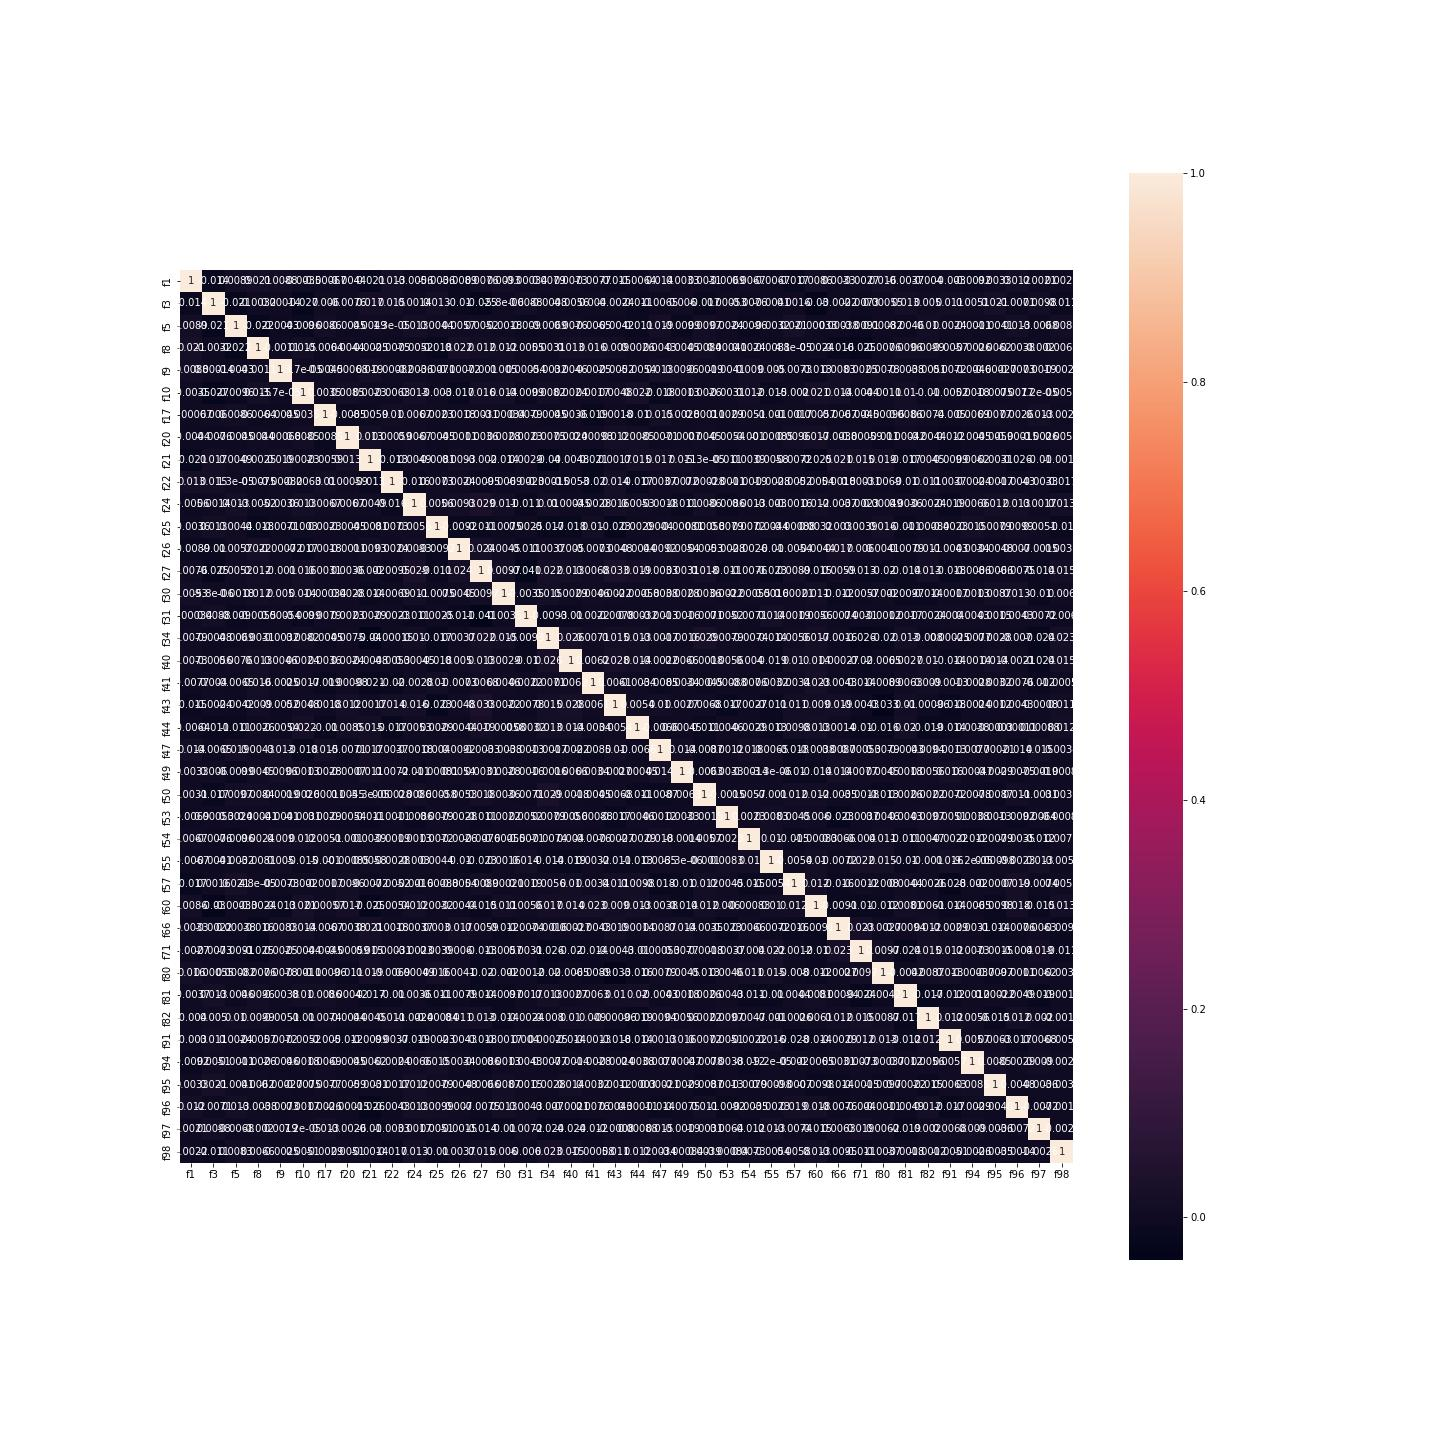

In [202]:
Image(filename="correlation_matrix_selected_features.jpg")

In [203]:
selected_features_target = summary["selected_features_names"] + [TARGET]

In [204]:
selected_features_target

['f1',
 'f3',
 'f5',
 'f8',
 'f9',
 'f10',
 'f17',
 'f20',
 'f21',
 'f22',
 'f24',
 'f25',
 'f26',
 'f27',
 'f30',
 'f31',
 'f34',
 'f40',
 'f41',
 'f43',
 'f44',
 'f47',
 'f49',
 'f50',
 'f53',
 'f54',
 'f55',
 'f57',
 'f60',
 'f66',
 'f71',
 'f80',
 'f81',
 'f82',
 'f91',
 'f94',
 'f95',
 'f96',
 'f97',
 'f98',
 'target']

In [205]:
df = pd.merge(X_train, y_train, left_index=True, right_index=True)

In [207]:
corr_target = df[selected_features_target].corr()["target"][:-1]

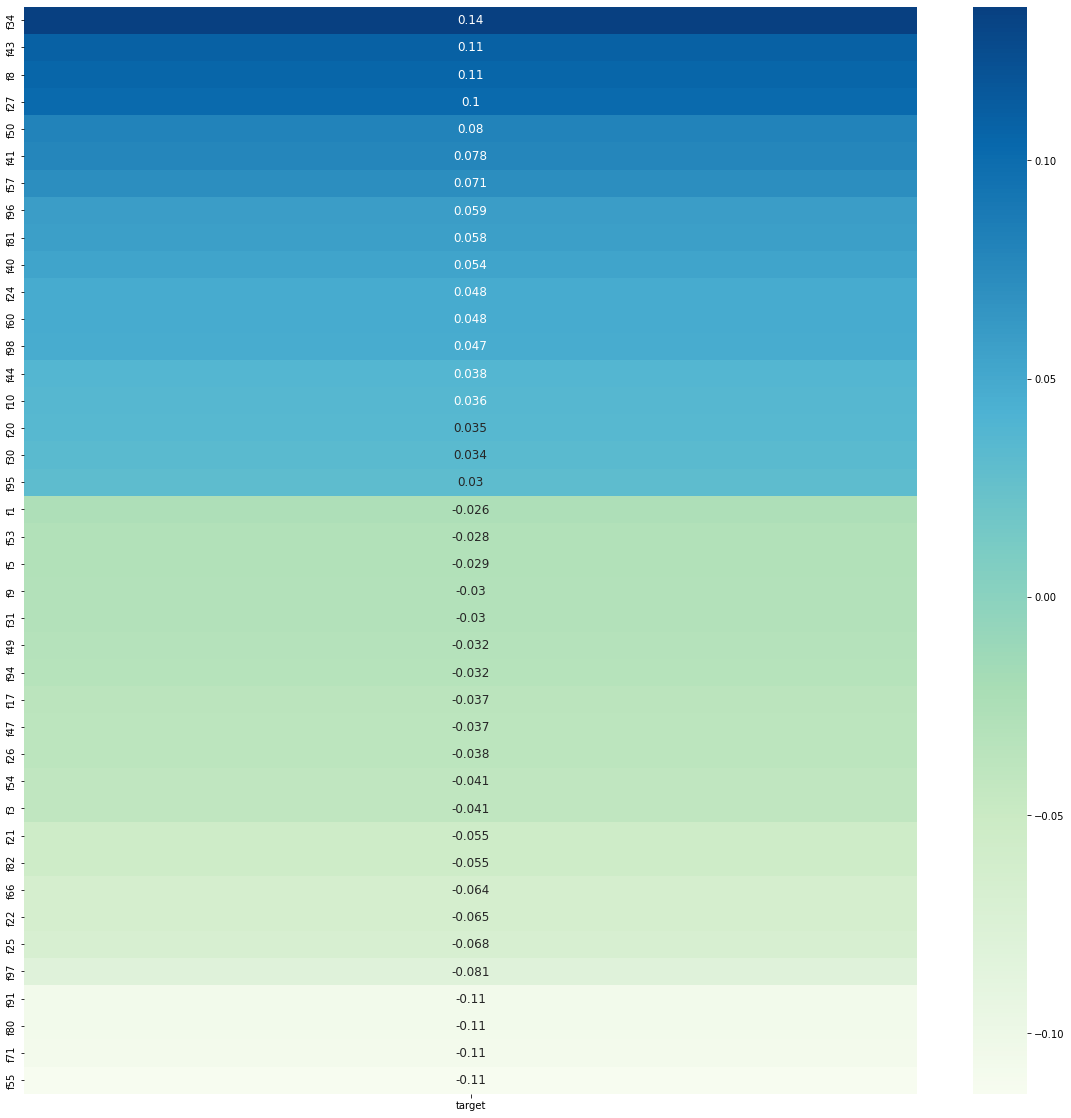

<Figure size 432x288 with 0 Axes>

In [208]:
plt.subplots(figsize=(20,20))
sns_plot = sns.heatmap(corr_target.sort_values(ascending=False).to_frame(),annot=True, annot_kws={'size':12},cmap="GnBu")
plt.show()
fig = sns_plot.get_figure()
fig.savefig("correlation_target.jpg")
plt.clf()

In [209]:
correlated_columns = pd.DataFrame(corr_target.sort_values(ascending=False)).T.columns
correlated_columns

Index(['f34', 'f43', 'f8', 'f27', 'f50', 'f41', 'f57', 'f96', 'f81', 'f40',
       'f24', 'f60', 'f98', 'f44', 'f10', 'f20', 'f30', 'f95', 'f1', 'f53',
       'f5', 'f9', 'f31', 'f49', 'f94', 'f17', 'f47', 'f26', 'f54', 'f3',
       'f21', 'f82', 'f66', 'f22', 'f25', 'f97', 'f91', 'f80', 'f71', 'f55'],
      dtype='object')

In [212]:
# sns.set()
# # fig = sns.pairplot(df[selected_features_target], size = 5, hue=df[selected_features_target].columns[-1])
# fig = sns.pairplot(df[selected_features_target].sample(frac=0.000001), size=3, hue=df[selected_features_target].columns[-1])
# plt.show();
# fig.savefig("pair_plots.jpg")
# plt.clf()

In [213]:
# Image(filename="pair_plots.jpg")

In [214]:
train[TARGET].value_counts()

1    303606
0    296394
Name: target, dtype: int64

In [215]:
train[TARGET].value_counts(normalize=True)

1   0.51
0   0.49
Name: target, dtype: float64

In [216]:
train[TARGET].describe()

count   600000.00
mean         0.51
std          0.50
min          0.00
25%          0.00
50%          1.00
75%          1.00
max          1.00
Name: target, dtype: float64

In [217]:
pd.DataFrame(y_pred).value_counts()

0    280910
1    259090
dtype: int64

In [218]:
pd.DataFrame(y_pred).value_counts(normalize=True)

0   0.52
1   0.48
dtype: float64

In [219]:
pd.DataFrame(y_pred).describe()

0
count 540000.00
mean       0.48
std        0.50
min        0.00
25%        0.00
50%        0.00
75%        1.00
max        1.00

* NO ALL CLASSES WERE REPRESENTED!!!

In [220]:
y_pred_submission = pd.DataFrame(y_pred, index=X_test.index, columns=["target"])

In [221]:
y_pred_submission

target
id             
600000        1
600001        1
600002        1
600003        0
600004        1
...         ...
1139995       1
1139996       1
1139997       1
1139998       1
1139999       1

[540000 rows x 1 columns]

In [222]:
y_pred_submission.head()

target
id            
600000       1
600001       1
600002       1
600003       0
600004       1

In [223]:
y_pred_submission.tail()

target
id             
1139995       1
1139996       1
1139997       1
1139998       1
1139999       1

In [224]:
now = datetime.now()
date_string = now.strftime("%Y%m%d_%H%M%S")

### MODEL 1 PREDICTIONS TO CSV

In [225]:
y_pred_submission.to_csv("outputs\submission_" + date_string + ".csv")

In [226]:
y_pred_submission.to_csv("outputs\submission.csv")

### MODEL 1 SUBMISSION

In [227]:
! kaggle competitions submit tabular-playground-series-nov-2021 -f outputs\submission.csv -m "Submission"

Successfully submitted to Tabular Playground Series - Nov 2021



  0%|          | 0.00/5.28M [00:00<?, ?B/s]
  2%|1         | 96.0k/5.28M [00:00<00:05, 919kB/s]
 15%|#4        | 800k/5.28M [00:00<00:02, 1.61MB/s]
 23%|##3       | 1.23M/5.28M [00:00<00:01, 2.32MB/s]
 30%|##9       | 1.58M/5.28M [00:00<00:01, 2.63MB/s]
 37%|###6      | 1.94M/5.28M [00:00<00:01, 2.89MB/s]
 43%|####2     | 2.26M/5.28M [00:00<00:01, 2.56MB/s]
 48%|####8     | 2.54M/5.28M [00:01<00:01, 2.54MB/s]
 55%|#####4    | 2.89M/5.28M [00:01<00:00, 2.83MB/s]
 61%|######1   | 3.24M/5.28M [00:01<00:00, 3.02MB/s]
 68%|######8   | 3.61M/5.28M [00:01<00:00, 3.23MB/s]
 75%|#######4  | 3.96M/5.28M [00:01<00:00, 3.35MB/s]
 81%|########1 | 4.30M/5.28M [00:01<00:00, 3.42MB/s]
 88%|########8 | 4.66M/5.28M [00:01<00:00, 3.48MB/s]
 95%|#########4| 5.00M/5.28M [00:01<00:00, 3.50MB/s]
100%|##########| 5.28M/5.28M [00:02<00:00, 1.96MB/s]


### GINI

In [ ]:
# #The function used in most kernels
# def gini(actual, pred, cmpcol = 0, sortcol = 1):
#     assert( len(actual) == len(pred) )
#     all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
#     all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
#     totalLosses = all[:,0].sum()
#     giniSum = all[:,0].cumsum().sum() / totalLosses
    
#     giniSum -= (len(actual) + 1) / 2.
#     return giniSum / len(actual)
 
# def gini_normalized(a, p):
#     return gini(a, p) / gini(a, a)

In [ ]:
# gini_normalized(y_test, y_pred)

### REMOVING FEATURES NOT IMPACTING LOSS

In [228]:
# features_to_exclude = {
#     "feature_index": [
#         "1",
#         "2",
#         "6",
#         "8",
#         "14",
#         "16",
#         "17",
#         "18",
#         "19",
#         "20",
#         "21",
#         "22",
#         "28",
#         "38",
#         "25"
#     ],
#     "feature_name": [
#         "Aspect",
#         "Slope",
#         "Hillshade_9am",
#         "Hillshade_3am",
#         "Soil_Type1",
#         "Soil_Type3",
#         "Soil_Type4",
#         "Soil_Type5",
#         "Soil_Type6",
#         "Soil_Type7",
#         "Soil_Type8",
#         "Soil_Type9",
#         "Soil_Type15",
#         "Soil_Type25",
#         "Soil_Type12"
#     ]
# }

In [229]:
# to_exclude = pd.DataFrame.from_dict(features_to_exclude)

In [230]:
# to_exclude['feature_name']

In [231]:
# X_train.loc[:, ~X_train.columns.isin(to_exclude['feature_name'])]